# Project: Advanced Lane Finding

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# Import all nessesery modules
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [4]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


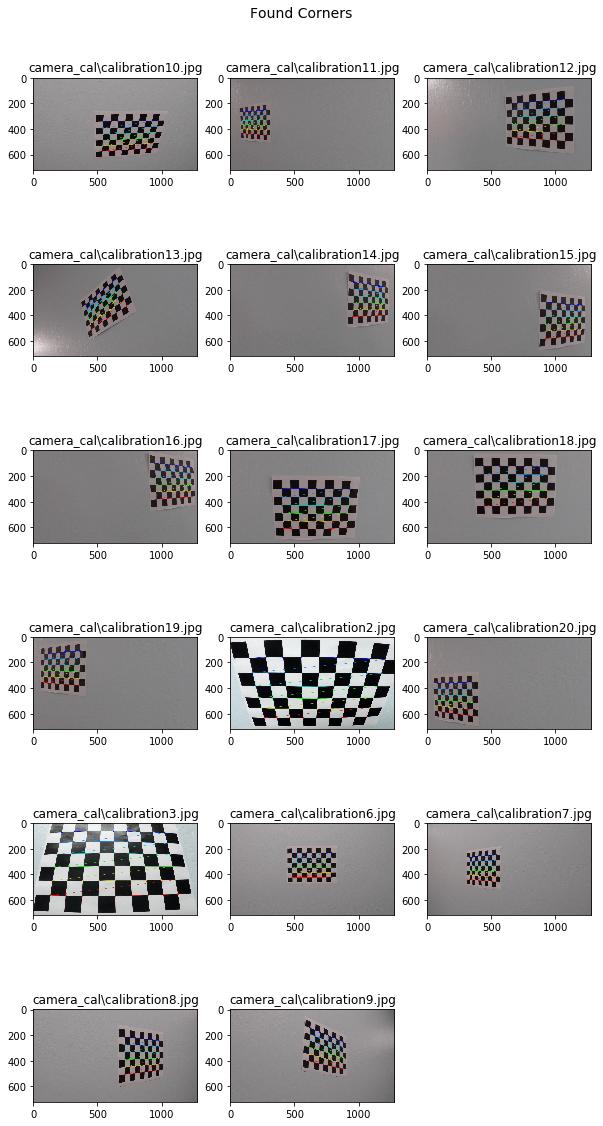

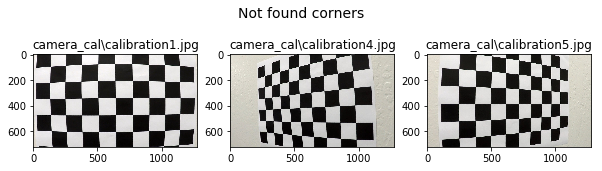

In [5]:
x_corners = 9 
y_corners = 6

objp = np.zeros((y_corners * x_corners,3), np.float32)
objp[:,:2] = np.mgrid[0:x_corners, 0:y_corners].T.reshape(-1,2)

objpoints = [] 
imgpoints = [] 

images = glob.glob('camera_cal/calibration*.jpg')

not_found = []

plt.figure(figsize=(10, 20))

plt.figtext(0.5,0.9,'Found Corners ', fontsize=14, ha='center')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (x_corners,y_corners), None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_corners,y_corners), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        
    else:
        not_found.append(fname)
plt.show()

plt.figure(figsize=(10, 20))

plt.figtext(0.5,0.56 ,'Not found corners ', fontsize=14, ha='center')
for i, p in enumerate(not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) 
    plt.title(p)

plt.show()


## Apply a distortion correction to raw images.

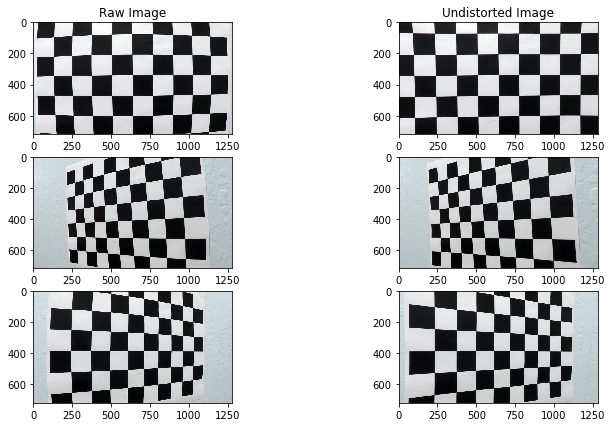

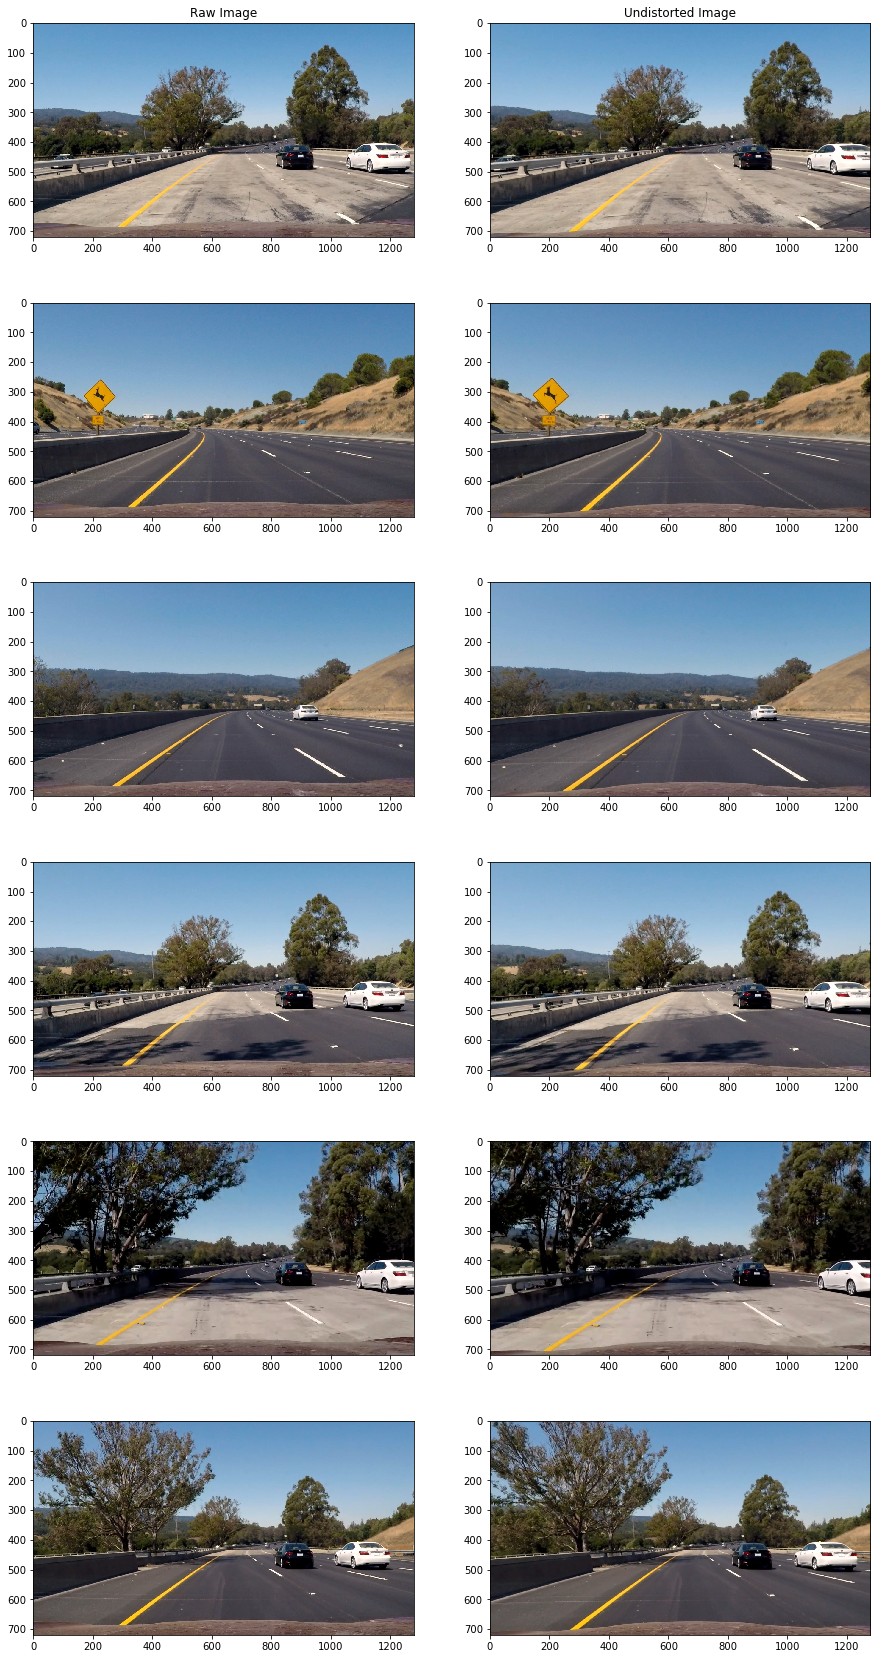

In [6]:
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = []
for i in not_found:
    img.append(cv2.imread(i))

    
img_size = (img[0].shape[1], img[0].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

plt.figure(figsize=(12, 7))

counter = 1
for i in img:
    plt.subplot(3, 2, counter)
    plt.imshow(i)
    if (counter == 1):
        plt.title("Raw Image")
    counter += 1 
    plt.subplot(3, 2, counter)
    plt.imshow(undistort_img(i, mtx, dist))
    if (counter == 2):
        plt.title("Undistorted Image")
    counter += 1
   
test_images_files = glob.glob('test_images/test*.jpg')
test_images = []
for i in test_images_files:
    test_images.append(cv2.imread(i))


plt.figure(figsize=(15, 30))
counter = 1

for i in test_images:
    plt.subplot(6, 2, counter)
    plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
    if (counter == 1):
        plt.title("Raw Image")
    counter += 1 
    plt.subplot(6, 2, counter)
    plt.imshow(cv2.cvtColor(undistort_img(i, mtx, dist), cv2.COLOR_BGR2RGB))
    if (counter == 2):
        plt.title("Undistorted Image")
    counter += 1

## Use color transforms, gradients, etc., to create a thresholded binary image.

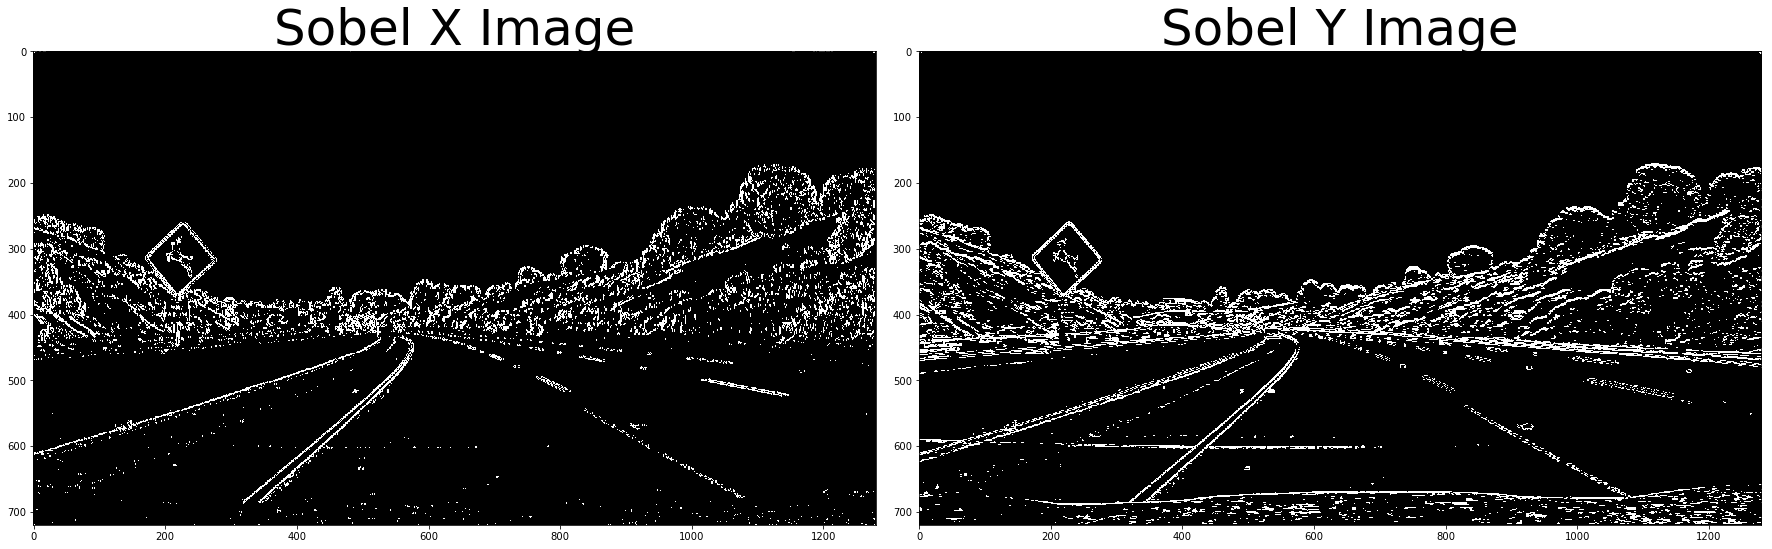

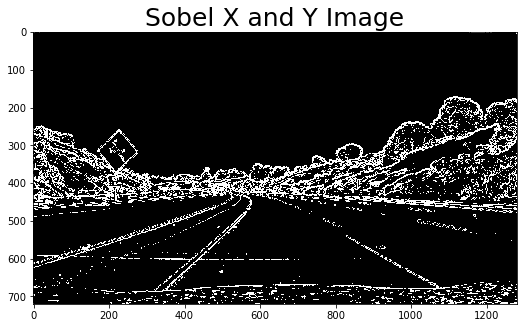

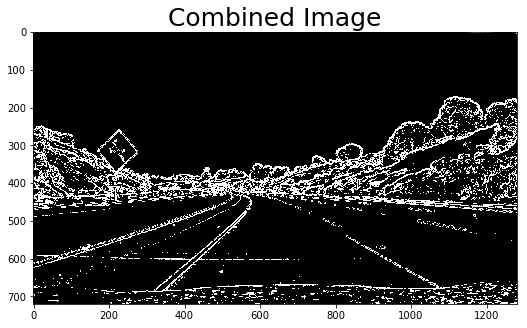

In [5]:
img = cv2.imread('test_images/test2.jpg')
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

## test results

abs_sobel_x_img = abs_sobel_thresh(img, 'x', 3, (20, 100))
abs_sobel_y_img = abs_sobel_thresh(img, 'y', 3, (20, 100))
abs_sobel_xy_img = mag_thresh(img, sobel_kernel=3, thresh=(20, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(abs_sobel_x_img, cmap='gray')
ax1.set_title('Sobel X Image', fontsize=50)
ax2.imshow(abs_sobel_y_img, cmap='gray')
ax2.set_title('Sobel Y Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.figure(figsize=(15, 5))
plt.imshow(abs_sobel_xy_img, cmap='gray')
plt.title('Sobel X and Y Image', fontsize=25)



gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=3, thresh=(20, 100))
dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2))


combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(figsize=(15, 5))
plt.imshow(combined, cmap='gray')
plt.title('Combined Image', fontsize=25)

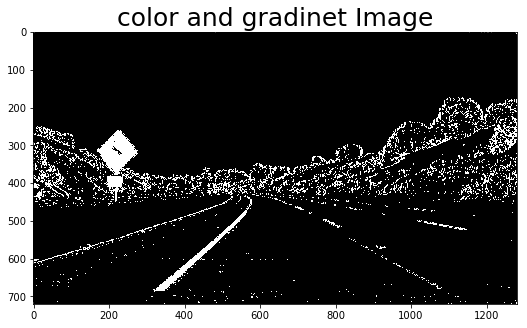

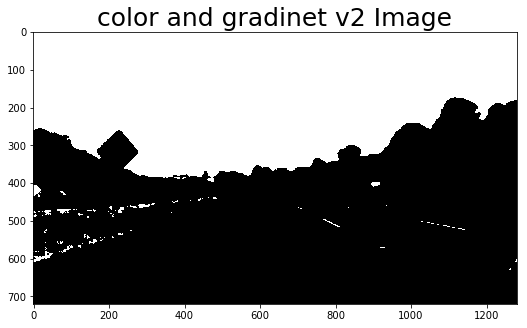

In [6]:
def apply_color_gradient_v2(img, thresh=(20,100), s_thresh=(220,255), b_thresh=(190,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel*(255/np.max(l_channel))

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    
    b_binary = np.zeros_like(lab_b)
    b_binary[((lab_b > b_thresh[0]) & (lab_b <= b_thresh[1]))] = 1


    combined_binary = np.zeros_like(b_binary)
    #combined_binary[(l_binary == 1) | (gradx == 1) | (b_binary == 1)] = 1    
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1    
    
    return combined_binary

    

def apply_color_gradient(img, xgrad_thresh=(20,100), s_thresh=(170,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

img_color_gradient_normalized = apply_color_gradient(img)

plt.figure(figsize=(15, 5))
plt.imshow(img_color_gradient_normalized, cmap='gray')
plt.title('color and gradinet Image', fontsize=25)

img_color_gradient = apply_color_gradient_v2(img)
plt.figure(figsize=(15, 5))
plt.imshow(img_color_gradient, cmap='gray')
plt.title('color and gradinet v2 Image', fontsize=25)

## Apply a perspective transform to rectify binary image ("birds-eye view").

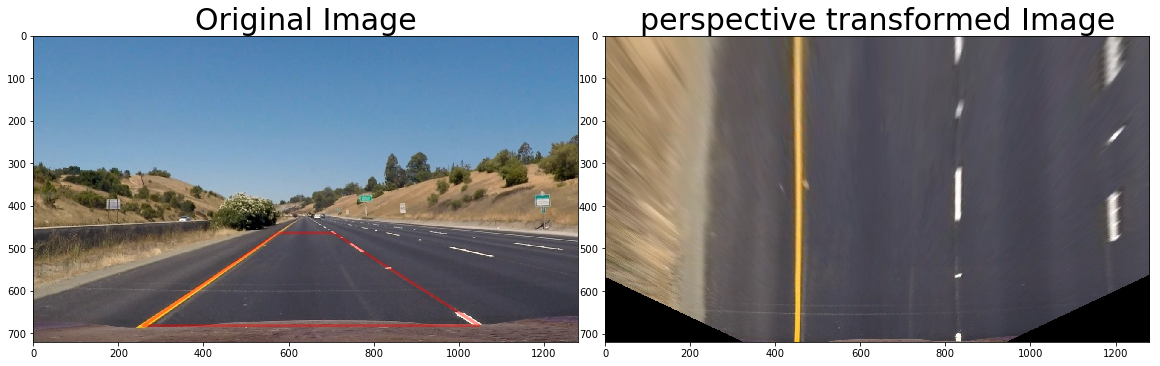

In [7]:
def perspective_transform(img, src, dst):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

img = cv2.imread('test_images/straight_lines1.jpg')

h,w = img.shape[:2]

src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

exampleImg_unwarp, M, Minv = perspective_transform(img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('perspective transformed Image', fontsize=30)


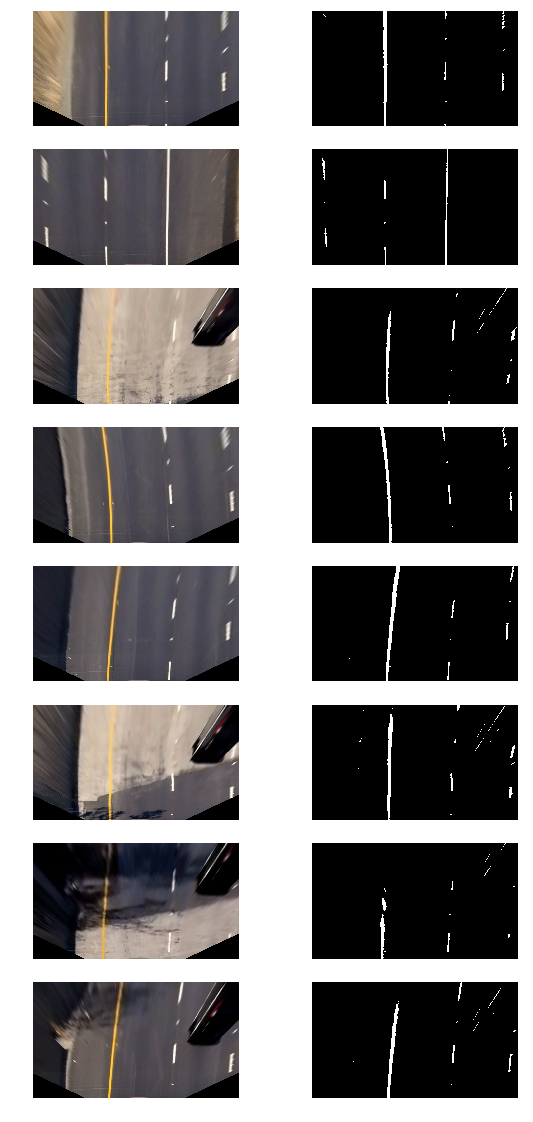

In [8]:
imshape = img_color_gradient.shape

vertices = np.array([[(0,imshape[0] - 330),(0, imshape[0]), (imshape[1], imshape[0]), (imshape[1],imshape[0] - 330)]], dtype=np.int32)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image



def processing_pipeline(img, mtx, dist, vertices, src, dst):
    
    gblur = cv2.GaussianBlur(img, (5,5), 20.0)
    img = cv2.addWeighted(img, 2, gblur, -1, 0)
    
    img = region_of_interest(img, vertices)
    
    img = undistort_img(img, mtx, dist)    
    
    img, M, Minv = perspective_transform(img, src, dst)
    
    img = apply_color_gradient_v2(img)
    
    #img = region_of_interest(img, vertices)

    
    return img, Minv

images = glob.glob('./test_images/*.jpg')
                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in images:
    img = cv2.imread(image)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img_bin, _ = processing_pipeline(img, mtx, dist, vertices, src, dst)
    img = undistort_img(img, mtx, dist)
    img, M, Minv = perspective_transform(img, src, dst)
    
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

## Detect lane pixels and fit to find the lane boundary.

In [9]:
def sliding_windows_fit(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 80
    
    minpix = 40
    
    left_lane_inds = []
    right_lane_inds = []    
    rectangle_data = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)

    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    print(left_fit, right_fit)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data


[ -2.60219165e-05   1.88198892e-02   4.51708908e+02] [  4.28873587e-06  -6.15711374e-03   8.29949959e+02]
375.970650949
[  1.91488870e-05  -7.61701426e-03   4.51989928e+02] [  4.05730699e-06  -2.14808510e-02   8.42450941e+02]
372.65557533
[  1.02092503e-04  -1.20697212e-01   5.01753640e+02] [  4.90248696e-05  -1.07849739e-01   9.03373589e+02]
383.359867607
[ -1.04224737e-04   1.48200551e-01   4.33627375e+02] [ -5.94628194e-05   1.23126730e-01   8.13368174e+02]
384.892225746
[  3.81415560e-05  -1.27773723e-01   5.34903147e+02] [  6.77478098e-05  -1.36233763e-01   9.07638896e+02]
381.992402007
[  4.93010893e-05  -6.10225256e-02   4.96267499e+02] [  9.69747821e-05  -1.35554194e-01   9.10985827e+02]
385.76956846
[  1.26806189e-04  -1.64705511e-01   4.90275850e+02] [  1.69345680e-05  -8.26997678e-02   8.92075923e+02]
403.886759316
[  6.07148173e-05  -1.51737717e-01   5.50489373e+02] [  7.73338140e-05  -1.42382057e-01   9.26316476e+02]
391.178466087


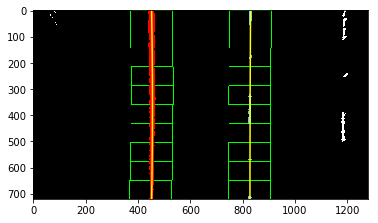

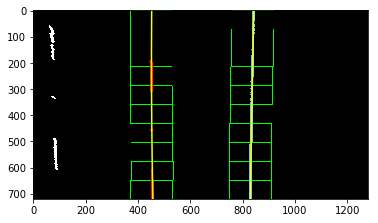

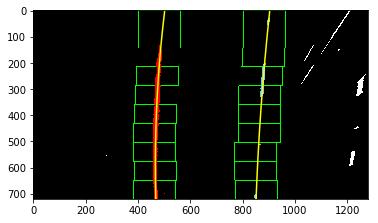

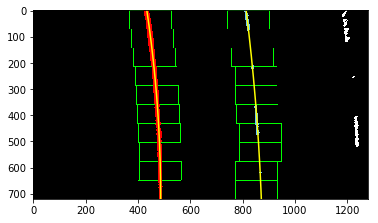

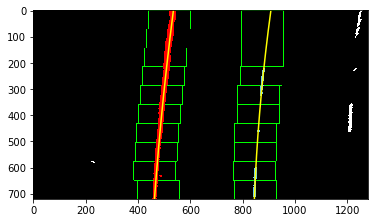

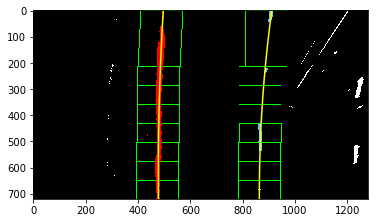

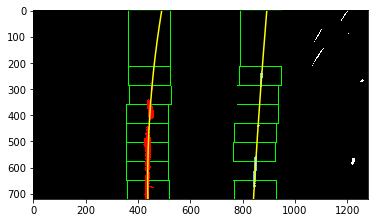

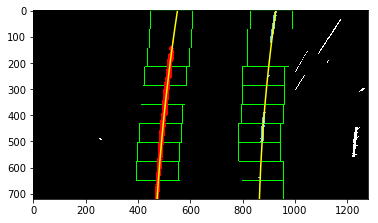

In [12]:
def processing_fit_poly(img, mtx, dist, vertices, src, dst):
    exampleImg_bin, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_windows_fit(exampleImg_bin)

    h = img.shape[0]
    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    print(abs(left_fit_x_int - right_fit_x_int))


    rectangles = visualization_data[0]
    histogram = visualization_data[1]

    out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)

    ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    for rect in rectangles:
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

    nonzero = exampleImg_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
        
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    
images = glob.glob('./test_images/*.jpg')

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    processing_fit_poly(img, mtx, dist, vertices, src, dst)

In [70]:
def processing_fit_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

## Determine the curvature of the lane and vehicle position with respect to center.

In [71]:
def calc_curvature(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    
    ym_per_pix = 3.05/100
    xm_per_pix = 3.7/378
    
    left_curverad = 0
    right_curverad = 0
    center_dist = 0
    h = bin_img.shape[0]
    
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        
    return left_curverad, right_curverad, center_dist

## Warp the detected lane boundaries back onto the original image.

In [72]:
def draw_lane_pipeline(img, binary_img ,left_fit, right_fit, Minv):
        
    if left_fit is None or right_fit is None:
        return img
    
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    
    # calculate left and right lane x 
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    return result

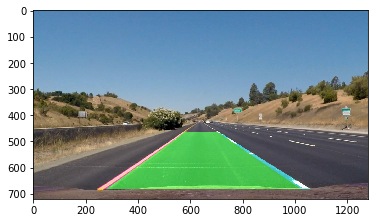

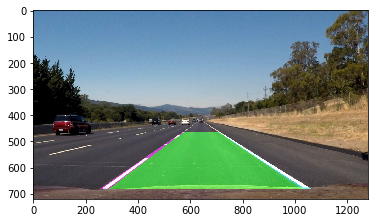

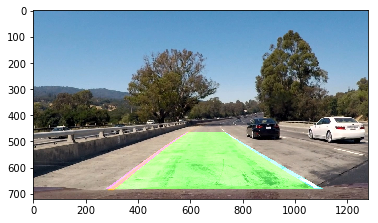

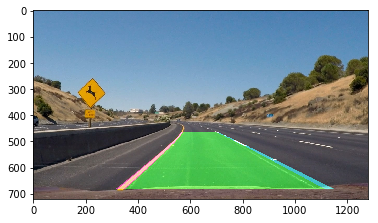

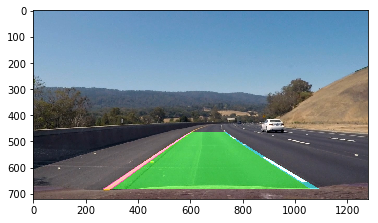

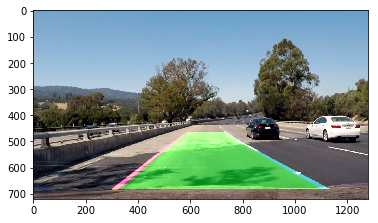

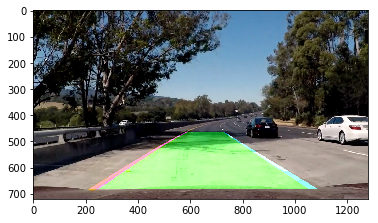

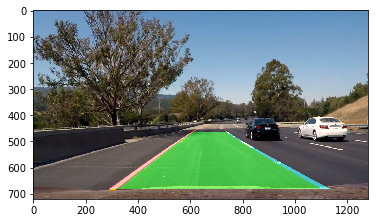

In [73]:
images = glob.glob('./test_images/*.jpg')

for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bin_img, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    left_fit, right_fit, left_lane_inds, right_lane_inds, _ = sliding_windows_fit(bin_img)
    
    res_img = draw_lane_pipeline(img, bin_img, left_fit, right_fit, Minv)
    plt.figure()
    plt.imshow(res_img)
    


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [74]:
def draw_info(img, curv_rad, center_dist):
    
    h = img.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(curv_rad) + '(m)'
    cv2.putText(img, text, (40,70), font, 1.5, (255,128,0), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(img, text, (40,120), font, 1.5, (255,128,0), 2, cv2.LINE_AA)
    return img

[ -2.60219165e-05   1.88198892e-02   4.51708908e+02] [  4.28873587e-06  -6.15711374e-03   8.29949959e+02]
375.970650949
[  1.91488870e-05  -7.61701426e-03   4.51989928e+02] [  4.05730699e-06  -2.14808510e-02   8.42450941e+02]
372.65557533
[  1.02092503e-04  -1.20697212e-01   5.01753640e+02] [  4.90248696e-05  -1.07849739e-01   9.03373589e+02]
383.359867607
[ -1.04224737e-04   1.48200551e-01   4.33627375e+02] [ -5.94628194e-05   1.23126730e-01   8.13368174e+02]
384.892225746
[  3.81415560e-05  -1.27773723e-01   5.34903147e+02] [  6.77478098e-05  -1.36233763e-01   9.07638896e+02]
381.992402007
[  4.93010893e-05  -6.10225256e-02   4.96267499e+02] [  9.69747821e-05  -1.35554194e-01   9.10985827e+02]
385.76956846
[  1.26806189e-04  -1.64705511e-01   4.90275850e+02] [  1.69345680e-05  -8.26997678e-02   8.92075923e+02]
403.886759316
[  6.07148173e-05  -1.51737717e-01   5.50489373e+02] [  7.73338140e-05  -1.42382057e-01   9.26316476e+02]
391.178466087


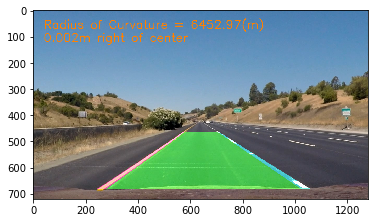

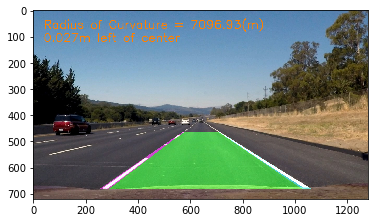

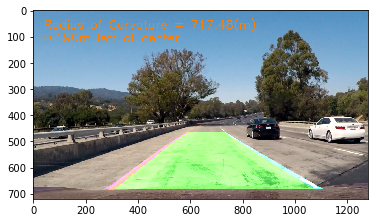

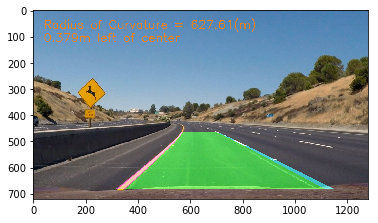

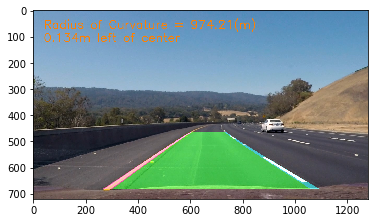

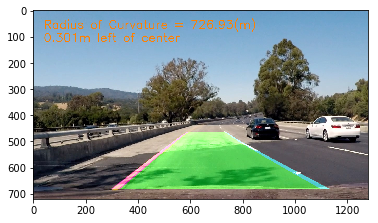

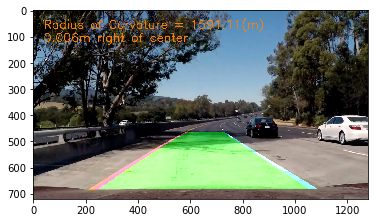

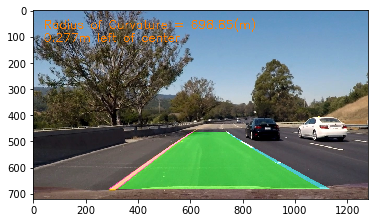

In [84]:
def lane_detection_pipeline(img):
    
    global left_line, right_line
    
    img_bin, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    
    if not left_line.detected or not right_line.detected:
    
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_windows_fit(img_bin)
        
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = processing_fit_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
      
    
    if l_fit is not None and r_fit is not None:
        
        h = img.shape[0]
        
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        
        print(x_int_diff)
        
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    """"            
    def add_fit(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit - self.best_fit)
                print(self.diffs)
                
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

    """        
    left_line.add_fit(l_fit, l_lane_inds)
    right_line.add_fit(r_fit, r_lane_inds)

    # draw the current best fit if it exists
    if left_line.best_fit is not None and right_line.best_fit is not None:
    
        img_out1 = draw_lane_pipeline(img, img_bin, left_line.best_fit, right_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curvature(img_bin, left_line.best_fit, right_line.best_fit, l_lane_inds, r_lane_inds)
        img_out = draw_info(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        return img
    
    return img_out


for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    left_line = Line()
    right_line = Line()
    
    res_img = lane_detection_pipeline(img)

    plt.figure()
    plt.imshow(res_img)

In [76]:
from moviepy.editor import VideoFileClip

left_line = Line()
right_line = Line()

output_video = 'project4_adv_lane_video.mp4'
input_video = VideoFileClip('project_video.mp4')
processed_video = input_video.fl_image(lane_detection_pipeline)
%time processed_video.write_videofile(output_video, audio=False)

720 [ -1.02833125e-04   1.41752865e-01   4.34757073e+02]
483.510443728
[MoviePy] >>>> Building video project4_adv_lane_video.mp4
[MoviePy] Writing video project4_adv_lane_video.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

720 [ -1.02833125e-04   1.41752865e-01   4.34757073e+02]
483.510443728
[  7.41323235e-18   2.30371278e-15   1.70530257e-13]
[  1.57073790e-17   8.24340596e-15   1.13686838e-13]


  0%|                                         | 1/1261 [00:00<03:06,  6.76it/s]

720 [ -1.07077878e-04   1.45911111e-01   4.34462479e+02]
484.009306878
[  4.24475241e-06   4.15824560e-03   2.94594032e-01]
[  1.33517386e-06   4.58518998e-03   4.12281954e+00]


  0%|                                         | 2/1261 [00:00<03:11,  6.57it/s]

720 [ -1.11018596e-04   1.49838495e-01   4.34002775e+02]
484.334451594
[  6.77055266e-06   6.69954781e-03   6.56099774e-01]
[  1.36598452e-06   9.38143862e-03   6.31871785e+00]


  0%|                                         | 3/1261 [00:00<03:04,  6.80it/s]

720 [ -1.23806314e-04   1.61230243e-01   4.32166520e+02]
484.071102361
[  1.78656328e-05   1.64164096e-02   2.32832997e+00]
[  5.57219552e-07   1.18302971e-02   8.07114384e+00]


  0%|▏                                        | 4/1261 [00:00<02:58,  7.06it/s]

720 [ -1.23497783e-04   1.63149419e-01   4.31412630e+02]
484.858961503
[  1.39839749e-05   1.50523033e-02   2.61655396e+00]
[  6.76883861e-06   1.65265760e-02   8.35996886e+00]


  0%|▏                                        | 5/1261 [00:00<02:52,  7.29it/s]

720 [ -1.21475568e-04   1.64115573e-01   4.30868289e+02]
486.058567031
[  7.82882921e-06   1.17391463e-02   2.49200648e+00]
[  1.22277156e-05   2.34661015e-02   1.09260668e+01]


  0%|▏                                        | 6/1261 [00:00<03:06,  6.73it/s]

720 [ -1.16338537e-04   1.63463920e-01   4.29552683e+02]
486.936807742
[  1.03669062e-06   6.61495215e-03   3.02985610e+00]
[  3.02143625e-06   8.47274712e-03   4.45215196e+00]


  1%|▏                                        | 7/1261 [00:01<06:07,  3.41it/s]

720 [ -1.20540232e-04   1.69539349e-01   4.28380030e+02]
487.960305173
[  1.31287242e-06   9.17981879e-03   3.22054934e+00]
[  2.08283260e-05   2.36074233e-03   5.59960914e+00]


  1%|▎                                        | 8/1261 [00:01<05:06,  4.09it/s]

720 [ -1.22593407e-04   1.73481179e-01   4.26002031e+02]
487.356058316
[  1.46172038e-06   9.18147848e-03   4.47399911e+00]
[  1.99741079e-05   9.99249188e-03   4.70332257e-01]


  1%|▎                                        | 9/1261 [00:01<04:21,  4.79it/s]

720 [ -1.18859310e-04   1.72788346e-01   4.24712598e+02]
487.503540828
[  2.02979491e-06   6.03845790e-03   4.53053450e+00]
[  2.63542086e-05   1.56151765e-02   6.21955871e-01]


  1%|▎                                       | 10/1261 [00:01<03:52,  5.39it/s]

720 [ -1.12851436e-04   1.70415284e-01   4.24146141e+02]
488.342961221
[  7.10997509e-06   1.73761023e-03   3.75698505e+00]
[  1.93582812e-05   8.60040662e-03   2.44433626e+00]


  1%|▎                                       | 11/1261 [00:02<03:34,  5.82it/s]

720 [ -1.04469058e-04   1.68162622e-01   4.20392242e+02]
487.312569976
[  1.37675261e-05   1.77499400e-03   6.16645451e+00]
[  1.27375374e-05   1.89514947e-02   7.91438651e+00]


  1%|▍                                       | 12/1261 [00:02<03:23,  6.14it/s]

720 [ -9.66317599e-05   1.63422107e-01   4.20462093e+02]
488.032105596
[  1.92309287e-05   7.45524906e-03   4.26451564e+00]
[  1.48065208e-05   1.53237147e-02   3.70641065e+00]


  1%|▍                                       | 13/1261 [00:02<03:12,  6.50it/s]

720 [ -9.07687892e-05   1.60539078e-01   4.20027297e+02]
488.5608924
[  2.03122051e-05   9.11482997e-03   3.11572433e+00]
[  4.98028332e-06   3.44431820e-03   1.59090074e+00]


  1%|▍                                       | 14/1261 [00:02<03:05,  6.72it/s]

720 [ -8.47935493e-05   1.54596534e-01   4.22002404e+02]
489.354932732
[  1.99225214e-05   1.24689533e-02   5.43300036e-02]
[  3.75881926e-06   1.25895946e-02   1.01444173e+01]


  1%|▍                                       | 15/1261 [00:02<02:56,  7.07it/s]

720 [ -8.22508625e-05   1.51225613e-01   4.23260820e+02]
489.504413654
[  1.56520561e-05   1.22015121e-02   1.85478411e+00]
[  1.08819487e-05   2.29330544e-02   1.60618464e+01]


  1%|▌                                       | 16/1261 [00:02<02:53,  7.19it/s]

720 [ -7.88603152e-05   1.47815253e-01   4.23343227e+02]
488.889021587
[  1.29224887e-05   1.17739379e-02   2.11425587e+00]
[  1.24128767e-06   1.32317620e-02   1.36472626e+01]


  1%|▌                                       | 17/1261 [00:02<02:47,  7.41it/s]

720 [ -7.26519666e-05   1.42683808e-01   4.24027808e+02]
489.097370367
[  1.40090886e-05   1.28359087e-02   2.20863992e+00]
[  4.78680705e-06   1.53767798e-02   1.30355241e+01]


  1%|▌                                       | 18/1261 [00:02<02:45,  7.51it/s]

720 [ -6.29647730e-05   1.36268924e-01   4.23233196e+02]
488.705882683
[  1.89003236e-05   1.51031334e-02   7.00884830e-01]
[  3.80789569e-06   2.88016385e-03   2.36652394e+00]


  2%|▌                                       | 19/1261 [00:03<02:41,  7.67it/s]

720 [ -5.69432499e-05   1.32531231e-01   4.22211999e+02]
488.115105093
[  1.93610434e-05   1.39867951e-02   9.61491523e-01]
[  2.59380537e-06   9.14755955e-03   3.76650355e+00]


  2%|▋                                       | 20/1261 [00:03<02:39,  7.78it/s]

720 [ -4.88914036e-05   1.27054955e-01   4.21345595e+02]
487.479858638
[  2.18428298e-05   1.50500108e-02   1.86981526e+00]
[  9.75931278e-06   1.03128192e-02   9.34472219e+00]


  2%|▋                                       | 21/1261 [00:03<02:37,  7.87it/s]

720 [ -4.74429762e-05   1.26652524e-01   4.19393336e+02]
485.988714188
[  1.66193654e-05   1.06183097e-02   3.43902954e+00]
[  1.51112397e-05   1.05966973e-02   1.27383723e+01]


  2%|▋                                       | 22/1261 [00:03<02:36,  7.90it/s]

720 [ -5.41871260e-05   1.31419689e-01   4.17275510e+02]
483.807079874
[  3.59174787e-06   1.61859973e-03   4.76687661e+00]
[  1.14706061e-05   1.32711489e-02   1.38230557e+01]


  2%|▋                                       | 23/1261 [00:03<02:44,  7.50it/s]

720 [ -5.64754058e-05   1.29163446e-01   4.19251153e+02]
482.97198419
[  2.38950007e-06   1.62201827e-03   1.44077391e+00]
[  4.59208361e-06   4.92618454e-03   5.54409620e+00]


  2%|▊                                       | 24/1261 [00:03<02:46,  7.42it/s]

720 [ -6.17633527e-05   1.30475221e-01   4.20101037e+02]
482.025073837
[  8.97532044e-06   1.11085150e-03   2.05518478e-01]
[  3.55340142e-05   2.20468734e-02   1.58119386e+00]


  2%|▊                                       | 25/1261 [00:03<02:43,  7.55it/s]

720 [ -6.43213583e-05   1.32468606e-01   4.18299493e+02]
480.332697232
[  1.05693055e-05   3.51543937e-03   1.17383330e+00]
[  1.27016142e-05   3.26086384e-03   4.13071408e+00]


  2%|▊                                       | 26/1261 [00:04<02:54,  7.09it/s]

720 [ -7.24890017e-05   1.36715518e-01   4.17908197e+02]
478.765070878
[  1.56509579e-05   6.67962062e-03   9.55909260e-01]
[  1.03476462e-05   5.43451820e-03   2.58803255e+00]


  2%|▊                                       | 27/1261 [00:04<04:06,  5.01it/s]

720 [ -6.73500947e-05   1.32164155e-01   4.17310802e+02]
477.554704621
[  5.50284581e-06   1.15659174e-04   1.25627592e+00]
[  5.68691052e-06   4.22240924e-03   8.78050079e+00]


  2%|▉                                       | 28/1261 [00:04<03:38,  5.65it/s]

720 [ -7.72003969e-05   1.36779856e-01   4.18345246e+02]
476.806056197
[  1.27205542e-05   4.58246639e-03   2.28890455e-01]
[  2.35361216e-05   2.24267156e-02   7.45649689e+00]


  2%|▉                                       | 29/1261 [00:04<03:18,  6.19it/s]

720 [ -9.28863231e-05   1.44476958e-01   4.19763702e+02]
475.634841671
[  2.42614822e-05   1.07562871e-02   1.37074677e+00]
[  1.27812168e-06   6.28590653e-03   3.28565140e+00]


  2%|▉                                       | 30/1261 [00:04<03:04,  6.67it/s]

720 [ -1.02065234e-04   1.49557640e-01   4.21207086e+02]
475.977969904
[  2.72157988e-05   1.30366218e-02   2.88159823e+00]
[  4.31059060e-06   9.79126972e-03   8.11068112e+00]


  2%|▉                                       | 31/1261 [00:04<02:54,  7.05it/s]

720 [ -1.10944650e-04   1.54096296e-01   4.23021292e+02]
476.456918319
[  2.85464399e-05   1.41574703e-02   4.11428549e+00]
[  1.07977795e-06   1.97663950e-02   1.42000657e+01]


  3%|█                                       | 32/1261 [00:04<02:47,  7.33it/s]

720 [ -1.08419107e-04   1.53336370e-01   4.22025344e+02]
476.223065566
[  1.83297669e-05   9.92138880e-03   2.09571867e+00]
[  1.02337843e-05   4.94913714e-03   6.17448351e+00]


  3%|█                                       | 33/1261 [00:05<02:42,  7.57it/s]

720 [ -1.13792209e-04   1.57227260e-01   4.22660944e+02]
476.874689811
[  1.54890672e-05   9.57783635e-03   1.78840976e+00]
[  2.08085041e-06   9.54101181e-03   6.49306604e+00]


  3%|█                                       | 34/1261 [00:05<02:39,  7.71it/s]

720 [ -1.20959777e-04   1.62912321e-01   4.22569050e+02]
477.160372502
[  1.53382728e-05   1.11734162e-02   8.33376403e-01]
[  1.29002370e-06   5.78267296e-03   4.06937066e+00]


  3%|█                                       | 35/1261 [00:05<02:36,  7.85it/s]

720 [ -1.26678454e-04   1.69191884e-01   4.22283299e+02]
478.431345813
[  1.54422581e-05   1.37659069e-02   1.34437913e-02]
[  3.78682702e-06   6.34423883e-03   5.96793503e+00]


  3%|█▏                                      | 36/1261 [00:05<02:34,  7.93it/s]

720 [ -1.30235885e-04   1.72701041e-01   4.22120875e+02]
478.951341505
[  1.40770457e-05   1.33482149e-02   3.91111187e-01]
[  2.00341102e-06   7.26528250e-03   5.51993203e+00]


  3%|█▏                                      | 37/1261 [00:05<02:33,  7.99it/s]

720 [ -1.37428087e-04   1.79094399e-01   4.21911122e+02]
479.616369213
[  1.74110004e-05   1.60206235e-02   4.20780128e-01]
[  1.62646545e-05   1.87145849e-02   8.29044445e+00]


  3%|█▏                                      | 38/1261 [00:05<02:32,  8.03it/s]

720 [ -1.44772327e-04   1.85591705e-01   4.21472419e+02]
480.04847204
[  1.89534441e-05   1.73663238e-02   8.36639434e-01]
[  1.28760772e-05   1.87162940e-02   1.02295320e+01]


  3%|█▏                                      | 39/1261 [00:05<02:34,  7.93it/s]

720 [ -1.45046584e-04   1.88611736e-01   4.19671132e+02]
480.27943341
[  1.30316780e-05   1.47134661e-02   2.40022046e+00]
[  4.51507813e-06   6.95615516e-03   4.82305944e+00]


  3%|█▎                                      | 40/1261 [00:05<02:32,  7.99it/s]

720 [ -1.43336533e-04   1.89657277e-01   4.18830651e+02]
481.078230854
[  6.50426614e-06   1.06191234e-02   2.66111885e+00]
[  1.09917531e-05   1.19861871e-02   4.50895246e+00]


  3%|█▎                                      | 41/1261 [00:06<02:31,  8.03it/s]

720 [ -1.48857541e-04   1.95258775e-01   4.17592425e+02]
481.010993942
[  8.69365831e-06   1.21275438e-02   3.20881452e+00]
[  1.04557953e-05   9.39496384e-03   1.51690905e+00]


  3%|█▎                                      | 42/1261 [00:06<02:31,  8.06it/s]

720 [ -1.47216201e-04   1.97868020e-01   4.15663410e+02]
481.811505939
[  3.32798707e-06   1.02252416e-02   4.23213938e+00]
[  4.98543210e-06   7.15978944e-03   3.78448650e+00]


  3%|█▎                                      | 43/1261 [00:06<02:40,  7.57it/s]

720 [ -1.46585572e-04   1.99940168e-01   4.13645934e+02]
481.61289497
[  7.39734661e-07   8.54266562e-03   5.00007307e+00]
[  8.18600027e-06   4.75156300e-04   5.33542487e+00]


  3%|█▍                                      | 44/1261 [00:06<02:40,  7.60it/s]

720 [ -1.45639453e-04   2.02776115e-01   4.11606832e+02]
482.106141743
[  5.69033085e-07   8.50891956e-03   5.47387892e+00]
[  1.47793909e-06   6.31821323e-03   7.44661147e+00]


  4%|█▍                                      | 45/1261 [00:06<02:36,  7.77it/s]

720 [ -1.40443255e-04   1.99841540e-01   4.11203444e+02]
482.28356945
[  5.88380566e-06   2.74146943e-03   4.26440688e+00]
[  8.65724475e-07   5.47704245e-03   5.50696682e+00]


  4%|█▍                                      | 46/1261 [00:06<02:34,  7.88it/s]

720 [ -1.39492132e-04   2.01713978e-01   4.09290012e+02]
482.211354308
[  6.25627209e-06   2.57705398e-03   4.65239721e+00]
[  2.88661350e-06   3.55897367e-03   4.74246081e+00]


  4%|█▍                                      | 47/1261 [00:06<02:32,  7.95it/s]

720 [ -1.37875461e-04   2.01791916e-01   4.08847725e+02]
482.663265814
[  5.99986139e-06   1.36395180e-03   3.43420091e+00]
[  1.97468916e-06   5.15033498e-05   3.70769568e-01]


  4%|█▌                                      | 48/1261 [00:06<02:31,  8.02it/s]

720 [ -1.24800350e-04   1.95202610e-01   4.07283589e+02]
483.132966829
[  1.72068244e-05   6.01013316e-03   3.63520033e+00]
[  1.15671435e-06   5.11026087e-03   3.52097877e+00]


  4%|█▌                                      | 49/1261 [00:07<02:31,  8.02it/s]

720 [ -1.18826058e-04   1.92116199e-01   4.07018678e+02]
483.742912988
[  1.88240724e-05   8.14903274e-03   2.62764221e+00]
[  3.52857002e-06   3.87746022e-03   7.18979563e-01]


  4%|█▌                                      | 50/1261 [00:07<02:30,  8.05it/s]

720 [ -1.11056895e-04   1.87661633e-01   4.06721516e+02]
484.265997747
[  2.12305563e-05   1.04716158e-02   2.00717316e+00]
[  1.41931799e-05   1.12946136e-02   1.96890176e+00]


  4%|█▌                                      | 51/1261 [00:07<02:32,  7.96it/s]

720 [ -1.02669852e-04   1.80946150e-01   4.08071526e+02]
485.128702308
[  2.37403277e-05   1.47511173e-02   2.39221367e-01]
[  1.53259732e-05   2.02925065e-02   8.23254540e+00]


  4%|█▋                                      | 52/1261 [00:07<02:38,  7.64it/s]

720 [ -9.76018825e-05   1.76723248e-01   4.08661215e+02]
485.305137789
[  2.14438408e-05   1.48204535e-02   1.07260806e+00]
[  2.17131550e-05   1.06843682e-02   4.04298265e+00]


  4%|█▋                                      | 53/1261 [00:07<02:42,  7.45it/s]

720 [ -9.06190944e-05   1.70584090e-01   4.09431536e+02]
485.275142078
[  2.03719132e-05   1.59458785e-02   1.88023126e+00]
[  1.97515127e-05   7.56700076e-03   5.62072270e+00]


  4%|█▋                                      | 54/1261 [00:07<02:37,  7.64it/s]

720 [ -7.82960588e-05   1.61097325e-01   4.09880864e+02]
485.282261294
[  2.58586975e-05   2.05089388e-02   1.89996984e+00]
[  1.12205503e-05   4.73610704e-03   2.96415407e+00]


  4%|█▋                                      | 55/1261 [00:07<02:35,  7.75it/s]

720 [ -6.99076724e-05   1.53731454e-01   4.10462842e+02]
484.9093517
[  2.61410841e-05   2.16710347e-02   1.90951046e+00]
[  5.78970546e-06   3.45959595e-03   5.15863023e-01]


  4%|█▊                                      | 56/1261 [00:08<05:01,  3.99it/s]

720 [ -6.25555687e-05   1.46354977e-01   4.11894328e+02]
484.841105291
[  2.52633432e-05   2.22614759e-02   2.59273177e+00]
[  8.54263544e-06   1.06768140e-02   3.11298402e+00]


  5%|█▊                                      | 57/1261 [00:08<05:09,  3.90it/s]

720 [ -5.91916589e-05   1.42834876e-01   4.12046418e+02]
484.202572952
[  2.06043964e-05   1.88633427e-02   1.98026094e+00]
[  2.99640950e-06   4.14051675e-03   1.92970544e+00]


  5%|█▊                                      | 58/1261 [00:08<04:20,  4.61it/s]

720 [ -6.08288834e-05   1.38836252e-01   4.15424061e+02]
483.852468976
[  1.12851272e-05   1.60842923e-02   4.68086287e+00]
[  8.48483404e-07   1.22229197e-02   8.65134773e+00]


  5%|█▊                                      | 59/1261 [00:08<03:55,  5.10it/s]

720 [ -6.34125044e-05   1.36919689e-01   4.17668352e+02]
483.377485735
[  2.74346410e-06   1.16512885e-02   5.72664965e+00]
[  2.40533491e-06   1.19874164e-02   1.24916403e+01]


  5%|█▉                                      | 60/1261 [00:09<03:36,  5.54it/s]

720 [ -7.11723759e-05   1.39474662e-01   4.18476471e+02]
482.002467806
[  7.99311835e-06   4.26078731e-03   4.97727029e+00]
[  1.52384415e-06   1.03398849e-02   1.16987802e+01]


  5%|█▉                                      | 61/1261 [00:09<03:15,  6.12it/s]

720 [ -8.11849043e-05   1.44519708e-01   4.19100682e+02]
481.068617567
[  1.77527060e-05   3.63561688e-03   3.99875605e+00]
[  1.89018200e-06   9.82292365e-03   1.18804627e+01]


  5%|█▉                                      | 62/1261 [00:09<03:02,  6.57it/s]

720 [ -8.25986653e-05   1.44698487e-01   4.18468330e+02]
479.83209305
[  1.54405999e-05   4.18144941e-03   1.92513384e+00]
[  7.74515699e-07   1.03374194e-03   4.22430117e+00]


  5%|█▉                                      | 63/1261 [00:09<03:15,  6.13it/s]

720 [ -9.31164327e-05   1.49669485e-01   4.19091110e+02]
478.581580834
[  2.12769661e-05   8.77972525e-03   1.26353125e+00]
[  6.36041069e-06   5.60020227e-03   4.18694467e+00]


  5%|██                                      | 64/1261 [00:09<04:22,  4.57it/s]

720 [ -9.88925437e-05   1.53315537e-01   4.17859823e+02]
476.981115201
[  2.05955672e-05   1.02591312e-02   7.01166273e-01]
[  2.42942130e-05   2.78978344e-02   6.38158001e+00]


  5%|██                                      | 65/1261 [00:10<03:48,  5.23it/s]

720 [ -9.94943189e-05   1.51145676e-01   4.19561988e+02]
476.80901972
[  1.41013345e-05   4.81010038e-03   9.62704352e-01]
[  2.28522041e-05   2.57366275e-02   5.08910806e+00]


  5%|██                                      | 66/1261 [00:10<03:24,  5.85it/s]

720 [ -9.87716956e-05   1.49980434e-01   4.19429668e+02]
476.212333059
[  7.71432262e-06   1.31065481e-03   6.13281171e-01]
[  2.60962489e-05   3.18373457e-02   7.51626192e+00]


  5%|██▏                                     | 67/1261 [00:10<03:10,  6.27it/s]

720 [ -1.04740822e-04   1.53198487e-01   4.18386952e+02]
474.392220024
[  1.01660908e-05   3.43656293e-03   4.95232214e-01]
[  5.53423690e-06   1.35861447e-02   4.94700601e+00]


  5%|██▏                                     | 68/1261 [00:10<02:57,  6.73it/s]

720 [ -1.07514758e-04   1.54224726e-01   4.19177485e+02]
474.483636927
[  8.51159513e-06   2.76280177e-03   3.11576795e-01]
[  2.55499819e-06   5.41315170e-03   1.62267758e-01]


  5%|██▏                                     | 69/1261 [00:10<02:49,  7.05it/s]

720 [ -1.05740887e-04   1.54965591e-01   4.17035609e+02]
473.794758588
[  3.85805992e-06   2.59261910e-03   1.84757389e+00]
[  5.06231076e-07   8.99491404e-03   4.48228603e+00]


  6%|██▏                                     | 70/1261 [00:10<02:42,  7.34it/s]

720 [ -1.04396505e-04   1.53951685e-01   4.17328091e+02]
474.054156054
[  1.14400870e-06   1.24870250e-03   1.39024930e+00]
[  3.68723915e-06   5.99120837e-03   1.98499506e+00]


  6%|██▎                                     | 71/1261 [00:10<02:49,  7.02it/s]

720 [ -9.73924267e-05   1.50394949e-01   4.16323527e+02]
474.119656407
[  6.84050682e-06   2.86923557e-03   1.94803365e+00]
[  2.73736366e-06   9.66183054e-03   4.32171540e+00]


  6%|██▎                                     | 72/1261 [00:10<02:42,  7.32it/s]

720 [ -8.68784045e-05   1.43985809e-01   4.15931437e+02]
474.563454825
[  1.70786753e-05   9.36127829e-03   1.71889567e+00]
[  1.35412622e-06   1.01815203e-02   4.92536071e+00]


  6%|██▎                                     | 73/1261 [00:11<02:37,  7.53it/s]

720 [ -7.64048771e-05   1.36023044e-01   4.16706743e+02]
475.035045997
[  2.39797192e-05   1.54815080e-02   4.52487244e-01]
[  7.90461224e-06   1.41836010e-02   4.51203285e+00]


  6%|██▎                                     | 74/1261 [00:11<02:34,  7.70it/s]

720 [ -6.51994371e-05   1.29913637e-01   4.15176518e+02]
474.914948565
[  2.89631831e-05   1.79505789e-02   1.48856309e+00]
[  1.96664032e-05   8.42452765e-04   5.11052914e+00]


  6%|██▍                                     | 75/1261 [00:11<02:36,  7.56it/s]

720 [ -5.55396923e-05   1.21590577e-01   4.16821153e+02]
475.574591932
[  3.05146378e-05   2.12632473e-02   5.27889404e-01]
[  3.13292042e-05   1.52585952e-02   5.40525784e-01]


  6%|██▍                                     | 76/1261 [00:11<02:33,  7.72it/s]

720 [ -4.27357498e-05   1.14677234e-01   4.14254936e+02]
474.668332075
[  3.35472177e-05   2.17043689e-02   1.93693951e+00]
[  1.65936150e-05   2.32965303e-03   8.71256736e+00]


  6%|██▍                                     | 77/1261 [00:11<02:31,  7.80it/s]

720 [ -3.64045394e-05   1.09879259e-01   4.13869617e+02]
474.110569928
[  2.89470927e-05   1.93588013e-02   1.90854068e+00]
[  1.56237670e-05   1.26074410e-03   8.63374255e+00]


  6%|██▍                                     | 78/1261 [00:11<02:31,  7.81it/s]

720 [ -3.20330538e-05   1.05094554e-01   4.13690260e+02]
472.752404321
[  2.32238054e-05   1.73221961e-02   1.67553289e+00]
[  9.55819709e-06   4.23349971e-03   8.54397179e+00]


  6%|██▌                                     | 79/1261 [00:11<02:32,  7.77it/s]

720 [ -3.19809382e-05   1.03530122e-01   4.13668928e+02]
471.631696825
[  1.44015563e-05   1.27009308e-02   1.09356912e+00]
[  1.24901116e-05   1.86932352e-02   8.00337894e+00]


  6%|██▌                                     | 80/1261 [00:11<02:29,  7.88it/s]

720 [ -2.83334713e-05   9.58585219e-02   4.16292626e+02]
470.622689985
[  1.14053234e-05   1.50958275e-02   1.83164711e+00]
[  8.69146928e-06   8.73801637e-03   1.75188825e+00]


  6%|██▌                                     | 81/1261 [00:12<02:30,  7.86it/s]

720 [ -3.03572035e-05   9.57165523e-02   4.15805035e+02]
468.983777937
[  3.94034693e-06   1.00913860e-02   1.44976135e+00]
[  1.45557475e-05   1.43301974e-02   3.42068082e+00]


  7%|██▌                                     | 82/1261 [00:12<02:28,  7.92it/s]

720 [ -3.75469034e-05   9.92123817e-02   4.15321786e+02]
467.290386096
[  5.72506220e-06   2.80342011e-03   6.56493025e-01]
[  2.53232664e-06   7.29152776e-03   2.66234464e+00]


  7%|██▋                                     | 83/1261 [00:12<02:31,  7.79it/s]

720 [ -2.84867878e-05   9.31308764e-02   4.13380922e+02]
465.667602038
[  3.56352626e-06   6.75154996e-03   1.57480504e+00]
[  1.17106348e-06   7.89349990e-03   6.86428005e+00]


  7%|██▋                                     | 84/1261 [00:12<02:29,  7.87it/s]

720 [ -3.65413101e-05   9.61990850e-02   4.14005863e+02]
464.326189073
[  5.20024924e-06   1.29060574e-03   8.87996159e-01]
[  6.01018343e-06   6.79684940e-03   4.99133670e+00]


  7%|██▋                                     | 85/1261 [00:12<02:30,  7.80it/s]

720 [ -4.83877010e-05   1.02906149e-01   4.14315838e+02]
463.324080485
[  1.61345658e-05   6.88266507e-03   6.45408494e-01]
[  4.30203331e-06   6.97223913e-03   4.31666414e+00]


  7%|██▋                                     | 86/1261 [00:12<02:29,  7.86it/s]

720 [ -6.40633681e-05   1.08252006e-01   4.18626551e+02]
463.357545786
[  2.77993870e-05   1.08189975e-02   4.06066267e+00]
[  1.66293860e-05   2.52353066e-03   5.13463230e+00]


  7%|██▊                                     | 87/1261 [00:12<02:31,  7.75it/s]

720 [ -7.67358182e-05   1.13433149e-01   4.21316593e+02]
463.208611994
[  3.37306041e-05   1.34930494e-02   6.18640089e+00]
[  3.88624904e-06   1.59879096e-02   1.17117357e+01]


  7%|██▊                                     | 88/1261 [00:13<03:06,  6.29it/s]

720 [ -8.77609737e-05   1.18546336e-01   4.23291276e+02]
463.149348499
[  3.69179766e-05   1.57620826e-02   6.96212222e+00]
[  8.27622540e-06   2.12746879e-02   1.40085736e+01]


  7%|██▊                                     | 89/1261 [00:13<02:54,  6.71it/s]

720 [ -9.63234858e-05   1.21770848e-01   4.26567149e+02]
464.308064082
[  3.36256516e-05   1.39035029e-02   8.25592462e+00]
[  1.73292083e-06   1.65495385e-02   1.56444078e+01]


  7%|██▊                                     | 90/1261 [00:13<02:45,  7.06it/s]

720 [ -9.85200027e-05   1.25359742e-01   4.24999562e+02]
464.185806819
[  2.38657333e-05   1.23780442e-02   4.17608097e+00]
[  2.43420431e-05   1.53439645e-02   2.27626411e+00]


  7%|██▉                                     | 91/1261 [00:13<02:41,  7.24it/s]

720 [ -9.94593415e-05   1.27836686e-01   4.24304310e+02]
464.787000799
[  1.47786118e-05   1.03642699e-02   1.34408342e+00]
[  6.79480209e-06   7.32600936e-03   6.59336589e-01]


  7%|██▉                                     | 92/1261 [00:13<02:36,  7.47it/s]

720 [ -1.03524677e-04   1.28654414e-01   4.26191367e+02]
465.155352295
[  1.17647530e-05   7.26506157e-03   2.09558946e+00]
[  5.52758501e-06   6.31559428e-03   2.86382396e+00]


  7%|██▉                                     | 93/1261 [00:13<02:32,  7.66it/s]

720 [ -1.03352306e-04   1.29229105e-01   4.26726535e+02]
466.19365494
[  6.23461021e-06   4.79550032e-03   1.65580215e+00]
[  2.48166026e-06   2.55401645e-03   1.73623723e+00]


  7%|██▉                                     | 94/1261 [00:13<02:29,  7.79it/s]

720 [ -1.05040608e-04   1.32398667e-01   4.25010825e+02]
465.884814137
[  4.80464527e-06   5.82850832e-03   7.46959534e-01]
[  1.76971175e-06   4.15368385e-03   2.43031415e+00]


  8%|███                                     | 95/1261 [00:13<02:33,  7.62it/s]

720 [ -1.04998452e-04   1.33256345e-01   4.24738932e+02]
466.252302855
[  3.01906475e-06   4.56062195e-03   7.07587582e-01]
[  1.49334053e-05   4.09961236e-03   1.25331394e+00]


  8%|███                                     | 96/1261 [00:14<02:30,  7.77it/s]

720 [ -1.01186454e-04   1.32063116e-01   4.24738709e+02]
467.369094897
[  2.08862307e-06   1.78807253e-03   6.55684530e-01]
[  7.07218449e-06   7.93932082e-04   1.77839352e+00]


  8%|███                                     | 97/1261 [00:14<02:28,  7.82it/s]

720 [ -9.60251796e-05   1.29260697e-01   4.24231278e+02]
467.519526562
[  7.59531996e-06   1.85963265e-03   1.24999562e+00]
[  7.13660978e-06   6.17798711e-03   6.27266474e+00]


  8%|███                                     | 98/1261 [00:14<02:26,  7.93it/s]

720 [ -9.54964901e-05   1.29754599e-01   4.24937652e+02]
468.855583176
[  6.62410993e-06   1.48698677e-03   1.51603619e-01]
[  1.34758342e-06   2.64214361e-03   1.89847687e+00]


  8%|███▏                                    | 99/1261 [00:14<02:27,  7.87it/s]

720 [ -8.95971531e-05   1.26570185e-01   4.24680879e+02]
469.364248431
[  1.09522836e-05   4.77649963e-03   5.05999808e-02]
[  3.07055774e-06   3.58029547e-03   3.96752035e+00]


  8%|███                                    | 100/1261 [00:14<02:26,  7.93it/s]

720 [ -8.65380471e-05   1.24807644e-01   4.25488684e+02]
470.488864028
[  1.09226986e-05   5.37334440e-03   8.23193856e-01]
[  3.84352532e-05   2.45659090e-02   9.20450250e-01]


  8%|███                                    | 101/1261 [00:14<02:25,  7.95it/s]

720 [ -8.75016204e-05   1.24862572e-01   4.26541029e+02]
471.081240591
[  6.26704439e-06   3.62867609e-03   1.72558815e+00]
[  3.24297520e-05   2.58098444e-02   4.16183046e+00]


  8%|███▏                                   | 102/1261 [00:14<02:24,  8.02it/s]

720 [ -8.82329872e-05   1.25692609e-01   4.26542363e+02]
471.301060714
[  2.79871087e-06   1.35853075e-03   1.36645858e+00]
[  3.05948906e-05   2.63757419e-02   3.61858922e+00]


  8%|███▏                                   | 103/1261 [00:14<02:25,  7.98it/s]

720 [ -8.47308476e-05   1.23031386e-01   4.27551153e+02]
472.209279099
[  4.74241195e-06   3.30613596e-03   1.91303125e+00]
[  7.39591257e-06   5.18952797e-03   1.87819226e+00]


  8%|███▏                                   | 104/1261 [00:15<02:26,  7.91it/s]

720 [ -8.30001709e-05   1.23135823e-01   4.25825917e+02]
471.456421278
[  4.31996015e-06   1.85705621e-03   3.34904164e-01]
[  2.27482791e-05   2.50125564e-02   1.03100016e+01]


  8%|███▏                                   | 105/1261 [00:15<04:05,  4.70it/s]

720 [ -8.32627259e-05   1.24723266e-01   4.24946126e+02]
471.583480518
[  2.73800879e-06   4.17259813e-04   1.44370345e+00]
[  3.28957044e-05   3.55670234e-02   1.40378459e+01]


  8%|███▎                                   | 106/1261 [00:15<03:35,  5.36it/s]

720 [ -8.47162699e-05   1.26357522e-01   4.24276164e+02]
471.336665453
[  6.29400484e-07   2.06839081e-03   2.00515358e+00]
[  4.14718282e-05   4.82357582e-02   1.91129774e+01]


  8%|███▎                                   | 107/1261 [00:15<03:16,  5.88it/s]

720 [ -9.03898196e-05   1.28893294e-01   4.26503787e+02]
472.448875609
[  5.60121935e-06   4.30517242e-03   6.75442165e-01]
[  1.45843177e-05   1.27077271e-02   6.42349047e+00]


  9%|███▎                                   | 108/1261 [00:15<03:00,  6.40it/s]

720 [ -9.40302771e-05   1.31426769e-01   4.26573355e+02]
472.455332859
[  8.81031026e-06   6.19851103e-03   7.52725362e-01]
[  1.79756147e-05   9.17861641e-03   3.52031757e+00]


  9%|███▎                                   | 109/1261 [00:16<02:50,  6.75it/s]

720 [ -9.43520304e-05   1.31845924e-01   4.26668244e+02]
472.685216513
[  7.27217771e-06   4.93858896e-03   1.04317425e+00]
[  6.41800862e-06   7.98175180e-04   1.28060419e+00]


  9%|███▍                                   | 110/1261 [00:16<02:41,  7.12it/s]

720 [ -1.03848718e-04   1.39233610e-01   4.26322920e+02]
472.735944229
[  1.44984937e-05   1.05842555e-02   5.29385249e-01]
[  2.15895268e-06   2.42489190e-03   7.10992821e-01]


  9%|███▍                                   | 111/1261 [00:16<02:36,  7.33it/s]

720 [ -1.03448298e-04   1.41659357e-01   4.23844088e+02]
472.211226965
[  9.98087521e-06   1.01079333e-02   2.22480624e+00]
[  3.65938190e-06   4.48540117e-03   6.70545283e+00]


  9%|███▍                                   | 112/1261 [00:16<02:32,  7.52it/s]

720 [ -1.05367326e-04   1.41416795e-01   4.26136766e+02]
473.334435988
[  8.15349713e-06   6.80500395e-03   1.54286822e-01]
[  1.02620638e-05   6.06120478e-03   5.77571928e-01]


  9%|███▍                                   | 113/1261 [00:16<02:29,  7.69it/s]

720 [ -1.05980694e-04   1.41765404e-01   4.26957283e+02]
474.087981889
[  5.77136423e-06   4.64891292e-03   1.04820850e+00]
[  1.02699236e-05   7.79461029e-03   4.89901377e-01]


  9%|███▌                                   | 114/1261 [00:16<02:28,  7.74it/s]

720 [ -1.10318690e-04   1.43547227e-01   4.28799957e+02]
474.964751751
[  7.71927612e-06   4.36300872e-03   2.81409709e+00]
[  1.42823980e-05   1.81395273e-02   6.24204737e+00]


  9%|███▌                                   | 115/1261 [00:17<08:28,  2.25it/s]

720 [ -1.07329766e-04   1.41777906e-01   4.29402454e+02]
475.842795359
[  1.53702058e-06   2.53427597e-04   2.99025079e+00]
[  9.57647697e-06   1.58570379e-02   7.16760503e+00]


  9%|███▌                                   | 116/1261 [00:19<13:54,  1.37it/s]

720 [ -1.10122044e-04   1.45286369e-01   4.28424884e+02]
475.943802385
[  3.63308935e-06   3.25303108e-03   1.39677513e+00]
[  3.45555406e-06   9.05958471e-03   4.69829808e+00]


  9%|███▌                                   | 117/1261 [00:19<13:00,  1.46it/s]

720 [ -1.14392696e-04   1.48872304e-01   4.28177511e+02]
476.064395505
[  6.56899259e-06   6.11356389e-03   2.33241787e-01]
[  1.05563252e-05   1.40218137e-02   4.55661946e+00]


  9%|███▋                                   | 118/1261 [00:19<09:49,  1.94it/s]

720 [ -1.16289183e-04   1.52497968e-01   4.27254996e+02]
476.769220353
[  6.66040499e-06   8.24812624e-03   1.09742197e+00]
[  3.21004651e-05   3.47783183e-02   8.28298403e+00]


  9%|███▋                                   | 119/1261 [00:20<07:34,  2.51it/s]

720 [ -1.22653236e-04   1.57210846e-01   4.28181120e+02]
477.789491772
[  1.09627599e-05   1.08144911e-02   2.30840154e-01]
[  2.35587007e-05   3.17640527e-02   1.02394618e+01]


 10%|███▋                                   | 120/1261 [00:20<05:59,  3.17it/s]

720 [ -1.18264007e-04   1.55551395e-01   4.27811000e+02]
478.49994218
[  4.10662241e-06   6.42231593e-03   4.77193306e-01]
[  1.00971025e-05   1.78737382e-02   4.78249936e+00]


 10%|███▋                                   | 121/1261 [00:20<04:53,  3.88it/s]

720 [ -1.20949613e-04   1.58632628e-01   4.27701692e+02]
479.216904959
[  4.60537941e-06   6.74885189e-03   2.68210153e-01]
[  1.05416006e-06   1.09852317e-02   4.55743038e+00]


 10%|███▊                                   | 122/1261 [00:20<04:07,  4.60it/s]

720 [ -1.28257437e-04   1.64908134e-01   4.27764617e+02]
480.009818057
[  9.74769013e-06   1.03551064e-02   6.06469074e-02]
[  1.40407068e-06   1.18429720e-02   6.77117855e+00]


 10%|███▊                                   | 123/1261 [00:20<03:38,  5.20it/s]

720 [ -1.30225128e-04   1.67921472e-01   4.27148144e+02]
480.542897354
[  8.94243271e-06   1.01612773e-02   5.94540646e-01]
[  4.97370796e-07   8.60403474e-03   5.48294571e+00]


 10%|███▊                                   | 124/1261 [00:20<03:25,  5.53it/s]

720 [ -1.32856048e-04   1.71183834e-01   4.26896604e+02]
481.276389208
[  8.78616339e-06   1.03389387e-02   8.24710440e-01]
[  5.97180262e-06   1.25239364e-02   5.86080783e+00]


 10%|███▊                                   | 125/1261 [00:21<04:23,  4.32it/s]

720 [ -1.24720041e-04   1.68489045e-01   4.24937448e+02]
481.594691454
[  1.39040583e-06   4.84955217e-03   2.52696284e+00]
[  1.50970793e-05   6.93880021e-03   1.92698650e+00]


 10%|███▉                                   | 126/1261 [00:21<03:46,  5.02it/s]

720 [ -1.27893739e-04   1.72582482e-01   4.24350530e+02]
482.309803188
[  4.92085539e-07   6.35545989e-03   2.53917099e+00]
[  1.82571204e-05   1.47991334e-02   1.44580397e+00]


 10%|███▉                                   | 127/1261 [00:21<03:21,  5.64it/s]

720 [ -1.21332877e-04   1.69212355e-01   4.23955806e+02]
482.889738062
[  7.45760176e-06   1.95361800e-04   2.26366304e+00]
[  5.55925601e-06   1.96409790e-03   2.79659139e+00]


 10%|███▉                                   | 128/1261 [00:21<03:02,  6.22it/s]

720 [ -1.22531626e-04   1.69961119e-01   4.25441279e+02]
484.29289031
[  4.87394011e-06   8.32818036e-05   1.64269933e-02]
[  1.28895721e-05   2.07222723e-02   7.72496693e+00]


 10%|███▉                                   | 129/1261 [00:21<02:49,  6.68it/s]

720 [ -1.15977357e-04   1.65381942e-01   4.25364966e+02]
484.317302198
[  9.88950886e-06   4.90382528e-03   2.48632563e-01]
[  2.03388427e-05   1.31292515e-02   1.83807191e-01]


 10%|████                                   | 130/1261 [00:21<02:40,  7.04it/s]

720 [ -1.14991942e-04   1.65031557e-01   4.25524355e+02]
484.735253035
[  7.49918596e-06   4.09383190e-03   7.14348957e-01]
[  2.05561544e-05   1.08145150e-02   1.32110195e+00]


 10%|████                                   | 131/1261 [00:21<02:36,  7.24it/s]

720 [ -1.12522591e-04   1.62247776e-01   4.27237440e+02]
485.724127246
[  8.02291713e-06   6.18611543e-03   2.31005276e+00]
[  1.77787029e-05   7.21342900e-03   2.88735445e+00]


 10%|████                                   | 132/1261 [00:21<02:31,  7.47it/s]

720 [ -1.07454972e-04   1.59419591e-01   4.27277967e+02]
486.355415554
[  1.00163068e-05   6.94735841e-03   1.77319798e+00]
[  1.32878512e-05   8.76146180e-03   1.21735082e+00]


 11%|████                                   | 133/1261 [00:22<03:59,  4.72it/s]

720 [ -1.00271284e-04   1.53767627e-01   4.28739655e+02]
487.471712747
[  1.44244139e-05   1.06407698e-02   2.57045319e+00]
[  2.00985408e-05   1.11092013e-02   1.30111429e+00]


 11%|████▏                                  | 134/1261 [00:22<03:29,  5.39it/s]

720 [ -9.77730903e-05   1.52117973e-01   4.29033131e+02]
487.87250175
[  1.24705388e-05   9.05172515e-03   2.20425438e+00]
[  7.43382214e-06   6.91103652e-03   3.12607129e+00]


 11%|████▏                                  | 135/1261 [00:22<03:10,  5.90it/s]

720 [ -9.24156329e-05   1.48680322e-01   4.29093508e+02]
488.235075308
[  1.41871428e-05   9.83658287e-03   1.53099807e+00]
[  1.15003352e-05   1.29549631e-02   6.18176023e+00]


 11%|████▏                                  | 136/1261 [00:22<02:55,  6.40it/s]

720 [ -8.84261074e-05   1.45954517e-01   4.28828681e+02]
488.07583871
[  1.36614066e-05   9.29214084e-03   5.52340423e-01]
[  1.09985951e-05   1.87016260e-02   9.75056483e+00]


 11%|████▏                                  | 137/1261 [00:22<02:46,  6.77it/s]

720 [ -9.17481679e-05   1.49020583e-01   4.27173944e+02]
486.906514257
[  5.52004928e-06   2.96742269e-03   1.42064377e+00]
[  6.02532473e-06   1.87964497e-02   1.22434774e+01]


 11%|████▎                                  | 138/1261 [00:22<02:37,  7.11it/s]

720 [ -8.70713751e-05   1.44310714e-01   4.27683787e+02]
486.449700565
[  7.05548134e-06   5.59749006e-03   8.89996671e-01]
[  1.47020411e-05   2.24486394e-03   8.65450020e+00]


 11%|████▎                                  | 139/1261 [00:23<02:33,  7.31it/s]

720 [ -8.37520806e-05   1.43065233e-01   4.25897492e+02]
485.487381768
[  7.73479414e-06   4.95158868e-03   2.46511779e+00]
[  6.68449863e-06   9.51497772e-03   1.12038626e+01]


 11%|████▎                                  | 140/1261 [00:23<02:28,  7.54it/s]

720 [ -8.69648924e-05   1.43884718e-01   4.26320481e+02]
484.834877855
[  1.71778037e-06   2.32155564e-03   1.41500155e+00]
[  1.04612971e-05   2.39845170e-03   4.14423613e+00]


 11%|████▎                                  | 141/1261 [00:23<02:25,  7.71it/s]

720 [ -9.22708914e-05   1.46029294e-01   4.26375447e+02]
483.683308634
[  4.67836668e-06   7.82140523e-04   8.05429887e-01]
[  1.09048211e-06   2.59699739e-03   2.07016813e+00]


 11%|████▍                                  | 142/1261 [00:23<02:23,  7.81it/s]

720 [ -9.21045168e-05   1.43802878e-01   4.28293909e+02]
484.084999853
[  3.74303535e-06   1.45923034e-03   1.60367861e+00]
[  2.10368795e-06   6.67759949e-03   6.13423045e+00]


 11%|████▍                                  | 143/1261 [00:23<02:22,  7.87it/s]

720 [ -9.17409715e-05   1.42524284e-01   4.28564652e+02]
483.623616569
[  3.30822024e-06   1.69428379e-03   1.65042853e+00]
[  2.35686483e-05   1.52472948e-02   1.96335857e+00]


 11%|████▍                                  | 144/1261 [00:23<02:20,  7.94it/s]

720 [ -8.46746369e-05   1.36807596e-01   4.29072814e+02]
483.678951059
[  4.69203367e-06   7.05368576e-03   1.98241761e+00]
[  2.63084944e-05   2.04273647e-02   8.44037818e-01]


 11%|████▍                                  | 145/1261 [00:23<02:19,  8.02it/s]

720 [ -8.32589174e-05   1.33954997e-01   4.30748067e+02]
484.034241838
[  6.29226444e-06   8.65475689e-03   3.02260612e+00]
[  4.68834151e-05   2.56758306e-02   1.37614670e-01]


 12%|████▌                                  | 146/1261 [00:23<02:18,  8.03it/s]

720 [ -7.90015239e-05   1.30503604e-01   4.31190191e+02]
484.198395795
[  9.80846286e-06   1.01202057e-02   2.57921319e+00]
[  2.67249758e-05   1.99052932e-02   3.24262096e+00]


 12%|████▌                                  | 147/1261 [00:24<02:20,  7.95it/s]

720 [ -8.16822566e-05   1.28510389e-01   4.35282861e+02]
485.466258769
[  4.47385675e-06   9.00828316e-03   5.70893428e+00]
[  1.70533521e-05   2.47236308e-03   6.17982405e+00]


 12%|████▌                                  | 148/1261 [00:24<02:19,  7.96it/s]

720 [ -7.53790138e-05   1.23100208e-01   4.36433559e+02]
485.989227832
[  8.69264747e-06   1.13599660e-02   5.46184208e+00]
[  5.00531178e-06   2.82768914e-03   5.23947112e+00]


 12%|████▌                                  | 149/1261 [00:24<02:18,  8.01it/s]

720 [ -8.06384477e-05   1.29812724e-01   4.33748519e+02]
485.410708553
[  1.60822038e-07   7.62634789e-04   1.20302040e+00]
[  4.22035301e-06   1.99296698e-03   1.08884378e+00]


 12%|████▋                                  | 150/1261 [00:24<02:18,  8.03it/s]

720 [ -7.15444674e-05   1.23087703e-01   4.33824338e+02]
485.358832554
[  8.44756445e-06   6.08868107e-03   3.43698959e-01]
[  3.00666132e-05   1.04868999e-02   2.24053216e+00]


 12%|████▋                                  | 151/1261 [00:24<02:19,  7.98it/s]

720 [ -6.79546762e-05   1.20681102e-01   4.32884030e+02]
484.546719798
[  9.69446571e-06   6.32182338e-03   1.21186310e+00]
[  2.32683174e-05   4.63530185e-03   4.52104106e+00]


 12%|████▋                                  | 152/1261 [00:24<02:18,  8.02it/s]

720 [ -6.79409481e-05   1.19459749e-01   4.34020672e+02]
484.811103612
[  7.49882422e-06   5.57867619e-03   4.13989512e-01]
[  1.52585933e-05   6.39330658e-03   6.53032538e-02]


 12%|████▋                                  | 153/1261 [00:24<02:17,  8.04it/s]

720 [ -6.66442729e-05   1.20759387e-01   4.31267730e+02]
483.666097204
[  6.04723774e-06   2.46891046e-03   2.91449378e+00]
[  6.25358273e-06   4.27316924e-03   5.36684770e+00]


 12%|████▊                                  | 154/1261 [00:24<02:17,  8.03it/s]

720 [ -6.50837310e-05   1.20147667e-01   4.29735219e+02]
482.502132946
[  5.86083143e-06   2.61246607e-03   3.41383884e+00]
[  1.37810967e-05   5.95500140e-03   3.02770064e+00]


 12%|████▊                                  | 155/1261 [00:25<02:18,  7.96it/s]

720 [ -6.84495735e-05   1.22621843e-01   4.28836595e+02]
481.640063303
[  6.15954433e-07   1.79472141e-03   3.50980255e+00]
[  1.86014972e-05   1.49441381e-02   1.25776161e+00]


 12%|████▊                                  | 156/1261 [00:25<02:17,  8.01it/s]

720 [ -7.09795877e-05   1.25917073e-01   4.27145210e+02]
481.009684258
[  3.76494737e-06   5.18312352e-03   4.20363933e+00]
[  1.05169283e-05   9.57907979e-03   1.75745465e+00]


 12%|████▊                                  | 157/1261 [00:25<02:17,  8.05it/s]

720 [ -8.33924209e-05   1.32420629e-01   4.27964422e+02]
480.076643094
[  1.55727982e-05   1.06394847e-02   2.23666356e+00]
[  1.04217127e-05   1.68629639e-02   8.84398950e+00]


 13%|████▉                                  | 158/1261 [00:25<02:18,  7.94it/s]

720 [ -8.91443056e-05   1.38547202e-01   4.25071431e+02]
478.613008064
[  1.82343884e-05   1.41738824e-02   3.91840448e+00]
[  1.07773983e-05   1.82195422e-03   5.37004083e+00]


 13%|████▉                                  | 159/1261 [00:25<02:21,  7.81it/s]

720 [ -9.59235713e-05   1.43637939e-01   4.24204372e+02]
477.896908623
[  2.05136476e-05   1.57070561e-02   3.54620324e+00]
[  2.18674965e-05   3.38578946e-03   6.91504375e+00]


 13%|████▉                                  | 160/1261 [00:25<02:19,  7.90it/s]

720 [ -9.39392671e-05   1.45157750e-01   4.21561874e+02]
477.377337987
[  1.23613753e-05   1.25288127e-02   5.08253164e+00]
[  1.68018360e-05   1.03532605e-02   2.59708066e-01]


 13%|████▉                                  | 161/1261 [00:25<02:18,  7.93it/s]

720 [ -8.85760926e-05   1.42224971e-01   4.20567820e+02]
477.051952523
[  1.90026213e-06   5.08885291e-03   4.62164209e+00]
[  2.11272606e-05   1.53637349e-02   2.28352540e+00]


 13%|█████                                  | 162/1261 [00:25<02:17,  7.97it/s]

720 [ -9.35459037e-05   1.48612042e-01   4.17610293e+02]
476.116766377
[  3.35077217e-06   8.21434339e-03   6.26369063e+00]
[  1.13741294e-05   1.56327208e-02   6.50913472e+00]


 13%|█████                                  | 163/1261 [00:26<02:17,  8.00it/s]

720 [ -9.53706764e-05   1.49816222e-01   4.18044951e+02]
476.472471712
[  3.14484834e-06   6.18024108e-03   3.75820720e+00]
[  7.01513000e-06   4.98820309e-03   4.32595910e-01]


 13%|█████                                  | 164/1261 [00:26<02:18,  7.92it/s]

720 [ -1.01972424e-04   1.54001902e-01   4.18617329e+02]
476.636193574
[  8.50132225e-06   8.11211760e-03   1.78053309e+00]
[  2.57804896e-06   5.27187152e-03   7.46826864e+00]


 13%|█████                                  | 165/1261 [00:26<03:43,  4.91it/s]

720 [ -9.87764375e-05   1.53447222e-01   4.17069687e+02]
476.345981724
[  4.09556465e-06   5.48464491e-03   2.21076633e+00]
[  1.11385223e-05   5.25221505e-03   4.14236509e+00]


 13%|█████▏                                 | 166/1261 [00:26<03:16,  5.57it/s]

720 [ -1.00035766e-04   1.52379542e-01   4.18528315e+02]
476.383044179
[  4.38745903e-06   2.75907011e-03   1.46299280e-01]
[  8.19439300e-06   3.48153344e-04   7.30438937e+00]


 13%|█████▏                                 | 167/1261 [00:26<03:00,  6.05it/s]

720 [ -9.63799059e-05   1.53529094e-01   4.15197500e+02]
475.775104181
[  1.56033575e-06   1.87770748e-03   2.77661477e+00]
[  1.65351155e-05   1.91587980e-02   3.94607249e+00]


 13%|█████▏                                 | 168/1261 [00:26<02:47,  6.54it/s]

720 [ -9.23651286e-05   1.52651361e-01   4.13388958e+02]
475.415855062
[  6.14191342e-06   1.65644412e-05   4.10259833e+00]
[  1.12826923e-05   3.28707387e-03   2.44358419e+00]


 13%|█████▏                                 | 169/1261 [00:27<02:37,  6.92it/s]

720 [ -8.63022689e-05   1.50255367e-01   4.11026222e+02]
474.470990138
[  1.16036636e-05   2.94645721e-03   5.53413562e+00]
[  8.24071336e-06   6.65837095e-03   8.37301483e+00]


 13%|█████▎                                 | 170/1261 [00:27<02:32,  7.17it/s]

720 [ -7.79655623e-05   1.45014616e-01   4.10521365e+02]
474.514540456
[  1.68063391e-05   7.43790132e-03   4.52077184e+00]
[  2.70872543e-05   5.49827124e-03   5.73268781e+00]


 14%|█████▎                                 | 171/1261 [00:27<02:30,  7.24it/s]

720 [ -7.86176972e-05   1.46012192e-01   4.09614921e+02]
473.988285675
[  1.19920291e-05   4.75380359e-03   4.11755043e+00]
[  3.48750118e-05   1.61721565e-02   1.06563524e+00]


 14%|█████▎                                 | 172/1261 [00:27<02:27,  7.38it/s]

720 [ -7.31229549e-05   1.40223395e-01   4.10972841e+02]
474.026745784
[  1.32031577e-05   9.26913061e-03   9.76952228e-01]
[  4.51889058e-05   3.07982839e-02   5.93907644e+00]


 14%|█████▎                                 | 173/1261 [00:27<02:25,  7.47it/s]

720 [ -7.06305061e-05   1.35086481e-01   4.13606328e+02]
474.253739861
[  1.10442163e-05   1.17449056e-02   2.50146676e+00]
[  2.59028920e-05   2.97918181e-02   1.27725284e+01]


 14%|█████▍                                 | 174/1261 [00:27<02:23,  7.55it/s]

720 [ -7.18323579e-05   1.34514378e-01   4.14347247e+02]
473.959704587
[  5.49543998e-06   8.80403242e-03   3.19891146e+00]
[  1.57244919e-05   2.70385189e-02   1.40700491e+01]


 14%|█████▍                                 | 175/1261 [00:27<02:23,  7.58it/s]

720 [ -7.43607088e-05   1.35173530e-01   4.14351439e+02]
473.127789153
[  7.31069308e-08   4.99668267e-03   2.53889877e+00]
[  4.94620684e-05   5.13683785e-02   1.60919370e+01]


 14%|█████▍                                 | 176/1261 [00:28<02:22,  7.59it/s]

720 [ -6.44554778e-05   1.30267457e-01   4.12316210e+02]
472.695058626
[  9.25736714e-06   7.93453855e-03   2.62345753e-01]
[  3.24804696e-05   2.60605283e-02   3.67128798e+00]


 14%|█████▍                                 | 177/1261 [00:28<02:21,  7.64it/s]

720 [ -6.34106868e-05   1.28946886e-01   4.12182868e+02]
472.152525575
[  7.46971430e-06   6.10616216e-03   9.35945164e-01]
[  1.74314045e-05   1.20536014e-02   1.90967631e+00]


 14%|█████▌                                 | 178/1261 [00:28<02:20,  7.69it/s]

720 [ -6.73509162e-05   1.30707251e-01   4.12272061e+02]
471.466567013
[  1.58703130e-06   2.09049497e-03   1.08875719e+00]
[  2.03645196e-05   1.50655638e-02   2.82018014e+00]


 14%|█████▌                                 | 179/1261 [00:28<02:21,  7.62it/s]

720 [ -7.23526988e-05   1.32398159e-01   4.12235809e+02]
470.054844163
[  4.07066928e-06   4.76258867e-04   8.58156255e-01]
[  1.41498137e-05   8.15499812e-03   6.20571854e+00]


 14%|█████▌                                 | 180/1261 [00:28<02:20,  7.71it/s]

720 [ -8.61971454e-05   1.38718923e-01   4.14092084e+02]
469.285108351
[  1.78110477e-05   7.22026644e-03   1.42040673e+00]
[  1.45487054e-05   2.02490257e-02   2.37135734e+00]


 14%|█████▌                                 | 181/1261 [00:28<02:18,  7.82it/s]

720 [ -9.34781314e-05   1.43282292e-01   4.12998497e+02]
467.702683827
[  2.27247464e-05   1.10745566e-02   3.78690827e-01]
[  6.29273028e-06   8.49355434e-03   1.47865309e+00]


 14%|█████▋                                 | 182/1261 [00:28<02:16,  7.89it/s]

720 [ -1.04080308e-04   1.47307068e-01   4.15049439e+02]
467.155297178
[  2.75223919e-05   1.24963664e-02   2.29317556e+00]
[  3.92816669e-06   1.58771943e-02   5.70800359e+00]


 15%|█████▋                                 | 183/1261 [00:28<02:15,  7.94it/s]

720 [ -1.18670728e-04   1.56081227e-01   4.15823023e+02]
466.682600578
[  3.39788883e-05   1.75984880e-02   2.49344485e+00]
[  2.36749544e-05   5.34093935e-03   9.42438525e+00]


 15%|█████▋                                 | 184/1261 [00:29<02:16,  7.88it/s]

720 [ -1.32769047e-04   1.65033338e-01   4.16317463e+02]
466.313992906
[  3.78132450e-05   2.14758047e-02   2.27769294e+00]
[  1.34577762e-05   1.26280656e-02   1.25247689e+01]


 15%|█████▋                                 | 185/1261 [00:29<02:18,  7.77it/s]

720 [ -1.48986704e-04   1.75081434e-01   4.18746765e+02]
467.570690038
[  4.19476316e-05   2.49968640e-02   3.89066363e+00]
[  8.78849677e-07   2.99448509e-02   2.16952657e+01]


 15%|█████▊                                 | 186/1261 [00:29<02:17,  7.80it/s]

720 [ -1.51654670e-04   1.78087514e-01   4.18551776e+02]
468.15700524
[  3.20576868e-05   2.07304426e-02   2.76473851e+00]
[  2.18615823e-06   2.20546992e-02   1.71341810e+01]


 15%|█████▊                                 | 187/1261 [00:29<02:18,  7.73it/s]

720 [ -1.58603385e-04   1.84653724e-01   4.18818659e+02]
469.549345828
[  2.73710931e-05   2.03356074e-02   1.92096602e+00]
[  5.76449689e-07   2.11457336e-02   1.60154555e+01]


 15%|█████▊                                 | 188/1261 [00:29<02:18,  7.74it/s]

720 [ -1.53752314e-04   1.82707211e-01   4.19118770e+02]
470.962762904
[  1.16154072e-05   1.09197639e-02   1.46723311e+00]
[  1.16795511e-05   3.35438633e-04   7.13499118e+00]


 15%|█████▊                                 | 189/1261 [00:29<02:19,  7.67it/s]

720 [ -1.50307831e-04   1.82611966e-01   4.19206211e+02]
472.767247069
[  1.15460682e-06   5.49932214e-03   8.95523919e-01]
[  8.05700566e-06   6.19930309e-04   4.36581761e+00]


 15%|█████▉                                 | 190/1261 [00:29<02:19,  7.69it/s]

720 [ -1.48860676e-04   1.83231134e-01   4.20052874e+02]
474.809915921
[  3.80030496e-06   2.60276425e-03   1.16443736e+00]
[  1.90861174e-05   1.21697801e-02   1.82789176e+00]


 15%|█████▉                                 | 191/1261 [00:29<02:18,  7.75it/s]

720 [ -1.42777438e-04   1.81219116e-01   4.19434472e+02]
475.896411584
[  9.85833680e-06   1.03919440e-03   2.84814367e-01]
[  1.95453068e-05   1.96632052e-02   3.93334714e+00]


 15%|█████▉                                 | 192/1261 [00:30<02:18,  7.71it/s]

720 [ -1.41253141e-04   1.82339103e-01   4.19911253e+02]
477.969779264
[  9.60718736e-06   5.45526804e-04   5.85055975e-01]
[  1.32818253e-05   1.02748364e-02   4.50600456e-01]


 15%|█████▉                                 | 193/1261 [00:30<02:18,  7.69it/s]

720 [ -1.32661099e-04   1.77637543e-01   4.20263125e+02]
479.390642492
[  1.47291806e-05   4.78416313e-03   7.18409390e-01]
[  1.39287979e-05   1.57754731e-02   3.76550842e+00]


 15%|██████                                 | 194/1261 [00:30<02:19,  7.64it/s]

720 [ -1.30892934e-04   1.76621156e-01   4.20304624e+02]
479.616959224
[  1.22791034e-05   4.78661678e-03   5.31036819e-01]
[  1.24803860e-05   1.55456795e-02   4.76978278e+00]


 15%|██████                                 | 195/1261 [00:30<02:18,  7.69it/s]

720 [ -1.11393821e-04   1.66163397e-01   4.17028237e+02]
478.919325856
[  2.78952365e-05   1.40462133e-02   2.96503290e+00]
[  1.56479630e-05   3.83095084e-02   2.03090849e+01]


 16%|██████                                 | 196/1261 [00:30<02:18,  7.69it/s]

720 [ -1.07375610e-04   1.67263048e-01   4.12337298e+02]
477.103176335
[  2.44200765e-05   9.53301471e-03   7.05104441e+00]
[  2.45852278e-05   5.45950288e-02   2.94848534e+01]


 16%|██████                                 | 197/1261 [00:30<02:18,  7.71it/s]

720 [ -9.96053753e-05   1.65397988e-01   4.08026054e+02]
475.477179513
[  2.51099459e-05   8.60686111e-03   9.94285306e+00]
[  2.20189045e-05   6.16422335e-02   3.57201386e+01]


 16%|██████                                 | 198/1261 [00:30<02:18,  7.67it/s]

720 [ -9.14650835e-05   1.63655505e-01   4.03712222e+02]
474.128686351
[  2.49206844e-05   6.96112146e-03   1.18796457e+01]
[  1.69813631e-05   5.86721610e-02   3.63047027e+01]


 16%|██████▏                                | 199/1261 [00:30<02:20,  7.55it/s]

720 [ -8.97911228e-05   1.62000698e-01   4.03827153e+02]
473.91993793
[  1.83554420e-05   5.81952099e-03   8.45453355e+00]
[  2.07185544e-06   2.95645356e-02   2.10172768e+01]


 16%|██████▏                                | 200/1261 [00:31<02:19,  7.61it/s]

720 [ -8.13928018e-05   1.56153035e-01   4.02891382e+02]
473.127538583
[  1.85334009e-05   8.74309197e-03   6.09481141e+00]
[  2.30582266e-06   1.59716737e-02   1.27860020e+01]


 16%|██████▏                                | 201/1261 [00:31<02:19,  7.58it/s]

720 [ -8.39694363e-05   1.55008373e-01   4.04485268e+02]
472.561540459
[  9.95656246e-06   7.88568223e-03   1.67355406e+00]
[  1.01632899e-06   3.54132899e-03   2.44160950e+00]


 16%|██████▏                                | 202/1261 [00:31<02:17,  7.72it/s]

720 [ -7.83249482e-05   1.47382661e-01   4.07099427e+02]
472.611289278
[  1.09198157e-05   1.30604592e-02   2.51101087e+00]
[  2.45971351e-06   1.45860390e-02   1.05682088e+01]


 16%|██████▎                                | 203/1261 [00:31<02:16,  7.75it/s]

720 [ -8.37185122e-05   1.50525159e-01   4.06252761e+02]
471.231199272
[  1.27016631e-06   6.31489504e-03   1.84967097e+00]
[  2.88289574e-06   9.99945239e-03   9.69849244e+00]


 16%|██████▎                                | 204/1261 [00:31<02:14,  7.84it/s]

720 [ -8.63443539e-05   1.49091940e-01   4.08997555e+02]
471.582838706
[  2.90498968e-06   5.12204471e-03   4.08635644e+00]
[  1.37897968e-05   2.92609094e-02   1.60014608e+01]


 16%|██████▎                                | 205/1261 [00:31<02:15,  7.78it/s]

720 [ -8.78933329e-05   1.49160394e-01   4.10035792e+02]
471.867372636
[  5.14332244e-06   2.47183932e-03   4.09051404e+00]
[  1.92948851e-05   3.35774569e-02   1.60181507e+01]


 16%|██████▎                                | 206/1261 [00:32<03:08,  5.58it/s]

720 [ -9.98291504e-05   1.54657664e-01   4.13047813e+02]
472.649898962
[  1.57790337e-05   4.42395817e-03   5.67365209e+00]
[  1.27862095e-05   3.31443975e-02   1.94098978e+01]


 16%|██████▍                                | 207/1261 [00:32<03:15,  5.39it/s]

720 [ -1.08608576e-04   1.59946884e-01   4.13897518e+02]
472.75658817
[  2.13865168e-05   9.78332023e-03   4.81084815e+00]
[  8.13035066e-06   2.99517693e-02   1.86310847e+01]


 16%|██████▍                                | 208/1261 [00:32<02:59,  5.85it/s]

720 [ -1.06817964e-04   1.60963685e-01   4.12263497e+02]
472.78291818
[  1.35391788e-05   8.28727705e-03   1.81720945e+00]
[  9.22778848e-07   1.15196108e-02   7.63486716e+00]


 17%|██████▍                                | 209/1261 [00:32<02:46,  6.33it/s]

720 [ -1.03029958e-04   1.60173154e-01   4.10752094e+02]
472.66603496
[  5.13128252e-06   5.40904048e-03   8.96340657e-01]
[  7.13905623e-06   7.04831189e-03   2.09080139e+00]


 17%|██████▍                                | 210/1261 [00:32<02:37,  6.68it/s]

720 [ -1.01869908e-04   1.62189587e-01   4.07765860e+02]
471.733002193
[  6.34111773e-07   5.20923038e-03   4.23348272e+00]
[  6.59903371e-06   2.20097611e-02   1.33714642e+01]


 17%|██████▌                                | 211/1261 [00:32<02:30,  6.99it/s]

720 [ -1.06339566e-04   1.65245552e-01   4.07886283e+02]
471.736648802
[  2.30845493e-06   5.65935690e-03   3.65907362e+00]
[  2.49439977e-06   1.27717830e-02   8.46193933e+00]


 17%|██████▌                                | 212/1261 [00:32<02:24,  7.25it/s]

720 [ -1.08704386e-04   1.66711053e-01   4.07443307e+02]
471.122911538
[  3.37119114e-06   5.00728062e-03   3.06974349e+00]
[  1.56981654e-05   2.20548382e-03   4.64046351e+00]


 17%|██████▌                                | 213/1261 [00:33<02:20,  7.47it/s]

720 [ -1.13993271e-04   1.70787725e-01   4.06976213e+02]
470.849263458
[  8.64091480e-06   7.73111907e-03   2.24599517e+00]
[  1.38234499e-05   1.13443863e-02   2.85191310e+00]


 17%|██████▌                                | 214/1261 [00:33<02:17,  7.64it/s]

720 [ -1.19333649e-04   1.76266552e-01   4.05296617e+02]
470.345970829
[  1.25462308e-05   1.12451376e-02   2.86813439e+00]
[  7.89680028e-07   4.56045783e-03   5.67444382e+00]


 17%|██████▋                                | 215/1261 [00:33<02:15,  7.75it/s]

720 [ -1.20235869e-04   1.77440279e-01   4.04196870e+02]
469.623596074
[  1.01877128e-05   9.20018498e-03   2.87678616e+00]
[  8.51952562e-06   1.60452153e-02   9.51936896e+00]


 17%|██████▋                                | 216/1261 [00:33<02:15,  7.71it/s]

720 [ -1.24680283e-04   1.82036961e-01   4.03060520e+02]
469.492874246
[  1.09589344e-05   1.07467294e-02   3.29933749e+00]
[  9.26689061e-06   1.06740689e-03   7.72150381e+00]


 17%|██████▋                                | 217/1261 [00:33<02:13,  7.83it/s]

720 [ -1.18273582e-04   1.80555382e-01   4.00566704e+02]
469.253554627
[  8.84090487e-07   5.90686806e-03   4.82800109e+00]
[  2.24557979e-05   2.07206303e-02   1.79228377e+00]


 17%|██████▋                                | 218/1261 [00:33<02:12,  7.88it/s]

720 [ -1.21824439e-04   1.82695477e-01   4.01414264e+02]
469.801217995
[  2.52110886e-06   5.27809683e-03   2.60512074e+00]
[  2.18695947e-05   1.38562999e-02   3.45044336e+00]


 17%|██████▊                                | 219/1261 [00:33<02:11,  7.90it/s]

720 [ -1.08575720e-04   1.75993938e-01   3.99328881e+02]
469.758862765
[  1.22938438e-05   3.80499164e-03   3.57811465e+00]
[  2.69243804e-05   2.55909654e-02   4.30437510e+00]


 17%|██████▊                                | 220/1261 [00:33<02:11,  7.93it/s]

720 [ -1.04815212e-04   1.75463044e-01   3.98392353e+02]
470.389538898
[  1.39027667e-05   4.28136384e-03   3.32109451e+00]
[  3.96617691e-05   2.97515530e-02   4.35505085e+00]


 18%|██████▊                                | 221/1261 [00:34<02:10,  7.99it/s]

720 [ -1.00991459e-04   1.73308703e-01   3.98255662e+02]
470.683955804
[  1.46423881e-05   6.04025790e-03   2.29688223e+00]
[  2.82074147e-05   2.33838762e-02   3.82441917e+00]


 18%|██████▊                                | 222/1261 [00:34<02:10,  7.99it/s]

720 [ -9.55407561e-05   1.69917303e-01   3.97830979e+02]
470.643108649
[  1.53553265e-05   7.68600576e-03   1.76059448e+00]
[  1.45073939e-05   1.51475558e-02   3.30397325e+00]


 18%|██████▉                                | 223/1261 [00:34<02:10,  7.97it/s]

720 [ -9.61334436e-05   1.68353464e-01   4.00221362e+02]
471.600278642
[  1.02160738e-05   7.12222879e-03   1.17693390e+00]
[  1.01447047e-05   4.25430287e-03   3.99685149e+00]


 18%|██████▉                                | 224/1261 [00:34<02:16,  7.62it/s]

720 [ -9.61144741e-05   1.69092258e-01   3.98965725e+02]
470.886407545
[  5.09684418e-06   3.51503225e-03   1.59877793e-01]
[  8.71345637e-06   8.94159613e-03   5.93511447e-01]


 18%|██████▉                                | 225/1261 [00:34<02:13,  7.75it/s]

720 [ -9.36826313e-05   1.64657472e-01   4.00940544e+02]
470.928847311
[  5.03643771e-06   6.56948237e-03   2.20732741e+00]
[  2.06088195e-06   3.06726583e-03   5.68171337e+00]


 18%|██████▉                                | 226/1261 [00:34<02:11,  7.86it/s]

720 [ -8.94573311e-05   1.61933749e-01   4.00143743e+02]
470.361361613
[  7.03522171e-06   7.13209100e-03   9.00888607e-01]
[  3.15203717e-06   6.78109924e-03   9.41049954e-01]


 18%|███████                                | 227/1261 [00:34<02:14,  7.70it/s]

720 [ -9.01552894e-05   1.62788457e-01   3.98428224e+02]
468.899411357
[  4.03043789e-06   4.00239170e-03   1.19224638e+00]
[  5.94700702e-06   1.34849816e-02   3.01972299e+00]


 18%|███████                                | 228/1261 [00:34<02:12,  7.79it/s]

720 [ -7.83442288e-05   1.52870998e-01   3.99471757e+02]
468.92522778
[  1.47644051e-05   1.24940816e-02   2.68162349e-01]
[  5.32304255e-06   1.54995347e-02   4.53006177e+00]


 18%|███████                                | 229/1261 [00:35<02:11,  7.85it/s]

720 [ -7.21616104e-05   1.49501226e-01   3.97476777e+02]
467.70908049
[  1.73891806e-05   1.27673612e-02   2.11322175e+00]
[  7.07823966e-06   2.21947882e-02   8.96544308e+00]


 18%|███████                                | 230/1261 [00:35<02:09,  7.93it/s]

720 [ -7.30661975e-05   1.49681491e-01   3.97447320e+02]
467.340477454
[  1.16940207e-05   8.66888920e-03   1.84488839e+00]
[  2.95773601e-05   1.90538486e-02   2.25304718e+00]


 18%|███████▏                               | 231/1261 [00:35<02:09,  7.93it/s]

720 [ -7.04559562e-05   1.49681425e-01   3.94741455e+02]
465.987713581
[  1.01809752e-05   5.67375901e-03   3.85210921e+00]
[  2.25851347e-05   1.07948228e-02   8.79831868e-01]


 18%|███████▏                               | 232/1261 [00:35<02:09,  7.97it/s]

720 [ -7.25643060e-05   1.50753253e-01   3.93882295e+02]
464.807300242
[  4.27235047e-06   2.15146700e-03   3.63081213e+00]
[  1.97077651e-05   1.35847157e-02   2.05656644e+00]


 18%|███████▏                               | 233/1261 [00:35<02:08,  8.00it/s]

720 [ -7.03050380e-05   1.48331489e-01   3.93702400e+02]
464.054940322
[  3.01342179e-06   2.16618980e-03   2.90152079e+00]
[  2.06283960e-05   1.57586649e-02   3.76002782e+00]


 19%|███████▏                               | 234/1261 [00:35<02:08,  8.02it/s]

720 [ -7.02608827e-05   1.46753618e-01   3.93540596e+02]
462.77995983
[  1.44973891e-06   2.83615872e-03   1.90945296e+00]
[  1.91991834e-05   1.51410956e-02   4.16270575e+00]


 19%|███████▎                               | 235/1261 [00:35<02:09,  7.90it/s]

720 [ -7.38181665e-05   1.45434694e-01   3.96387357e+02]
462.832999456
[  2.48769039e-06   3.60556107e-03   1.72454384e+00]
[  1.13108193e-05   1.99124169e-02   1.11161680e+01]


 19%|███████▎                               | 236/1261 [00:35<02:11,  7.80it/s]

720 [ -7.79031141e-05   1.47921063e-01   3.95539706e+02]
461.657896688
[  6.42224421e-06   2.69832722e-04   1.08888496e+00]
[  3.77637157e-05   3.54908222e-02   1.11082611e+01]


 19%|███████▎                               | 237/1261 [00:36<02:10,  7.86it/s]

720 [ -7.29466651e-05   1.41520377e-01   3.97527780e+02]
461.606900401
[  2.36363045e-08   6.31844643e-03   2.91730946e+00]
[  2.81792026e-05   3.24218121e-02   1.18091428e+01]


 19%|███████▎                               | 238/1261 [00:36<02:08,  7.94it/s]

720 [ -7.20868632e-05   1.37794392e-01   3.99157693e+02]
460.999825501
[  9.59910045e-07   8.19785655e-03   3.81812551e+00]
[  1.79663553e-05   2.55914372e-02   1.10141134e+01]


 19%|███████▍                               | 239/1261 [00:36<02:08,  7.94it/s]

720 [ -7.73349732e-05   1.41395707e-01   3.98041860e+02]
459.756318764
[  3.93183488e-06   2.48912170e-03   1.61123321e+00]
[  1.20598639e-05   1.67655930e-02   6.15071512e+00]


 19%|███████▍                               | 240/1261 [00:36<02:08,  7.97it/s]

720 [ -7.89718794e-05   1.42106212e-01   3.97843514e+02]
459.220964713
[  4.15392296e-06   7.07034165e-04   5.12634811e-01]
[  1.27474798e-05   9.72396720e-03   6.73848330e-01]


 19%|███████▍                               | 241/1261 [00:36<02:07,  8.02it/s]

720 [ -7.90173207e-05   1.43502385e-01   3.95290833e+02]
457.649971466
[  3.16862172e-06   1.35483523e-03   2.33127761e+00]
[  6.98222712e-06   9.99551615e-03   5.42766226e+00]


 19%|███████▍                               | 242/1261 [00:36<02:06,  8.03it/s]

720 [ -8.83321561e-05   1.46498781e-01   3.97689944e+02]
457.377676461
[  1.22606158e-05   5.23496612e-03   1.17607895e-01]
[  4.00769004e-06   7.74687805e-03   2.82364655e+00]


 19%|███████▌                               | 243/1261 [00:36<02:09,  7.87it/s]

720 [ -9.04763802e-05   1.47968144e-01   3.96806394e+02]
456.440501505
[  1.13277417e-05   5.70864820e-03   7.98375295e-01]
[  2.24262859e-06   1.09423622e-03   4.01163116e-01]


 19%|███████▌                               | 244/1261 [00:36<02:11,  7.76it/s]

720 [ -1.01489988e-04   1.54618400e-01   3.97033538e+02]
455.746376506
[  1.86634464e-05   1.03241541e-02   1.00970400e-01]
[  5.60668012e-06   6.13540182e-03   5.88412361e+00]


 19%|███████▌                               | 245/1261 [00:37<02:12,  7.67it/s]

720 [ -1.07618437e-04   1.57734042e-01   3.97489103e+02]
455.268215285
[  1.99608924e-05   1.07952573e-02   5.56258528e-01]
[  1.11134605e-06   7.72566026e-03   6.86202656e+00]


 20%|███████▌                               | 246/1261 [00:37<02:13,  7.62it/s]

720 [ -1.05532608e-04   1.56164146e-01   3.96959823e+02]
454.689904313
[  1.21457512e-05   6.09979605e-03   9.78603379e-02]
[  5.67686717e-06   9.67736672e-04   3.02189239e+00]


 20%|███████▋                               | 247/1261 [00:37<02:15,  7.46it/s]

720 [ -1.07418889e-04   1.55540984e-01   3.99291888e+02]
455.595444257
[  8.72897541e-06   2.94428182e-03   2.09612738e+00]
[  1.74283765e-08   8.90898131e-03   7.92000075e+00]


 20%|███████▋                               | 248/1261 [00:37<03:36,  4.67it/s]

720 [ -1.01945645e-04   1.52732938e-01   3.98130390e+02]
455.249483806
[  5.61615853e-07   1.67220480e-03   6.14241230e-01]
[  2.26340189e-05   1.37347779e-02   1.76745752e+00]


 20%|███████▋                               | 249/1261 [00:37<03:09,  5.34it/s]

720 [ -1.00438920e-04   1.50214478e-01   3.99436782e+02]
455.523670737
[  4.36219369e-06   5.14362397e-03   1.65583395e+00]
[  1.27868139e-05   8.25841644e-03   1.49477944e+00]


 20%|███████▋                               | 250/1261 [00:38<02:50,  5.92it/s]

720 [ -9.13844307e-05   1.43564883e-01   3.99467088e+02]
455.460114637
[  1.32064691e-05   1.09124349e-02   1.20549047e+00]
[  2.59831651e-06   4.32480287e-03   4.00395719e+00]


 20%|███████▊                               | 251/1261 [00:38<02:40,  6.29it/s]

720 [ -8.79197167e-05   1.41222943e-01   3.99351277e+02]
455.454215145
[  1.34243817e-05   1.04205430e-02   6.94083049e-01]
[  1.57088235e-06   8.36765306e-03   5.52599435e+00]


 20%|███████▊                               | 252/1261 [00:38<02:31,  6.65it/s]

720 [ -9.23707657e-05   1.43386725e-01   3.99694599e+02]
455.048035725
[  5.45075452e-06   5.26852081e-03   5.59113850e-01]
[  8.80932374e-07   5.38544071e-03   3.81309122e+00]


 20%|███████▊                               | 253/1261 [00:38<02:24,  6.98it/s]

720 [ -8.22368030e-05   1.36318145e-01   3.99700191e+02]
455.217696467
[  1.25750925e-05   9.90624848e-03   4.84163410e-01]
[  1.96969312e-05   2.58759772e-02   1.00458598e+01]


 20%|███████▊                               | 254/1261 [00:38<02:21,  7.13it/s]

720 [ -9.16526977e-05   1.40615585e-01   4.01799103e+02]
455.52956538
[  7.82570477e-07   2.32584996e-03   2.26911535e+00]
[  2.10739775e-05   2.16969621e-02   5.74799950e+00]


 20%|███████▉                               | 255/1261 [00:38<02:17,  7.34it/s]

720 [ -9.23158674e-05   1.39903682e-01   4.02362128e+02]
455.236233649
[  3.20298460e-06   1.11797407e-03   2.35967673e+00]
[  1.87054336e-05   2.06140760e-02   5.78405836e+00]


 20%|███████▉                               | 256/1261 [00:38<02:18,  7.26it/s]

720 [ -9.74303107e-05   1.40866427e-01   4.04395741e+02]
455.311695392
[  8.13114059e-06   5.77010713e-04   3.81428169e+00]
[  3.27153281e-05   2.15971720e-02   3.26010429e+00]


 20%|███████▉                               | 257/1261 [00:38<02:15,  7.42it/s]

720 [ -8.98809495e-05   1.31454613e-01   4.07981151e+02]
456.034188628
[  1.32033938e-06   8.76349961e-03   6.39079909e+00]
[  2.02890630e-05   1.49899433e-02   1.81711368e+00]


 20%|███████▉                               | 258/1261 [00:39<02:14,  7.47it/s]

720 [ -8.75866898e-05   1.29465082e-01   4.08477760e+02]
456.287678632
[  3.11663587e-06   8.36660858e-03   5.23009687e+00]
[  9.02000013e-06   1.20671077e-02   4.45804213e+00]


 21%|████████                               | 259/1261 [00:39<02:12,  7.57it/s]

720 [ -8.92069108e-05   1.29151747e-01   4.10709240e+02]
457.453634931
[  2.56639221e-06   7.30933060e-03   5.70606290e+00]
[  4.69272982e-06   6.15439161e-03   1.94201116e+00]


 21%|████████                               | 260/1261 [00:39<02:11,  7.64it/s]

720 [ -8.22944457e-05   1.25801060e-01   4.09582640e+02]
457.497962654
[  8.98969993e-06   8.36724963e-03   2.79743569e+00]
[  1.75236104e-05   2.84565540e-03   8.68453680e+00]


 21%|████████                               | 261/1261 [00:39<02:11,  7.62it/s]

720 [ -7.68927620e-05   1.19707833e-01   4.12200677e+02]
458.529108785
[  1.23870993e-05   1.16399531e-02   3.97137073e+00]
[  1.58028445e-05   7.73209699e-04   7.32859186e+00]


 21%|████████                               | 262/1261 [00:39<02:11,  7.59it/s]

720 [ -7.68655573e-05   1.18397004e-01   4.12977399e+02]
458.376137381
[  8.30679424e-06   8.71906277e-03   3.18710572e+00]
[  1.54120307e-05   2.31682675e-04   7.42163914e+00]


 21%|████████▏                              | 263/1261 [00:39<02:10,  7.65it/s]

720 [ -7.14380357e-05   1.12406506e-01   4.14245325e+02]
458.144531928
[  1.11312375e-05   1.20980392e-02   3.45578220e+00]
[  1.12193025e-05   8.25156468e-04   6.91104075e+00]


 21%|████████▏                              | 264/1261 [00:39<02:10,  7.63it/s]

720 [ -7.46901293e-05   1.13332841e-01   4.14530947e+02]
457.411230003
[  4.64941299e-06   7.75998871e-03   2.58789104e+00]
[  1.15103789e-08   9.05672803e-03   7.65661459e+00]


 21%|████████▏                              | 265/1261 [00:39<02:10,  7.65it/s]

720 [ -7.53658745e-05   1.16055734e-01   4.11925054e+02]
456.415513507
[  1.07031152e-06   1.87331513e-03   7.82343238e-01]
[  5.44355899e-06   1.49794888e-02   1.07026256e+01]


 21%|████████▏                              | 266/1261 [00:40<02:11,  7.57it/s]

720 [ -7.77984392e-05   1.14254673e-01   4.14817196e+02]
456.749849241
[  2.74796747e-06   1.72531060e-03   1.64131489e+00]
[  3.99361913e-07   3.61985340e-03   4.63129791e+00]


 21%|████████▎                              | 267/1261 [00:40<02:11,  7.54it/s]

720 [ -7.62987488e-05   1.13184662e-01   4.14680627e+02]
456.620312555
[  1.06714162e-06   1.70468988e-03   9.81443076e-01]
[  3.47057091e-06   8.00235419e-03   5.91609201e+00]


 21%|████████▎                              | 268/1261 [00:40<02:11,  7.53it/s]

720 [ -7.95165880e-05   1.15826618e-01   4.13296134e+02]
455.469899763
[  4.39834253e-06   1.97973527e-03   7.43696313e-01]
[  5.07662744e-06   1.32187648e-02   9.26298398e+00]


 21%|████████▎                              | 269/1261 [00:40<02:11,  7.55it/s]

720 [ -7.60535584e-05   1.11069279e-01   4.15132781e+02]
455.676496951
[  6.80397620e-07   3.46162664e-03   1.28278899e+00]
[  1.18353259e-05   1.14687199e-02   5.40911498e+00]


 21%|████████▎                              | 270/1261 [00:40<02:11,  7.54it/s]

720 [ -7.96793122e-05   1.11027510e-01   4.17525735e+02]
456.15978615
[  2.67267044e-06   3.05068355e-03   3.55537626e+00]
[  1.34506286e-05   6.95674390e-03   9.29330164e-01]


 21%|████████▍                              | 271/1261 [00:40<02:09,  7.64it/s]

720 [ -8.51151586e-05   1.11798654e-01   4.21207358e+02]
457.578690735
[  7.24582928e-06   1.27389447e-03   6.11686372e+00]
[  6.77924443e-06   7.92341403e-03   7.60726199e+00]


 22%|████████▍                              | 272/1261 [00:40<02:10,  7.60it/s]

720 [ -8.04519900e-05   1.07665296e-01   4.22727167e+02]
458.539868015
[  1.11931680e-06   4.91604905e-03   6.35863993e+00]
[  7.13862109e-06   4.52781356e-03   6.07897526e+00]


 22%|████████▍                              | 273/1261 [00:41<02:10,  7.56it/s]

720 [ -8.60317663e-05   1.08938607e-01   4.25792595e+02]
459.629524561
[  5.86844482e-06   2.53886436e-03   7.81476038e+00]
[  7.27943228e-06   8.78617325e-03   9.90872991e+00]


 22%|████████▍                              | 274/1261 [00:41<02:09,  7.60it/s]

720 [ -8.11525507e-05   1.05743949e-01   4.26064559e+02]
460.130720426
[  3.13806447e-07   4.35591981e-03   5.58743214e+00]
[  1.13053130e-05   5.92486509e-03   1.31509212e+00]


 22%|████████▌                              | 275/1261 [00:41<02:09,  7.61it/s]

720 [ -7.85980653e-05   1.05409998e-01   4.24999606e+02]
460.149567965
[  3.88809030e-06   3.62480484e-03   2.33612346e+00]
[  8.50808245e-06   1.28299847e-02   6.08357648e+00]


 22%|████████▌                              | 276/1261 [00:41<02:07,  7.72it/s]

720 [ -8.15242880e-05   1.07194126e-01   4.24921399e+02]
459.838978484
[  7.45618169e-07   7.17174837e-04   7.63141568e-01]
[  1.34325811e-05   2.18836273e-02   9.80021996e+00]


 22%|████████▌                              | 277/1261 [00:41<02:05,  7.84it/s]

720 [ -7.58253007e-05   1.04622611e-01   4.24249679e+02]
460.27012239
[  5.72643138e-06   2.36778459e-03   6.51386625e-01]
[  1.56329960e-05   2.12128897e-03   7.19122429e+00]


 22%|████████▌                              | 278/1261 [00:41<02:05,  7.81it/s]

720 [ -7.57250546e-05   1.01719492e-01   4.27594824e+02]
461.576990122
[  4.90133954e-06   4.66236640e-03   2.38925675e+00]
[  5.78166810e-06   1.23984840e-03   3.84472578e+00]


 22%|████████▋                              | 279/1261 [00:41<02:06,  7.78it/s]

720 [ -7.68079941e-05   1.01558718e-01   4.28624128e+02]
461.929140664
[  1.75705773e-06   3.37931725e-03   3.05811448e+00]
[  5.92548487e-06   9.47942619e-04   1.92693512e+00]


 22%|████████▋                              | 280/1261 [00:41<02:05,  7.81it/s]

720 [ -7.74811283e-05   1.02097118e-01   4.29204645e+02]
462.54835291
[  2.15012273e-07   2.00387048e-03   3.12671737e+00]
[  7.22442962e-06   5.88156761e-03   2.55715422e+00]


 22%|████████▋                              | 281/1261 [00:42<02:04,  7.86it/s]

720 [ -8.00970800e-05   1.00956017e-01   4.32076890e+02]
463.242896437
[  2.62432685e-06   2.48239564e-03   5.15795542e+00]
[  9.70859129e-06   4.97926931e-03   5.83314015e-02]


 22%|████████▋                              | 282/1261 [00:42<02:06,  7.76it/s]

720 [ -7.44662587e-05   9.84891052e-02   4.31592392e+02]
463.901238967
[  2.72105283e-06   3.70168597e-03   3.24235857e+00]
[  1.22319174e-05   1.37264687e-02   5.72498785e+00]


 22%|████████▊                              | 283/1261 [00:42<02:11,  7.43it/s]

720 [ -7.20758652e-05   9.46279991e-02   4.34369028e+02]
465.137058375
[  4.83963789e-06   6.33609105e-03   4.55045183e+00]
[  1.05315879e-05   1.14454783e-02   5.34859341e+00]


 23%|████████▊                              | 284/1261 [00:42<02:11,  7.44it/s]

720 [ -6.70302844e-05   9.20260811e-02   4.34436549e+02]
465.946828092
[  9.15538089e-06   7.51971047e-03   3.26313271e+00]
[  1.42960187e-06   1.15203447e-02   9.13685974e+00]


 23%|████████▊                              | 285/1261 [00:42<02:09,  7.56it/s]

720 [ -6.20887622e-05   8.80523609e-02   4.34572491e+02]
465.783376581
[  1.21413611e-05   9.58690328e-03   2.23659037e+00]
[  2.09206015e-06   1.53420400e-02   1.24616282e+01]


 23%|████████▊                              | 286/1261 [00:42<02:07,  7.67it/s]

720 [ -5.79269368e-05   8.30491322e-02   4.36763785e+02]
466.529836044
[  1.32247133e-05   1.17811806e-02   3.35431499e+00]
[  4.81108673e-06   1.66277389e-02   1.14111139e+01]


 23%|████████▉                              | 287/1261 [00:42<02:06,  7.71it/s]

720 [ -4.89255987e-05   7.53935819e-02   4.37798951e+02]
466.719299307
[  1.77920227e-05   1.58553538e-02   3.45210184e+00]
[  2.02651519e-06   1.45297283e-02   1.18609957e+01]


 23%|████████▉                              | 288/1261 [00:43<02:54,  5.58it/s]

720 [ -5.75066486e-05   7.69684385e-02   4.41876702e+02]
467.48253135
[  4.10284083e-06   9.66139254e-03   6.28854161e+00]
[  2.06332083e-06   1.17776039e-03   2.98287559e+00]


 23%|████████▉                              | 289/1261 [00:43<03:11,  5.08it/s]

720 [ -6.06110832e-05   7.96148122e-02   4.41420237e+02]
467.322116255
[  1.91543705e-06   3.48310674e-03   4.33054140e+00]
[  1.30299328e-05   1.66301465e-02   6.74016289e+00]


 23%|████████▉                              | 290/1261 [00:43<02:51,  5.66it/s]

720 [ -5.72744565e-05   7.13996161e-02   4.46797361e+02]
468.514006246
[  1.37349370e-07   9.21604901e-03   8.31092771e+00]
[  3.56241341e-07   3.81036738e-03   2.46826136e+00]


 23%|█████████                              | 291/1261 [00:43<02:38,  6.12it/s]

720 [ -4.86845265e-05   6.28185692e-02   4.49801619e+02]
469.792929913
[  7.76441824e-06   1.44665470e-02   8.87021153e+00]
[  1.90361471e-07   5.91528798e-03   4.01927871e+00]


 23%|█████████                              | 292/1261 [00:43<02:29,  6.49it/s]

720 [ -4.84500955e-05   6.34452762e-02   4.49381973e+02]
469.946042344
[  6.15036719e-06   9.79372737e-03   5.84299909e+00]
[  5.09675198e-06   7.25507472e-04   1.32551301e+00]


 23%|█████████                              | 293/1261 [00:43<02:21,  6.84it/s]

720 [ -5.07041179e-05   6.38345451e-02   4.50958244e+02]
470.634101711
[  3.80124422e-06   7.01479733e-03   5.10266557e+00]
[  4.88551520e-06   1.13729119e-03   2.23280267e+00]


 23%|█████████                              | 294/1261 [00:44<02:15,  7.15it/s]

720 [ -4.57247100e-05   6.13708455e-02   4.50665641e+02]
471.148959592
[  7.42014594e-06   6.85171831e-03   2.99375383e+00]
[  1.82431544e-06   1.44390523e-03   7.29828047e-01]


 23%|█████████                              | 295/1261 [00:44<02:11,  7.37it/s]

720 [ -4.32733294e-05   5.84136129e-02   4.52309186e+02]
471.934092855
[  6.89425192e-06   6.16015755e-03   2.78821814e+00]
[  6.32108847e-07   1.98599891e-03   8.74848201e-01]


 23%|█████████▏                             | 296/1261 [00:44<02:07,  7.58it/s]

720 [ -4.57419740e-05   6.14338980e-02   4.50846358e+02]
471.36612513
[  1.62538188e-06   5.42671763e-04   2.23025549e-01]
[  5.77971401e-06   1.43482137e-03   1.12433399e+00]


 24%|█████████▏                             | 297/1261 [00:44<02:04,  7.72it/s]

720 [ -4.86978702e-05   6.58954703e-02   4.48762784e+02]
470.962547028
[  1.91902487e-06   4.19583479e-03   2.06949585e+00]
[  2.15160691e-05   1.29627293e-02   6.56666078e-02]


 24%|█████████▏                             | 298/1261 [00:44<02:03,  7.82it/s]

720 [ -4.41477796e-05   6.33793634e-02   4.48431231e+02]
471.178164099
[  2.68062069e-06   1.18968906e-03   2.27721105e+00]
[  1.83995625e-05   1.11781504e-02   2.65428034e-01]


 24%|█████████▏                             | 299/1261 [00:44<02:03,  7.80it/s]

720 [ -4.18954057e-05   6.39624124e-02   4.46429884e+02]
470.764242989
[  3.62172692e-06   1.86377443e-03   3.77315558e+00]
[  9.37302716e-06   3.49110731e-03   3.05744009e+00]


 24%|█████████▎                             | 300/1261 [00:44<02:01,  7.90it/s]

720 [ -4.57767958e-05   6.60002967e-02   4.46452913e+02]
470.242436019
[  1.02552397e-06   3.38334531e-03   2.90297540e+00]
[  3.49447252e-06   2.99821437e-03   1.45664222e+00]


 24%|█████████▎                             | 301/1261 [00:44<02:02,  7.83it/s]

720 [ -4.78203388e-05   7.13171359e-02   4.42621220e+02]
469.179494705
[  2.56837373e-06   7.18284776e-03   5.56341379e+00]
[  1.55724848e-05   1.92774991e-02   8.08950103e+00]


 24%|█████████▎                             | 302/1261 [00:45<02:02,  7.85it/s]

720 [ -3.87824530e-05   6.37224694e-02   4.43801912e+02]
469.577266562
[  6.88518506e-06   2.38846631e-03   2.73769460e+00]
[  9.41689222e-06   7.88218719e-03   2.71132069e+00]


 24%|█████████▎                             | 303/1261 [00:45<02:20,  6.84it/s]

720 [ -3.88899818e-05   6.30236972e-02   4.44327688e+02]
469.544183028
[  4.79457279e-06   2.65263839e-03   1.21974474e+00]
[  1.34087565e-05   1.13085505e-02   2.15532772e+00]


 24%|█████████▍                             | 304/1261 [00:45<02:13,  7.18it/s]

720 [ -2.89329872e-05   5.67794577e-02   4.43734660e+02]
469.617009018
[  1.37000078e-05   8.82574467e-03   9.92063534e-01]
[  3.11647963e-05   2.24366538e-02   5.38465893e+00]


 24%|█████████▍                             | 305/1261 [00:45<02:08,  7.42it/s]

720 [ -2.61795988e-05   4.89232312e-02   4.48988651e+02]
470.641873257
[  1.38609125e-05   1.52453802e-02   4.80097210e+00]
[  3.27924523e-05   1.38175824e-02   2.69241241e+00]


 24%|█████████▍                             | 306/1261 [00:45<02:08,  7.44it/s]

720 [ -2.69930662e-05   5.24089848e-02   4.46669962e+02]
470.411225901
[  9.12800575e-06   8.34421352e-03   1.97513614e+00]
[  2.13057138e-05   1.60228744e-02   3.36238358e+00]


 24%|█████████▍                             | 307/1261 [00:45<02:05,  7.63it/s]

720 [ -2.91418976e-05   4.61268632e-02   4.53751365e+02]
471.855547148
[  2.81371976e-06   1.08447048e-02   8.24679075e+00]
[  1.62988241e-05   3.58932157e-03   4.69548203e+00]


 24%|█████████▌                             | 308/1261 [00:45<02:04,  7.65it/s]

720 [ -2.51745148e-05   4.20197573e-02   4.55036022e+02]
472.239779222
[  4.85299150e-06   1.14326895e-02   7.54155718e+00]
[  6.56129032e-06   4.20883658e-03   7.36548163e-01]


 25%|█████████▌                             | 309/1261 [00:45<02:02,  7.79it/s]

720 [ -2.41840258e-05   3.76333198e-02   4.58125212e+02]
472.684203443
[  3.10038714e-06   1.16183390e-02   8.48907994e+00]
[  2.99726400e-06   2.73656627e-03   9.86313579e-01]


 25%|█████████▌                             | 310/1261 [00:46<02:02,  7.79it/s]

720 [ -2.00671127e-05   3.04121055e-02   4.62356389e+02]
473.850313374
[  6.26750792e-06   1.50103258e-02   9.84214602e+00]
[  7.85432360e-06   6.83187757e-03   1.64003573e+00]


 25%|█████████▌                             | 311/1261 [00:46<02:00,  7.87it/s]

720 [ -1.31558890e-05   2.35984139e-02   4.64188679e+02]
474.359524386
[  1.19562344e-05   1.81217922e-02   9.00088908e+00]
[  5.93847008e-07   2.07330140e-03   9.89368025e-01]


 25%|█████████▋                             | 312/1261 [00:46<01:59,  7.93it/s]

720 [ -1.71008322e-05   1.88356984e-02   4.70407829e+02]
475.104460409
[  5.24385578e-06   1.71223935e-02   1.17162954e+01]
[  1.53880836e-05   1.20720022e-02   2.42858766e+00]


 25%|█████████▋                             | 313/1261 [00:46<01:58,  7.97it/s]

720 [ -9.71331544e-06   1.39097596e-02   4.70609611e+02]
475.589254761
[  1.02231595e-05   1.65900994e-02   8.58678433e+00]
[  1.37291087e-05   1.71960601e-02   2.85785548e+00]


 25%|█████████▋                             | 314/1261 [00:46<02:00,  7.87it/s]

720 [ -8.42684797e-06   1.13716578e-02   4.71773297e+02]
475.592412433
[  8.41738706e-06   1.35062016e-02   6.63575286e+00]
[  9.42619313e-06   1.62494416e-02   4.96633490e+00]


 25%|█████████▋                             | 315/1261 [00:46<02:12,  7.13it/s]

720 [ -9.00887440e-06   1.23854877e-02   4.71134197e+02]
475.381547612
[  4.68392508e-06   7.24003932e-03   3.26703609e+00]
[  5.69358211e-06   1.74341744e-02   8.82668746e+00]


 25%|█████████▊                             | 316/1261 [00:46<02:07,  7.40it/s]

720 [ -1.23922203e-05   1.64775768e-02   4.69836456e+02]
475.276184172
[  9.11068516e-07   4.57373263e-04   2.13733421e-01]
[  9.36986128e-06   2.18634996e-02   1.18716701e+01]


 25%|█████████▊                             | 317/1261 [00:47<02:04,  7.59it/s]

720 [ -5.68046518e-06   3.98341242e-03   4.76445897e+02]
476.369200966
[  5.64795289e-06   1.06126236e-02   5.69361932e+00]
[  3.98972105e-06   9.20380720e-03   3.78267571e+00]


 25%|█████████▊                             | 318/1261 [00:47<02:04,  7.60it/s]

720 [ -3.94726163e-06   3.10104437e-03   4.76239376e+02]
476.425867354
[  5.09708304e-06   8.52453449e-03   4.27948435e+00]
[  2.83615129e-06   1.10818082e-02   5.79225491e+00]


 25%|█████████▊                             | 319/1261 [00:47<02:04,  7.59it/s]

720 [  1.47263917e-06  -4.42672327e-03   4.80083267e+02]
477.659442152
[  9.36377307e-06   1.38905591e-02   6.99742223e+00]
[  5.24002881e-06   6.07236826e-03   9.66458570e-01]


 25%|█████████▉                             | 320/1261 [00:47<02:01,  7.75it/s]

720 [ -2.06415283e-06   4.00037333e-04   4.78200512e+02]
477.418482536
[  3.84708364e-06   5.90412227e-03   3.45267396e+00]
[  1.08067554e-06   7.10667797e-03   4.41637411e+00]


 25%|█████████▉                             | 321/1261 [00:47<02:00,  7.82it/s]

720 [  1.53720962e-06  -2.11560146e-03   4.78483780e+02]
477.757436263
[  6.05950178e-06   6.02267098e-03   2.32267821e+00]
[  2.70339034e-05   1.25204694e-02   1.91788387e+00]


 26%|█████████▉                             | 322/1261 [00:47<02:01,  7.71it/s]

720 [  1.11921263e-05  -1.10007906e-02   4.80694570e+02]
478.575998715
[  1.29285325e-05   1.11892245e-02   2.80400324e+00]
[  2.71018082e-05   1.41071769e-02   1.39030043e+00]


 26%|█████████▉                             | 323/1261 [00:47<02:00,  7.79it/s]

720 [  1.30220951e-05  -9.09236934e-03   4.77457205e+02]
477.661353406
[  1.13839829e-05   6.28396261e-03   1.28309567e+00]
[  2.26359734e-05   4.89569559e-03   7.50713644e+00]


 26%|██████████                             | 324/1261 [00:47<01:58,  7.89it/s]

720 [  1.99651993e-05  -1.89738086e-02   4.81127316e+02]
477.816133365
[  1.49332158e-05   1.37267191e-02   2.14344944e+00]
[  1.45310848e-05   4.85943599e-03   3.85264982e+00]


 26%|██████████                             | 325/1261 [00:48<01:57,  7.96it/s]

720 [  1.26067664e-05  -1.41158266e-02   4.80506877e+02]
476.8788296
[  3.87627089e-06   5.95932011e-03   1.31420039e+00]
[  1.20015268e-05   7.13617123e-03   1.63365370e+00]


 26%|██████████                             | 326/1261 [00:48<01:57,  7.94it/s]

720 [  1.24082129e-05  -1.23875786e-02   4.78450186e+02]
475.963547269
[  7.43533620e-07   1.32789923e-03   1.20376339e+00]
[  5.54241907e-06   7.45842243e-04   4.84218649e+00]


 26%|██████████                             | 327/1261 [00:48<01:56,  7.99it/s]

720 [  1.77139694e-05  -1.77764274e-02   4.79263091e+02]
475.646984826
[  3.87508944e-06   4.66235265e-03   3.84140097e-01]
[  1.59129730e-06   2.09265152e-03   3.79719654e+00]


 26%|██████████▏                            | 328/1261 [00:48<01:57,  7.94it/s]

720 [  1.63700951e-05  -1.19695828e-02   4.74494859e+02]
474.363016466
[  1.22684653e-06   2.49961934e-03   4.86607639e+00]
[  1.85957816e-05   1.83288884e-02   1.02495125e+01]


 26%|██████████▏                            | 329/1261 [00:48<03:16,  4.73it/s]

720 [  5.79024922e-06  -7.69930647e-03   4.76778935e+02]
474.237100037
[  1.00225994e-05   7.34533832e-03   1.98953033e+00]
[  1.06625670e-05   7.48549049e-03   3.36979161e+00]


 26%|██████████▏                            | 330/1261 [00:48<02:54,  5.34it/s]

720 [  8.41174506e-06  -1.49614301e-02   4.80627789e+02]
474.216207774
[  4.56611357e-06   2.17168577e-03   2.72899916e+00]
[  1.03306153e-05   2.97665240e-03   7.65430326e-01]


 26%|██████████▏                            | 331/1261 [00:49<02:38,  5.89it/s]

720 [  2.93970971e-06  -1.69796486e-02   4.85780906e+02]
475.079504233
[  9.19914465e-06   4.02078356e-03   7.85793370e+00]
[  9.41896395e-07   1.51752435e-02   1.14566134e+01]


 26%|██████████▎                            | 332/1261 [00:49<02:24,  6.42it/s]

720 [ -3.31083677e-06  -1.49422765e-02   4.87225551e+02]
474.750774212
[  1.35559905e-05   1.06499746e-03   7.83643518e+00]
[  6.37771638e-06   8.65577347e-03   1.12751950e+01]


 26%|██████████▎                            | 333/1261 [00:49<02:15,  6.84it/s]

720 [  6.18714218e-07  -1.67951803e-02   4.86974366e+02]
475.202577816
[  5.42147826e-06   3.48473136e-03   5.99275818e+00]
[  3.30202771e-06   1.04812422e-02   8.47629997e+00]


 26%|██████████▎                            | 334/1261 [00:49<02:11,  7.07it/s]

720 [  8.65955705e-07  -1.68444069e-02   4.87101546e+02]
475.422484658
[  2.02396058e-06   2.56883846e-03   3.62403670e+00]
[  1.42134463e-05   1.61145860e-02   6.29521816e+00]


 27%|██████████▎                            | 335/1261 [00:49<02:06,  7.34it/s]

720 [  2.36373356e-06  -1.03431950e-02   4.81175154e+02]
474.953413397
[  4.58675975e-07   5.76139343e-03   4.36687724e+00]
[  1.27786164e-05   7.31086177e-04   6.47441402e+00]


 27%|██████████▍                            | 336/1261 [00:49<02:02,  7.56it/s]

720 [ -5.71523691e-06  -4.53654046e-03   4.80485836e+02]
474.256747912
[  6.41069219e-06   1.06444010e-02   5.16566884e+00]
[  1.22740665e-05   1.11081711e-03   6.88475911e+00]


 27%|██████████▍                            | 337/1261 [00:49<02:01,  7.64it/s]

720 [ -9.38406578e-06  -1.86963761e-04   4.79203023e+02]
474.203709088
[  8.34853174e-06   1.25053561e-02   5.38946803e+00]
[  9.59981931e-06   1.81801148e-02   1.00336273e+01]


 27%|██████████▍                            | 338/1261 [00:49<02:03,  7.50it/s]

720 [  5.28869745e-06  -1.35098042e-02   4.82193380e+02]
475.207981584
[  7.53887730e-06   3.76854694e-03   7.94605187e-01]
[  2.41334529e-05   2.83702666e-02   9.52007649e+00]


 27%|██████████▍                            | 339/1261 [00:50<02:00,  7.66it/s]

720 [ -1.15083927e-07  -1.28921713e-02   4.85039611e+02]
475.69758858
[  1.20109927e-06   3.80798925e-03   3.00782366e+00]
[  2.17558363e-05   1.71900204e-02   1.84714907e+00]


 27%|██████████▌                            | 340/1261 [00:50<01:58,  7.79it/s]

720 [  4.89961306e-06  -1.67378549e-02   4.85955136e+02]
476.443839544
[  6.41200418e-06   8.44411989e-03   4.33573479e+00]
[  4.65222037e-05   2.59963032e-02   1.16661947e+00]


 27%|██████████▌                            | 341/1261 [00:50<01:57,  7.85it/s]

720 [  9.36822523e-06  -2.62958805e-02   4.91891152e+02]
477.814605573
[  1.03734404e-05   1.67232136e-02   9.31575451e+00]
[  3.48662455e-05   1.35733562e-02   5.31085166e+00]


 27%|██████████▌                            | 342/1261 [00:50<01:56,  7.88it/s]

720 [  1.18541872e-05  -2.36098931e-02   4.88730321e+02]
477.876408673
[  9.84270996e-06   9.68535815e-03   3.87386083e+00]
[  1.10971383e-05   6.67019811e-03   1.19099140e+00]


 27%|██████████▌                            | 343/1261 [00:50<01:55,  7.93it/s]

720 [  1.67097733e-05  -2.42546725e-02   4.86662289e+02]
477.861271293
[  1.04506455e-05   5.64555165e-03   9.96309426e-02]
[  6.67772991e-06   9.32311552e-03   2.73559266e+00]


 27%|██████████▋                            | 344/1261 [00:50<01:54,  7.99it/s]

720 [  1.54020637e-05  -2.07661784e-02   4.85007275e+02]
478.040056491
[  6.85872074e-06   8.08396148e-06   2.64842662e+00]
[  6.92807522e-06   5.24657237e-03   4.90489388e+00]


 27%|██████████▋                            | 345/1261 [00:50<01:54,  7.97it/s]

720 [  2.13119044e-05  -2.24339741e-02   4.83076972e+02]
477.97260202
[  9.66513194e-06   1.01078268e-04   4.57226234e+00]
[  2.45972578e-05   3.02226218e-03   6.66833001e+00]


 27%|██████████▋                            | 346/1261 [00:50<01:56,  7.85it/s]

720 [  2.80486791e-05  -3.10263460e-02   4.86605145e+02]
478.806611197
[  1.31194483e-05   7.55422630e-03   4.68456700e-01]
[  2.71116310e-05   1.34715630e-02   9.90926064e-01]


 28%|██████████▋                            | 347/1261 [00:51<01:56,  7.82it/s]

720 [  2.52779831e-05  -2.48188342e-02   4.83028552e+02]
478.263097771
[  6.61266157e-06   4.00621330e-04   2.98784856e+00]
[  1.60059695e-05   3.31317301e-03   4.92371488e+00]


 28%|██████████▊                            | 348/1261 [00:51<01:55,  7.91it/s]

720 [  2.81270172e-05  -3.21140262e-02   4.86697806e+02]
478.156752956
[  6.77693642e-06   7.45402515e-03   1.82175947e+00]
[  1.54992286e-05   1.16541255e-02   1.09906096e+00]


 28%|██████████▊                            | 349/1261 [00:51<01:54,  7.96it/s]

720 [  7.83159013e-06  -1.25318891e-02   4.81308841e+02]
476.3457776
[  1.58019394e-05   1.36999827e-02   3.57430865e+00]
[  2.53484763e-05   1.89043072e-02   4.73008220e-01]


 28%|██████████▊                            | 350/1261 [00:51<01:54,  7.97it/s]

720 [  6.18312465e-06  -1.30506930e-02   4.82117014e+02]
475.925846435
[  1.59363101e-05   1.15343209e-02   2.02644974e+00]
[  6.83726296e-06   8.68118241e-03   3.49052565e+00]


 28%|██████████▊                            | 351/1261 [00:51<01:53,  8.00it/s]

720 [  3.25341739e-06  -1.07588902e-02   4.81604103e+02]
475.544273733
[  1.58402614e-05   1.19494675e-02   2.34736851e+00]
[  1.58533473e-05   1.72861614e-02   4.95104890e+00]


 28%|██████████▉                            | 352/1261 [00:51<01:53,  8.04it/s]

720 [ -5.52901842e-06  -1.63978452e-03   4.78119707e+02]
474.072818514
[  1.96636449e-05   1.70150820e-02   4.83155672e+00]
[  3.50448342e-05   2.89983161e-02   8.73677708e+00]


 28%|██████████▉                            | 353/1261 [00:51<01:52,  8.04it/s]

720 [ -1.64310672e-05   4.86413263e-03   4.78448149e+02]
473.432459607
[  2.44042934e-05   1.88831892e-02   3.52134481e+00]
[  1.65277365e-05   1.54228925e-02   4.47906609e+00]


 28%|██████████▉                            | 354/1261 [00:51<01:53,  8.01it/s]

720 [ -2.50590590e-05   1.24749578e-02   4.76484048e+02]
472.475401651
[  2.41206683e-05   1.90983826e-02   3.83551457e+00]
[  1.22418896e-05   1.36524379e-02   4.61643289e+00]


 28%|██████████▉                            | 355/1261 [00:52<01:52,  8.03it/s]

720 [ -3.63953838e-05   2.16444162e-02   4.75433628e+02]
472.150240915
[  2.88788633e-05   2.32664716e-02   3.92097591e+00]
[  4.52198070e-06   6.96087474e-03   2.53936321e+00]


 28%|███████████                            | 356/1261 [00:52<01:52,  8.06it/s]

720 [ -4.03151411e-05   2.26248861e-02   4.77743442e+02]
473.133990392
[  2.42829189e-05   1.73079198e-02   2.74485563e-01]
[  5.02106106e-06   5.86323314e-03   3.79502009e+00]


 28%|███████████                            | 357/1261 [00:52<01:58,  7.60it/s]

720 [ -4.96401367e-05   3.43056885e-02   4.74139088e+02]
473.105736379
[  2.48942028e-05   2.23119669e-02   3.10670725e+00]
[  3.45162087e-05   2.33947140e-02   3.83708491e+00]


 28%|███████████                            | 358/1261 [00:52<01:58,  7.61it/s]

720 [ -3.43023622e-05   2.04482694e-02   4.78706887e+02]
475.647296656
[  7.34204590e-07   1.26545319e-03   2.25721623e+00]
[  3.16178418e-05   2.83072075e-02   7.80510625e+00]


 28%|███████████                            | 359/1261 [00:52<01:56,  7.74it/s]

720 [ -2.82020454e-05   1.88536761e-02   4.77265172e+02]
476.219878918
[  8.94037118e-06   3.44596746e-03   7.63753873e-01]
[  2.26239133e-05   1.90848169e-02   3.73556675e+00]


 29%|███████████▏                           | 360/1261 [00:52<01:54,  7.85it/s]

720 [ -2.10333891e-05   1.35655640e-02   4.78130461e+02]
476.99395862
[  1.67376248e-05   1.00098233e-02   1.47281806e+00]
[  1.16563486e-05   9.53880141e-03   1.32872690e+00]


 29%|███████████▏                           | 361/1261 [00:52<01:53,  7.93it/s]

720 [ -8.09738562e-06   2.14291130e-03   4.81287002e+02]
478.632213779
[  2.66012293e-05   1.98167055e-02   4.08999232e+00]
[  3.73526934e-07   3.07463094e-03   2.51463038e+00]


 29%|███████████▏                           | 362/1261 [00:53<01:53,  7.90it/s]

720 [  8.03805007e-06  -8.63397188e-03   4.82433238e+02]
480.383703803
[  3.62931139e-05   2.64971938e-02   4.52751621e+00]
[  6.95229797e-06   4.91653204e-03   6.01888228e-01]


 29%|███████████▏                           | 363/1261 [00:53<01:54,  7.83it/s]

720 [  2.40331823e-05  -2.72165075e-02   4.89500307e+02]
482.363223042
[  4.07526088e-05   3.64917973e-02   9.93575436e+00]
[  8.89857879e-06   1.88685872e-03   5.94301856e+00]


 29%|███████████▎                           | 364/1261 [00:53<01:53,  7.88it/s]

720 [  3.40109787e-05  -3.23541919e-02   4.88576681e+02]
482.912954247
[  3.90632963e-05   3.20965263e-02   6.85344479e+00]
[  2.83965000e-05   1.28775033e-02   9.00452095e-01]


 29%|███████████▎                           | 365/1261 [00:53<01:52,  7.94it/s]

720 [  4.62110966e-05  -4.31968735e-02   4.90710128e+02]
483.564211772
[  3.88208093e-05   3.26976343e-02   6.72459021e+00]
[  1.40565262e-05   5.19581164e-03   1.26698077e+00]


 29%|███████████▎                           | 366/1261 [00:53<01:54,  7.79it/s]

720 [  5.06901782e-05  -4.57406932e-02   4.89833974e+02]
483.178463243
[  2.98509938e-05   2.38889665e-02   3.33250263e+00]
[  7.75953227e-06   7.27389489e-03   2.27179888e+00]


 29%|███████████▎                           | 367/1261 [00:53<01:53,  7.87it/s]

720 [  6.81259773e-05  -5.80593411e-02   4.89925262e+02]
483.439043002
[  3.55292801e-05   2.66308934e-02   1.71439626e+00]
[  4.05656290e-06   3.62445491e-03   4.37382442e+00]


 29%|███████████▍                           | 368/1261 [00:53<01:52,  7.96it/s]

720 [  6.99625866e-05  -6.58628125e-02   4.94307357e+02]
483.154736546
[  2.53483040e-05   2.45492911e-02   4.59808629e+00]
[  3.15949188e-06   1.55673670e-03   7.66773091e-01]


 29%|███████████▍                           | 369/1261 [00:53<01:51,  8.01it/s]

720 [  6.27629846e-05  -5.87831078e-02   4.91220309e+02]
481.432802998
[  8.96282108e-06   9.74032534e-03   5.49629035e-01]
[  1.11423314e-05   3.78213328e-03   1.24406491e+00]


 29%|███████████▍                           | 370/1261 [00:54<01:54,  7.80it/s]

720 [  6.85038968e-05  -6.73213266e-02   4.93385572e+02]
480.426636971
[  8.95333218e-06   1.29927610e-02   2.18616598e+00]
[  1.10011689e-05   7.89679240e-03   1.08526526e+00]


 29%|███████████▍                           | 371/1261 [00:54<03:06,  4.76it/s]

720 [  6.92501783e-05  -6.71220329e-02   4.91272377e+02]
478.843806056
[  5.24105361e-06   7.96857669e-03   4.62117465e-01]
[  1.38524154e-06   2.82210289e-03   2.45378568e+00]


 30%|███████████▌                           | 372/1261 [00:54<02:43,  5.44it/s]

720 [  6.03223067e-05  -6.20395557e-02   4.89955796e+02]
476.558399793
[  7.39881801e-06   1.39016844e-03   2.06637934e+00]
[  3.06619763e-06   6.87283978e-03   3.60300494e+00]


 30%|███████████▌                           | 373/1261 [00:54<02:27,  6.03it/s]

720 [  6.32356472e-05  -7.02748460e-02   4.93539970e+02]
475.723440596
[  2.92474344e-06   6.04907886e-03   1.51168790e+00]
[  3.88784400e-06   2.90205248e-03   7.12034058e-01]


 30%|███████████▌                           | 374/1261 [00:54<02:19,  6.36it/s]

720 [  4.75974031e-05  -6.17836517e-02   4.93820991e+02]
474.011255069
[  1.72175997e-05   3.32452214e-03   1.94618552e+00]
[  1.01658992e-05   6.11644075e-03   1.82445710e+00]


 30%|███████████▌                           | 375/1261 [00:54<02:10,  6.80it/s]

720 [  3.32998992e-05  -5.96541071e-02   4.98603426e+02]
472.915137111
[  2.84819872e-05   6.05417548e-03   6.20848525e+00]
[  1.04267141e-05   1.36651930e-03   8.21407439e+00]


 30%|███████████▋                           | 376/1261 [00:55<02:03,  7.14it/s]

720 [  2.39102705e-05  -5.27769861e-02   4.97445366e+02]
471.841020096
[  3.08308163e-05   1.13978526e-02   4.00685368e+00]
[  3.38634548e-05   1.21828054e-02   5.07533841e+00]


 30%|███████████▋                           | 377/1261 [00:55<01:59,  7.38it/s]

720 [  6.64755103e-06  -4.11703226e-02   4.97009050e+02]
470.812508162
[  3.90255543e-05   2.01355067e-02   2.33594015e+00]
[  1.55125884e-05   4.14405622e-03   4.73486516e+00]


 30%|███████████▋                           | 378/1261 [00:55<01:59,  7.42it/s]

720 [ -3.39204081e-06  -3.05428689e-02   4.93879762e+02]
470.130462479
[  3.83301950e-05   2.65891137e-02   2.20399853e+00]
[  1.30714615e-05   1.01556913e-02   1.69187790e+00]


 30%|███████████▋                           | 379/1261 [00:55<01:57,  7.53it/s]

720 [ -1.06074486e-05  -2.22969812e-02   4.91416403e+02]
469.863675132
[  3.22200652e-05   2.68886060e-02   4.73531600e+00]
[  3.82493819e-06   8.96111902e-03   5.31873288e+00]


 30%|███████████▊                           | 380/1261 [00:55<01:54,  7.70it/s]

720 [ -1.79048846e-05  -1.16257798e-02   4.87768558e+02]
470.116104173
[  2.78765308e-05   2.96624733e-02   7.90224364e+00]
[  3.11948147e-06   7.76660793e-03   7.44708804e+00]


 30%|███████████▊                           | 381/1261 [00:55<01:52,  7.81it/s]

720 [ -1.76317760e-05  -1.04207625e-02   4.86902058e+02]
470.258796199
[  1.73624655e-05   2.12618252e-02   6.60176983e+00]
[  7.04671944e-06   6.83827170e-03   6.92019193e+00]


 30%|███████████▊                           | 382/1261 [00:55<01:51,  7.90it/s]

720 [ -2.27737887e-05  -8.06670245e-03   4.88281110e+02]
470.667152198
[  1.41960689e-05   1.51446406e-02   3.11405615e+00]
[  1.93571545e-05   9.78949239e-03   5.83085757e-01]


 30%|███████████▊                           | 383/1261 [00:55<01:52,  7.82it/s]

720 [ -1.64245441e-05  -1.18428520e-02   4.88707798e+02]
471.666460998
[  1.96255637e-06   4.74776697e-03   9.41780036e-01]
[  1.28547008e-05   8.21051687e-03   1.12895837e+00]


 30%|███████████▉                           | 384/1261 [00:56<01:51,  7.89it/s]

720 [ -1.47319774e-05  -1.13023464e-02   4.87809317e+02]
472.034570395
[  2.33651100e-06   1.54826924e-03   8.05868496e-01]
[  4.79142536e-06   6.12055184e-03   1.46910898e+00]


 31%|███████████▉                           | 385/1261 [00:56<01:50,  7.94it/s]

720 [ -1.21508187e-05  -9.19139105e-03   4.85239761e+02]
472.322974963
[  5.74257549e-06   1.46029760e-03   2.65400723e+00]
[  1.87415184e-05   2.05448468e-02   5.35484205e+00]


 31%|███████████▉                           | 386/1261 [00:56<01:49,  8.00it/s]

720 [ -1.69131130e-05   1.27843658e-03   4.80051366e+02]
472.204082506
[  1.70532040e-07   1.14432475e-02   7.33664281e+00]
[  1.18733418e-05   5.46532564e-03   2.70814507e+00]


 31%|███████████▉                           | 387/1261 [00:56<01:52,  7.79it/s]

720 [ -1.64616767e-05   1.21743646e-03   4.80660237e+02]
473.003058233
[  1.37171669e-07   9.04240753e-03   5.35763319e+00]
[  6.54654770e-07   1.91885684e-04   1.06341686e+00]


 31%|████████████                           | 388/1261 [00:56<01:50,  7.87it/s]

720 [ -7.33319356e-06  -2.06053067e-03   4.78820740e+02]
473.53563023
[  8.00323241e-06   3.90761261e-03   5.67295595e+00]
[  1.85797132e-06   4.11409535e-04   2.38243353e+00]


 31%|████████████                           | 389/1261 [00:56<01:50,  7.91it/s]

720 [ -6.97284910e-06   2.00706710e-03   4.75580122e+02]
473.410485264
[  6.54530677e-06   6.01874612e-03   6.93616223e+00]
[  1.06089033e-07   1.72574064e-03   2.26026044e+00]


 31%|████████████                           | 390/1261 [00:56<01:49,  7.97it/s]

720 [ -1.00554930e-06  -1.82020916e-03   4.75622290e+02]
473.790462919
[  1.09607809e-05   4.70412843e-04   4.44815489e+00]
[  5.85958301e-07   9.11476698e-04   6.13563061e-01]


 31%|████████████                           | 391/1261 [00:56<01:51,  7.81it/s]

720 [  2.81696176e-07   1.23627585e-03   4.72684738e+02]
473.720888017
[  1.00189725e-05   1.11183579e-03   5.46221293e+00]
[  8.05246097e-06   8.07376831e-03   1.81003175e+00]


 31%|████████████                           | 392/1261 [00:57<01:50,  7.89it/s]

720 [  4.66268814e-06  -4.37522342e-03   4.75325861e+02]
474.592837293
[  1.09610026e-05   4.49123133e-03   1.34776485e+00]
[  9.71537736e-07   5.09409129e-03   4.89788093e+00]


 31%|████████████▏                          | 393/1261 [00:57<01:56,  7.48it/s]

720 [ -2.55220461e-07   3.05857231e-03   4.71641141e+02]
473.711006457
[  1.81822107e-06   4.06109637e-03   3.96560948e+00]
[  1.98319030e-05   1.47854823e-02   4.05107536e+00]


 31%|████████████▏                          | 394/1261 [00:57<01:53,  7.61it/s]

720 [ -7.96736735e-06   9.69127074e-03   4.70184744e+02]
473.0321753
[  7.30952044e-06   9.66997420e-03   3.98608672e+00]
[  1.60384358e-05   1.55400496e-02   5.94898094e+00]


 31%|████████████▏                          | 395/1261 [00:57<01:52,  7.67it/s]

720 [ -1.24715130e-05   1.43520268e-02   4.68435978e+02]
472.30420467
[  1.16147624e-05   1.27938896e-02   4.65577698e+00]
[  3.87035380e-06   5.65523481e-03   4.05124579e+00]


 31%|████████████▏                          | 396/1261 [00:57<01:51,  7.78it/s]

720 [ -2.05988875e-05   2.24936850e-02   4.65261065e+02]
470.778055037
[  1.74489442e-05   1.77011006e-02   6.39342704e+00]
[  1.35662171e-05   1.25163785e-02   2.86268112e+00]


 31%|████████████▎                          | 397/1261 [00:57<01:49,  7.87it/s]

720 [ -2.42944203e-05   2.50272671e-02   4.64664484e+02]
470.089888489
[  1.69683602e-05   1.59832008e-02   5.50527393e+00]
[  1.42516973e-05   1.25270685e-02   1.98007564e+00]


 32%|████████████▎                          | 398/1261 [00:57<01:49,  7.89it/s]

720 [ -2.30173487e-05   2.58060765e-02   4.63019132e+02]
469.667313382
[  9.89986697e-06   1.08815120e-02   5.01835024e+00]
[  2.53617342e-05   2.55317211e-02   6.01481593e+00]


 32%|████████████▎                          | 399/1261 [00:58<01:50,  7.83it/s]

720 [ -2.96880638e-05   3.08286350e-02   4.62405732e+02]
469.212056432
[  1.20181565e-05   1.13545697e-02   3.90734884e+00]
[  4.87224657e-06   3.06189489e-03   8.52851988e-02]


 32%|████████████▎                          | 400/1261 [00:58<01:49,  7.88it/s]

720 [ -2.05119297e-05   2.55983025e-02   4.61751089e+02]
469.548482094
[  1.50211698e-06   1.89676447e-03   3.00618937e+00]
[  2.21071497e-05   1.86190242e-02   4.43325329e+00]


 32%|████████████▍                          | 401/1261 [00:58<01:50,  7.80it/s]

720 [ -2.64524085e-05   3.09966498e-02   4.60363357e+02]
468.968016621
[  2.83027851e-06   5.04585661e-03   3.05694284e+00]
[  2.53907619e-05   1.82924636e-02   3.36089520e+00]


 32%|████████████▍                          | 402/1261 [00:58<01:49,  7.88it/s]

720 [ -1.47285398e-05   2.12536203e-02   4.62526075e+02]
470.193406664
[  1.00642943e-05   6.39776591e-03   8.53165236e-02]
[  5.60459825e-06   3.55176945e-03   1.41299264e+00]


 32%|████████████▍                          | 403/1261 [00:58<01:49,  7.84it/s]

720 [ -1.29872178e-05   2.31582175e-02   4.59759107e+02]
469.700449719
[  9.89244034e-06   3.73843929e-03   2.25397011e+00]
[  1.04224503e-06   4.94932967e-03   1.43612227e+00]


 32%|████████████▍                          | 404/1261 [00:58<01:50,  7.78it/s]

720 [ -8.32197133e-06   1.72563542e-02   4.62012025e+02]
470.122489803
[  1.25516606e-05   9.11073081e-03   6.50952838e-01]
[  3.20641459e-06   3.38592358e-03   1.54188336e+00]


 32%|████████████▌                          | 405/1261 [00:58<01:48,  7.86it/s]

720 [  3.49932319e-06   1.09218338e-02   4.60542174e+02]
470.219943732
[  2.00997366e-05   1.27307951e-02   7.40156213e-01]
[  1.39850783e-05   4.82644404e-03   2.54302609e-01]


 32%|████████████▌                          | 406/1261 [00:58<01:47,  7.92it/s]

720 [  8.75617485e-06   6.83075309e-03   4.60300089e+02]
469.757432522
[  2.05543377e-05   1.38865820e-02   7.40458383e-01]
[  1.76496909e-05   8.52953887e-03   5.02827982e-01]


 32%|████████████▌                          | 407/1261 [00:59<01:51,  7.69it/s]

720 [  1.80687241e-05  -8.26387537e-04   4.61212584e+02]
469.984411893
[  2.28251703e-05   1.67105433e-02   1.84690318e-01]
[  3.77984299e-06   9.69432632e-04   2.12330487e-01]


 32%|████████████▌                          | 408/1261 [00:59<01:49,  7.80it/s]

720 [  1.03130689e-05   4.65530967e-03   4.59846733e+02]
468.544851265
[  8.51006228e-06   6.81284454e-03   9.18462484e-01]
[  2.86033446e-06   5.28834465e-03   5.82557827e-01]


 32%|████████████▋                          | 409/1261 [00:59<01:48,  7.86it/s]

720 [  6.33824323e-06   5.24978712e-03   4.61059211e+02]
468.124803307
[  1.24820713e-07   2.51778552e-03   2.76490095e-01]
[  3.53389485e-06   4.90470927e-03   3.62730155e+00]


 33%|████████████▋                          | 410/1261 [00:59<01:50,  7.73it/s]

720 [  6.93515051e-06   4.17097079e-03   4.60481856e+02]
467.080137399
[  2.45995634e-06   1.19528843e-03   1.10302107e-01]
[  4.35426255e-06   2.96528763e-03   1.37435530e+00]


 33%|████████████▋                          | 411/1261 [00:59<01:50,  7.67it/s]

720 [  1.32308747e-05  -2.29131687e-03   4.61719077e+02]
466.928214541
[  3.14860234e-06   6.30740350e-03   1.13898233e+00]
[  1.08766659e-05   1.34553353e-02   5.30145158e+00]


 33%|████████████▋                          | 412/1261 [00:59<02:38,  5.36it/s]

720 [  9.17188303e-06  -7.27365658e-06   4.61198283e+02]
465.947749705
[  1.80532925e-06   2.19894629e-03   3.34390037e-01]
[  4.06027220e-06   6.97469704e-03   3.42981717e+00]


 33%|████████████▊                          | 413/1261 [01:00<02:39,  5.30it/s]

720 [  6.67503232e-06   6.91604002e-04   4.61390022e+02]
465.348313903
[  2.52281175e-06   1.66389141e-03   5.28990084e-01]
[  7.65728311e-06   7.82442860e-03   2.90206275e+00]


 33%|████████████▊                          | 414/1261 [01:00<02:23,  5.91it/s]

720 [ -1.32782797e-06   6.29904838e-04   4.64931021e+02]
464.696206374
[  9.79806472e-06   9.32849440e-04   3.76133095e+00]
[  5.14827178e-06   5.06046671e-03   6.68841939e+00]


 33%|████████████▊                          | 415/1261 [01:00<02:14,  6.27it/s]

720 [ -6.86983891e-06   9.42960936e-03   4.59953969e+02]
463.181963523
[  1.38068614e-05   8.79083154e-03   1.99008261e+00]
[  8.80949509e-06   6.92168290e-03   4.80799379e-01]


 33%|████████████▊                          | 416/1261 [01:00<02:06,  6.70it/s]

720 [ -1.12547165e-05   9.33376339e-03   4.61832437e+02]
462.71830203
[  1.54307411e-05   7.64325786e-03   6.03704398e-03]
[  1.83274768e-06   1.26867886e-03   2.99190600e+00]


 33%|████████████▉                          | 417/1261 [01:00<01:59,  7.06it/s]

720 [ -1.35094704e-05   1.26531614e-02   4.60098692e+02]
462.205658266
[  1.27883768e-05   8.63763980e-03   1.76245494e+00]
[  5.09203206e-06   4.25188212e-03   3.31767231e-01]


 33%|████████████▉                          | 418/1261 [01:00<01:54,  7.33it/s]

720 [ -1.86261333e-05   1.93037669e-02   4.57548630e+02]
461.79155466
[  1.33687690e-05   1.27561583e-02   4.09259829e+00]
[  1.06135081e-06   3.19632519e-03   1.10464690e+00]


 33%|████████████▉                          | 419/1261 [01:00<01:56,  7.24it/s]

720 [ -2.01133704e-05   1.79027782e-02   4.60028516e+02]
462.491744873
[  9.79577297e-06   7.63273705e-03   8.44434066e-01]
[  4.40230070e-06   4.23537457e-03   2.51620937e+00]


 33%|████████████▉                          | 420/1261 [01:00<01:53,  7.44it/s]

720 [ -2.47174764e-05   2.16260539e-02   4.59044017e+02]
461.801235655
[  1.06427705e-05   7.90143800e-03   8.48432175e-01]
[  8.59922908e-06   7.48734293e-03   2.82108021e+00]


 33%|█████████████                          | 421/1261 [01:01<01:50,  7.63it/s]

720 [ -1.59517715e-05   1.08852611e-02   4.63285343e+02]
462.853332725
[  1.69246190e-06   5.27864370e-03   3.57488484e+00]
[  7.88457960e-06   1.26760609e-02   7.24729021e+00]


 33%|█████████████                          | 422/1261 [01:01<01:47,  7.78it/s]

720 [ -1.67784097e-05   1.43882839e-02   4.60255243e+02]
461.916879669
[  1.80523472e-06   2.08592034e-03   2.54203402e-01]
[  5.90798088e-06   6.05586215e-03   4.73506423e-01]


 34%|█████████████                          | 423/1261 [01:01<01:51,  7.54it/s]

720 [ -1.89894094e-05   1.83509174e-02   4.58103006e+02]
461.471556959
[  2.48022839e-07   1.52968859e-03   1.92934338e+00]
[  7.08327872e-07   5.63433119e-04   1.48594146e+00]


 34%|█████████████                          | 424/1261 [01:01<01:48,  7.71it/s]

720 [ -2.34057310e-05   2.30357199e-02   4.56680699e+02]
461.132886543
[  4.09564348e-06   6.40506098e-03   3.46252575e+00]
[  5.50767650e-06   5.46534508e-03   1.63870805e-02]


 34%|█████████████▏                         | 425/1261 [01:01<01:47,  7.79it/s]

720 [ -2.14084398e-05   2.75821738e-02   4.51530668e+02]
460.291698419
[  1.43988019e-06   9.92492661e-03   7.94299316e+00]
[  6.75610766e-06   1.24509103e-02   5.65710615e+00]


 34%|█████████████▏                         | 426/1261 [01:01<01:45,  7.89it/s]

720 [ -1.75483772e-05   2.31975739e-02   4.53026711e+02]
460.631885458
[  1.75837506e-06   4.34910273e-03   4.94428100e+00]
[  1.31071912e-06   5.62419977e-03   2.15741942e+00]


 34%|█████████████▏                         | 427/1261 [01:01<01:53,  7.35it/s]

720 [ -1.58838340e-05   2.28241339e-02   4.52241484e+02]
460.440680403
[  3.74223945e-06   1.51320011e-03   3.67778202e+00]
[  4.22107328e-06   5.43146878e-03   7.48530710e-01]


 34%|█████████████▏                         | 428/1261 [01:02<01:51,  7.45it/s]

720 [ -1.73831097e-05   2.29720052e-02   4.52849993e+02]
460.378433108
[  2.06404855e-06   2.60986005e-05   1.46652022e+00]
[  1.87851172e-06   1.29403422e-03   2.16346372e+00]


 34%|█████████████▎                         | 429/1261 [01:02<01:49,  7.62it/s]

720 [ -1.27634364e-05   2.04550789e-02   4.52151412e+02]
460.262503721
[  6.36246187e-06   3.46724249e-03   1.11449870e+00]
[  7.93982679e-06   4.61230988e-03   2.67772274e+00]


 34%|█████████████▎                         | 430/1261 [01:02<01:47,  7.75it/s]

720 [ -6.09853667e-06   1.81263836e-02   4.49451163e+02]
459.340677433
[  1.08989028e-05   5.27980953e-03   2.90889111e+00]
[  1.13862871e-05   4.10313929e-03   6.06852828e-01]


 34%|█████████████▎                         | 431/1261 [01:02<01:48,  7.64it/s]

720 [ -9.60169521e-06   2.16284507e-02   4.48588316e+02]
459.183281637
[  4.33376359e-06   1.13415618e-04   3.35583668e+00]
[  4.84482181e-06   6.24655982e-04   6.03856861e-01]


 34%|█████████████▎                         | 432/1261 [01:02<01:50,  7.50it/s]

720 [ -1.43968952e-05   3.02318873e-02   4.43088533e+02]
457.392141351
[  2.05077284e-06   9.03067681e-03   7.96794058e+00]
[  3.96543606e-06   5.92402732e-03   6.12674860e+00]


 34%|█████████████▍                         | 433/1261 [01:02<01:48,  7.65it/s]

720 [ -4.73471842e-06   1.86639407e-02   4.46555463e+02]
457.539021832
[  7.31401624e-06   4.01882044e-03   2.67042091e+00]
[  7.43836926e-06   1.10978834e-02   4.37654237e+00]


 34%|█████████████▍                         | 434/1261 [01:02<01:46,  7.75it/s]

720 [ -5.00391649e-06   1.90402252e-02   4.46152466e+02]
457.2673982
[  4.51513991e-06   2.78092306e-03   1.81451092e+00]
[  1.87243141e-05   1.61590802e-02   2.10131424e+00]


 34%|█████████████▍                         | 435/1261 [01:02<01:49,  7.54it/s]

720 [ -6.46617889e-06   1.68881279e-02   4.48112623e+02]
456.920007933
[  1.50097351e-06   4.65004962e-03   1.34543490e+00]
[  1.01228634e-05   1.22890614e-02   3.92738582e+00]


 35%|█████████████▍                         | 436/1261 [01:03<01:47,  7.67it/s]

720 [  9.63696465e-07   5.51260472e-03   4.53458211e+02]
457.926866604
[  9.00437731e-06   1.57779216e-02   6.95873078e+00]
[  3.82150771e-07   9.06536476e-03   7.14580083e+00]


 35%|█████████████▌                         | 437/1261 [01:03<01:45,  7.80it/s]

720 [  3.86635559e-06   5.36889333e-03   4.51051273e+02]
456.921194459
[  9.79395810e-06   1.26984638e-02   3.57781334e+00]
[  1.62152720e-06   4.45408989e-03   2.88745211e+00]


 35%|█████████████▌                         | 438/1261 [01:03<01:44,  7.84it/s]

720 [  5.42153856e-06  -2.75391618e-04   4.55407283e+02]
458.019527021
[  7.69649091e-06   1.33701500e-02   6.34127631e+00]
[  3.86387328e-06   1.09196490e-02   7.28969598e+00]


 35%|█████████████▌                         | 439/1261 [01:03<01:46,  7.72it/s]

720 [  2.16392098e-05  -2.04132127e-02   4.62629834e+02]
459.150087312
[  2.18829107e-05   2.97201046e-02   1.17934628e+01]
[  5.61166745e-06   7.01350738e-03   8.97650031e+00]


 35%|█████████████▌                         | 440/1261 [01:03<01:45,  7.79it/s]

720 [  2.35175870e-05  -2.05339644e-02   4.60951514e+02]
458.358576433
[  1.84326627e-05   2.19501687e-02   6.81966888e+00]
[  2.68045830e-06   6.94647868e-03   4.39366424e+00]


 35%|█████████████▋                         | 441/1261 [01:03<01:43,  7.89it/s]

720 [  2.29037335e-05  -1.99311667e-02   4.60323608e+02]
457.846463044
[  1.18220560e-05   1.38629526e-02   3.62398472e+00]
[  1.86574896e-05   1.51666454e-02   3.57306618e+00]


 35%|█████████████▋                         | 442/1261 [01:03<01:43,  7.90it/s]

720 [  2.14599805e-05  -1.03773541e-02   4.52191531e+02]
455.844690087
[  5.99029564e-06   7.79614293e-04   5.88117112e+00]
[  1.07346063e-05   2.33758108e-03   6.86048071e+00]


 35%|█████████████▋                         | 443/1261 [01:03<01:45,  7.73it/s]

720 [  2.79754644e-05  -1.85936466e-02   4.54351213e+02]
455.466267899
[  8.98705458e-06   4.28742872e-03   3.94954130e+00]
[  6.57575281e-06   1.96402751e-03   4.97698645e+00]


 35%|█████████████▋                         | 444/1261 [01:04<01:44,  7.83it/s]

720 [  2.38673336e-05  -1.56463035e-02   4.52318138e+02]
453.425625031
[  3.68138575e-07   2.32356544e-03   5.77140208e+00]
[  8.98559742e-06   1.62942885e-02   8.05848387e+00]


 35%|█████████████▊                         | 445/1261 [01:04<01:44,  7.84it/s]

720 [  2.36458437e-05  -1.85693439e-02   4.54097552e+02]
452.985629298
[  2.98976085e-07   1.55285689e-03   1.92964904e+00]
[  8.06856000e-08   1.62592571e-03   1.68834566e+00]


 35%|█████████████▊                         | 446/1261 [01:04<01:43,  7.91it/s]

720 [  2.96337017e-05  -3.08366503e-02   4.60126735e+02]
453.286457761
[  5.66323058e-06   1.42130873e-02   5.47032684e+00]
[  1.21995318e-06   8.29800401e-03   5.75303514e+00]


 35%|█████████████▊                         | 447/1261 [01:04<01:45,  7.71it/s]

720 [  2.24141270e-05  -2.60674535e-02   4.58975160e+02]
451.826077137
[  2.90233777e-06   7.26279378e-03   4.35812655e+00]
[  3.71055537e-06   2.38616893e-03   3.53878745e+00]


 36%|█████████████▊                         | 448/1261 [01:04<01:45,  7.67it/s]

720 [  2.12573194e-05  -3.02717311e-02   4.62302573e+02]
451.52672055
[  4.24997472e-06   8.32905157e-03   6.32881315e+00]
[  1.09871347e-05   3.57526882e-03   6.06964834e+00]


 36%|█████████████▉                         | 449/1261 [01:04<01:44,  7.80it/s]

720 [  1.25588863e-05  -2.36057456e-02   4.60842209e+02]
450.35659927
[  1.16047788e-05   6.72550902e-04   3.27817800e+00]
[  5.45543330e-06   1.08442243e-03   2.93513976e+00]


 36%|█████████████▉                         | 450/1261 [01:04<01:42,  7.88it/s]

720 [  2.17222429e-05  -3.36439533e-02   4.63693912e+02]
450.731076118
[  1.79732760e-07   7.77376845e-03   4.42506606e+00]
[  1.40669768e-05   6.15791000e-03   1.08358125e+00]


 36%|█████████████▉                         | 451/1261 [01:04<01:44,  7.77it/s]

720 [  2.20188158e-05  -3.44208677e-02   4.63974777e+02]
450.606306731
[  5.01560294e-07   5.53576092e-03   2.78665957e+00]
[  4.39643542e-06   4.76545840e-03   1.10706460e+00]


 36%|█████████████▉                         | 452/1261 [01:05<01:43,  7.80it/s]

720 [  1.66162751e-05  -2.95695090e-02   4.62274247e+02]
449.598077477
[  3.37800313e-06   3.24412499e-05   3.16520640e-01]
[  1.44099009e-07   5.67861135e-03   3.89451048e+00]


 36%|██████████████                         | 453/1261 [01:05<02:09,  6.25it/s]

720 [  1.20027255e-05  -3.15614580e-02   4.67144533e+02]
450.642496428
[  6.83198237e-06   1.25909667e-03   4.52698966e+00]
[  9.35643713e-06   5.88111131e-03   9.28914463e-01]


 36%|██████████████                         | 454/1261 [01:05<02:38,  5.09it/s]

720 [  9.60396982e-06  -3.10682841e-02   4.68158688e+02]
450.768221761
[  7.37981930e-06   5.07977389e-04   4.57275260e+00]
[  6.84693269e-06   3.61933453e-03   3.78446655e-02]


 36%|██████████████                         | 455/1261 [01:05<02:22,  5.67it/s]

720 [  1.03875691e-05  -3.23818193e-02   4.69145515e+02]
451.215520518
[  6.00523668e-06   3.29004904e-04   4.09628304e+00]
[  1.30768575e-05   8.39925503e-03   1.32734397e-01]


 36%|██████████████                         | 456/1261 [01:05<02:10,  6.15it/s]

720 [  8.85606713e-06  -3.24136284e-02   4.70459439e+02]
451.712612016
[  5.26980394e-06   6.13240742e-04   4.31988713e+00]
[  1.18732698e-05   1.00149478e-02   1.41218365e+00]


 36%|██████████████▏                        | 457/1261 [01:05<02:01,  6.62it/s]

720 [  1.09929583e-05  -3.30067311e-02   4.70583964e+02]
452.517867225
[  5.00363043e-07   1.60779135e-03   3.14747956e+00]
[  6.50287121e-06   4.54178091e-03   6.41224546e-01]


 36%|██████████████▏                        | 458/1261 [01:06<01:54,  6.99it/s]

720 [  1.07184389e-05  -3.93860816e-02   4.76269381e+02]
453.467840755
[  3.49780909e-07   7.29969745e-03   7.17095291e+00]
[  6.28323500e-06   3.11737456e-03   9.53091745e-01]


 36%|██████████████▏                        | 459/1261 [01:06<01:52,  7.10it/s]

720 [ -4.36600233e-06  -2.62041472e-02   4.73330642e+02]
452.200320344
[  1.44778030e-05   7.44716167e-03   2.40724456e+00]
[  7.63479363e-06   7.20970881e-03   1.42682520e+00]


 36%|██████████████▏                        | 460/1261 [01:06<01:48,  7.36it/s]

720 [  6.41072664e-06  -3.45147080e-02   4.74760310e+02]
453.233041076
[  9.07079586e-07   1.83622645e-03   2.80252200e+00]
[  2.23667239e-05   1.46836026e-02   2.53691784e+00]


 37%|██████████████▎                        | 461/1261 [01:06<01:46,  7.54it/s]

720 [ -5.90945391e-06  -2.12274370e-02   4.70275880e+02]
451.928664326
[  1.24318916e-05   1.18776222e-02   2.80486734e+00]
[  1.58907123e-05   1.70979557e-02   6.57720354e+00]


 37%|██████████████▎                        | 462/1261 [01:06<01:43,  7.69it/s]

720 [ -1.10041481e-05  -1.21638520e-02   4.66081596e+02]
451.619072387
[  1.45734816e-05   1.87039690e-02   6.96243921e+00]
[  9.17692660e-06   1.65993652e-02   9.32833385e+00]


 37%|██████████████▎                        | 463/1261 [01:06<01:43,  7.69it/s]

720 [ -2.59242490e-05  -5.76474679e-03   4.69343125e+02]
451.753376664
[  2.50941613e-05   2.09344984e-02   2.80043675e+00]
[  1.15032086e-05   1.10589318e-02   3.08775156e+00]


 37%|██████████████▎                        | 464/1261 [01:06<01:43,  7.67it/s]

720 [ -2.72485660e-05  -3.41545124e-03   4.68702121e+02]
452.117339221
[  1.90899406e-05   1.65595270e-02   2.05618992e+00]
[  5.98850769e-06   7.46642274e-03   2.12997182e+00]


 37%|██████████████▍                        | 465/1261 [01:07<01:42,  7.79it/s]

720 [ -3.64808242e-05   1.45944774e-03   4.70389962e+02]
452.529105069
[  2.37456861e-05   1.68766867e-02   5.57355562e-01]
[  1.27204092e-07   2.05153749e-03   2.90630322e+00]


 37%|██████████████▍                        | 466/1261 [01:07<01:40,  7.89it/s]

720 [ -3.95563595e-05   6.74228934e-03   4.68297997e+02]
452.646428385
[  1.82429113e-05   1.49646972e-02   6.60539909e-01]
[  3.83069892e-06   3.60134593e-03   2.37921625e+00]


 37%|██████████████▍                        | 467/1261 [01:07<01:44,  7.63it/s]

720 [ -3.96337070e-05   8.70411464e-03   4.67718030e+02]
453.438878455
[  1.15908777e-05   1.13325772e-02   8.44930498e-01]
[  1.97890387e-06   1.85454318e-03   1.73800596e+00]


 37%|██████████████▍                        | 468/1261 [01:07<01:42,  7.72it/s]

720 [ -3.99447993e-05   8.84329235e-03   4.68029102e+02]
453.68888806
[  6.17605811e-06   7.29816161e-03   8.61145334e-01]
[  3.09398745e-07   9.85938070e-04   6.33298172e-01]


 37%|██████████████▌                        | 469/1261 [01:07<01:41,  7.78it/s]

720 [ -3.43085385e-05   1.26116053e-02   4.62611188e+02]
453.905997669
[  2.26431268e-06   8.14486678e-03   6.01625394e+00]
[  9.48453870e-06   1.73804208e-02   7.22396559e+00]


 37%|██████████████▌                        | 470/1261 [01:07<01:40,  7.85it/s]

720 [ -3.79823974e-05   1.47039665e-02   4.63987759e+02]
454.884540555
[  2.44834971e-09   7.03181660e-03   3.42149615e+00]
[  1.36561263e-05   1.49854275e-02   3.07007712e+00]


 37%|██████████████▌                        | 471/1261 [01:07<01:43,  7.66it/s]

720 [ -3.14165560e-05   1.24825590e-02   4.62767060e+02]
455.468160106
[  6.86860436e-06   2.16150538e-03   3.36175489e+00]
[  1.90453227e-05   2.22435141e-02   5.72551295e+00]


 37%|██████████████▌                        | 472/1261 [01:07<01:43,  7.65it/s]

720 [ -2.17345511e-05   7.52286331e-03   4.62885871e+02]
457.035141058
[  1.49226485e-05   3.94624426e-03   2.13675705e+00]
[  2.34574453e-05   2.09875385e-02   4.83393063e+00]


 38%|██████████████▋                        | 473/1261 [01:08<01:41,  7.77it/s]

720 [ -2.36945891e-05   8.60970886e-03   4.63793088e+02]
457.708803416
[  9.38277937e-06   2.62314844e-03   2.63108026e-01]
[  1.02053436e-06   5.20513216e-03   1.21843927e+00]


 38%|██████████████▋                        | 474/1261 [01:08<01:40,  7.86it/s]

720 [ -1.30452896e-05   6.69776155e-03   4.59900690e+02]
457.960400247
[  1.67820368e-05   4.48837905e-03   3.30830329e+00]
[  2.87188415e-06   7.79650723e-03   6.17081517e+00]


 38%|██████████████▋                        | 475/1261 [01:08<01:40,  7.81it/s]

720 [ -5.88143814e-06   1.41667492e-03   4.61133811e+02]
459.104879129
[  1.96932385e-05   8.58669692e-03   1.53308299e+00]
[  5.34849836e-06   3.54835909e-03   4.42517693e+00]


 38%|██████████████▋                        | 476/1261 [01:08<01:40,  7.81it/s]

720 [ -6.79756112e-06   6.54748208e-03   4.57412583e+02]
458.602914603
[  1.23569236e-05   7.98431449e-04   4.68352076e+00]
[  2.97976547e-05   8.39970027e-03   6.40496655e+00]


 38%|██████████████▊                        | 477/1261 [01:08<01:39,  7.85it/s]

720 [  7.11123519e-07   2.71117876e-03   4.56790804e+02]
459.11149903
[  1.49418093e-05   3.44771939e-03   4.23440465e+00]
[  2.11427447e-05   3.92139459e-03   7.17794131e+00]


 38%|██████████████▊                        | 478/1261 [01:08<01:38,  7.91it/s]

720 [  7.84347459e-06  -2.08884913e-03   4.56757080e+02]
459.319165856
[  1.75850255e-05   7.28541036e-03   3.04911517e+00]
[  1.42514446e-05   1.60605015e-03   6.58750898e+00]


 38%|██████████████▊                        | 479/1261 [01:08<01:41,  7.73it/s]

720 [  1.42086650e-05  -4.05771746e-03   4.54540419e+02]
458.984634189
[  1.76426031e-05   7.11456710e-03   3.85857472e+00]
[  8.43800654e-06   2.18011436e-03   7.94106648e+00]


 38%|██████████████▊                        | 480/1261 [01:08<01:39,  7.83it/s]

720 [  9.88478342e-06  -5.64087806e-03   4.57421444e+02]
458.484283199
[  7.86793066e-06   6.54663190e-03   9.45043487e-02]
[  1.73930208e-06   4.55142258e-03   4.50920329e+00]


 38%|██████████████▉                        | 481/1261 [01:09<01:39,  7.86it/s]

720 [  1.43988278e-05  -6.29426900e-03   4.54462737e+02]
457.395215923
[  9.22873073e-06   5.78851224e-03   2.12172865e+00]
[  1.73812319e-05   1.19897916e-02   2.57948579e+00]


 38%|██████████████▉                        | 482/1261 [01:09<01:38,  7.92it/s]

720 [  2.14033540e-05  -1.12601470e-02   4.53936491e+02]
456.924684334
[  1.19939791e-05   8.18604001e-03   2.05800527e+00]
[  1.38481460e-05   9.06251900e-03   2.71827308e+00]


 38%|██████████████▉                        | 483/1261 [01:09<01:39,  7.80it/s]

720 [  2.22360508e-05  -1.71404599e-02   4.57787387e+02]
456.973424244
[  8.68822990e-06   1.12720877e-02   2.36375234e+00]
[  9.90037649e-06   1.18932331e-02   1.89681275e+00]


 38%|██████████████▉                        | 484/1261 [01:09<01:39,  7.84it/s]

720 [  1.87640962e-05  -1.62531467e-02   4.58036187e+02]
456.061228969
[  2.33775997e-06   7.37445246e-03   2.40649159e+00]
[  1.33037379e-05   5.38639072e-03   8.51312845e-01]


 38%|███████████████                        | 485/1261 [01:09<01:38,  7.90it/s]

720 [  1.20711353e-05  -1.62690747e-02   4.61628472e+02]
456.172414637
[  5.26628716e-06   4.95129459e-03   5.29962267e+00]
[  8.41761530e-06   2.35436616e-03   4.34508667e+00]


 39%|███████████████                        | 486/1261 [01:09<01:40,  7.71it/s]

720 [  6.57708023e-06  -1.37797231e-02   4.62550241e+02]
456.038398587
[  1.11976126e-05   3.36303677e-04   5.37998598e+00]
[  8.50902073e-06   1.36658327e-03   4.04972823e+00]


 39%|███████████████                        | 487/1261 [01:09<01:41,  7.62it/s]

720 [  9.49989407e-06  -2.21199024e-02   4.67770395e+02]
456.768810341
[  6.71044923e-06   7.17939214e-03   8.98263941e+00]
[  7.29548344e-06   6.43705184e-03   7.66251806e+00]


 39%|███████████████                        | 488/1261 [01:09<01:40,  7.73it/s]

720 [  5.72224721e-06  -2.19861103e-02   4.70103630e+02]
457.240043773
[  8.10740411e-06   4.87364890e-03   8.54909392e+00]
[  1.51785948e-06   9.44957599e-03   8.21369774e+00]


 39%|███████████████                        | 489/1261 [01:10<01:38,  7.83it/s]

720 [  6.92973367e-06  -2.27035521e-02   4.70221924e+02]
457.467740759
[  3.59715692e-06   4.62196067e-03   6.20413933e+00]
[  9.80759431e-07   7.32116337e-03   5.43499113e+00]


 39%|███████████████▏                       | 490/1261 [01:10<01:39,  7.77it/s]

720 [  3.25760565e-06  -2.00760249e-02   4.70640631e+02]
457.874635546
[  4.90241244e-06   7.04352351e-04   4.18569823e+00]
[  6.15147280e-07   4.30092625e-03   3.94116772e+00]


 39%|███████████████▏                       | 491/1261 [01:10<01:39,  7.71it/s]

720 [ -8.28968697e-07  -1.14906205e-02   4.66285054e+02]
457.582070022
[  7.22628086e-06   8.64244204e-03   1.97231005e+00]
[  3.82769801e-06   1.03282087e-03   1.08761189e+00]


 39%|███████████████▏                       | 492/1261 [01:10<01:38,  7.81it/s]

720 [ -2.62078216e-06  -1.07495886e-02   4.66316375e+02]
457.218057238
[  7.53688454e-06   8.92565342e-03   2.68795237e+00]
[  3.14774467e-06   8.29022807e-04   1.23189305e+00]


 39%|███████████████▏                       | 493/1261 [01:10<01:37,  7.87it/s]

720 [  4.79137907e-07  -8.44686659e-03   4.62815743e+02]
456.982383785
[  2.01282923e-06   8.95431271e-03   5.89778016e+00]
[  6.20490305e-06   1.26329828e-03   4.85521084e+00]


 39%|███████████████▎                       | 494/1261 [01:10<01:38,  7.80it/s]

720 [  1.18113156e-06  -7.26216914e-03   4.61276813e+02]
456.660349575
[  2.62213710e-07   7.43116142e-03   5.97913253e+00]
[  9.21990799e-06   1.96665011e-03   4.24819262e+00]


 39%|███████████████▎                       | 495/1261 [01:11<02:47,  4.58it/s]

720 [  6.67367096e-06  -1.30792692e-02   4.62944618e+02]
456.987175455
[  6.38004611e-06   1.47421526e-03   2.52230469e+00]
[  1.07549531e-05   6.94382070e-03   5.49682296e-01]


 39%|███████████████▎                       | 496/1261 [01:11<02:25,  5.26it/s]

720 [  1.71004224e-05  -2.15059851e-02   4.64259112e+02]
457.639661396
[  1.61235845e-05   1.13002823e-02   3.31391229e-01]
[  1.03237473e-05   8.18499067e-03   1.01689115e+00]


 39%|███████████████▎                       | 497/1261 [01:11<02:11,  5.81it/s]

720 [  1.29075606e-05  -2.06346652e-02   4.65880727e+02]
457.715047862
[  8.34484451e-06   8.42588946e-03   2.35819539e+00]
[  6.48725980e-06   1.07395757e-02   4.90478618e+00]


 39%|███████████████▍                       | 498/1261 [01:11<02:02,  6.21it/s]

720 [  7.44159510e-06  -1.25659519e-02   4.61966529e+02]
456.776766712
[  2.26789589e-07   1.61983917e-03   1.46887338e+00]
[  3.00849786e-06   4.94720783e-03   1.81288428e+00]


 40%|███████████████▍                       | 499/1261 [01:11<01:55,  6.61it/s]

720 [  4.82470840e-06  -5.24535286e-03   4.57140712e+02]
455.865186453
[  4.23616774e-06   9.76425525e-03   6.12484817e+00]
[  4.24099426e-06   5.05271115e-03   3.53297627e+00]


 40%|███████████████▍                       | 500/1261 [01:11<01:49,  6.97it/s]

720 [ -4.81568558e-07   3.49249441e-03   4.53185871e+02]
455.450821435
[  1.02711601e-05   1.80987393e-02   9.25246904e+00]
[  9.65399659e-06   1.20998175e-02   7.37489116e+00]


 40%|███████████████▍                       | 501/1261 [01:11<01:44,  7.27it/s]

720 [  1.12056505e-05  -1.32122060e-03   4.50922516e+02]
455.780246821
[  2.84710695e-06   9.97067152e-03   9.56407369e+00]
[  2.04681588e-06   1.19254860e-02   1.13982593e+01]


 40%|███████████████▌                       | 502/1261 [01:12<01:41,  7.47it/s]

720 [  1.14634301e-05  -6.85497333e-03   4.55853534e+02]
456.860595229
[  4.28384087e-06   3.99965898e-04   1.96573718e+00]
[  5.35462364e-06   3.04071869e-03   3.01788994e+00]


 40%|███████████████▌                       | 503/1261 [01:12<01:42,  7.40it/s]

720 [  4.09710788e-06  -9.66830704e-04   4.54920334e+02]
456.348156924
[  2.79365524e-06   3.53217015e-03   8.93498037e-01]
[  7.36933837e-06   5.93941331e-03   1.27645912e+00]


 40%|███████████████▌                       | 504/1261 [01:12<01:41,  7.47it/s]

720 [ -9.64200438e-07   2.44210356e-03   4.54520059e+02]
455.778531909
[  7.18606611e-06   4.62128018e-03   1.15465478e-01]
[  1.45720226e-05   1.09289069e-02   2.34741446e+00]


 40%|███████████████▌                       | 505/1261 [01:12<01:38,  7.64it/s]

720 [ -6.49165427e-06   6.48842749e-03   4.54279909e+02]
455.586303499
[  1.15557382e-05   7.13011282e-03   3.99446478e-01]
[  1.97497647e-05   1.45612598e-02   1.44234113e+00]


 40%|███████████████▋                       | 506/1261 [01:12<01:37,  7.74it/s]

720 [ -7.54074553e-06   1.05068852e-02   4.51479453e+02]
455.135288099
[  1.14028123e-05   1.05493839e-02   2.61981729e+00]
[  1.95866969e-05   1.65886951e-02   2.99394496e+00]


 40%|███████████████▋                       | 507/1261 [01:12<01:39,  7.59it/s]

720 [ -1.09453285e-05   1.24695496e-02   4.51801276e+02]
455.105292968
[  1.10581160e-05   1.01464271e-02   2.40938234e+00]
[  3.13903822e-06   8.47716325e-03   4.07908162e+00]


 40%|███████████████▋                       | 508/1261 [01:12<01:39,  7.60it/s]

720 [ -6.76351375e-06   1.13258411e-02   4.49915799e+02]
454.564199488
[  2.39454958e-06   5.13781409e-03   3.48440683e+00]
[  9.23520682e-05   6.42860229e-02   1.01480863e+01]


 40%|███████████████▋                       | 509/1261 [01:12<01:37,  7.73it/s]

720 [ -3.21256450e-06   8.22931633e-03   4.50938302e+02]
455.198016575
[  3.32852399e-06   4.17245050e-04   1.46099702e+00]
[  3.44058261e-06   3.54397678e-03   3.82481111e+00]


 40%|███████████████▊                       | 510/1261 [01:13<01:35,  7.83it/s]

720 [ -8.53844827e-06   1.34701296e-02   4.49724729e+02]
454.996890655
[  1.54768696e-06   3.66612565e-03   1.95821902e+00]
[  1.19193573e-05   1.09639128e-02   4.91675616e+00]


 41%|███████████████▊                       | 511/1261 [01:13<01:36,  7.75it/s]

720 [ -8.05610255e-06   1.29594942e-02   4.50449190e+02]
455.603742396
[  6.55982452e-07   1.75914982e-03   3.22721730e-01]
[  1.97356287e-05   1.71521686e-02   7.00986042e+00]


 41%|███████████████▊                       | 512/1261 [01:13<01:35,  7.82it/s]

720 [ -4.05130453e-06   5.03792816e-03   4.55124342e+02]
456.651454051
[  3.45188698e-06   6.65293799e-03   4.55848277e+00]
[  4.32429030e-05   3.55877959e-02   1.23873706e+01]


 41%|███████████████▊                       | 513/1261 [01:13<01:34,  7.88it/s]

720 [  9.07782395e-08   6.17723353e-03   4.52511993e+02]
457.006660363
[  6.21516496e-06   4.02730834e-03   1.28152022e+00]
[  4.71571105e-05   3.63962888e-02   9.88813940e+00]


 41%|███████████████▉                       | 514/1261 [01:13<01:34,  7.91it/s]

720 [ -7.16964484e-06   1.12889004e-02   4.52405535e+02]
456.81679948
[  2.41611652e-06   2.11408000e-03   6.55823878e-01]
[  2.20632685e-05   2.03930015e-02   7.05558543e+00]


 41%|███████████████▉                       | 515/1261 [01:13<01:34,  7.88it/s]

720 [ -2.35143697e-06   1.09894551e-02   4.50093404e+02]
456.786826522
[  3.19350742e-06   1.20271790e-03   1.94975400e+00]
[  1.08131664e-05   7.85851941e-03   1.31779572e+00]


 41%|███████████████▉                       | 516/1261 [01:13<01:33,  7.94it/s]

720 [ -9.61470771e-06   1.84819627e-02   4.47239136e+02]
455.561884213
[  5.30716557e-06   9.19136046e-03   4.87775725e+00]
[  2.80021284e-06   6.16995050e-03   3.75074420e+00]


 41%|███████████████▉                       | 517/1261 [01:13<01:33,  7.97it/s]

720 [ -9.98320024e-06   1.83045389e-02   4.47972085e+02]
455.976061714
[  5.36393708e-06   7.90944291e-03   3.50279712e+00]
[  8.35756750e-06   6.05815626e-03   5.82576148e-01]


 41%|████████████████                       | 518/1261 [01:14<01:32,  8.00it/s]

720 [ -4.16446751e-07   1.13436279e-02   4.48252632e+02]
456.204157679
[  5.38919555e-06   1.70479015e-03   1.79179884e+00]
[  1.65821556e-05   2.20421417e-02   8.90592442e+00]


 41%|████████████████                       | 519/1261 [01:14<01:33,  7.96it/s]

720 [  1.46669226e-05  -7.05990330e-03   4.55094068e+02]
457.614270263
[  2.05740099e-05   2.11416003e-02   5.90150984e+00]
[  1.34141007e-05   1.36655863e-02   3.92943871e+00]


 41%|████████████████                       | 520/1261 [01:14<01:32,  7.99it/s]

720 [  1.89903059e-05  -1.26740626e-02   4.57082596e+02]
457.801845509
[  2.05300797e-05   2.30859988e-02   7.35233126e+00]
[  1.69546166e-05   5.41735041e-03   3.29232279e-01]


 41%|████████████████                       | 521/1261 [01:14<01:32,  8.01it/s]

720 [  1.73542177e-05  -1.23675046e-02   4.57779197e+02]
457.871020523
[  1.46256429e-05   1.80467373e-02   6.65109424e+00]
[  1.65195890e-05   6.16383418e-03   7.67697043e-01]


 41%|████████████████▏                      | 522/1261 [01:14<01:42,  7.18it/s]

720 [  1.23266061e-05  -1.07917249e-02   4.59414574e+02]
458.034644355
[  4.20424622e-06   1.03010641e-02   6.17845816e+00]
[  6.08468655e-06   3.14877702e-03   5.25980119e-01]


 41%|████████████████▏                      | 523/1261 [01:14<01:40,  7.34it/s]

720 [  2.54928291e-05  -2.89568050e-02   4.65952141e+02]
458.318724161
[  1.29085080e-05   2.26468915e-02   1.04275279e+01]
[  6.04109881e-06   6.56864250e-03   2.67990375e+00]


 42%|████████████████▏                      | 524/1261 [01:14<01:37,  7.58it/s]

720 [ -1.11000993e-06  -6.10141473e-03   4.62891827e+02]
457.92337938
[  1.88761862e-05   8.26858535e-03   3.82731188e+00]
[  1.55510923e-05   1.25064127e-02   4.57332781e+00]


 42%|████████████████▏                      | 525/1261 [01:15<01:35,  7.70it/s]

720 [ -3.12953397e-06   6.45701571e-04   4.57870665e+02]
456.713219795
[  1.77403237e-05   1.48240039e-02   2.75340200e+00]
[  5.06590468e-06   4.48470210e-03   3.92197784e+00]


 42%|████████████████▎                      | 526/1261 [01:15<01:34,  7.81it/s]

720 [ -2.21796888e-05   1.62524818e-02   4.54473480e+02]
454.677316377
[  3.23665105e-05   2.77668313e-02   6.30820077e+00]
[  9.93121540e-06   1.14631949e-03   4.59486177e+00]


 42%|████████████████▎                      | 527/1261 [01:15<01:41,  7.23it/s]

720 [ -1.93388306e-05   1.84546841e-02   4.50849653e+02]
454.111775438
[  2.16188711e-05   2.42450364e-02   9.27088477e+00]
[  5.55237370e-06   8.81000420e-03   9.42371320e+00]


 42%|████████████████▎                      | 528/1261 [01:15<01:40,  7.27it/s]

720 [ -3.03671661e-05   2.51183796e-02   4.51344328e+02]
453.687222155
[  2.63141193e-05   2.50594501e-02   7.06322549e+00]
[  3.11113937e-06   3.36565972e-03   4.50135982e+00]


 42%|████████████████▎                      | 529/1261 [01:15<01:37,  7.51it/s]

720 [ -2.43626427e-05   1.50624996e-02   4.57776368e+02]
455.991774042
[  9.13759679e-06   4.18853311e-03   2.29037775e+00]
[  1.39898143e-05   1.81403123e-02   6.95441406e+00]


 42%|████████████████▍                      | 530/1261 [01:15<01:35,  7.68it/s]

720 [ -2.06789496e-05   8.40460841e-03   4.61885638e+02]
457.216988215
[  8.03377161e-07   6.70214093e-03   7.42273884e+00]
[  8.15085449e-06   1.81386240e-02   1.07196159e+01]


 42%|████████████████▍                      | 531/1261 [01:15<01:35,  7.62it/s]

720 [ -1.32245461e-05  -6.22851559e-03   4.70238982e+02]
458.898845867
[  1.01609095e-05   2.28870463e-02   1.49730885e+01]
[  1.75787058e-06   2.15810511e-02   1.72065849e+01]


 42%|████████████████▍                      | 532/1261 [01:15<01:33,  7.76it/s]

720 [  6.78387952e-06  -2.60892825e-02   4.75122148e+02]
459.854627421
[  2.83783065e-05   3.82516137e-02   1.67031540e+01]
[  1.99872053e-05   7.43677440e-03   1.32942655e+01]


 42%|████████████████▍                      | 533/1261 [01:16<01:32,  7.89it/s]

720 [  6.52840371e-07  -1.95337419e-02   4.73735283e+02]
460.009421332
[  1.70227254e-05   2.27872798e-02   1.04617905e+01]
[  1.34230928e-05   3.49752694e-03   7.78350579e+00]


 42%|████████████████▌                      | 534/1261 [01:16<01:32,  7.85it/s]

720 [ -1.53730494e-05   1.19665875e-03   4.66638099e+02]
459.530304804
[  5.20716570e-06   6.87354516e-03   1.11358438e+00]
[  1.32916755e-05   8.45700513e-03   1.41098079e+00]


 42%|████████████████▌                      | 535/1261 [01:16<01:39,  7.27it/s]

720 [ -2.84388473e-05   1.99053262e-02   4.59465627e+02]
459.054763055
[  2.00708822e-05   2.83553808e-02   1.00584033e+01]
[  4.85532497e-06   1.46210799e-02   9.93950411e+00]


 43%|████████████████▌                      | 536/1261 [01:16<02:34,  4.70it/s]

720 [ -2.77809312e-05   2.04334274e-02   4.59429364e+02]
459.739796697
[  1.78609866e-05   2.65833384e-02   9.61066398e+00]
[  7.91769763e-06   5.62217125e-03   8.29095663e+00]


 43%|████████████████▌                      | 537/1261 [01:16<02:15,  5.33it/s]

720 [ -3.30376204e-05   3.05143885e-02   4.54399152e+02]
459.242809249
[  2.02063988e-05   3.13319109e-02   1.24789522e+01]
[  3.64453960e-06   1.29457482e-02   1.17238806e+01]


 43%|████████████████▋                      | 538/1261 [01:16<02:01,  5.95it/s]

720 [ -1.43159160e-05   1.22397242e-02   4.59416470e+02]
460.807700238
[  6.47960561e-06   1.73651240e-03   3.31703527e+00]
[  4.74122252e-06   2.85336279e-03   4.68750895e+00]


 43%|████████████████▋                      | 539/1261 [01:17<01:54,  6.32it/s]

720 [ -1.71357822e-05   1.32598828e-02   4.59447189e+02]
460.11111548
[  6.65349066e-06   3.59802219e-03   4.22552908e-01]
[  1.20741360e-05   1.54457082e-02   5.51529406e+00]


 43%|████████████████▋                      | 540/1261 [01:17<01:47,  6.73it/s]

720 [ -2.98988791e-05   1.86425781e-02   4.61153035e+02]
459.076112366
[  5.75705970e-06   6.27971720e-04   2.72147481e+00]
[  3.46326800e-05   3.15722915e-02   5.46453198e+00]


 43%|████████████████▋                      | 541/1261 [01:17<01:41,  7.08it/s]

720 [ -2.47764862e-05   1.32375793e-02   4.63301586e+02]
459.988512347
[  3.42660398e-07   5.78042096e-03   4.53254378e+00]
[  2.53837565e-05   2.27545709e-02   2.28836124e+00]


 43%|████████████████▊                      | 542/1261 [01:17<01:38,  7.29it/s]

720 [ -2.30643421e-05   1.29321775e-02   4.62655737e+02]
460.010349688
[  7.68594620e-07   4.64665304e-03   3.11225049e+00]
[  1.66815570e-05   1.76318032e-02   2.76721218e+00]


 43%|████████████████▊                      | 543/1261 [01:17<01:39,  7.23it/s]

720 [ -4.39495708e-05   3.06134811e-02   4.60534380e+02]
459.792629195
[  2.21112897e-05   1.65510927e-02   6.60423026e-01]
[  1.23590729e-05   1.22572042e-02   2.08809138e-01]


 43%|████████████████▊                      | 544/1261 [01:17<01:35,  7.48it/s]

720 [ -4.10637119e-05   3.21199701e-02   4.57717443e+02]
459.556393465
[  1.32986999e-05   1.43828303e-02   3.70094216e+00]
[  2.23543495e-05   2.15857234e-02   4.16558363e+00]


 43%|████████████████▊                      | 545/1261 [01:17<01:33,  7.66it/s]

720 [ -4.39109344e-05   3.69783417e-02   4.56199111e+02]
460.060089075
[  1.13603364e-05   1.54691845e-02   4.87332480e+00]
[  1.10240722e-05   1.26545172e-02   2.74989254e+00]


 43%|████████████████▉                      | 546/1261 [01:18<01:32,  7.76it/s]

720 [ -3.02344512e-05   2.74200702e-02   4.56382070e+02]
460.450981247
[  5.11855794e-06   2.24376026e-03   3.69958133e+00]
[  2.01207993e-05   2.28717314e-02   6.87148037e+00]


 43%|████████████████▉                      | 547/1261 [01:18<01:30,  7.85it/s]

720 [ -2.04817176e-05   2.18823213e-02   4.56474728e+02]
461.612276998
[  1.59628845e-05   6.13048687e-03   2.22302030e+00]
[  2.08193815e-05   6.22582543e-03   3.32264162e+00]


 43%|████████████████▉                      | 548/1261 [01:18<01:29,  7.95it/s]

720 [ -1.71920709e-05   2.15438505e-02   4.55447275e+02]
462.046477655
[  1.87360063e-05   8.25898638e-03   2.01427180e+00]
[  2.45112932e-05   9.58520336e-03   3.44772848e+00]


 44%|████████████████▉                      | 549/1261 [01:18<01:29,  7.98it/s]

720 [ -1.76832274e-06   1.51769848e-02   4.51238053e+02]
461.248783492
[  2.88082545e-05   1.28119259e-02   5.20607264e+00]
[  1.97468615e-05   1.79690079e-03   1.18789499e+01]


 44%|█████████████████                      | 550/1261 [01:18<01:29,  7.99it/s]

720 [ -7.80562638e-06   1.78766382e-02   4.51356739e+02]
460.181482043
[  1.49118730e-05   6.72367549e-03   3.79150825e+00]
[  1.62080854e-05   1.57168860e-04   9.53392363e+00]


 44%|█████████████████                      | 551/1261 [01:18<01:30,  7.88it/s]

720 [ -7.26248112e-06   1.91238138e-02   4.49201871e+02]
459.206146446
[  8.23395664e-06   1.65615925e-03   4.97790230e+00]
[  1.42162067e-05   1.14196523e-03   1.02076281e+01]


 44%|█████████████████                      | 552/1261 [01:18<01:33,  7.57it/s]

720 [ -3.92402468e-06   1.50709287e-02   4.50613659e+02]
459.430513354
[  6.97801907e-06   4.04979303e-03   2.13007408e+00]
[  1.50782199e-06   7.51082990e-03   8.64919908e+00]


 44%|█████████████████                      | 553/1261 [01:18<01:31,  7.73it/s]

720 [ -4.29310133e-06   1.59410971e-02   4.49419222e+02]
458.671268556
[  3.29740384e-06   1.81734612e-03   2.15229698e+00]
[  1.85131698e-05   1.15291716e-02   2.66824424e+00]


 44%|█████████████████▏                     | 554/1261 [01:19<01:30,  7.83it/s]

720 [  1.38524354e-06   8.19805164e-03   4.52672895e+02]
459.293602827
[  6.39595479e-06   8.43984088e-03   2.30698652e+00]
[  1.39307192e-07   3.18073709e-03   1.28373421e-01]


 44%|█████████████████▏                     | 555/1261 [01:19<01:30,  7.77it/s]

720 [ -3.64888089e-06   7.78845542e-03   4.56197733e+02]
459.913840909
[  7.31117107e-07   7.45365046e-03   5.54485548e+00]
[  1.99409371e-06   1.04927035e-02   5.92311314e+00]


 44%|█████████████████▏                     | 556/1261 [01:19<01:36,  7.30it/s]

720 [ -1.58161283e-05   1.49853395e-02   4.56658655e+02]
459.249018214
[  1.22674794e-05   1.76087015e-03   5.03757860e+00]
[  2.39221764e-06   1.17612269e-02   7.63245255e+00]


 44%|█████████████████▏                     | 557/1261 [01:19<01:35,  7.40it/s]

720 [ -2.21276972e-05   2.35056765e-02   4.52073371e+02]
457.526459407
[  1.68683189e-05   1.11089020e-02   1.03906231e+00]
[  8.48481908e-06   1.67902699e-04   2.53304740e+00]


 44%|█████████████████▎                     | 558/1261 [01:19<01:33,  7.54it/s]

720 [ -1.16154559e-05   2.69317045e-02   4.41608785e+02]
454.978160316
[  2.71534310e-06   1.28479804e-02   1.17955897e+01]
[  9.68986154e-06   2.05953185e-02   1.53293424e+01]


 44%|█████████████████▎                     | 559/1261 [01:19<01:36,  7.27it/s]

720 [ -2.03786018e-06   4.73671445e-02   4.19342255e+02]
452.390172573
[  8.32672358e-06   3.10852991e-02   3.25000326e+01]
[  2.28054010e-06   4.21873384e-02   4.01452131e+01]


 44%|█████████████████▎                     | 560/1261 [01:19<01:41,  6.89it/s]

720 [ -5.01702706e-06   5.40922142e-02   4.12784938e+02]
449.130505844
[  6.03217744e-06   2.99765502e-02   3.23912213e+01]
[  7.55255009e-06   4.89095281e-02   4.03263448e+01]


 44%|█████████████████▎                     | 561/1261 [01:20<01:39,  7.01it/s]

720 [ -9.66236910e-06   6.48571890e-02   4.05532092e+02]
447.220295859
[  1.66046464e-06   3.14807732e-02   3.09615090e+01]
[  5.81375826e-07   3.98271437e-02   3.84626496e+01]


 45%|█████████████████▍                     | 562/1261 [01:20<01:35,  7.29it/s]

720 [ -1.54097959e-05   4.61343583e-02   4.23401038e+02]
448.629337439
[  5.31771398e-06   2.78357258e-03   2.86725069e+00]
[  2.28701029e-06   3.11726373e-03   8.85298587e-01]


 45%|█████████████████▍                     | 563/1261 [01:20<01:32,  7.51it/s]

720 [ -3.00739574e-05   3.97053832e-02   4.37414799e+02]
450.412335666
[  2.13254558e-05   8.17113893e-03   1.68809776e+01]
[  2.14622353e-05   1.31837880e-02   2.42137736e+01]


 45%|█████████████████▍                     | 564/1261 [01:20<01:36,  7.20it/s]

720 [ -8.50433452e-06   1.15520732e-02   4.49488435e+02]
453.397280921
[  3.93586741e-06   3.88791847e-02   2.97934107e+01]
[  1.72266908e-05   5.96626994e-02   4.28523511e+01]


 45%|█████████████████▍                     | 565/1261 [01:20<01:36,  7.25it/s]

720 [  9.21445946e-06  -1.96769851e-02   4.65277711e+02]
455.887057943
[  2.29479563e-05   6.29452287e-02   3.95534509e+01]
[  2.21839729e-06   5.32023050e-02   4.50396279e+01]


 45%|█████████████████▌                     | 566/1261 [01:20<01:32,  7.49it/s]

720 [  9.19118107e-06  -2.32925014e-02   4.69227409e+02]
457.22151671
[  2.00783806e-05   5.18069051e-02   3.30045943e+01]
[  3.26086060e-06   4.45831453e-02   3.82399799e+01]


 45%|█████████████████▌                     | 567/1261 [01:20<01:30,  7.64it/s]

720 [  3.24592198e-06  -1.59802130e-02   4.68270694e+02]
458.447626593
[  1.03624114e-05   2.68646786e-02   1.93088154e+01]
[  5.59623334e-06   2.85035024e-02   2.26043370e+01]


 45%|█████████████████▌                     | 568/1261 [01:20<01:33,  7.41it/s]

720 [ -6.98018961e-07  -4.65136988e-03   4.61089129e+02]
457.378290134
[  2.68732693e-06   3.11292128e-03   3.15331961e+00]
[  3.29564146e-05   2.59767211e-02   5.64024995e+00]


 45%|█████████████████▌                     | 569/1261 [01:21<01:32,  7.46it/s]

720 [ -2.56840508e-06   1.48614065e-03   4.57751114e+02]
457.489673904
[  5.05824688e-06   1.18959399e-02   4.91956207e+00]
[  2.42347753e-05   1.01209761e-02   4.86190517e+00]


 45%|█████████████████▋                     | 570/1261 [01:21<01:30,  7.65it/s]

720 [  1.96527979e-06   5.66911575e-03   4.51439228e+02]
456.539792793
[  1.71174791e-06   1.80921015e-02   1.28839832e+01]
[  1.50800190e-05   1.06979681e-02   1.75665165e+01]


 45%|█████████████████▋                     | 571/1261 [01:21<01:33,  7.34it/s]

720 [ -1.32674444e-05   1.97395025e-02   4.49409416e+02]
456.744014799
[  1.54946362e-05   2.70932681e-02   1.21460989e+01]
[  1.48029197e-06   1.69870775e-02   1.46017752e+01]


 45%|█████████████████▋                     | 572/1261 [01:21<01:37,  7.07it/s]

720 [ -8.20036195e-06   1.90071258e-02   4.46727409e+02]
456.161471668
[  5.93582860e-06   1.77544906e-02   1.08645076e+01]
[  9.07013704e-06   5.23908960e-03   1.17825512e+01]


 45%|█████████████████▋                     | 573/1261 [01:21<01:36,  7.15it/s]

720 [ -1.06912689e-05   1.85102871e-02   4.49301707e+02]
457.08675984
[  6.13747877e-06   1.02601842e-02   3.98155243e+00]
[  4.23399066e-07   1.97831738e-03   5.38327160e+00]


 46%|█████████████████▊                     | 574/1261 [01:21<01:34,  7.27it/s]

720 [  2.83184074e-05  -2.37460692e-02   4.60955162e+02]
458.538254144
[  3.48708475e-05   3.66285036e-02   1.00293868e+01]
[  1.26278617e-05   1.49202322e-02   1.24539294e+00]


 46%|█████████████████▊                     | 575/1261 [01:22<02:13,  5.14it/s]

720 [  3.10599504e-05  -2.85294446e-02   4.63839033e+02]
459.399311555
[  3.14350280e-05   3.63654370e-02   1.22724490e+01]
[  3.01945736e-05   4.07514859e-02   1.17033331e+01]


 46%|█████████████████▊                     | 576/1261 [01:22<02:13,  5.14it/s]

720 [  4.67851397e-05  -4.92228840e-02   4.70999609e+02]
459.812549257
[  4.13412832e-05   5.02191643e-02   1.69530640e+01]
[  6.39878804e-06   2.80563561e-02   1.34762714e+01]


 46%|█████████████████▊                     | 577/1261 [01:22<02:01,  5.62it/s]

720 [  9.89370732e-06  -1.60618628e-02   4.65375086e+02]
458.939442683
[  7.56066600e-06   3.26566577e-03   7.01050200e+00]
[  6.45577775e-06   2.17892664e-02   1.58049062e+01]


 46%|█████████████████▉                     | 578/1261 [01:22<01:50,  6.21it/s]

720 [  5.76483347e-06  -1.42907844e-02   4.66484844e+02]
459.183968733
[  1.53083537e-05   5.51921034e-03   4.39072435e+00]
[  7.82641998e-06   1.94476247e-02   1.65833858e+01]


 46%|█████████████████▉                     | 579/1261 [01:22<01:42,  6.68it/s]

720 [ -5.93378132e-06   7.39357195e-06   4.62227489e+02]
459.156740565
[  3.02981890e-05   2.63776026e-02   3.30325741e+00]
[  7.70020824e-06   9.94824961e-03   9.85165229e+00]


 46%|█████████████████▉                     | 580/1261 [01:22<01:40,  6.77it/s]

720 [ -1.65338478e-05   1.17069412e-02   4.59007809e+02]
458.865660085
[  3.40478177e-05   3.33264577e-02   6.77740331e+00]
[  8.14396129e-06   4.30673592e-03   5.78005906e+00]


 46%|█████████████████▉                     | 581/1261 [01:22<01:35,  7.11it/s]

720 [ -6.72876054e-06   2.87991417e-03   4.59956125e+02]
458.541473843
[  1.47239708e-05   1.64521534e-02   4.86284243e+00]
[  8.44779624e-06   2.18508106e-03   2.43877386e+00]


 46%|██████████████████                     | 582/1261 [01:23<01:32,  7.37it/s]

720 [  6.57301590e-06  -1.25625508e-02   4.64085283e+02]
458.447698075
[  9.28058567e-06   9.41087113e-03   1.47501250e+00]
[  4.42765004e-06   7.99113720e-03   5.43403826e+00]


 46%|██████████████████                     | 583/1261 [01:23<01:28,  7.62it/s]

720 [ -3.12870336e-05   2.32203752e-02   4.57754338e+02]
458.253809799
[  2.79153256e-05   2.56721924e-02   4.59797221e+00]
[  1.08179786e-05   2.07197296e-02   1.25016420e+01]


 46%|██████████████████                     | 584/1261 [01:23<01:31,  7.42it/s]

720 [ -1.27756975e-05   1.09915144e-02   4.55698642e+02]
456.989610576
[  1.99361602e-06   5.94109973e-03   4.90756716e+00]
[  2.55414985e-06   4.28584632e-03   4.29584098e+00]


 46%|██████████████████                     | 585/1261 [01:23<01:31,  7.37it/s]

720 [ -2.33016888e-05   1.84410670e-02   4.57312480e+02]
458.510452436
[  1.11512241e-05   1.11938282e-02   1.98795976e+00]
[  8.21470576e-06   1.49799964e-03   6.95640318e+00]


 46%|██████████████████                     | 586/1261 [01:23<01:29,  7.58it/s]

720 [ -5.83101062e-06   5.17881491e-03   4.57689351e+02]
458.39530222
[  7.67302228e-06   3.41524909e-03   1.27202213e+00]
[  5.92035745e-05   5.68345730e-02   9.57461662e+00]


 47%|██████████████████▏                    | 587/1261 [01:23<01:27,  7.67it/s]

720 [ -1.68445895e-05   1.61038985e-02   4.56177354e+02]
459.039925946
[  3.52010660e-06   7.05005434e-03   2.33066454e+00]
[  5.34089089e-05   4.99251112e-02   7.73692246e+00]


 47%|██████████████████▏                    | 588/1261 [01:23<01:29,  7.52it/s]

720 [ -1.16497490e-05   1.45546157e-02   4.54501408e+02]
458.941501528
[  6.35825506e-06   2.32518279e-04   2.42502493e+00]
[  6.54936866e-05   5.55124199e-02   1.03850201e+01]


 47%|██████████████████▏                    | 589/1261 [01:24<01:28,  7.59it/s]

720 [ -3.36712503e-05   4.54492703e-02   4.41777707e+02]
457.046005669
[  1.95907032e-05   3.23952882e-02   1.44981398e+01]
[  4.13674246e-05   4.63524799e-02   1.53140602e+01]


 47%|██████████████████▏                    | 590/1261 [01:24<01:26,  7.74it/s]

720 [ -4.13349639e-05   5.68621493e-02   4.35271612e+02]
454.784314688
[  2.30753062e-05   3.69166160e-02   1.82200476e+01]
[  1.56472790e-05   3.21807047e-02   1.53552938e+01]


 47%|██████████████████▎                    | 591/1261 [01:24<01:25,  7.84it/s]

720 [ -5.52767083e-05   6.93342756e-02   4.32693026e+02]
453.958258864
[  3.34103957e-05   4.17045259e-02   1.63904606e+01]
[  5.50896046e-07   1.56701515e-02   8.79994653e+00]


 47%|██████████████████▎                    | 592/1261 [01:24<01:26,  7.70it/s]

720 [ -4.97111448e-05   6.76666502e-02   4.30223048e+02]
453.172778552
[  1.79556926e-05   2.72058084e-02   1.38611738e+01]
[  3.00388165e-05   3.90002221e-03   5.61950620e+00]


 47%|██████████████████▎                    | 593/1261 [01:24<01:26,  7.75it/s]

720 [ -4.01509386e-05   6.03237295e-02   4.29879634e+02]
452.498472598
[  1.82217533e-06   9.55033732e-03   9.01372644e+00]
[  2.21140978e-05   5.78963097e-04   5.10061488e+00]


 47%|██████████████████▎                    | 594/1261 [01:24<01:24,  7.86it/s]

720 [ -1.53129081e-05   3.56452633e-02   4.35977439e+02]
453.703816597
[  2.87160930e-05   2.42819517e-02   2.00843310e+00]
[  7.03126919e-07   6.85356359e-03   1.16885556e+00]


 47%|██████████████████▍                    | 595/1261 [01:24<01:24,  7.88it/s]

720 [ -2.04295391e-05   4.45537638e-02   4.31100070e+02]
452.588107123
[  1.99277936e-05   1.34126498e-02   1.70888151e+00]
[  4.24170735e-08   1.06116096e-02   5.85668145e+00]


 47%|██████████████████▍                    | 596/1261 [01:24<01:28,  7.53it/s]

720 [ -2.65396134e-05   5.45548942e-02   4.26315304e+02]
451.836691944
[  9.63663442e-06   9.49842316e-04   5.65933962e+00]
[  5.84762851e-06   1.59179529e-02   8.25530094e+00]


 47%|██████████████████▍                    | 597/1261 [01:25<01:26,  7.64it/s]

720 [ -3.06195970e-05   6.05738593e-02   4.22888426e+02]
450.628405547
[  1.90768168e-07   8.02499906e-03   7.81067292e+00]
[  6.26569630e-06   3.07808301e-03   5.34373683e+00]


 47%|██████████████████▍                    | 598/1261 [01:25<01:24,  7.82it/s]

720 [ -1.12580535e-05   4.10156497e-02   4.26509401e+02]
450.2044942
[  1.53524657e-05   1.01146524e-02   2.72277309e+00]
[  1.63971028e-05   7.80204475e-03   2.25477842e+00]


 48%|██████████████████▌                    | 599/1261 [01:25<01:23,  7.91it/s]

720 [ -6.63649125e-06   3.59940571e-02   4.27286905e+02]
449.762268852
[  1.41954510e-05   1.12746289e-02   1.27122318e+00]
[  1.17661273e-05   2.43751995e-03   2.85684945e+00]


 48%|██████████████████▌                    | 600/1261 [01:25<01:27,  7.52it/s]

720 [  4.48881784e-05  -1.23572879e-02   4.34557085e+02]
448.929868997
[  6.39848373e-05   5.96957327e-02   7.73706339e+00]
[  2.65186257e-05   1.45396661e-02   3.25771013e+00]


 48%|██████████████████▌                    | 601/1261 [01:25<01:27,  7.56it/s]

720 [  4.54350615e-05  -1.16061344e-02   4.32495918e+02]
447.693036881
[  5.14681769e-05   4.75623688e-02   4.98449365e+00]
[  2.25383891e-05   1.10250812e-02   5.95683422e+00]


 48%|██████████████████▌                    | 602/1261 [01:25<01:27,  7.56it/s]

720 [  4.68728210e-05  -1.80391219e-02   4.34963695e+02]
446.274397667
[  3.85110014e-05   4.07631506e-02   6.21614811e+00]
[  1.67408048e-05   1.02819258e-02   3.68223432e+00]


 48%|██████████████████▋                    | 603/1261 [01:25<01:26,  7.62it/s]

720 [  2.52335346e-05  -4.68593399e-03   4.34533650e+02]
444.240841726
[  1.37323139e-06   1.16873665e-02   3.37104914e+00]
[  2.76267200e-05   2.94733759e-02   1.06019709e+01]


 48%|██████████████████▋                    | 604/1261 [01:25<01:27,  7.52it/s]

720 [  1.51190016e-05  -6.79281496e-03   4.41133183e+02]
444.080047126
[  1.60396193e-05   4.65393075e-03   8.36573306e+00]
[  5.70832200e-05   4.68789585e-02   6.16087374e+00]


 48%|██████████████████▋                    | 605/1261 [01:26<01:25,  7.64it/s]

720 [  1.67178343e-05  -2.04070560e-02   4.50479149e+02]
444.452593888
[  1.87918851e-05   9.71079740e-03   1.49424428e+01]
[  4.64325035e-05   1.95217462e-02   1.13585541e+01]


 48%|██████████████████▋                    | 606/1261 [01:26<01:24,  7.76it/s]

720 [  2.51694979e-05  -3.44657287e-02   4.56446790e+02]
444.679332555
[  4.70615275e-06   2.21595165e-02   1.77256705e+01]
[  5.93401793e-05   2.71591724e-02   1.39939909e+01]


 48%|██████████████████▊                    | 607/1261 [01:26<01:23,  7.87it/s]

720 [  6.69786327e-06  -1.13952270e-02   4.46889578e+02]
442.157187245
[  1.91246746e-05   5.48290408e-03   3.37828504e+00]
[  3.44411731e-05   1.95906593e-02   7.73934954e+00]


 48%|██████████████████▊                    | 608/1261 [01:26<01:32,  7.08it/s]

720 [  1.94344698e-05  -1.77759479e-02   4.44327042e+02]
441.603189095
[  1.64692347e-06   2.22659577e-03   1.56942759e+00]
[  1.34552647e-05   1.01379919e-02   4.58827606e+00]


 48%|██████████████████▊                    | 609/1261 [01:26<01:30,  7.19it/s]

720 [  9.89127010e-05  -9.05411912e-02   4.57702472e+02]
443.78915869
[  8.22849676e-05   7.23738363e-02   9.84732362e+00]
[  1.09586972e-05   1.49650426e-02   6.51492230e-01]


 48%|██████████████████▊                    | 610/1261 [01:26<01:28,  7.32it/s]

720 [  1.12532411e-04  -1.01012744e-01   4.57531590e+02]
443.139215811
[  7.91459382e-05   6.60957142e-02   6.36258337e+00]
[  1.06395489e-05   1.93346627e-02   4.44188118e+00]


 48%|██████████████████▉                    | 611/1261 [01:26<01:25,  7.56it/s]

720 [  1.29415075e-04  -1.24492702e-01   4.67024322e+02]
444.478351195
[  7.68656866e-05   7.34545343e-02   1.44448273e+01]
[  1.72688131e-05   2.04605350e-02   2.39481757e+00]


 49%|██████████████████▉                    | 612/1261 [01:27<01:32,  7.01it/s]

720 [  1.08170587e-04  -1.11780163e-01   4.66197917e+02]
441.791831878
[  3.47720833e-05   4.27366004e-02   1.15029158e+01]
[  7.27683355e-05   5.99228302e-02   8.49409653e+00]


 49%|██████████████████▉                    | 613/1261 [01:27<01:29,  7.26it/s]

720 [  1.54444882e-04  -1.61922349e-01   4.79160204e+02]
442.640339294
[  6.07518333e-05   7.28017996e-02   2.06035353e+01]
[  5.75691416e-05   5.14141463e-02   6.95497594e+00]


 49%|██████████████████▉                    | 614/1261 [01:27<01:26,  7.50it/s]

720 [  1.70270819e-04  -1.79491609e-01   4.82462669e+02]
441.497103712
[  4.95756878e-05   6.15417790e-02   1.69393686e+01]
[  4.30897496e-05   4.85609358e-02   1.04098509e+01]


 49%|███████████████████                    | 615/1261 [01:27<01:25,  7.59it/s]

720 [  1.23631341e-04  -1.48625257e-01   4.81458619e+02]
438.538920856
[  1.13354141e-05   1.28853439e-02   1.09832787e+01]
[  2.11351338e-05   9.75388095e-03   2.98708336e+00]


 49%|███████████████████                    | 616/1261 [01:27<02:14,  4.79it/s]

720 [  1.29679588e-04  -1.64688522e-01   4.89732406e+02]
438.382567875
[  7.50695343e-06   1.94261060e-02   1.44716595e+01]
[  3.26092093e-05   1.59788823e-02   3.97215398e+00]


 49%|███████████████████                    | 617/1261 [01:27<01:59,  5.38it/s]

720 [  1.13065118e-04  -1.54482920e-01   4.89397479e+02]
436.782733425
[  2.41743259e-05   1.18134026e-03   9.59511624e+00]
[  4.05563005e-05   1.86549381e-02   1.76377854e+00]


 49%|███████████████████                    | 618/1261 [01:28<01:48,  5.91it/s]

720 [  9.57407640e-05  -1.51500524e-01   4.96478352e+02]
437.029986311
[  4.24775855e-05   1.03416076e-02   1.20360761e+01]
[  2.08116793e-05   8.68433799e-03   3.30034855e+00]


 49%|███████████████████▏                   | 619/1261 [01:28<01:40,  6.39it/s]

720 [  8.49690570e-05  -1.43693613e-01   4.95414381e+02]
436.00293917
[  4.15084689e-05   1.60641541e-02   7.50847611e+00]
[  2.22928662e-05   4.42697255e-03   2.10196103e+00]


 49%|███████████████████▏                   | 620/1261 [01:28<01:41,  6.34it/s]

720 [  8.44300445e-05  -1.55112594e-01   5.03494306e+02]
435.581773632
[  2.49871290e-05   2.51442682e-03   1.29980591e+01]
[  3.26389059e-05   1.01733431e-02   2.85007075e+00]


 49%|███████████████████▏                   | 621/1261 [01:28<01:35,  6.72it/s]

720 [  1.29356026e-04  -1.96497277e-01   5.11499821e+02]
437.079945542
[  2.77791119e-05   4.26016428e-02   1.65964367e+01]
[  3.46133160e-05   8.49368714e-03   8.87873412e+00]


 49%|███████████████████▏                   | 622/1261 [01:28<01:30,  7.03it/s]

720 [  1.28284309e-04  -1.98096440e-01   5.14961896e+02]
438.835044971
[  2.67721071e-05   3.78390541e-02   1.57050280e+01]
[  3.86235730e-05   1.31896947e-02   1.01041319e+01]


 49%|███████████████████▎                   | 623/1261 [01:28<01:27,  7.32it/s]

720 [  1.20109914e-04  -1.94489587e-01   5.17537186e+02]
439.769662563
[  1.55538736e-05   2.55094970e-02   1.31674344e+01]
[  4.89863448e-05   2.36657229e-02   8.61150767e+00]


 49%|███████████████████▎                   | 624/1261 [01:28<01:30,  7.01it/s]

720 [  1.75459069e-04  -2.72246358e-01   5.51101626e+02]
446.042229976
[  6.60291990e-05   9.46684557e-02   4.25201082e+01]
[  1.18793929e-05   1.11835097e-02   9.15369816e-01]


 50%|███████████████████▎                   | 625/1261 [01:29<01:27,  7.30it/s]

720 [  1.79097852e-04  -2.79185392e-01   5.56478199e+02]
448.309043174
[  5.15699792e-05   7.58969404e-02   3.67592317e+01]
[  4.74657490e-06   3.64860655e-03   1.78720547e+00]


 50%|███████████████████▎                   | 626/1261 [01:29<01:24,  7.48it/s]

720 [  1.69908347e-04  -2.73658903e-01   5.57399800e+02]
448.445876913
[  2.34469133e-05   4.55558923e-02   2.70840543e+01]
[  4.36212704e-07   1.56491094e-03   3.25402303e+00]


 50%|███████████████████▍                   | 627/1261 [01:29<01:23,  7.57it/s]

720 [  1.54948540e-04  -2.76727941e-01   5.68713812e+02]
449.795017163
[  3.76642206e-07   3.31926055e-02   2.92180703e+01]
[  7.01562911e-06   1.03055269e-03   1.31229878e+00]


 50%|███████████████████▍                   | 628/1261 [01:29<01:21,  7.73it/s]

720 [  1.40228526e-04  -2.61879121e-01   5.64460041e+02]
448.601541612
[  1.96762183e-05   2.61748534e-03   1.42139167e+01]
[  3.44528184e-05   1.95271970e-02   5.78567105e+00]


 50%|███████████████████▍                   | 629/1261 [01:29<01:21,  7.79it/s]

720 [  1.14883524e-04  -2.16904263e-01   5.42375465e+02]
445.760014738
[  4.90449425e-05   5.58352804e-02   1.72552307e+01]
[  1.52700789e-05   2.09077315e-02   1.82076284e+01]


 50%|███████████████████▍                   | 630/1261 [01:29<01:22,  7.67it/s]

720 [  8.72040849e-05  -1.76126160e-01   5.23997895e+02]
442.393657501
[  6.46092730e-05   8.55449640e-02   3.38875681e+01]
[  3.52075571e-06   1.65220720e-02   2.27576278e+01]


 50%|███████████████████▌                   | 631/1261 [01:29<01:22,  7.64it/s]

720 [  7.61665870e-05  -1.56245955e-01   5.13420124e+02]
440.407795406
[  5.72680175e-05   8.48133224e-02   3.79692780e+01]
[  1.08022167e-05   1.28328056e-02   2.18981660e+01]


 50%|███████████████████▌                   | 632/1261 [01:29<01:21,  7.73it/s]

720 [  7.33211392e-05  -1.53273681e-01   5.11981011e+02]
439.633639691
[  4.13651133e-05   6.43030073e-02   3.06124561e+01]
[  9.83635486e-06   8.36272604e-03   1.51004648e+01]


 50%|███████████████████▌                   | 633/1261 [01:30<01:20,  7.79it/s]

720 [  7.47592774e-05  -1.65346754e-01   5.20908638e+02]
440.614184957
[  2.36014949e-05   2.75390824e-02   1.03382692e+01]
[  1.02408472e-05   5.88128506e-03   7.37814334e-01]


 50%|███████████████████▌                   | 634/1261 [01:30<01:20,  7.76it/s]

720 [  8.83118889e-05  -1.93344189e-01   5.37846147e+02]
444.419214103
[  3.04496632e-06   1.97648264e-02   1.53095201e+01]
[  2.62332192e-06   1.80159522e-02   1.50541313e+01]


 50%|███████████████████▋                   | 635/1261 [01:30<01:22,  7.60it/s]

720 [  9.01508969e-05  -2.12919846e-01   5.54171396e+02]
447.603331996
[  1.01983014e-05   4.40524982e-02   3.25406329e+01]
[  3.56325109e-06   2.41992542e-02   2.39139327e+01]


 50%|███████████████████▋                   | 636/1261 [01:30<01:22,  7.56it/s]

720 [  9.39328967e-05  -2.34826548e-01   5.72366494e+02]
451.986192724
[  1.33909388e-05   5.86004632e-02   4.47010303e+01]
[  4.44176618e-05   6.50428995e-03   2.21809887e+01]


 51%|███████████████████▋                   | 637/1261 [01:30<01:21,  7.65it/s]

720 [  9.50370665e-05  -2.35135884e-01   5.74288863e+02]
454.258242047
[  1.09418467e-05   4.31936805e-02   3.48341260e+01]
[  3.51368745e-05   9.77233431e-03   1.35276067e+01]


 51%|███████████████████▋                   | 638/1261 [01:30<01:21,  7.66it/s]

720 [  7.63190542e-05  -2.08472966e-01   5.64433625e+02]
453.896887062
[  1.21193511e-05   1.58322228e-04   1.25173175e+01]
[  2.10034551e-05   1.14244751e-02   1.75639210e+00]


 51%|███████████████████▊                   | 639/1261 [01:30<01:21,  7.64it/s]

720 [  7.44678545e-05  -1.87112287e-01   5.49801724e+02]
453.685013092
[  1.42825062e-05   2.98275998e-02   1.08195812e+01]
[  1.46576338e-06   1.23611480e-02   1.22905841e+01]


 51%|███████████████████▊                   | 640/1261 [01:30<01:20,  7.71it/s]

720 [  6.71427338e-05  -1.61530777e-01   5.34079010e+02]
452.583644279
[  1.88388199e-05   5.41627297e-02   2.89334102e+01]
[  1.35072321e-05   1.11242241e-02   2.19675182e+01]


 51%|███████████████████▊                   | 641/1261 [01:31<01:20,  7.74it/s]

720 [  6.69199146e-05  -1.55314547e-01   5.30416050e+02]
453.280859819
[  1.44600065e-05   5.01011452e-02   2.85778932e+01]
[  1.95498712e-05   4.29353878e-03   1.97418539e+01]


 51%|███████████████████▊                   | 642/1261 [01:31<01:19,  7.76it/s]

720 [  5.49913049e-05  -1.47719826e-01   5.32629137e+02]
454.778354779
[  2.09860198e-05   4.17934660e-02   1.79747173e+01]
[  6.80832916e-06   5.11006543e-03   1.21287823e+01]


 51%|███████████████████▉                   | 643/1261 [01:31<01:25,  7.24it/s]

720 [  4.61274547e-05  -1.47511203e-01   5.38679010e+02]
456.383416651
[  2.18407177e-05   2.45188776e-02   3.59289897e+00]
[  3.00509757e-06   2.10459055e-03   2.82948232e+00]


 51%|███████████████████▉                   | 644/1261 [01:31<01:23,  7.43it/s]

720 [  5.22492426e-05  -1.53363780e-01   5.41725154e+02]
458.389239834
[  9.68060996e-06   6.47394752e-03   4.60416810e+00]
[  6.35042070e-06   3.73086268e-04   2.22026539e+00]


 51%|███████████████████▉                   | 645/1261 [01:31<01:22,  7.51it/s]

720 [  4.70170207e-05  -1.55262521e-01   5.47298945e+02]
459.883553245
[  1.04691094e-05   2.17449417e-03   1.17932723e+01]
[  9.14418606e-07   1.03713488e-02   8.73081414e+00]


 51%|███████████████████▉                   | 646/1261 [01:31<01:21,  7.58it/s]

720 [  4.31458460e-05  -1.47435478e-01   5.44515667e+02]
460.728928725
[  1.03151415e-05   4.39889723e-03   6.36600723e+00]
[  2.62552819e-06   8.69412168e-03   6.30035137e+00]


 51%|████████████████████                   | 647/1261 [01:31<01:21,  7.54it/s]

720 [  3.73646642e-05  -1.39089579e-01   5.42078228e+02]
461.303572933
[  1.13415096e-05   1.11689827e-02   1.10864534e+00]
[  4.84675456e-06   8.89579627e-03   4.67074765e+00]


 51%|████████████████████                   | 648/1261 [01:32<01:20,  7.66it/s]

720 [  2.94986207e-05  -1.29559450e-01   5.40129785e+02]
462.139066448
[  1.56822249e-05   1.89730623e-02   2.72961529e+00]
[  3.47409905e-06   6.65298070e-03   3.78733275e+00]


 51%|████████████████████                   | 649/1261 [01:32<01:19,  7.70it/s]

720 [  4.13118006e-05  -1.31818896e-01   5.36583446e+02]
463.089878387
[  5.43278186e-07   1.31232654e-02   6.56610955e+00]
[  1.31037887e-05   1.19106271e-02   1.70065698e+00]


 52%|████████████████████                   | 650/1261 [01:32<01:19,  7.72it/s]

720 [  4.29534639e-05  -1.31618039e-01   5.36611766e+02]
464.113854227
[  3.28587351e-06   9.01514613e-03   5.50944776e+00]
[  1.58309541e-05   1.37638984e-02   2.71581176e+00]


 52%|████████████████████▏                  | 651/1261 [01:32<01:18,  7.73it/s]

720 [  4.88018097e-05  -1.33597102e-01   5.35968459e+02]
465.077403737
[  9.94693066e-06   2.30718598e-03   4.01531917e+00]
[  9.29476445e-06   7.94481466e-03   1.53030000e+00]


 52%|████████████████████▏                  | 652/1261 [01:32<01:18,  7.75it/s]

720 [  5.19386226e-05  -1.36658518e-01   5.37799100e+02]
466.329949546
[  1.19525507e-05   3.52190429e-03   4.75236817e-01]
[  9.04199742e-06   4.64777644e-03   8.60421216e-01]


 52%|████████████████████▏                  | 653/1261 [01:32<01:18,  7.77it/s]

720 [  6.18633233e-05  -1.41552416e-01   5.38102892e+02]
468.255099592
[  1.89624598e-05   8.90201521e-03   6.84380901e-01]
[  5.91987251e-06   2.63074333e-03   5.94271198e-01]


 52%|████████████████████▏                  | 654/1261 [01:32<01:20,  7.50it/s]

720 [  6.75589888e-05  -1.44538107e-01   5.39026776e+02]
469.981918646
[  1.81851847e-05   9.48911259e-03   2.01364285e+00]
[  1.60672170e-06   1.01825595e-03   1.47841902e+00]


 52%|████████████████████▎                  | 655/1261 [01:32<01:21,  7.46it/s]

720 [  7.75576070e-05  -1.50652123e-01   5.39540523e+02]
471.276857912
[  2.29343653e-05   1.30592868e-02   2.03872428e+00]
[  2.45560366e-06   3.24126162e-03   5.71444997e-01]


 52%|████████████████████▎                  | 656/1261 [01:33<02:05,  4.82it/s]

720 [  9.76519090e-05  -1.67100157e-01   5.42720453e+02]
473.031089276
[  3.61078387e-05   2.57005042e-02   4.63290279e+00]
[  2.50182635e-06   2.08533928e-03   2.33841117e-01]


 52%|████████████████████▎                  | 657/1261 [01:33<01:53,  5.34it/s]

720 [  9.76029459e-05  -1.70296663e-01   5.45589874e+02]
473.573644475
[  2.62888557e-05   2.21963984e-02   6.15192551e+00]
[  5.64179367e-06   2.12694213e-03   8.32648984e-01]


 52%|████████████████████▎                  | 658/1261 [01:33<01:43,  5.80it/s]

720 [  9.38872875e-05  -1.64139714e-01   5.42227023e+02]
472.717598414
[  1.34403326e-05   9.31182092e-03   1.23091905e+00]
[  4.03579824e-05   2.72253967e-02   2.48802797e+00]


 52%|████████████████████▍                  | 659/1261 [01:33<01:35,  6.32it/s]

720 [  9.20857291e-05  -1.64976209e-01   5.43638894e+02]
472.593265245
[  5.23398149e-06   5.63085590e-03   1.81796375e+00]
[  3.14349554e-05   2.43202663e-02   4.07059777e+00]


 52%|████████████████████▍                  | 660/1261 [01:33<01:28,  6.76it/s]

720 [  1.04245717e-04  -1.70900596e-01   5.41991660e+02]
472.984210588
[  1.24886212e-05   7.46762286e-03   7.51693237e-01]
[  2.40656203e-05   1.76868430e-02   1.34957385e+00]


 52%|████████████████████▍                  | 661/1261 [01:33<01:26,  6.94it/s]

720 [  1.09612277e-04  -1.72278024e-01   5.40115719e+02]
472.898545961
[  1.25175591e-05   4.79535600e-03   3.11786194e+00]
[  2.17480524e-05   1.72192408e-02   5.67427900e-01]


 52%|████████████████████▍                  | 662/1261 [01:34<01:23,  7.15it/s]

720 [  1.06922257e-04  -1.71360964e-01   5.40085275e+02]
472.133878901
[  7.43546588e-06   2.84272276e-03   2.62735916e+00]
[  2.60170557e-07   1.98907922e-05   2.01845713e+00]


 53%|████████████████████▌                  | 663/1261 [01:34<01:22,  7.29it/s]

720 [  1.04935000e-04  -1.70491501e-01   5.39959294e+02]
471.603717537
[  3.58434637e-06   1.76039943e-03   1.65241986e+00]
[  1.25917606e-05   8.88969234e-03   2.69184109e+00]


 53%|████████████████████▌                  | 664/1261 [01:34<01:19,  7.52it/s]

720 [  1.08521346e-04  -1.76521038e-01   5.42839362e+02]
472.001681117
[  4.96114987e-06   6.51957890e-03   1.68119419e+00]
[  9.68899171e-06   3.24019827e-03   2.21878509e-01]


 53%|████████████████████▌                  | 665/1261 [01:34<01:22,  7.24it/s]

720 [  1.04116761e-04  -1.79649103e-01   5.46573907e+02]
471.200681507
[  2.73055797e-06   7.33867878e-03   5.57564465e+00]
[  9.48939329e-06   4.14074695e-05   3.19232755e+00]


 53%|████████████████████▌                  | 666/1261 [01:34<01:20,  7.39it/s]

720 [  9.68280165e-05  -1.75292921e-01   5.46983741e+02]
470.968482182
[  9.99351165e-06   1.23279471e-03   5.06902981e+00]
[  2.27414983e-05   3.82475726e-03   4.14722303e+00]


 53%|████████████████████▋                  | 667/1261 [01:34<01:19,  7.49it/s]

720 [  9.67627663e-05  -1.70483004e-01   5.43376507e+02]
470.790562082
[  7.50190983e-06   4.18010071e-03   8.81913762e-02]
[  8.23953239e-06   3.11042802e-04   6.91931597e-01]


 53%|████████████████████▋                  | 668/1261 [01:34<01:18,  7.59it/s]

720 [  7.80204240e-05  -1.54121440e-01   5.40073446e+02]
469.551797149
[  2.42123540e-05   2.03660731e-02   3.87311608e+00]
[  1.55285992e-06   3.23837789e-03   9.12349110e-01]


 53%|████████████████████▋                  | 669/1261 [01:35<01:20,  7.32it/s]

720 [  6.88290719e-05  -1.46327564e-01   5.38643150e+02]
468.968295156
[  2.80207909e-05   2.48859371e-02   5.32624234e+00]
[  1.74254920e-06   6.22548849e-04   2.16593909e+00]


 53%|████████████████████▋                  | 670/1261 [01:35<01:20,  7.38it/s]

720 [  7.02068191e-05  -1.46098751e-01   5.37978245e+02]
469.182359334
[  1.87045889e-05   1.90760556e-02   5.15190544e+00]
[  2.86053981e-05   1.64197165e-02   1.58063988e+00]


 53%|████████████████████▊                  | 671/1261 [01:35<01:17,  7.57it/s]

720 [  6.95031880e-05  -1.50004442e-01   5.41640161e+02]
469.667415576
[  1.26262316e-05   8.46029401e-03   2.29143161e-01]
[  2.39962042e-05   1.88196946e-02   2.94863233e+00]


 53%|████████████████████▊                  | 672/1261 [01:35<01:16,  7.73it/s]

720 [  5.46835082e-05  -1.38143790e-01   5.39696703e+02]
468.581104735
[  2.19809457e-05   1.52632503e-02   6.45599117e-01]
[  1.25137530e-05   1.09633930e-02   2.00356768e+00]


 53%|████████████████████▊                  | 673/1261 [01:35<01:16,  7.68it/s]

720 [  5.59191271e-05  -1.39720936e-01   5.40922646e+02]
469.312047336
[  1.23294751e-05   7.21826146e-03   1.31630459e+00]
[  4.42805241e-06   8.23661693e-03   3.35169984e+00]


 53%|████████████████████▊                  | 674/1261 [01:35<01:25,  6.86it/s]

720 [  5.01752380e-05  -1.34662907e-01   5.40612652e+02]
469.666202164
[  1.36531049e-05   9.39618936e-03   8.36470968e-01]
[  5.81652916e-06   7.10514208e-05   2.29625467e+00]


 54%|████████████████████▉                  | 675/1261 [01:35<01:23,  7.03it/s]

720 [  5.49068933e-05  -1.40006923e-01   5.42936161e+02]
470.594909677
[  5.19068273e-06   1.71924206e-03   2.76607949e+00]
[  1.56439911e-05   6.31938918e-03   2.39165782e+00]


 54%|████████████████████▉                  | 676/1261 [01:36<01:20,  7.30it/s]

720 [  4.99403710e-05  -1.34914109e-01   5.42178566e+02]
470.929496218
[  7.09721991e-06   5.59369079e-03   1.01690175e+00]
[  1.83715970e-05   1.10833799e-02   4.63830624e-01]


 54%|████████████████████▉                  | 677/1261 [01:36<01:17,  7.53it/s]

720 [  4.79537187e-05  -1.30845844e-01   5.40302732e+02]
470.952932294
[  5.17130881e-06   6.64388915e-03   9.66613435e-01]
[  1.32505815e-05   9.43837526e-03   1.27710501e+00]


 54%|████████████████████▉                  | 678/1261 [01:36<01:15,  7.68it/s]

720 [  6.37661854e-05  -1.45018858e-01   5.43966538e+02]
472.609350604
[  1.19871158e-05   8.98871397e-03   2.57598628e+00]
[  2.13107655e-05   1.11370443e-02   1.29134195e-01]


 54%|█████████████████████                  | 679/1261 [01:36<01:16,  7.65it/s]

720 [  6.25139488e-05  -1.41474437e-01   5.42349295e+02]
472.894931736
[  9.16546750e-06   4.38470834e-03   3.49965194e-01]
[  1.42185365e-05   9.04686607e-03   7.51632287e-01]


 54%|█████████████████████                  | 680/1261 [01:36<01:15,  7.68it/s]

720 [  5.81223010e-05  -1.37570198e-01   5.42123997e+02]
473.204055208
[  2.30607755e-06   8.81836153e-04   2.22661531e-01]
[  1.09380592e-05   6.06081700e-03   3.28585860e-01]


 54%|█████████████████████                  | 681/1261 [01:36<01:15,  7.65it/s]

720 [  5.17360267e-05  -1.31160245e-01   5.40483428e+02]
472.868007995
[  4.72327827e-06   6.80444367e-03   1.70079721e+00]
[  7.70339825e-06   5.39210941e-03   2.55591991e-01]


 54%|█████████████████████                  | 682/1261 [01:36<01:16,  7.52it/s]

720 [  5.09378547e-05  -1.28009542e-01   5.39070149e+02]
473.309462312
[  5.88058147e-06   9.20437434e-03   2.77504935e+00]
[  9.88638776e-07   3.66564712e-04   2.80357677e-01]


 54%|█████████████████████                  | 683/1261 [01:36<01:17,  7.45it/s]

720 [  5.38060532e-05  -1.26444216e-01   5.36735112e+02]
473.588334498
[  3.60921009e-06   1.02024396e-02   4.86356908e+00]
[  1.93625356e-06   2.11086275e-03   1.77617259e+00]


 54%|█████████████████████▏                 | 684/1261 [01:37<01:16,  7.52it/s]

720 [  5.36319782e-05  -1.24885441e-01   5.36264449e+02]
474.149748883
[  1.79125866e-06   8.04628640e-03   3.88794718e+00]
[  6.99982567e-06   3.32468451e-03   3.19518148e-01]


 54%|█████████████████████▏                 | 685/1261 [01:37<01:15,  7.61it/s]

720 [  5.14103448e-05  -1.23719925e-01   5.37336396e+02]
474.909173166
[  2.23649800e-06   5.89400392e-03   1.59903088e+00]
[  1.15557500e-05   1.08956720e-02   3.50107167e+00]


 54%|█████████████████████▏                 | 686/1261 [01:37<01:18,  7.33it/s]

720 [  5.06096696e-05  -1.22612727e-01   5.36913541e+02]
474.868429894
[  1.69478190e-06   4.23114639e-03   1.06436594e+00]
[  1.00878366e-05   9.67872522e-03   3.27558696e+00]


 54%|█████████████████████▏                 | 687/1261 [01:37<01:16,  7.52it/s]

720 [  6.32049365e-05  -1.29316256e-01   5.35904770e+02]
475.562505028
[  1.11257564e-05   4.18188555e-03   1.35915923e+00]
[  1.50868733e-07   8.10540799e-04   4.53993456e-02]


 55%|█████████████████████▎                 | 688/1261 [01:37<01:32,  6.22it/s]

720 [  6.07192869e-05  -1.20290916e-01   5.30312970e+02]
475.18038875
[  6.18669048e-06   5.10479734e-03   6.31788398e+00]
[  4.84892310e-06   5.66089791e-04   3.19693254e+00]


 55%|█████████████████████▎                 | 689/1261 [01:37<01:32,  6.18it/s]

720 [  6.03748491e-05  -1.19900044e-01   5.30320230e+02]
475.290519896
[  4.45960594e-06   4.26500894e-03   5.02619540e+00]
[  1.89992596e-06   4.06007507e-03   2.32704850e+00]


 55%|█████████████████████▎                 | 690/1261 [01:38<01:39,  5.71it/s]

720 [  6.57285854e-05  -1.25424600e-01   5.31667975e+02]
475.435961448
[  8.46476797e-06   2.25662608e-03   2.48960684e+00]
[  1.13917881e-06   2.49492210e-03   1.44846933e+00]


 55%|█████████████████████▎                 | 691/1261 [01:38<01:31,  6.22it/s]

720 [  8.50390814e-05  -1.44953642e-01   5.37055690e+02]
476.773327492
[  2.49116158e-05   2.14447333e-02   4.03179282e+00]
[  1.14304858e-06   3.10426624e-03   2.04033915e+00]


 55%|█████████████████████▍                 | 692/1261 [01:38<01:27,  6.52it/s]

720 [  9.13616894e-05  -1.49013508e-01   5.37040377e+02]
477.112550577
[  2.43483416e-05   2.10364167e-02   3.98804978e+00]
[  6.12644784e-07   2.31516992e-03   2.33903883e+00]


 55%|█████████████████████▍                 | 693/1261 [01:38<01:37,  5.83it/s]

720 [  9.99120532e-05  -1.55745953e-01   5.37367310e+02]
477.024632238
[  2.72673548e-05   2.38294107e-02   4.08786156e+00]
[  3.10960732e-06   3.15663347e-03   1.79039845e+00]


 55%|█████████████████████▍                 | 694/1261 [01:39<02:34,  3.67it/s]

720 [  1.05236087e-04  -1.60564986e-01   5.38284407e+02]
477.23200494
[  2.47528357e-05   2.15574364e-02   3.59409081e+00]
[  8.59869646e-06   6.98236321e-03   2.25150699e+00]


 55%|█████████████████████▍                 | 695/1261 [01:39<02:20,  4.04it/s]

720 [  1.05657925e-04  -1.60789534e-01   5.37873027e+02]
476.877631505
[  1.62024257e-05   1.36489960e-02   1.58987579e+00]
[  4.03953287e-05   2.85907277e-02   4.19039266e+00]


 55%|█████████████████████▌                 | 696/1261 [01:39<02:14,  4.22it/s]

720 [  1.06076703e-04  -1.63880912e-01   5.39954395e+02]
476.950301412
[  8.63533537e-06   9.66738733e-03   2.43023308e+00]
[  2.74178779e-05   2.42408306e-02   5.70537741e+00]


 55%|█████████████████████▌                 | 697/1261 [01:39<02:05,  4.49it/s]

720 [  1.12930702e-04  -1.73329036e-01   5.43382647e+02]
477.129016601
[  1.12818102e-05   1.53300575e-02   5.27874351e+00]
[  3.33477757e-05   3.37496207e-02   9.22614897e+00]


 55%|█████████████████████▌                 | 698/1261 [01:39<02:25,  3.86it/s]

720 [  1.07894824e-04  -1.70501691e-01   5.43834683e+02]
477.00614252
[  1.93213047e-06   7.63960735e-03   4.46232603e+00]
[  2.98279417e-06   4.58720186e-03   4.19609841e+00]


 55%|█████████████████████▌                 | 699/1261 [01:40<02:14,  4.18it/s]

720 [  1.12635494e-04  -1.80495942e-01   5.48552578e+02]
476.985740096
[  5.07624537e-06   1.46827102e-02   7.88674646e+00]
[  3.35903506e-05   2.13735535e-02   8.98127527e-01]


 56%|█████████████████████▋                 | 700/1261 [01:40<01:54,  4.89it/s]

720 [  1.16045278e-04  -1.86090818e-01   5.50754867e+02]
476.92734971
[  7.00614808e-06   1.62913953e-02   8.03540073e+00]
[  3.68801996e-05   2.62507888e-02   6.79988374e-01]


 56%|█████████████████████▋                 | 701/1261 [01:40<01:40,  5.55it/s]

720 [  1.09301260e-04  -1.78180196e-01   5.47570305e+02]
475.942336403
[  1.81534033e-06   3.32051674e-03   2.27447082e+00]
[  2.42704965e-05   2.02627304e-02   2.68985948e+00]


 56%|█████████████████████▋                 | 702/1261 [01:40<01:32,  6.04it/s]

720 [  1.06704035e-04  -1.78545743e-01   5.48156375e+02]
474.918811731
[  5.05747645e-06   8.26206047e-04   1.33735881e+00]
[  2.72420195e-05   1.95200867e-02   2.72050209e+00]


 56%|█████████████████████▋                 | 703/1261 [01:40<01:25,  6.50it/s]

720 [  1.08553377e-04  -1.81357760e-01   5.49014903e+02]
474.711385944
[  1.96280128e-06   2.59488203e-03   1.24114110e+00]
[  4.11101760e-05   2.30545136e-02   2.16586987e+00]


 56%|█████████████████████▊                 | 704/1261 [01:40<01:37,  5.74it/s]

720 [  1.07478939e-04  -1.85023714e-01   5.51489944e+02]
473.989951615
[  3.16894988e-06   4.08962220e-03   2.68013844e+00]
[  2.10575368e-05   1.21013968e-02   4.68197092e-01]


 56%|█████████████████████▊                 | 705/1261 [01:41<01:32,  6.00it/s]

720 [  9.45560721e-05  -1.73193357e-01   5.48425126e+02]
472.7437772
[  1.50605055e-05   8.64628929e-03   9.72152131e-01]
[  1.29856560e-05   9.76625429e-03   1.41068809e+00]


 56%|█████████████████████▊                 | 706/1261 [01:41<01:37,  5.71it/s]

720 [  8.51681125e-05  -1.64396679e-01   5.45991767e+02]
471.777306913
[  2.01506240e-05   1.48634747e-02   2.93956398e+00]
[  2.58577435e-06   4.71502987e-03   1.29856038e+00]


 56%|█████████████████████▊                 | 707/1261 [01:41<01:30,  6.12it/s]

720 [  8.81568051e-05  -1.67059323e-01   5.46312111e+02]
471.729886846
[  1.23353019e-05   9.44412789e-03   2.30351141e+00]
[  2.69547319e-06   2.77362052e-03   1.13069057e+00]


 56%|█████████████████████▉                 | 708/1261 [01:41<01:29,  6.20it/s]

720 [  8.74998410e-05  -1.67754443e-01   5.47267503e+02]
471.844221757
[  9.28282001e-06   6.45172375e-03   9.79267153e-01]
[  8.21942579e-06   2.45147260e-03   1.12696363e+00]


 56%|█████████████████████▉                 | 709/1261 [01:41<01:33,  5.93it/s]

720 [  8.41101281e-05  -1.66673834e-01   5.48055710e+02]
471.65324019
[  8.46182579e-06   4.81166949e-03   1.58419777e-01]
[  6.55159653e-06   2.87476784e-03   1.56763162e+00]


 56%|█████████████████████▉                 | 710/1261 [01:41<01:36,  5.68it/s]

720 [  7.18498228e-05  -1.55185203e-01   5.45721612e+02]
471.235213651
[  1.60483689e-05   1.26303240e-02   1.48883174e+00]
[  4.98013598e-06   7.98571680e-04   2.64244372e-01]


 56%|█████████████████████▉                 | 711/1261 [01:42<01:39,  5.50it/s]

720 [  7.42385998e-05  -1.54008944e-01   5.43557474e+02]
471.15632415
[  9.11834211e-06   1.02049526e-02   3.11226702e+00]
[  8.82007745e-06   3.42048584e-03   4.73027423e-01]


 56%|██████████████████████                 | 712/1261 [01:42<01:41,  5.40it/s]

720 [  8.79021715e-05  -1.63000360e-01   5.43784559e+02]
471.99278593
[  6.73113209e-06   8.64010489e-04   2.39832271e+00]
[  6.57051139e-06   1.25449320e-03   2.75802290e+00]


 57%|██████████████████████                 | 713/1261 [01:42<01:43,  5.29it/s]

720 [  8.29001033e-05  -1.61359814e-01   5.45664302e+02]
472.460649603
[  1.77999063e-06   3.52568630e-05   1.30697355e-02]
[  1.82073536e-06   1.98224346e-03   7.89475183e-01]


 57%|██████████████████████                 | 714/1261 [01:42<01:45,  5.19it/s]

720 [  7.90370542e-05  -1.63364550e-01   5.48921465e+02]
472.271797518
[  1.16311090e-06   3.31891932e-03   3.56473342e+00]
[  2.33205022e-06   3.94084566e-03   1.34383869e-01]


 57%|██████████████████████                 | 715/1261 [01:42<01:40,  5.45it/s]

720 [  8.62276660e-05  -1.68533842e-01   5.49822404e+02]
473.178460621
[  7.04211565e-06   9.15006742e-03   4.29252224e+00]
[  1.62786676e-05   1.03078254e-02   1.10363283e+00]


 57%|██████████████████████▏                | 716/1261 [01:43<01:41,  5.37it/s]

720 [  7.84637487e-05  -1.57972834e-01   5.45824551e+02]
472.759717337
[  3.59737025e-06   4.08066774e-03   5.25490262e-01]
[  1.07395239e-05   1.14996472e-02   4.30910010e+00]


 57%|██████████████████████▏                | 717/1261 [01:43<01:42,  5.33it/s]

720 [  6.97293604e-05  -1.48088796e-01   5.42776917e+02]
472.300684001
[  1.31767883e-05   1.47574840e-02   4.02653964e+00]
[  4.10459380e-06   4.41329595e-03   6.16928342e+00]


 57%|██████████████████████▏                | 718/1261 [01:43<01:37,  5.57it/s]

720 [  6.84390801e-05  -1.47916585e-01   5.43608317e+02]
472.587195209
[  1.08325063e-05   1.19473817e-02   2.99361015e+00]
[  3.31570774e-06   6.28561447e-03   6.78750866e+00]


 57%|██████████████████████▏                | 719/1261 [01:43<01:28,  6.14it/s]

720 [  6.07748531e-05  -1.39650523e-01   5.41418355e+02]
472.375662481
[  1.56045288e-05   1.75247986e-02   4.77237569e+00]
[  1.34147397e-05   3.14144431e-04   6.72121158e+00]


 57%|██████████████████████▎                | 720/1261 [01:43<01:23,  6.46it/s]

720 [  6.90813405e-05  -1.48865287e-01   5.44318459e+02]
472.947218867
[  3.64560114e-06   3.56722887e-03   3.71650217e-01]
[  1.63002871e-05   2.46024525e-03   6.25943981e+00]


 57%|██████████████████████▎                | 721/1261 [01:43<01:20,  6.68it/s]

720 [  7.18138763e-05  -1.50850467e-01   5.44641248e+02]
473.257225588
[  2.51619978e-06   2.35166159e-03   1.05192838e+00]
[  1.13556473e-05   1.02436820e-03   6.66959152e+00]


 57%|██████████████████████▎                | 722/1261 [01:44<01:39,  5.39it/s]

720 [  6.85382635e-05  -1.47248101e-01   5.44217661e+02]
473.729264103
[  5.70561413e-07   1.73769093e-04   8.65001584e-01]
[  1.40574680e-06   8.87249700e-03   7.21240751e+00]


 57%|██████████████████████▎                | 723/1261 [01:44<02:12,  4.06it/s]

720 [  6.77486224e-05  -1.45595717e-01   5.43729921e+02]
474.021890696
[  1.91396900e-08   1.31047570e-03   8.91129306e-02]
[  9.88295459e-06   2.41148668e-03   4.56341866e+00]


 57%|██████████████████████▍                | 724/1261 [01:44<02:07,  4.21it/s]

720 [  6.82070882e-05  -1.41810829e-01   5.40881640e+02]
474.136397305
[  6.15697080e-07   4.63118923e-03   2.78348865e+00]
[  2.92763356e-06   1.19047936e-02   9.29122127e+00]


 57%|██████████████████████▍                | 725/1261 [01:44<01:49,  4.90it/s]

720 [  8.13010677e-05  -1.54972483e-01   5.45174157e+02]
475.740442853
[  1.22232295e-05   8.09840338e-03   1.61637179e+00]
[  3.99581598e-06   8.59767754e-04   4.30458685e+00]


 58%|██████████████████████▍                | 726/1261 [01:45<02:00,  4.44it/s]

720 [  7.94401849e-05  -1.58955899e-01   5.48491035e+02]
475.224579914
[  7.91840125e-06   1.08603794e-02   4.76210980e+00]
[  2.07191468e-06   6.16486331e-04   3.40207245e+00]


 58%|██████████████████████▍                | 727/1261 [01:45<01:50,  4.82it/s]

720 [  7.31795514e-05  -1.54232858e-01   5.48919642e+02]
475.808263327
[  1.32506044e-07   4.51625241e-03   4.42075895e+00]
[  2.71083889e-07   7.16639719e-04   1.76287206e+00]


 58%|██████████████████████▌                | 728/1261 [01:45<01:51,  4.80it/s]

720 [  8.09685150e-05  -1.62102769e-01   5.51457107e+02]
476.717191425
[  6.99321205e-06   1.09892113e-02   6.01782759e+00]
[  6.00270895e-06   3.03408764e-03   1.31451807e+00]


 58%|██████████████████████▌                | 729/1261 [01:45<01:38,  5.42it/s]

720 [  7.14331324e-05  -1.54546528e-01   5.51066117e+02]
476.823552306
[  5.18614908e-06   1.31560210e-04   4.08140038e+00]
[  5.91197453e-06   4.01282109e-03   1.34798158e+00]


 58%|██████████████████████▌                | 730/1261 [01:45<01:36,  5.50it/s]

720 [  9.57286499e-05  -1.77634655e-01   5.57337569e+02]
479.066349986
[  1.84641597e-05   2.06725476e-02   8.31595789e+00]
[  3.77648149e-06   1.54723087e-03   8.51401839e-01]


 58%|██████████████████████▌                | 731/1261 [01:45<01:38,  5.39it/s]

720 [  9.93476270e-05  -1.85540343e-01   5.61894918e+02]
479.807681554
[  1.91976203e-05   2.40458008e-02   1.04406244e+01]
[  1.22774436e-05   1.12002769e-02   3.00119038e+00]


 58%|██████████████████████▋                | 732/1261 [01:46<01:39,  5.29it/s]

720 [  1.01646182e-04  -1.91681497e-01   5.66098365e+02]
480.781067548
[  1.75146868e-05   2.48700669e-02   1.19632943e+01]
[  1.63380541e-05   1.87282304e-02   6.29113353e+00]


 58%|██████████████████████▋                | 733/1261 [01:46<01:49,  4.80it/s]

720 [  9.21866492e-05  -1.83647782e-01   5.64900609e+02]
480.463765152
[  2.36182797e-06   9.34662348e-03   7.32979388e+00]
[  4.30632645e-06   1.60728336e-03   2.82621350e+00]


 58%|██████████████████████▋                | 734/1261 [01:46<01:48,  4.86it/s]

720 [  9.23056542e-05  -1.81937109e-01   5.64074653e+02]
480.93118581
[  2.37206085e-07   3.32694843e-03   3.81513774e+00]
[  5.92933602e-06   8.51946962e-03   2.44168527e+00]


 58%|██████████████████████▋                | 735/1261 [01:46<01:45,  4.97it/s]

720 [  1.04059100e-04  -1.93389425e-01   5.67266775e+02]
481.970626211
[  7.81614751e-06   9.30114752e-03   4.40555155e+00]
[  1.27716737e-05   9.81346364e-03   2.03260532e+00]


 58%|██████████████████████▊                | 736/1261 [01:46<01:35,  5.50it/s]

720 [  1.00060926e-04  -1.91398450e-01   5.67575489e+02]
481.640188246
[  2.15188330e-06   4.15921917e-03   2.72842449e+00]
[  6.99433957e-06   6.85064275e-03   3.01441505e+00]


 58%|██████████████████████▊                | 737/1261 [01:47<01:26,  6.06it/s]

720 [  1.08030975e-04  -2.01187522e-01   5.71455497e+02]
482.603739151
[  9.97927311e-06   1.27766690e-02   5.47231909e+00]
[  9.00878648e-06   7.25659088e-03   2.19720579e+00]


 59%|██████████████████████▊                | 738/1261 [01:47<01:29,  5.85it/s]

720 [  9.53796009e-05  -1.88435804e-01   5.68098255e+02]
481.869261451
[  3.94906001e-06   1.87625371e-03   1.04365058e+00]
[  6.85026923e-06   7.67951096e-03   4.00692024e+00]


 59%|██████████████████████▊                | 739/1261 [01:47<01:21,  6.37it/s]

720 [  1.05964208e-04  -2.01866976e-01   5.73684639e+02]
483.272261233
[  5.99695634e-06   1.05973140e-02   5.99050496e+00]
[  3.61915775e-05   1.80755798e-02   1.19142357e+00]


 59%|██████████████████████▉                | 740/1261 [01:47<01:16,  6.81it/s]

720 [  1.00910120e-04  -1.98621268e-01   5.73977183e+02]
483.281676534
[  1.78884239e-06   3.36563236e-03   4.36105247e+00]
[  2.40866102e-05   1.28645227e-02   9.41212366e-01]


 59%|██████████████████████▉                | 741/1261 [01:47<01:15,  6.88it/s]

720 [  9.16534022e-05  -1.93403079e-01   5.75122538e+02]
483.385445223
[  1.04157636e-05   2.89892485e-03   4.16432586e+00]
[  2.18285739e-05   1.21136370e-02   5.00979054e-02]


 59%|██████████████████████▉                | 742/1261 [01:47<01:12,  7.20it/s]

720 [  9.19570835e-05  -1.92247403e-01   5.75135700e+02]
484.388121348
[  8.43057762e-06   4.45552626e-03   2.66807716e+00]
[  5.55585979e-06   4.30002459e-03   4.26395853e-02]


 59%|██████████████████████▉                | 743/1261 [01:47<01:10,  7.34it/s]

720 [  9.41070117e-05  -1.95248335e-01   5.76810681e+02]
485.016954352
[  3.06587109e-06   3.33429099e-04   3.60701772e+00]
[  2.70509178e-06   7.34134518e-04   9.67275053e-01]


 59%|███████████████████████                | 744/1261 [01:48<01:08,  7.51it/s]

720 [  9.09613843e-05  -1.90387790e-01   5.75588391e+02]
485.663564213
[  5.95698061e-06   5.88962222e-03   6.42243225e-01]
[  8.81073776e-06   1.92353128e-03   1.33722745e+00]


 59%|███████████████████████                | 745/1261 [01:48<01:25,  6.06it/s]

720 [  8.04788997e-05  -1.80365465e-01   5.73455855e+02]
485.312981274
[  1.34389005e-05   1.36161098e-02   1.87104410e+00]
[  5.18659559e-06   2.46843731e-03   3.85122974e+00]


 59%|███████████████████████                | 746/1261 [01:48<01:18,  6.55it/s]

720 [  7.65160755e-05  -1.74362532e-01   5.72171962e+02]
486.296872917
[  1.33154807e-05   1.59678826e-02   3.05067064e+00]
[  1.45928351e-05   5.24007966e-03   4.01980109e+00]


 59%|███████████████████████                | 747/1261 [01:48<01:14,  6.87it/s]

720 [  7.88826208e-05  -1.73245797e-01   5.70907488e+02]
487.063264476
[  7.92147009e-06   1.32765077e-02   3.72502977e+00]
[  2.49663366e-06   6.39095739e-03   7.51820151e+00]


 59%|███████████████████████▏               | 748/1261 [01:48<01:33,  5.46it/s]

720 [  7.88126931e-05  -1.71030273e-01   5.70186905e+02]
487.901608367
[  5.37650532e-06   1.16917110e-02   3.59997061e+00]
[  5.83597888e-06   5.52440866e-03   8.69075911e+00]


 59%|███████████████████████▏               | 749/1261 [01:48<01:24,  6.03it/s]

720 [  8.50282235e-05  -1.78140651e-01   5.72958283e+02]
488.775645398
[  3.89788885e-06   2.62279977e-04   4.96163152e-01]
[  2.41657665e-06   5.52954309e-03   7.21178692e+00]


 59%|███████████████████████▏               | 750/1261 [01:49<01:18,  6.50it/s]

720 [  7.65351819e-05  -1.72562498e-01   5.73358681e+02]
488.789521274
[  3.40852061e-06   2.86644608e-03   1.42258270e+00]
[  4.08894798e-07   7.30751121e-03   7.23070530e+00]


 60%|███████████████████████▏               | 751/1261 [01:49<01:14,  6.89it/s]

720 [  8.37184183e-05  -1.76643339e-01   5.73781714e+02]
489.998137923
[  4.56345932e-06   2.77498863e-03   1.86504994e+00]
[  5.19402644e-06   9.94343995e-03   7.65504640e+00]


 60%|███████████████████████▎               | 752/1261 [01:49<01:25,  5.97it/s]

720 [  7.15008962e-05  -1.68597108e-01   5.74580008e+02]
490.256155124
[  9.09453134e-06   5.72740361e-03   2.34139408e+00]
[  1.07077365e-05   1.17526174e-02   6.35249211e+00]


 60%|███████████████████████▎               | 753/1261 [01:49<01:19,  6.37it/s]

720 [  7.51874736e-05  -1.76892426e-01   5.80272951e+02]
491.887590842
[  3.93160903e-06   3.49765194e-03   7.29983274e+00]
[  1.19724869e-05   1.05147734e-02   3.75397254e+00]


 60%|███████████████████████▎               | 754/1261 [01:49<01:16,  6.62it/s]

720 [  7.14873482e-05  -1.74489129e-01   5.81512785e+02]
492.939652982
[  6.90669052e-06   7.80750590e-05   6.52245719e+00]
[  8.59548896e-06   7.94881386e-03   3.49110831e+00]


 60%|███████████████████████▎               | 755/1261 [01:50<01:54,  4.43it/s]

720 [  7.33085350e-05  -1.71863197e-01   5.79553073e+02]
493.814715938
[  2.37732864e-06   1.97370320e-03   2.85184518e+00]
[  1.18614503e-05   1.25187729e-03   5.71783330e+00]


 60%|███████████████████████▍               | 756/1261 [01:50<01:38,  5.12it/s]

720 [  7.38214250e-05  -1.69319716e-01   5.78608960e+02]
494.967791151
[  1.21910927e-06   4.37732413e-03   6.68853459e-01]
[  1.67080622e-05   4.83417985e-03   5.75280670e+00]


 60%|███████████████████████▍               | 757/1261 [01:50<01:27,  5.75it/s]

720 [  6.27886297e-05  -1.56480449e-01   5.75127871e+02]
495.011573506
[  1.02725058e-05   1.57518666e-02   3.77768462e+00]
[  1.45165504e-05   3.59550331e-03   5.83561851e+00]


 60%|███████████████████████▍               | 758/1261 [01:50<01:20,  6.24it/s]

720 [  6.84216756e-05  -1.57526421e-01   5.74351342e+02]
496.402114899
[  2.89700667e-06   1.22825620e-02   4.66378638e+00]
[  3.38450707e-06   3.25805785e-03   6.22403864e+00]


 60%|███████████████████████▍               | 759/1261 [01:50<01:14,  6.71it/s]

720 [  6.96016474e-05  -1.56069619e-01   5.73624748e+02]
497.336116608
[  3.63875347e-07   9.86616331e-03   4.20605769e+00]
[  1.39560924e-06   1.87284156e-03   4.17090776e+00]


 60%|███████████████████████▌               | 760/1261 [01:50<01:10,  7.06it/s]

720 [  7.39899639e-05  -1.58210937e-01   5.73465542e+02]
497.910064283
[  4.40158131e-06   4.04094326e-03   2.78765704e+00]
[  9.15296113e-06   8.86986648e-03   3.46058581e+00]


 60%|███████████████████████▌               | 761/1261 [01:50<01:09,  7.24it/s]

720 [  7.45380937e-05  -1.53075075e-01   5.69781391e+02]
498.207885073
[  4.81342536e-06   6.44635318e-03   5.25430101e+00]
[  5.59884893e-06   4.81680389e-03   1.74746269e+00]


 60%|███████████████████████▌               | 762/1261 [01:50<01:07,  7.40it/s]

720 [  7.43400520e-05  -1.53469608e-01   5.69728172e+02]
497.767937495
[  4.47204992e-06   2.80289218e-03   3.54200643e+00]
[  1.68944042e-05   1.84906926e-02   2.46413587e+00]


 61%|███████████████████████▌               | 763/1261 [01:51<01:06,  7.50it/s]

720 [  7.90907313e-05  -1.53665801e-01   5.68351752e+02]
498.713010767
[  6.91244480e-06   2.00453153e-03   3.83848699e+00]
[  1.36257997e-05   1.58210779e-02   1.61931790e+00]


 61%|███████████████████████▋               | 764/1261 [01:51<01:04,  7.66it/s]

720 [  8.57293018e-05  -1.58531542e-01   5.68827051e+02]
499.126410971
[  1.14172042e-05   3.63333384e-03   2.16327015e+00]
[  1.72095977e-05   1.67325588e-02   1.84918231e+00]


 61%|███████████████████████▋               | 765/1261 [01:51<01:03,  7.76it/s]

720 [  1.03609920e-04  -1.75758731e-01   5.73172096e+02]
500.33719178
[  2.60722919e-05   2.03681389e-02   3.14131394e+00]
[  1.36434082e-05   1.60178255e-02   3.95684001e+00]


 61%|███████████████████████▋               | 766/1261 [01:51<01:05,  7.55it/s]

720 [  1.07161102e-04  -1.76180652e-01   5.71986965e+02]
500.689211154
[  2.36994820e-05   1.72805007e-02   2.01487298e+00]
[  1.18714638e-05   1.31804749e-02   2.77629692e+00]


 61%|███████████████████████▋               | 767/1261 [01:51<01:04,  7.71it/s]

720 [  1.15251054e-04  -1.85467667e-01   5.74928391e+02]
501.137816767
[  2.52648325e-05   2.19464005e-02   4.51518353e+00]
[  3.75212313e-05   2.94319543e-02   5.06050443e+00]


 61%|███████████████████████▊               | 768/1261 [01:51<01:03,  7.80it/s]

720 [  1.21014716e-04  -1.93030212e-01   5.78308236e+02]
502.060511388
[  2.28462938e-05   2.31093338e-02   6.85498473e+00]
[  2.70453413e-05   2.89710327e-02   8.01167896e+00]


 61%|███████████████████████▊               | 769/1261 [01:51<01:03,  7.71it/s]

720 [  1.21480546e-04  -1.94378946e-01   5.79640222e+02]
502.662895891
[  1.49273268e-05   1.65851847e-02   6.19567426e+00]
[  1.67314166e-05   2.37859382e-02   7.63742128e+00]


 61%|███████████████████████▊               | 770/1261 [01:51<01:04,  7.62it/s]

720 [  1.19444785e-04  -1.91972083e-01   5.78825180e+02]
502.525456815
[  5.74131703e-06   7.00884146e-03   3.21799852e+00]
[  1.05949168e-05   1.81805385e-02   4.73463585e+00]


 61%|███████████████████████▊               | 771/1261 [01:52<01:04,  7.60it/s]

720 [  1.11862593e-04  -1.81871131e-01   5.74638867e+02]
501.681220493
[  5.00784716e-06   6.33478091e-03   2.09893220e+00]
[  1.87102114e-05   1.21745038e-02   4.15615892e+00]


 61%|███████████████████████▉               | 772/1261 [01:52<01:04,  7.54it/s]

720 [  1.11914816e-04  -1.81681918e-01   5.73603387e+02]
500.809047192
[  5.89592226e-06   7.66209014e-03   3.66479188e+00]
[  2.30260035e-05   1.76652511e-02   5.70267906e+00]


 61%|███████████████████████▉               | 773/1261 [01:52<01:04,  7.57it/s]

720 [  1.07964641e-04  -1.79296494e-01   5.73547886e+02]
500.423279707
[  9.17885007e-06   9.29036366e-03   3.45529261e+00]
[  1.36277634e-05   7.00525477e-03   2.35524421e+00]


 61%|███████████████████████▉               | 774/1261 [01:52<01:04,  7.61it/s]

720 [  9.96800457e-05  -1.73796008e-01   5.72502255e+02]
499.043264941
[  1.48534304e-05   1.20441066e-02   3.54885349e+00]
[  1.23442958e-05   5.54048683e-03   1.29911164e+00]


 61%|███████████████████████▉               | 775/1261 [01:52<01:04,  7.55it/s]

720 [  9.84697212e-05  -1.76481525e-01   5.75210795e+02]
499.190800777
[  1.17036549e-05   5.24200186e-03   5.87280330e-01]
[  1.60631867e-05   1.46037545e-03   3.25572600e+00]


 62%|████████████████████████               | 776/1261 [01:52<01:03,  7.69it/s]

720 [  9.67801319e-05  -1.77258629e-01   5.76619651e+02]
499.164258653
[  9.19823155e-06   1.36678659e-03   2.71901292e+00]
[  9.50731445e-06   5.09423986e-03   5.93363863e+00]


 62%|████████████████████████               | 777/1261 [01:52<01:02,  7.80it/s]

720 [  9.42027407e-05  -1.78916747e-01   5.79137289e+02]
499.151931203
[  8.75913050e-06   1.21383271e-03   4.84049375e+00]
[  1.14188134e-05   5.98853871e-03   8.52718412e+00]


 62%|████████████████████████               | 778/1261 [01:53<01:02,  7.70it/s]

720 [  8.94401296e-05  -1.75598849e-01   5.78996659e+02]
498.931251272
[  9.97932646e-06   1.55103197e-03   3.59308404e+00]
[  7.17369904e-06   6.45133722e-03   7.48681743e+00]


 62%|████████████████████████               | 779/1261 [01:53<01:02,  7.73it/s]

720 [  8.72657978e-05  -1.71932885e-01   5.77594403e+02]
499.041314938
[  8.44875605e-06   4.47746623e-03   1.10107302e+00]
[  1.85255784e-05   2.02583461e-02   7.05588850e+00]


 62%|████████████████████████               | 780/1261 [01:53<01:01,  7.83it/s]

720 [  7.91015343e-05  -1.61500062e-01   5.73955440e+02]
498.681630416
[  1.41301700e-05   1.45376648e-02   3.55631948e+00]
[  1.06684471e-06   3.69322064e-03   2.33473032e+00]


 62%|████████████████████████▏              | 781/1261 [01:53<01:00,  7.92it/s]

720 [  7.56666163e-05  -1.51736891e-01   5.68113495e+02]
498.088506867
[  1.36914505e-05   2.13045431e-02   9.14719354e+00]
[  1.04684115e-05   6.76986064e-03   1.11316267e+00]


 62%|████████████████████████▏              | 782/1261 [01:53<01:01,  7.79it/s]

720 [  6.92319286e-05  -1.45894594e-01   5.66997171e+02]
497.842894551
[  1.59034351e-05   2.20424929e-02   8.56228653e+00]
[  1.32758103e-06   8.38718001e-04   5.46803067e-02]


 62%|████████████████████████▏              | 783/1261 [01:53<01:00,  7.89it/s]

720 [  6.01893076e-05  -1.35144817e-01   5.63412870e+02]
497.310739512
[  1.99518937e-05   2.61878396e-02   9.71856293e+00]
[  1.53675735e-05   1.30764216e-02   2.19613825e+00]


 62%|████████████████████████▏              | 784/1261 [01:53<01:03,  7.51it/s]

720 [  5.69634523e-05  -1.27898887e-01   5.59599294e+02]
497.041949251
[  1.73275846e-05   2.53429627e-02   1.04153813e+01]
[  1.13529915e-05   1.02317350e-02   2.26736491e+00]


 62%|████████████████████████▎              | 785/1261 [01:53<01:01,  7.69it/s]

720 [  5.72935748e-05  -1.29090016e-01   5.60905594e+02]
497.66177151
[  1.09369930e-05   1.53450347e-02   5.51006040e+00]
[  9.10005273e-06   4.20027972e-03   1.22865739e+00]


 62%|████████████████████████▎              | 786/1261 [01:54<01:01,  7.71it/s]

720 [  5.75146644e-05  -1.28049517e-01   5.59894017e+02]
497.513966726
[  6.35431159e-06   9.90352451e-03   3.91166813e+00]
[  7.61445713e-06   2.54459382e-03   1.66535449e+00]


 62%|████████████████████████▎              | 787/1261 [01:54<01:00,  7.77it/s]

720 [  7.21749456e-05  -1.42097964e-01   5.63651056e+02]
498.756013626
[  1.19363601e-05   8.88239824e-03   1.48926699e+00]
[  1.09818893e-05   1.40922606e-03   3.43069956e+00]


 62%|████████████████████████▎              | 788/1261 [01:54<01:01,  7.71it/s]

720 [  7.84976965e-05  -1.49741681e-01   5.66694983e+02]
499.574178257
[  1.76705076e-05   1.72854408e-02   5.20241635e+00]
[  1.63316005e-05   2.68497206e-03   5.55365304e+00]


 63%|████████████████████████▍              | 789/1261 [01:54<01:00,  7.83it/s]

720 [  7.59801326e-05  -1.48510208e-01   5.67380845e+02]
499.8415964
[  1.14912659e-05   1.31345948e-02   5.23185654e+00]
[  1.47797115e-05   5.25262775e-03   4.52724349e+00]


 63%|████████████████████████▍              | 790/1261 [01:54<01:00,  7.74it/s]

720 [  8.06400788e-05  -1.49834905e-01   5.66729178e+02]
500.651862785
[  1.23478760e-05   1.03370281e-02   3.02387879e+00]
[  7.41759235e-06   3.09429755e-03   2.34977557e+00]


 63%|████████████████████████▍              | 791/1261 [01:54<01:00,  7.83it/s]

720 [  7.81541182e-05  -1.45553269e-01   5.64538575e+02]
500.255316064
[  5.19261459e-06   1.90641371e-03   3.31441026e-01]
[  9.16873931e-06   3.79719428e-03   5.47003995e-01]


 63%|████████████████████████▍              | 792/1261 [01:54<00:59,  7.90it/s]

720 [  6.32154444e-05  -1.34805443e-01   5.64111770e+02]
499.822737773
[  1.38739500e-05   1.23421625e-02   1.68715701e+00]
[  1.44305638e-05   8.22544193e-03   2.35463881e+00]


 63%|████████████████████████▌              | 793/1261 [01:54<00:58,  7.97it/s]

720 [  5.06604848e-05  -1.23466625e-01   5.61775334e+02]
499.141759154
[  2.46370093e-05   2.22224764e-02   4.11573650e+00]
[  2.15758084e-05   1.60342020e-02   4.18174425e+00]


 63%|████████████████████████▌              | 794/1261 [01:55<00:59,  7.90it/s]

720 [  4.42980819e-05  -1.18565827e-01   5.61769165e+02]
499.365895029
[  2.54319699e-05   2.18682628e-02   3.13797540e+00]
[  4.95831573e-06   4.71330980e-03   4.31677876e+00]


 63%|████████████████████████▌              | 795/1261 [01:55<01:00,  7.66it/s]

720 [  4.05510812e-05  -1.14790177e-01   5.61627752e+02]
500.000504843
[  2.28425604e-05   1.96550361e-02   2.15705203e+00]
[  1.68244773e-05   2.13516716e-02   9.92849340e+00]


 63%|████████████████████████▌              | 796/1261 [01:55<01:33,  5.00it/s]

720 [  3.72133471e-05  -1.08490960e-01   5.58589145e+02]
499.767053383
[  1.81624950e-05   1.89453084e-02   4.17537381e+00]
[  1.30442150e-05   1.64988447e-02   7.18206642e+00]


 63%|████████████████████████▋              | 797/1261 [01:55<01:27,  5.28it/s]

720 [  3.76101317e-05  -1.05564418e-01   5.56815535e+02]
500.306246507
[  9.57755620e-06   1.44593886e-02   4.75909816e+00]
[  1.09108340e-05   1.37558054e-02   5.67584577e+00]


 63%|████████████████████████▋              | 798/1261 [01:55<01:18,  5.87it/s]

720 [  2.57367382e-05  -9.02833436e-02   5.50515553e+02]
498.853470387
[  1.63298872e-05   2.38922577e-02   9.59983342e+00]
[  8.75484893e-06   7.87462480e-03   9.04144606e-01]


 63%|████████████████████████▋              | 799/1261 [01:55<01:12,  6.40it/s]

720 [  2.39414095e-05  -8.44797502e-02   5.46826391e+02]
498.412197205
[  1.31404665e-05   2.30591949e-02   1.10370394e+01]
[  1.63861917e-05   9.04999271e-03   1.19245243e+00]


 63%|████████████████████████▋              | 800/1261 [01:56<01:07,  6.80it/s]

720 [  2.15358764e-05  -7.89184289e-02   5.43573906e+02]
497.916835388
[  1.14746652e-05   2.18033008e-02   1.13009692e+01]
[  7.35323021e-06   3.10347830e-03   2.20932745e+00]


 64%|████████████████████████▊              | 801/1261 [01:56<01:04,  7.12it/s]

720 [  2.59986627e-05  -7.94178972e-02   5.41425513e+02]
497.722333267
[  3.20883784e-06   1.41294828e-02   9.83859338e+00]
[  7.52083008e-06   3.60164518e-03   1.67671471e+00]


 64%|████████████████████████▊              | 802/1261 [01:56<01:03,  7.26it/s]

720 [  2.98201807e-05  -8.13922732e-02   5.40809108e+02]
497.66545298
[  2.85561699e-06   6.34049436e-03   7.02227136e+00]
[  8.31982015e-06   7.32304982e-03   9.32631380e-01]


 64%|████████████████████████▊              | 803/1261 [01:56<01:01,  7.50it/s]

720 [  2.65586070e-05  -8.13436018e-02   5.43079164e+02]
498.279752497
[  1.15203354e-06   1.55473683e-03   1.55093005e+00]
[  2.23250840e-05   2.71189874e-02   1.05078766e+01]


 64%|████████████████████████▊              | 804/1261 [01:56<01:00,  7.58it/s]

720 [  3.72987992e-05  -9.22099549e-02   5.46814254e+02]
499.758783965
[  1.17278519e-05   1.10995647e-02   3.67143785e+00]
[  2.06061067e-05   3.20506690e-02   1.54250655e+01]


 64%|████████████████████████▉              | 805/1261 [01:56<00:59,  7.72it/s]

720 [  3.82117070e-05  -8.99240974e-02   5.44967436e+02]
500.031035029
[  9.96928178e-06   7.26766615e-03   1.82704736e+00]
[  7.31905995e-06   2.02673535e-02   1.30386376e+01]


 64%|████████████████████████▉              | 806/1261 [01:56<00:58,  7.74it/s]

720 [  4.39537574e-05  -9.06825787e-02   5.42904601e+02]
500.398772274
[  1.23761661e-05   5.82501383e-03   5.14493827e-01]
[  1.24764394e-05   2.25749781e-02   1.13098640e+01]


 64%|████████████████████████▉              | 807/1261 [01:56<00:58,  7.82it/s]

720 [  6.00871355e-05  -1.02772821e-01   5.44608661e+02]
501.761400746
[  2.49185252e-05   1.56623202e-02   8.93748431e-01]
[  9.13364593e-06   2.05773986e-02   1.07520762e+01]


 64%|████████████████████████▉              | 808/1261 [01:57<00:57,  7.89it/s]

720 [  5.56291811e-05  -9.12949816e-02   5.38008489e+02]
501.11426931
[  1.44071799e-05   9.16292043e-05   6.46633466e+00]
[  2.71343323e-06   6.52999837e-03   2.57896179e+00]


 64%|█████████████████████████              | 809/1261 [01:57<00:57,  7.90it/s]

720 [  6.86223124e-05  -9.79675308e-02   5.35872418e+02]
500.909602828
[  2.15861964e-05   4.59064399e-03   7.58826998e+00]
[  6.28201970e-07   1.44504732e-03   2.15279984e+00]


 64%|█████████████████████████              | 810/1261 [01:57<00:57,  7.78it/s]

720 [  7.27969501e-05  -9.96293249e-02   5.33944798e+02]
499.949623354
[  1.94961315e-05   5.10092287e-03   7.32752277e+00]
[  6.29005692e-06   4.60356194e-03   2.49715947e+00]


 64%|█████████████████████████              | 811/1261 [01:57<01:00,  7.41it/s]

720 [  7.36689750e-05  -9.47628839e-02   5.28430850e+02]
498.391569771
[  1.34511077e-05   1.70656354e-03   1.06369439e+01]
[  1.67291955e-05   1.41862565e-02   6.65034481e+00]


 64%|█████████████████████████              | 812/1261 [01:57<00:59,  7.60it/s]

720 [  8.40040755e-05  -1.01779299e-01   5.27410010e+02]
497.676627801
[  1.78431646e-05   4.49379008e-03   8.76303310e+00]
[  2.02221802e-05   1.54490265e-02   5.36243670e+00]


 64%|█████████████████████████▏             | 813/1261 [01:57<00:58,  7.71it/s]

720 [  8.28135169e-05  -1.00342176e-01   5.25267002e+02]
495.951161708
[  1.18692181e-05   3.25537235e-03   7.46631146e+00]
[  2.75613118e-05   1.89312649e-02   3.72600491e+00]


 65%|█████████████████████████▏             | 814/1261 [01:57<00:58,  7.69it/s]

720 [  9.08459417e-05  -1.09929714e-01   5.26764847e+02]
494.709988875
[  1.44647757e-05   1.10334707e-02   3.42016903e+00]
[  1.90200393e-05   1.20017688e-02   2.44738270e-01]


 65%|█████████████████████████▏             | 815/1261 [01:58<00:59,  7.53it/s]

720 [  9.57062308e-05  -1.20792615e-01   5.31720268e+02]
494.363695116
[  1.48803390e-05   1.95039356e-02   3.35676671e+00]
[  2.05711252e-05   5.80914152e-03   8.02698976e+00]


 65%|█████████████████████████▏             | 816/1261 [01:58<00:57,  7.70it/s]

720 [  9.61920766e-05  -1.30147944e-01   5.37438261e+02]
493.597714616
[  1.07843286e-05   2.46266060e-02   9.51966634e+00]
[  3.09465493e-05   1.03634947e-02   1.23968956e+01]


 65%|█████████████████████████▎             | 817/1261 [01:58<00:57,  7.79it/s]

720 [  9.51052564e-05  -1.31817266e-01   5.38316231e+02]
492.710364996
[  5.19288810e-06   1.92189161e-02   8.59615376e+00]
[  3.59427593e-05   1.87804416e-02   8.78074362e+00]


 65%|█████████████████████████▎             | 818/1261 [01:58<00:56,  7.78it/s]

720 [  9.29633221e-05  -1.26595431e-01   5.34960788e+02]
492.004263722
[  8.30717656e-07   7.98948842e-03   3.05946629e+00]
[  1.89104716e-05   1.31455805e-02   4.18095613e+00]


 65%|█████████████████████████▎             | 819/1261 [01:58<00:56,  7.82it/s]

720 [  9.52795364e-05  -1.29739517e-01   5.34713906e+02]
490.69436583
[  1.11697082e-06   5.88292302e-03   8.73827270e-01]
[  1.86110875e-05   2.02688992e-02   1.33722850e+00]


 65%|█████████████████████████▎             | 820/1261 [01:58<00:55,  7.90it/s]

720 [  8.99048967e-05  -1.23148021e-01   5.31278581e+02]
489.218703825
[  5.14438776e-06   4.67053332e-03   4.15131041e+00]
[  1.05756814e-05   1.83484217e-02   4.85947255e+00]


 65%|█████████████████████████▍             | 821/1261 [01:58<00:55,  7.93it/s]

720 [  8.32678783e-05  -1.13224647e-01   5.25361096e+02]
487.005418438
[  1.06211394e-05   1.50649887e-02   9.98045736e+00]
[  2.48718887e-06   1.65302862e-02   8.70967438e+00]


 65%|█████████████████████████▍             | 822/1261 [01:58<00:56,  7.80it/s]

720 [  6.09303937e-05  -9.65253294e-02   5.22086587e+02]
484.174665728
[  3.03737843e-05   2.83796470e-02   1.08395337e+01]
[  7.21401614e-07   1.34952024e-02   7.26684448e+00]


 65%|█████████████████████████▍             | 823/1261 [01:59<00:57,  7.68it/s]

720 [  5.71803415e-05  -9.55412233e-02   5.21949558e+02]
482.802165855
[  2.72888639e-05   2.23053658e-02   7.73063397e+00]
[  7.00103599e-06   7.15204830e-03   4.28341626e+00]


 65%|█████████████████████████▍             | 824/1261 [01:59<00:56,  7.79it/s]

720 [  6.69325234e-05  -1.07357403e-01   5.24768084e+02]
482.168573543
[  1.03800859e-05   4.27834417e-03   2.30986164e+00]
[  7.54546938e-06   4.44145085e-03   1.42220318e+00]


 65%|█████████████████████████▌             | 825/1261 [01:59<00:55,  7.83it/s]

720 [  6.13508613e-05  -1.05800411e-01   5.25996826e+02]
481.624817074
[  1.02923454e-05   1.35891416e-03   9.08045241e-01]
[  4.93120034e-07   5.34453196e-03   1.72821862e+00]


 66%|█████████████████████████▌             | 826/1261 [01:59<00:56,  7.65it/s]

720 [  5.16724824e-05  -9.86548364e-02   5.24843872e+02]
480.599404551
[  1.42599172e-05   5.03496630e-03   8.11441774e-01]
[  7.91938223e-07   3.83275576e-03   3.06254356e+00]


 66%|█████████████████████████▌             | 827/1261 [01:59<00:56,  7.66it/s]

720 [  5.42707312e-05  -1.01328491e-01   5.25381333e+02]
480.558766129
[  5.34258926e-06   5.52650668e-04   1.45234753e+00]
[  1.55995649e-05   8.23878979e-03   4.07025064e+00]


 66%|█████████████████████████▌             | 828/1261 [01:59<00:55,  7.74it/s]

720 [  5.69693945e-05  -1.03330384e-01   5.25689939e+02]
480.824996214
[  1.31199349e-06   1.59391096e-03   1.10200410e+00]
[  1.23537315e-05   7.99490464e-03   4.15327573e+00]


 66%|█████████████████████████▋             | 829/1261 [01:59<00:56,  7.59it/s]

720 [  6.32420960e-05  -1.05952008e-01   5.24413976e+02]
480.913233147
[  5.00289747e-06   2.65770298e-03   9.22034262e-01]
[  4.95844570e-06   9.52174295e-03   8.35777689e-01]


 66%|█████████████████████████▋             | 830/1261 [01:59<00:57,  7.53it/s]

720 [  6.60095961e-05  -1.06299437e-01   5.23270280e+02]
480.954060026
[  8.50848298e-06   3.28621097e-03   1.99490908e+00]
[  9.74963823e-06   1.48980910e-02   3.23955007e+00]


 66%|█████████████████████████▋             | 831/1261 [02:00<00:56,  7.67it/s]

720 [  6.81658295e-05  -1.05412956e-01   5.21202367e+02]
480.642204431
[  9.73296945e-06   2.29992509e-03   3.51751288e+00]
[  1.04054361e-05   1.69398996e-02   4.65651233e+00]


 66%|█████████████████████████▋             | 832/1261 [02:00<00:55,  7.74it/s]

720 [  6.67445442e-05  -1.03192153e-01   5.19825232e+02]
480.127253666
[  5.01301472e-06   1.27250253e-03   4.16634698e+00]
[  1.52414019e-05   2.12920092e-02   5.41727124e+00]


 66%|█████████████████████████▊             | 833/1261 [02:00<00:54,  7.80it/s]

720 [  6.84728161e-05  -9.80200317e-02   5.14354539e+02]
479.276424154
[  4.24652410e-06   6.81735600e-03   8.52581976e+00]
[  4.83232088e-06   4.22463454e-03   3.98171588e+00]


 66%|█████████████████████████▊             | 834/1261 [02:00<00:54,  7.80it/s]

720 [  6.66358383e-05  -9.59268570e-02   5.12139983e+02]
477.616664063
[  1.08861891e-07   7.84846027e-03   8.47329642e+00]
[  3.73360520e-06   2.51372848e-03   2.75491569e+00]


 66%|█████████████████████████▊             | 835/1261 [02:00<00:54,  7.84it/s]

720 [  6.24790705e-05  -8.68593831e-02   5.06333827e+02]
476.184221247
[  4.72665435e-06   1.49109039e-02   1.18246532e+01]
[  9.40652943e-06   7.27622434e-04   4.21064565e+00]


 66%|█████████████████████████▊             | 836/1261 [02:00<00:54,  7.80it/s]

720 [  7.37624768e-05  -9.18684492e-02   5.03250975e+02]
475.344159811
[  7.26285706e-06   6.01382699e-03   1.15202142e+01]
[  6.44723985e-06   2.28326978e-03   4.70027044e+00]


 66%|█████████████████████████▉             | 837/1261 [02:01<01:19,  5.35it/s]

720 [  8.75177629e-05  -1.06883227e-01   5.06380450e+02]
474.793735384
[  1.98988137e-05   1.17098521e-02   4.80046075e+00]
[  4.25357014e-06   2.18335515e-03   1.79706403e+00]


 66%|█████████████████████████▉             | 838/1261 [02:01<01:20,  5.25it/s]

720 [  9.26881866e-05  -1.13613402e-01   5.07866395e+02]
474.114301351
[  2.09145937e-05   1.77018120e-02   6.25560340e-01]
[  2.97953951e-06   4.65939385e-03   5.39067726e-01]


 67%|█████████████████████████▉             | 839/1261 [02:01<01:12,  5.82it/s]

720 [  1.03782398e-04  -1.28076439e-01   5.11340131e+02]
472.925889634
[  2.71657309e-05   2.90461756e-02   4.14580479e+00]
[  1.53198989e-06   1.83403720e-04   3.09742913e+00]


 67%|█████████████████████████▉             | 840/1261 [02:01<01:06,  6.30it/s]

720 [  9.20522261e-05  -1.15450139e-01   5.06662724e+02]
471.258498023
[  8.00624720e-06   9.98995937e-03   3.71631268e-01]
[  5.81835469e-07   2.38334974e-03   1.43193149e+00]


 67%|██████████████████████████             | 841/1261 [02:01<01:02,  6.74it/s]

720 [  9.71396214e-05  -1.13456258e-01   5.01115986e+02]
469.784659644
[  7.17901133e-06   2.27792660e-03   5.98414952e+00]
[  2.10385994e-06   4.69114915e-03   2.59685770e+00]


 67%|██████████████████████████             | 842/1261 [02:01<00:59,  7.02it/s]

720 [  9.57693488e-05  -1.13157569e-01   4.99985220e+02]
468.158600937
[  1.13330987e-06   2.33832363e-03   6.68791672e+00]
[  7.38660497e-06   6.77599268e-04   2.18688200e+00]


 67%|██████████████████████████             | 843/1261 [02:01<00:57,  7.22it/s]

720 [  8.61236932e-05  -1.02983257e-01   4.95321478e+02]
465.820055914
[  1.01626630e-05   1.37675043e-02   1.00726126e+01]
[  4.17118712e-07   9.07496864e-03   5.12343727e+00]


 67%|██████████████████████████             | 844/1261 [02:02<00:55,  7.46it/s]

720 [  9.00489199e-05  -1.09120887e-01   4.96360619e+02]
464.474940244
[  4.92453753e-06   5.50384541e-03   6.52448903e+00]
[  1.34033055e-06   8.53202721e-03   3.96537348e+00]


 67%|██████████████████████████▏            | 845/1261 [02:02<00:54,  7.61it/s]

720 [  9.39506898e-05  -1.20982371e-01   5.02001318e+02]
463.598048893
[  1.72392792e-06   1.01487488e-02   2.11211286e+00]
[  1.17412710e-05   1.39635303e-02   2.24296356e+00]


 67%|██████████████████████████▏            | 846/1261 [02:02<00:54,  7.58it/s]

720 [  9.65782390e-05  -1.25083349e-01   5.02379205e+02]
462.385353027
[  3.97178440e-06   1.31432808e-02   3.42228105e+00]
[  1.09420755e-05   1.08269956e-02   3.37356865e+00]


 67%|██████████████████████████▏            | 847/1261 [02:02<00:53,  7.70it/s]

720 [  8.95449164e-05  -1.17446269e-01   4.98583636e+02]
460.442407724
[  2.94926176e-06   3.18078182e-03   6.25931878e-01]
[  1.03262836e-05   4.78202334e-03   1.41675021e+00]


 67%|██████████████████████████▏            | 848/1261 [02:02<00:52,  7.81it/s]

720 [  9.61080962e-05  -1.25814966e-01   5.00569950e+02]
459.805611727
[  4.85880455e-06   1.06917396e-02   1.64069879e+00]
[  1.34737954e-05   6.83077129e-03   1.49606413e+00]


 67%|██████████████████████████▎            | 849/1261 [02:02<00:52,  7.90it/s]

720 [  9.87219712e-05  -1.33107227e-01   5.03689123e+02]
459.029389743
[  5.47579889e-06   1.34176588e-02   3.71017763e+00]
[  1.85043283e-05   9.28794790e-03   1.55660378e+00]


 67%|██████████████████████████▎            | 850/1261 [02:02<00:52,  7.89it/s]

720 [  9.47247454e-05  -1.34415241e-01   5.06515658e+02]
458.841992969
[  2.56037089e-07   9.92840423e-03   5.07101142e+00]
[  3.18624775e-05   1.58600125e-02   1.82915111e+00]


 67%|██████████████████████████▎            | 851/1261 [02:02<00:53,  7.65it/s]

720 [  8.50856734e-05  -1.28230099e-01   5.05669436e+02]
457.45217771
[  1.00499203e-05   1.05668819e-03   3.32192084e+00]
[  1.94347810e-05   7.45181238e-03   3.86362737e+00]


 68%|██████████████████████████▎            | 852/1261 [02:03<00:53,  7.65it/s]

720 [  6.82516453e-05  -1.20738545e-01   5.07738851e+02]
456.188751527
[  2.45854352e-05   7.06421478e-03   4.73329053e+00]
[  1.59912667e-05   1.04750990e-02   3.70778321e-01]


 68%|██████████████████████████▍            | 853/1261 [02:03<00:53,  7.62it/s]

720 [  5.29587753e-05  -1.05518275e-01   5.03650226e+02]
455.130896989
[  3.56196510e-05   2.29429408e-02   1.18637799e+00]
[  1.19869706e-05   7.55848367e-03   2.24772662e+00]


 68%|██████████████████████████▍            | 854/1261 [02:03<00:53,  7.59it/s]

720 [  5.38622388e-05  -1.06922127e-01   5.03736795e+02]
454.675047523
[  2.60863233e-05   1.74797499e-02   1.71586417e+00]
[  5.41633104e-06   7.24710618e-03   5.07952179e+00]


 68%|██████████████████████████▍            | 855/1261 [02:03<00:53,  7.62it/s]

720 [  3.67407429e-05  -9.34201782e-02   5.02587240e+02]
454.371113049
[  3.42358727e-05   2.57446792e-02   2.87495289e+00]
[  5.03604392e-06   3.81127626e-03   2.44607352e+00]


 68%|██████████████████████████▍            | 856/1261 [02:03<00:52,  7.66it/s]

720 [  2.71432645e-05  -8.55716294e-02   5.01471493e+02]
453.930988597
[  3.22365507e-05   2.53942155e-02   3.20501606e+00]
[  1.21282841e-05   9.50072972e-03   2.43356829e+00]


 68%|██████████████████████████▌            | 857/1261 [02:03<00:52,  7.69it/s]

720 [  3.36752036e-05  -9.50836553e-02   5.05074622e+02]
454.071615326
[  1.41161297e-05   7.35049574e-03   1.23770051e+00]
[  2.92197353e-05   1.88948940e-02   1.28055129e+00]


 68%|██████████████████████████▌            | 858/1261 [02:03<00:52,  7.71it/s]

720 [  3.75028513e-05  -9.84519627e-02   5.06726106e+02]
455.282170832
[  3.37319370e-06   1.14878964e-03   3.42203069e+00]
[  1.04290867e-04   4.27684692e-02   2.44629457e+00]


 68%|██████████████████████████▌            | 859/1261 [02:03<00:52,  7.65it/s]

720 [  4.61239412e-05  -1.04171614e-01   5.06873378e+02]
455.780466956
[  8.33908095e-06   8.28170352e-03   2.95412686e+00]
[  5.51448553e-06   5.19243947e-03   4.16405137e+00]


 68%|██████████████████████████▌            | 860/1261 [02:04<00:52,  7.64it/s]

720 [  5.59968469e-05  -1.12300027e-01   5.09108662e+02]
457.281407309
[  1.97596462e-05   1.69602194e-02   4.56209374e+00]
[  4.26170113e-06   3.75168237e-03   4.09758113e+00]


 68%|██████████████████████████▋            | 861/1261 [02:04<00:52,  7.57it/s]

720 [  6.46703787e-05  -1.15372191e-01   5.07861251e+02]
458.318397332
[  2.45819572e-05   1.62564136e-02   2.01039872e+00]
[  7.86062801e-06   2.83064456e-03   1.75942872e+00]


 68%|██████████████████████████▋            | 862/1261 [02:04<00:52,  7.62it/s]

720 [  6.54552639e-05  -1.14282942e-01   5.06910618e+02]
458.558908741
[  1.78614195e-05   9.20705150e-03   2.18185622e-01]
[  6.36359980e-06   1.93730987e-03   6.39475506e-01]


 68%|██████████████████████████▋            | 863/1261 [02:04<00:52,  7.59it/s]

720 [  5.97776103e-05  -1.02657958e-01   5.01746878e+02]
458.821861985
[  5.82775390e-06   6.25778958e-03   5.74912437e+00]
[  1.57232397e-05   1.17097522e-03   3.19442197e+00]


 69%|██████████████████████████▋            | 864/1261 [02:04<00:52,  7.62it/s]

720 [  6.97914597e-05  -1.05251525e-01   4.98509027e+02]
458.907822349
[  1.13866515e-05   4.50542196e-03   7.99113005e+00]
[  2.23342711e-06   6.94223079e-03   6.21248523e+00]


 69%|██████████████████████████▊            | 865/1261 [02:04<00:52,  7.57it/s]

720 [  5.71792199e-05  -9.81669999e-02   4.99678072e+02]
458.639539881
[  5.95909194e-06   1.18059287e-02   5.14921508e+00]
[  1.57809376e-06   4.89875100e-03   3.52117913e+00]


 69%|██████████████████████████▊            | 866/1261 [02:04<00:52,  7.54it/s]

720 [  5.21308919e-05  -8.79213380e-02   4.94219114e+02]
457.940404948
[  1.12438946e-05   1.92249851e-02   8.72205543e+00]
[  1.96228694e-06   1.18516045e-02   7.43282544e+00]


 69%|██████████████████████████▊            | 867/1261 [02:05<00:52,  7.53it/s]

720 [  4.62055159e-05  -8.51424510e-02   4.94773006e+02]
457.423380208
[  1.46613732e-05   1.65137014e-02   5.43973647e+00]
[  1.58154070e-05   2.24160686e-02   7.57984356e+00]


 69%|██████████████████████████▊            | 868/1261 [02:05<00:51,  7.58it/s]

720 [  4.45267086e-05  -8.68292039e-02   4.97177205e+02]
457.742823966
[  1.24902309e-05   8.99885039e-03   6.08014482e-01]
[  1.56599648e-05   1.83493113e-02   4.41099920e+00]


 69%|██████████████████████████▉            | 869/1261 [02:05<00:51,  7.56it/s]

720 [  4.30428289e-05  -8.59372427e-02   4.96492646e+02]
456.93123345
[  1.09239303e-05   6.72506072e-03   3.78639061e-01]
[  4.00131916e-05   3.39324472e-02   7.84360662e+00]


 69%|██████████████████████████▉            | 870/1261 [02:05<00:52,  7.51it/s]

720 [  5.13533954e-05  -9.51505367e-02   4.99618242e+02]
457.731455624
[  2.73636232e-06   6.35108963e-03   3.15023344e+00]
[  1.83892680e-05   1.08122485e-02   6.82195521e-01]


 69%|██████████████████████████▉            | 871/1261 [02:05<00:51,  7.53it/s]

720 [  4.64173243e-05  -8.53855231e-02   4.94362244e+02]
456.947407999
[  1.03454383e-06   2.81063135e-03   2.09379869e+00]
[  2.55580872e-05   1.47522140e-02   1.14567299e+00]


 69%|██████████████████████████▉            | 872/1261 [02:05<00:51,  7.61it/s]

720 [  5.00406719e-05  -8.90349572e-02   4.95045513e+02]
456.881428222
[  3.73151728e-06   1.34596573e-03   1.43915526e+00]
[  2.41405465e-05   1.35326326e-02   9.42187882e-01]


 69%|███████████████████████████            | 873/1261 [02:05<00:50,  7.64it/s]

720 [  5.65564320e-05  -8.96015848e-02   4.92334731e+02]
457.140444033
[  9.48024617e-06   1.13409202e-03   4.20443918e+00]
[  2.54036213e-05   1.16945761e-02   3.45795435e+00]


 69%|███████████████████████████            | 874/1261 [02:05<00:51,  7.57it/s]

720 [  6.05795239e-05  -9.30299752e-02   4.93248134e+02]
457.670976963
[  1.10973934e-05   4.00800628e-03   2.32254110e+00]
[  2.62925835e-05   1.24025413e-02   2.40235111e+00]


 69%|███████████████████████████            | 875/1261 [02:06<00:51,  7.48it/s]

720 [  6.64366577e-05  -1.02305568e-01   4.97992247e+02]
458.77300177
[  1.34471882e-05   1.18650526e-02   3.07047473e+00]
[  8.83395865e-06   6.36218687e-03   3.01968407e-01]


 69%|███████████████████████████            | 876/1261 [02:06<00:51,  7.55it/s]

720 [  7.25380629e-05  -1.02802678e-01   4.95674638e+02]
459.260441748
[  1.65319410e-05   1.09311563e-02   1.07806431e+00]
[  1.04174476e-05   6.96578852e-03   9.55576814e-01]


 70%|███████████████████████████            | 877/1261 [02:06<00:51,  7.44it/s]

720 [  7.53617557e-05  -1.05117722e-01   4.95613150e+02]
458.995924329
[  1.41314860e-05   9.76276916e-03   7.54097243e-01]
[  5.11793547e-06   2.92259222e-03   2.01654432e+00]


 70%|███████████████████████████▏           | 878/1261 [02:06<01:21,  4.70it/s]

720 [  6.94896919e-05  -1.03065548e-01   4.97120048e+02]
458.9363096
[  3.19520547e-06   4.49404211e-03   2.14746763e+00]
[  2.26480368e-06   7.21980182e-04   5.91820774e-02]


 70%|███████████████████████████▏           | 879/1261 [02:06<01:12,  5.28it/s]

720 [  6.94359436e-05  -1.04109311e-01   4.97639972e+02]
458.67686061
[  5.54805156e-07   2.84501332e-03   1.71032833e+00]
[  1.82883489e-05   1.39473803e-02   2.74562215e+00]


 70%|███████████████████████████▏           | 880/1261 [02:07<01:05,  5.80it/s]

720 [  7.46412830e-05  -1.13024797e-01   5.00804415e+02]
458.12060186
[  3.98886069e-06   9.54463165e-03   3.99640366e+00]
[  1.50881811e-05   1.14098787e-02   2.26805622e+00]


 70%|███████████████████████████▏           | 881/1261 [02:07<01:00,  6.28it/s]

720 [  7.72565776e-05  -1.10160572e-01   4.96595824e+02]
457.33002142
[  4.96323018e-06   4.53656099e-03   7.74620819e-01]
[  3.94459622e-05   2.81023231e-02   6.90313649e+00]


 70%|███████████████████████████▎           | 882/1261 [02:07<00:56,  6.66it/s]

720 [  8.89262705e-05  -1.24839519e-01   5.01163992e+02]
457.378917386
[  1.56892202e-05   1.77439286e-02   3.60931069e+00]
[  5.81471047e-06   7.07467140e-03   1.46103897e+00]


 70%|███████████████████████████▎           | 883/1261 [02:07<00:54,  6.97it/s]

720 [  8.40457494e-05  -1.26962873e-01   5.04789914e+02]
456.945961142
[  8.09579612e-06   1.59229241e-02   6.12506359e+00]
[  4.03349825e-05   3.96406918e-02   1.02811267e+01]


 70%|███████████████████████████▎           | 884/1261 [02:07<00:52,  7.13it/s]

720 [  7.59199011e-05  -1.24974921e-01   5.06902458e+02]
456.277392172
[  2.94126376e-06   9.15550623e-03   6.70363530e+00]
[  2.81156163e-05   3.40033289e-02   1.12638338e+01]


 70%|███████████████████████████▎           | 885/1261 [02:07<00:51,  7.24it/s]

720 [  7.36839062e-05  -1.32006400e-01   5.13904971e+02]
457.058100293
[  6.47405011e-06   1.20138632e-02   1.18536506e+01]
[  1.33720200e-05   2.66794761e-02   1.40391431e+01]


 70%|███████████████████████████▍           | 886/1261 [02:07<00:51,  7.29it/s]

720 [  6.39887102e-05  -1.22263725e-01   5.11594164e+02]
456.736029297
[  1.59777708e-05   1.52513171e-03   6.92273234e+00]
[  6.21303853e-06   1.70296282e-02   9.78359352e+00]


 70%|███████████████████████████▍           | 887/1261 [02:07<00:50,  7.36it/s]

720 [  6.40773505e-05  -1.26959853e-01   5.15184611e+02]
456.991215568
[  1.32355570e-05   7.50365239e-04   7.51351123e+00]
[  6.48673057e-06   6.20104068e-03   8.26954793e+00]


 70%|███████████████████████████▍           | 888/1261 [02:08<00:49,  7.47it/s]

720 [  6.39229640e-05  -1.28096533e-01   5.16919109e+02]
457.827269857
[  8.42015952e-06   1.46297848e-03   6.44388536e+00]
[  8.50949943e-06   1.82339773e-03   5.88001737e+00]


 70%|███████████████████████████▍           | 889/1261 [02:08<00:49,  7.59it/s]

720 [  5.09359325e-05  -1.13078588e-01   5.11699079e+02]
456.687682886
[  1.73826339e-05   1.37816982e-02   1.20198386e+00]
[  1.80106872e-05   1.47841043e-02   1.94752671e+00]


 71%|███████████████████████████▌           | 890/1261 [02:08<00:48,  7.72it/s]

720 [  3.73703212e-05  -9.89920160e-02   5.08326737e+02]
456.425259788
[  2.59514515e-05   2.54890037e-02   5.53365002e+00]
[  1.69558200e-05   1.81974514e-02   5.22948195e+00]


 71%|███████████████████████████▌           | 891/1261 [02:08<00:47,  7.71it/s]

720 [  3.17321629e-05  -9.11383364e-02   5.05505179e+02]
456.3355298
[  2.43268928e-05   2.67398066e-02   7.23956119e+00]
[  1.25268451e-05   1.71040290e-02   7.05410979e+00]


 71%|███████████████████████████▌           | 892/1261 [02:08<00:47,  7.73it/s]

720 [  2.20875081e-05  -8.48608238e-02   5.05771424e+02]
456.121795357
[  2.75202381e-05   2.67922414e-02   5.75551856e+00]
[  2.17843594e-05   2.35295438e-02   7.72188789e+00]


 71%|███████████████████████████▌           | 893/1261 [02:08<00:47,  7.81it/s]

720 [  2.18870010e-05  -8.37113726e-02   5.06421839e+02]
457.495871946
[  1.93227767e-05   1.95218868e-02   3.22246666e+00]
[  6.99678625e-05   5.19446816e-02   1.09423847e+01]


 71%|███████████████████████████▋           | 894/1261 [02:08<00:46,  7.86it/s]

720 [  1.65241159e-05  -8.25447741e-02   5.09302508e+02]
458.436371966
[  1.62784693e-05   1.18114532e-02   1.75765614e+00]
[  3.40218093e-05   3.22986002e-02   7.20633912e+00]


 71%|███████████████████████████▋           | 895/1261 [02:08<00:46,  7.90it/s]

720 [  2.38460081e-05  -8.83906401e-02   5.12132954e+02]
460.853463555
[  2.07421365e-06   1.41175489e-04   5.06741649e+00]
[  4.11860684e-05   3.55940648e-02   7.58095804e+00]


 71%|███████████████████████████▋           | 896/1261 [02:09<01:48,  3.37it/s]

720 [  2.95169471e-05  -8.87560913e-02   5.10640010e+02]
462.037210112
[  6.30158791e-06   2.62690192e-03   2.81322980e+00]
[  3.40890634e-05   2.77020003e-02   3.87419861e+00]


 71%|███████████████████████████▋           | 897/1261 [02:09<01:30,  4.03it/s]

720 [  4.28601062e-05  -9.84281871e-02   5.12482466e+02]
463.832850232
[  2.00877902e-05   1.27754467e-02   3.62871883e+00]
[  5.47316043e-05   3.67962876e-02   3.36841545e+00]


 71%|███████████████████████████▊           | 898/1261 [02:09<01:16,  4.73it/s]

720 [  4.24325271e-05  -9.43303513e-02   5.10500128e+02]
464.579296696
[  1.55056915e-05   5.96413826e-03   3.04172233e-01]
[  4.46740275e-05   3.04168072e-02   2.27427030e+00]


 71%|███████████████████████████▊           | 899/1261 [02:10<01:07,  5.40it/s]

720 [  4.56245352e-05  -9.87166066e-02   5.13241508e+02]
465.817310156
[  1.45885943e-05   8.22659787e-03   2.22989482e+00]
[  1.74894504e-05   1.56503471e-02   2.86339499e+00]


 71%|███████████████████████████▊           | 900/1261 [02:10<01:00,  5.99it/s]

720 [  3.72522948e-05  -9.43878751e-02   5.15021223e+02]
466.37354247
[  3.96270031e-07   6.63499818e-04   3.22180981e+00]
[  1.32857208e-05   1.91694054e-02   7.08062096e+00]


 71%|███████████████████████████▊           | 901/1261 [02:10<00:55,  6.47it/s]

720 [  3.51951158e-05  -8.70561188e-02   5.10672626e+02]
466.237368735
[  4.34216624e-06   7.86770349e-03   1.70444073e+00]
[  1.15383176e-05   3.18708921e-03   1.57646801e+00]


 72%|███████████████████████████▉           | 902/1261 [02:10<00:53,  6.67it/s]

720 [  2.97113646e-05  -7.98271958e-02   5.08280115e+02]
466.206905801
[  1.09615513e-05   1.47566320e-02   4.10347472e+00]
[  3.10222905e-05   2.13079404e-02   2.12119421e+00]


 72%|███████████████████████████▉           | 903/1261 [02:10<00:51,  6.90it/s]

720 [  2.82474012e-05  -7.22863062e-02   5.03681990e+02]
466.279302024
[  9.79576630e-06   1.85773234e-02   7.86113031e+00]
[  3.05477988e-05   2.37390853e-02   4.68605955e+00]


 72%|███████████████████████████▉           | 904/1261 [02:10<00:49,  7.20it/s]

720 [  2.37050249e-05  -6.54175408e-02   5.00143262e+02]
465.331317206
[  1.15011175e-05   2.10372797e-02   1.00362307e+01]
[  2.27632745e-05   1.86901435e-02   5.02741254e+00]


 72%|███████████████████████████▉           | 905/1261 [02:10<00:48,  7.41it/s]

720 [  2.93013671e-05  -6.94339454e-02   5.00830404e+02]
466.027792233
[  1.52087316e-06   1.03610620e-02   6.72943899e+00]
[  5.21932633e-05   3.30078125e-02   5.04597385e+00]


 72%|████████████████████████████           | 906/1261 [02:10<00:47,  7.54it/s]

720 [  2.96838058e-05  -6.61920851e-02   4.97793793e+02]
465.523576198
[  4.51751096e-07   8.61213629e-03   6.92788690e+00]
[  2.98034387e-05   2.06112585e-02   3.84569513e+00]


 72%|████████████████████████████           | 907/1261 [02:11<00:46,  7.60it/s]

720 [  3.74713783e-05  -7.53541355e-02   5.01032717e+02]
466.202901966
[  9.34158558e-06   4.72272089e-03   1.11319565e+00]
[  1.92870074e-05   1.26329804e-02   7.23380698e-01]


 72%|████████████████████████████           | 908/1261 [02:11<00:46,  7.65it/s]

720 [  4.89488421e-05  -8.48702435e-02   5.02411071e+02]
466.679575871
[  1.92670466e-05   1.51334409e-02   1.71463840e+00]
[  1.07029763e-05   7.43406636e-03   2.16335258e+00]


 72%|████████████████████████████           | 909/1261 [02:11<00:45,  7.73it/s]

720 [  5.96433981e-05  -9.82266197e-02   5.06769199e+02]
466.965170057
[  2.58213145e-05   2.59730297e-02   6.32694931e+00]
[  7.93523910e-06   5.96961934e-03   3.68087635e+00]


 72%|████████████████████████████▏          | 910/1261 [02:11<00:45,  7.77it/s]

720 [  5.81061395e-05  -9.42841137e-02   5.05274846e+02]
467.512506655
[  1.70963812e-05   1.54687079e-02   3.50740905e+00]
[  3.11815555e-06   1.05877667e-04   3.07692489e+00]


 72%|████████████████████████████▏          | 911/1261 [02:11<00:44,  7.82it/s]

720 [  6.84689753e-05  -1.00203308e-01   5.03640921e+02]
466.988856587
[  2.16982625e-05   1.64178684e-02   9.84596371e-01]
[  1.69441742e-06   3.12153899e-03   4.39010686e-01]


 72%|████████████████████████████▏          | 912/1261 [02:11<00:44,  7.91it/s]

720 [  7.04490949e-05  -1.05404413e-01   5.06657691e+02]
467.287324471
[  1.59213482e-05   1.48167290e-02   2.83194018e+00]
[  3.73001270e-06   6.70201859e-03   1.54741190e-01]


 72%|████████████████████████████▏          | 913/1261 [02:11<00:43,  7.94it/s]

720 [  6.85025766e-05  -1.02255301e-01   5.05211337e+02]
467.099255485
[  7.37928668e-06   5.65756166e-03   2.60590936e-01]
[  6.96235699e-06   1.07123677e-02   1.48813884e+00]


 72%|████████████████████████████▎          | 914/1261 [02:11<00:47,  7.31it/s]

720 [  7.74925576e-05  -1.06597299e-01   5.03560475e+02]
466.982562173
[  1.24585207e-05   6.52254772e-03   1.95032327e+00]
[  6.15219145e-06   1.21065694e-02   3.97481281e+00]


 73%|████████████████████████████▎          | 915/1261 [02:12<01:13,  4.71it/s]

720 [  8.39904878e-05  -1.13355162e-01   5.05590900e+02]
467.515852502
[  1.53866190e-05   1.16062746e-02   7.21845883e-01]
[  1.39136405e-05   1.80767831e-02   4.76284236e+00]


 73%|████████████████████████████▎          | 916/1261 [02:12<01:04,  5.37it/s]

720 [  7.86131557e-05  -1.07941854e-01   5.02628965e+02]
465.663890042
[  4.83241726e-06   2.37875759e-03   2.30329984e+00]
[  5.55855757e-06   1.33389136e-02   6.00096710e+00]


 73%|████████████████████████████▎          | 917/1261 [02:12<00:57,  5.97it/s]

720 [  8.72220069e-05  -1.18919831e-01   5.05773688e+02]
465.367298655
[  1.14124324e-05   1.18090248e-02   1.04381457e+00]
[  3.31181844e-05   1.99860795e-02   1.30551890e+00]


 73%|████████████████████████████▍          | 918/1261 [02:12<00:53,  6.40it/s]

720 [  9.00400727e-05  -1.20474456e-01   5.04600802e+02]
464.535967338
[  1.08759158e-05   1.06605670e-02   4.77290331e-02]
[  2.87421401e-05   1.81494954e-02   5.19162674e-01]


 73%|████████████████████████████▍          | 919/1261 [02:12<00:52,  6.48it/s]

720 [  9.40463602e-05  -1.30579862e-01   5.09006468e+02]
463.742600127
[  1.05747040e-05   1.71221422e-02   4.57550178e+00]
[  2.54393404e-05   1.94999841e-02   3.71128255e+00]


 73%|████████████████████████████▍          | 920/1261 [02:13<00:49,  6.84it/s]

720 [  8.85792967e-05  -1.31036945e-01   5.11295784e+02]
462.868690271
[  1.79688009e-06   1.27827124e-02   5.77561886e+00]
[  1.85388977e-05   1.79293862e-02   5.27680730e+00]


 73%|████████████████████████████▍          | 921/1261 [02:13<00:47,  7.15it/s]

720 [  1.04910479e-04  -1.46483381e-01   5.13571203e+02]
462.488760394
[  1.72103010e-05   2.46927918e-02   6.91006114e+00]
[  2.76176993e-05   2.21618325e-02   4.52380086e+00]


 73%|████████████████████████████▌          | 922/1261 [02:13<00:46,  7.35it/s]

720 [  1.08545045e-04  -1.53188426e-01   5.15956070e+02]
461.930154178
[  1.55854014e-05   2.36895311e-02   7.10648113e+00]
[  9.80090011e-06   1.09790190e-02   3.28576221e+00]


 73%|████████████████████████████▌          | 923/1261 [02:13<00:45,  7.44it/s]

720 [  9.79978953e-05  -1.45298292e-01   5.14540784e+02]
460.728122526
[  7.73644582e-07   8.94567781e-03   3.65471874e+00]
[  1.17301810e-05   1.25317490e-02   2.99671867e+00]


 73%|████████████████████████████▌          | 924/1261 [02:13<00:44,  7.60it/s]

720 [  9.06732887e-05  -1.47400381e-01   5.19150403e+02]
460.027161038
[  8.14252653e-06   6.08299967e-03   6.27634105e+00]
[  4.52235805e-06   4.15165477e-03   4.89402639e+00]


 73%|████████████████████████████▌          | 925/1261 [02:13<00:43,  7.71it/s]

720 [  8.56942607e-05  -1.45975707e-01   5.20366681e+02]
459.688076795
[  1.24469403e-05   1.29422166e-03   5.46383255e+00]
[  4.76863816e-06   4.77849991e-03   5.27318256e+00]


 73%|████████████████████████████▋          | 926/1261 [02:13<00:43,  7.74it/s]

720 [  8.09990567e-05  -1.39791353e-01   5.17457058e+02]
458.797194722
[  1.65651370e-05   7.87788443e-03   7.40029974e-01]
[  7.22867754e-06   2.02206991e-03   9.83783595e-01]


 74%|████████████████████████████▋          | 927/1261 [02:13<00:42,  7.82it/s]

720 [  7.66563206e-05  -1.37410875e-01   5.17454006e+02]
458.256812031
[  1.61255887e-05   8.91995669e-03   4.01934798e-02]
[  1.11074118e-05   8.24065883e-03   1.70721567e+00]


 74%|████████████████████████████▋          | 928/1261 [02:14<00:42,  7.91it/s]

720 [  5.71939200e-05  -1.19669393e-01   5.12992199e+02]
456.479563726
[  2.92102444e-05   2.35059283e-02   4.80158741e+00]
[  4.95091914e-06   6.18121261e-03   2.92098646e-01]


 74%|████████████████████████████▋          | 929/1261 [02:14<00:43,  7.72it/s]

720 [  5.77575835e-05  -1.23328798e-01   5.15445216e+02]
456.590013375
[  2.04857859e-05   1.47207443e-02   2.03885279e+00]
[  5.13849112e-06   5.97671498e-03   3.41813690e-01]


 74%|████████████████████████████▊          | 930/1261 [02:14<00:43,  7.67it/s]

720 [  5.25098320e-05  -1.20691325e-01   5.16548773e+02]
456.872115787
[  1.91503963e-05   1.25439006e-02   1.94259334e-01]
[  2.86387213e-06   2.72042698e-03   1.20241674e+00]


 74%|████████████████████████████▊          | 931/1261 [02:14<00:43,  7.66it/s]

720 [  4.84091016e-05  -1.17221442e-01   5.16469521e+02]
457.165360815
[  1.66142409e-05   1.09569066e-02   4.90070658e-01]
[  6.44000485e-06   5.97615048e-04   4.01273815e-01]


 74%|████████████████████████████▊          | 932/1261 [02:14<00:42,  7.76it/s]

720 [  4.57740725e-05  -1.17486937e-01   5.19024894e+02]
458.163578429
[  1.27312791e-05   6.17742980e-03   3.24295090e+00]
[  9.83695187e-06   2.65604839e-03   1.03950585e+00]


 74%|████████████████████████████▊          | 933/1261 [02:14<00:41,  7.85it/s]

720 [  3.33239648e-05  -1.02980669e-01   5.15159602e+02]
458.288664246
[  1.90049371e-05   1.66989102e-02   9.36518143e-01]
[  8.78266577e-06   6.13794958e-03   1.86245997e+00]


 74%|████████████████████████████▉          | 934/1261 [02:14<00:41,  7.82it/s]

720 [  3.74337120e-05  -1.08663639e-01   5.18613544e+02]
459.781360066
[  1.01211989e-05   7.67819479e-03   2.08394280e+00]
[  4.46625004e-06   2.09436402e-03   3.60696332e-02]


 74%|████████████████████████████▉          | 935/1261 [02:14<00:41,  7.85it/s]

720 [  3.88147219e-05  -1.08328570e-01   5.19377229e+02]
461.502210235
[  4.67541464e-06   5.08023193e-03   2.21396233e+00]
[  1.49270567e-05   1.16220175e-02   1.52029755e+00]


 74%|████████████████████████████▉          | 936/1261 [02:15<00:41,  7.92it/s]

720 [  4.87692127e-05  -1.12910406e-01   5.18910837e+02]
462.897304597
[  8.01809812e-06   1.97415432e-03   1.18187888e+00]
[  2.75650556e-05   2.63359490e-02   5.81032473e+00]


 74%|████████████████████████████▉          | 937/1261 [02:15<00:40,  7.94it/s]

720 [  5.53308859e-05  -1.19405498e-01   5.21457856e+02]
464.169429519
[  1.45077492e-05   9.33145325e-03   3.24063517e+00]
[  2.41075628e-05   2.35440296e-02   5.06545950e+00]


 74%|█████████████████████████████          | 938/1261 [02:15<00:40,  7.94it/s]

720 [  5.93565392e-05  -1.18677448e-01   5.19712972e+02]
465.035639363
[  1.66220397e-05   8.21969113e-03   1.00915786e+00]
[  2.60501680e-05   2.90129991e-02   7.09878920e+00]


 74%|█████████████████████████████          | 939/1261 [02:15<00:41,  7.77it/s]

720 [  7.67038181e-05  -1.34538318e-01   5.23054141e+02]
465.949811386
[  2.87628037e-05   2.09412063e-02   3.43965369e+00]
[  7.51332504e-06   1.16641246e-02   3.44159399e+00]


 75%|█████████████████████████████          | 940/1261 [02:15<00:40,  7.88it/s]

720 [  7.87436921e-05  -1.36055765e-01   5.23293734e+02]
466.154313386
[  2.29486565e-05   1.72837171e-02   2.79112717e+00]
[  1.59294053e-05   1.10406335e-02   2.23385374e+00]


 75%|█████████████████████████████          | 941/1261 [02:15<00:40,  7.89it/s]

720 [  8.94523234e-05  -1.43588374e-01   5.23146516e+02]
466.134971578
[  2.56714938e-05   1.92708869e-02   1.86060815e+00]
[  1.74383190e-06   2.00609921e-03   1.94701864e+00]


 75%|█████████████████████████████▏         | 942/1261 [02:15<00:40,  7.83it/s]

720 [  9.35046014e-05  -1.49972245e-01   5.26169043e+02]
466.661812182
[  2.15871497e-05   1.95191645e-02   4.03599920e+00]
[  4.06029512e-07   2.49836987e-03   5.64552344e-01]


 75%|█████████████████████████████▏         | 943/1261 [02:15<00:40,  7.90it/s]

720 [  9.71482490e-05  -1.46318873e-01   5.20639082e+02]
465.651145379
[  1.75960542e-05   9.75244337e-03   2.43619947e+00]
[  6.44055599e-06   3.88284946e-03   5.08825484e+00]


 75%|█████████████████████████████▏         | 944/1261 [02:16<00:40,  7.82it/s]

720 [  1.06800469e-04  -1.58961011e-01   5.25668212e+02]
466.581647447
[  1.96899324e-05   1.68662960e-02   2.40770881e+00]
[  4.80593909e-06   4.08477339e-03   2.72547261e+00]


 75%|█████████████████████████████▏         | 945/1261 [02:16<00:40,  7.87it/s]

720 [  9.80517546e-05  -1.51613172e-01   5.24702603e+02]
466.37114916
[  4.92188757e-06   4.63391790e-03   9.19285537e-01]
[  1.47214095e-05   2.87292629e-03   2.56055182e+00]


 75%|█████████████████████████████▎         | 946/1261 [02:16<00:41,  7.64it/s]

720 [  9.71805670e-05  -1.48777779e-01   5.22102500e+02]
465.360905113
[  1.89087500e-07   1.31295565e-03   1.96259107e+00]
[  1.24418721e-05   1.15224776e-03   4.47873081e+00]


 75%|█████████████████████████████▎         | 947/1261 [02:16<00:40,  7.72it/s]

720 [  8.82969173e-05  -1.46919415e-01   5.25184697e+02]
465.17583972
[  1.02402110e-05   4.20920114e-03   1.32840841e+00]
[  7.83945064e-06   1.49680390e-03   2.00484203e+00]


 75%|█████████████████████████████▎         | 948/1261 [02:16<00:40,  7.82it/s]

720 [  8.39014311e-05  -1.41142760e-01   5.22501551e+02]
464.373265947
[  1.35941603e-05   9.37529004e-03   1.15786754e+00]
[  2.73491940e-06   3.95510362e-03   4.47677578e+00]


 75%|█████████████████████████████▎         | 949/1261 [02:16<00:39,  7.89it/s]

720 [  7.87607282e-05  -1.39578338e-01   5.23237989e+02]
463.571147659
[  1.60854996e-05   9.90448944e-03   7.93923206e-01]
[  1.48547214e-05   8.52680757e-03   1.54852585e+00]


 75%|█████████████████████████████▍         | 950/1261 [02:16<00:40,  7.74it/s]

720 [  7.50926051e-05  -1.36142042e-01   5.21830590e+02]
462.736326221
[  1.41456746e-05   9.46425067e-03   1.71527809e+00]
[  1.11629658e-06   5.73811504e-03   5.24165383e+00]


 75%|█████████████████████████████▍         | 951/1261 [02:16<00:39,  7.80it/s]

720 [  6.71414639e-05  -1.23423973e-01   5.15275794e+02]
461.216668005
[  1.75049859e-05   1.90880938e-02   7.69567177e+00]
[  5.93329020e-07   9.33532227e-03   9.16626670e+00]


 75%|█████████████████████████████▍         | 952/1261 [02:17<00:39,  7.88it/s]

720 [  6.58349095e-05  -1.30849509e-01   5.21436111e+02]
461.353281378
[  1.28037196e-05   6.59179628e-03   1.70013225e-01]
[  1.86437403e-05   1.58199447e-02   5.55711561e-01]


 76%|█████████████████████████████▍         | 953/1261 [02:17<00:39,  7.88it/s]

720 [  5.98306002e-05  -1.20577525e-01   5.16655933e+02]
460.856297883
[  1.43156274e-05   1.36497998e-02   4.20047459e+00]
[  1.96942156e-05   1.39490371e-02   2.07301877e+00]


 76%|█████████████████████████████▌         | 954/1261 [02:17<00:39,  7.75it/s]

720 [  6.52889654e-05  -1.30095159e-01   5.21166891e+02]
461.344175991
[  4.04309600e-06   1.91181981e-05   1.47960763e+00]
[  2.35810906e-05   1.77164002e-02   6.09485085e-01]


 76%|█████████████████████████████▌         | 955/1261 [02:17<00:40,  7.56it/s]

720 [  6.72183854e-05  -1.36726263e-01   5.26136239e+02]
462.539340498
[  5.80676579e-07   8.50862133e-03   6.86317522e+00]
[  2.24697108e-05   2.17223425e-02   4.41590137e+00]


 76%|█████████████████████████████▌         | 956/1261 [02:17<01:03,  4.80it/s]

720 [  6.83688479e-05  -1.35446971e-01   5.24943348e+02]
462.863939219
[  3.30598307e-06   7.11248515e-03   4.80915416e+00]
[  3.91077201e-05   2.80622345e-02   2.01514794e+00]


 76%|█████████████████████████████▌         | 957/1261 [02:18<00:56,  5.39it/s]

720 [  7.75020403e-05  -1.48793954e-01   5.31565642e+02]
464.61105249
[  1.21936986e-05   1.80548685e-02   9.49793743e+00]
[  2.64135925e-05   2.40996418e-02   3.69028222e+00]


 76%|█████████████████████████████▋         | 958/1261 [02:18<00:51,  5.84it/s]

720 [  6.31503783e-05  -1.32683197e-01   5.27397012e+02]
464.602265931
[  4.49138960e-06   1.64477701e-03   3.30340163e+00]
[  2.10673691e-05   1.83613536e-02   1.94464281e-04]


 76%|█████████████████████████████▋         | 959/1261 [02:18<00:47,  6.37it/s]

720 [  7.29448966e-05  -1.48463057e-01   5.35590405e+02]
466.511637668
[  4.63917315e-06   1.17139484e-02   9.34857833e+00]
[  1.81352724e-05   8.17616194e-03   7.39023214e-01]


 76%|█████████████████████████████▋         | 960/1261 [02:18<00:44,  6.77it/s]

720 [  6.78758785e-05  -1.44240247e-01   5.36240269e+02]
467.574146476
[  1.96103118e-06   3.81755830e-03   7.11373985e+00]
[  1.60094319e-05   7.06044742e-03   1.61758881e+00]


 76%|█████████████████████████████▋         | 961/1261 [02:18<00:42,  7.10it/s]

720 [  7.44266411e-05  -1.48996412e-01   5.37378144e+02]
468.683497788
[  4.45823272e-06   7.07092691e-03   6.23080897e+00]
[  1.63832314e-05   8.62930596e-03   3.22659882e+00]


 76%|█████████████████████████████▊         | 962/1261 [02:18<00:41,  7.16it/s]

720 [  7.79071873e-05  -1.56807994e-01   5.42464717e+02]
469.950047755
[  6.72722036e-06   1.21726200e-02   8.83042307e+00]
[  9.06058298e-06   5.96651948e-04   4.51471563e-01]


 76%|█████████████████████████████▊         | 963/1261 [02:18<00:40,  7.42it/s]

720 [  6.20172529e-05  -1.41023659e-01   5.38917934e+02]
469.530644176
[  9.24374349e-06   5.21452286e-03   3.10382522e+00]
[  1.09847812e-05   1.54259435e-02   6.89571828e-01]


 76%|█████████████████████████████▊         | 964/1261 [02:18<00:39,  7.59it/s]

720 [  5.13446137e-05  -1.35274262e-01   5.40787071e+02]
470.006650409
[  1.96897575e-05   1.26320120e-02   2.66877727e+00]
[  5.19766649e-06   7.63580200e-03   2.15984673e+00]


 77%|█████████████████████████████▊         | 965/1261 [02:19<00:39,  7.50it/s]

720 [  6.34155080e-05  -1.48536429e-01   5.45959145e+02]
471.887515495
[  3.29880673e-06   3.26791414e-03   6.80151776e+00]
[  2.01432438e-05   1.28653609e-03   3.53760458e+00]


 77%|█████████████████████████████▉         | 966/1261 [02:19<00:39,  7.44it/s]

720 [  5.06238904e-05  -1.33676127e-01   5.42057035e+02]
472.053648621
[  1.51983502e-05   1.24516244e-02   9.55632690e-01]
[  1.70538622e-05   3.51522726e-03   2.04586157e+00]


 77%|█████████████████████████████▉         | 967/1261 [02:19<00:38,  7.63it/s]

720 [  6.93207642e-05  -1.54214154e-01   5.49074779e+02]
473.976472168
[  8.25907371e-06   1.11504601e-02   7.03759831e+00]
[  1.32601456e-05   2.02075195e-03   3.18768529e+00]


 77%|█████████████████████████████▉         | 968/1261 [02:19<00:37,  7.72it/s]

720 [  7.12269669e-05  -1.53062123e-01   5.47891134e+02]
474.610464561
[  1.18825610e-05   1.05171971e-02   4.53194066e+00]
[  8.89737139e-06   2.57559823e-03   1.50121854e+00]


 77%|█████████████████████████████▉         | 969/1261 [02:19<00:37,  7.84it/s]

720 [  5.56068253e-05  -1.30482140e-01   5.39714718e+02]
474.594154696
[  5.57952336e-06   1.44704783e-02   5.43911505e+00]
[  2.87656756e-06   2.97693255e-03   1.90225870e+00]


 77%|██████████████████████████████         | 970/1261 [02:19<00:37,  7.69it/s]

720 [  5.35304340e-05  -1.26032883e-01   5.38448064e+02]
475.454564635
[  8.50835691e-06   1.79613111e-02   6.49129827e+00]
[  4.32541132e-06   3.45851938e-03   1.42539142e+00]


 77%|██████████████████████████████         | 971/1261 [02:19<00:37,  7.74it/s]

720 [  3.73476260e-05  -1.08707080e-01   5.33831998e+02]
474.923909709
[  2.27141502e-05   3.07864053e-02   9.60514762e+00]
[  6.32213051e-06   4.58845052e-03   4.63891421e-01]


 77%|██████████████████████████████         | 972/1261 [02:19<00:36,  7.87it/s]

720 [  2.75015266e-05  -1.01415127e-01   5.34246808e+02]
475.484707698
[  2.99049967e-05   3.30845487e-02   7.54533027e+00]
[  2.38956582e-06   4.27993094e-03   2.18866684e+00]


 77%|██████████████████████████████         | 973/1261 [02:20<00:36,  7.89it/s]

720 [  3.61015394e-05  -1.04143895e-01   5.32378080e+02]
476.109513326
[  1.29411364e-05   1.97959757e-02   6.44846437e+00]
[  3.44200132e-06   2.05845652e-03   3.73924377e-01]


 77%|██████████████████████████████         | 974/1261 [02:20<00:37,  7.56it/s]

720 [  1.97581426e-05  -8.86455596e-02   5.29530744e+02]
475.948562417
[  2.22594476e-05   2.55106657e-02   6.19318927e+00]
[  1.31559093e-06   1.19517849e-04   1.01805214e+00]


 77%|██████████████████████████████▏        | 975/1261 [02:20<00:37,  7.69it/s]

720 [  2.05215421e-05  -9.12994167e-02   5.31844774e+02]
476.74756172
[  1.43263117e-05   1.44894925e-02   1.84236444e+00]
[  2.93550384e-05   2.93499206e-02   9.18929886e+00]


 77%|██████████████████████████████▏        | 976/1261 [02:20<00:36,  7.83it/s]

720 [  2.11277157e-05  -8.60900318e-02   5.28611682e+02]
477.57946655
[  7.11835963e-06   1.27521840e-02   3.75479930e+00]
[  3.17581636e-05   3.00179207e-02   7.82960270e+00]


 77%|██████████████████████████████▏        | 977/1261 [02:20<00:36,  7.88it/s]

720 [  3.90618427e-05  -1.01927878e-01   5.33362364e+02]
480.223951295
[  1.40597494e-05   7.60907173e-03   2.03994650e+00]
[  3.92477329e-05   4.10276021e-02   1.30727726e+01]


 78%|██████████████████████████████▏        | 978/1261 [02:20<00:36,  7.72it/s]

720 [  4.85712554e-05  -1.05107439e-01   5.32651092e+02]
482.153074038
[  2.12570989e-05   1.06860832e-02   1.50556283e+00]
[  4.49225863e-05   4.53642312e-02   1.33359111e+01]


 78%|██████████████████████████████▎        | 979/1261 [02:20<00:36,  7.82it/s]

720 [  6.29475518e-05  -1.15617279e-01   5.33884110e+02]
483.271679871
[  3.31394521e-05   2.10032143e-02   2.68397902e+00]
[  4.35723371e-05   4.33876220e-02   1.19415183e+01]


 78%|██████████████████████████████▎        | 980/1261 [02:20<00:35,  7.87it/s]

720 [  5.45406509e-05  -1.05519902e-01   5.31259320e+02]
483.558864259
[  1.60946693e-05   5.51149308e-03   8.11484003e-01]
[  7.38429860e-05   6.29853789e-02   1.29266111e+01]


 78%|██████████████████████████████▎        | 981/1261 [02:21<00:35,  7.91it/s]

720 [  3.04384487e-05  -7.85255264e-02   5.23469081e+02]
482.709993667
[  1.48113546e-05   2.43269797e-02   8.48463268e+00]
[  4.87953750e-05   4.70122207e-02   9.77433695e+00]


 78%|██████████████████████████████▎        | 982/1261 [02:21<00:35,  7.75it/s]

720 [  3.15948931e-05  -7.49563260e-02   5.20919209e+02]
483.329446942
[  1.55170568e-05   2.63832790e-02   1.00059843e+01]
[  3.22307852e-05   3.84494454e-02   9.16368685e+00]


 78%|██████████████████████████████▍        | 983/1261 [02:21<00:36,  7.56it/s]

720 [  1.69431949e-05  -5.31217611e-02   5.12010766e+02]
482.546450638
[  2.86753650e-05   4.28235335e-02   1.64257960e+01]
[  2.04096408e-05   2.80587030e-02   5.31480800e+00]


 78%|██████████████████████████████▍        | 984/1261 [02:21<00:36,  7.67it/s]

720 [  1.80509196e-05  -5.19102018e-02   5.10401233e+02]
482.383484452
[  2.12420282e-05   3.36379572e-02   1.39072644e+01]
[  8.77630650e-06   2.40583562e-02   7.74497505e+00]


 78%|██████████████████████████████▍        | 985/1261 [02:21<00:36,  7.55it/s]

720 [  1.58647307e-05  -4.69915370e-02   5.07801900e+02]
482.192269861
[  1.44488907e-05   2.58152065e-02   1.18100219e+01]
[  1.48569901e-04   1.22905204e-01   1.88765405e+01]


 78%|██████████████████████████████▍        | 986/1261 [02:21<00:36,  7.46it/s]

720 [  2.38509026e-05  -5.16697656e-02   5.06437549e+02]
481.59962621
[  1.27246525e-06   9.43130491e-03   8.48288842e+00]
[  1.14676801e-04   9.62812148e-02   1.48982235e+01]


 78%|██████████████████████████████▌        | 987/1261 [02:21<00:36,  7.51it/s]

720 [  1.82163438e-05  -5.07041913e-02   5.07650448e+02]
480.586782917
[  3.04458441e-06   5.02572703e-03   3.86368361e+00]
[  1.22806699e-04   9.20598525e-02   1.00618741e+01]


 78%|██████████████████████████████▌        | 988/1261 [02:22<00:36,  7.53it/s]

720 [  1.84695241e-05  -4.38448656e-02   5.01457007e+02]
479.463304887
[  1.15694254e-07   7.03462572e-03   7.40337254e+00]
[  1.74615166e-04   1.26589282e-01   1.86790155e+01]


 78%|██████████████████████████████▌        | 989/1261 [02:22<00:35,  7.72it/s]

720 [  2.14536453e-05  -4.25787326e-02   4.97716312e+02]
478.181194474
[  2.56316111e-06   6.44537961e-03   9.03331523e+00]
[  1.16961481e-04   9.41773945e-02   1.74975681e+01]


 79%|██████████████████████████████▌        | 990/1261 [02:22<00:35,  7.57it/s]

720 [  3.50382361e-05  -5.12696695e-02   4.97105880e+02]
478.355539487
[  1.54672069e-05   4.11185110e-03   7.10676343e+00]
[  3.16648629e-05   1.95774133e-02   3.44681234e+00]


 79%|██████████████████████████████▋        | 991/1261 [02:22<00:35,  7.68it/s]

720 [  4.94754739e-05  -5.72929096e-02   4.93600226e+02]
477.997417229
[  2.60697435e-05   9.27946464e-03   8.47321286e+00]
[  5.48693371e-05   3.26557489e-02   3.39629063e+00]


 79%|██████████████████████████████▋        | 992/1261 [02:22<00:34,  7.79it/s]

720 [  4.53216970e-05  -5.55223536e-02   4.94186065e+02]
477.704738539
[  1.67910524e-05   6.38427983e-03   5.31990934e+00]
[  5.22220650e-05   3.49319610e-02   8.85224886e+00]


 79%|██████████████████████████████▋        | 993/1261 [02:22<00:34,  7.85it/s]

720 [  7.45396159e-05  -8.41044837e-02   4.99543432e+02]
477.629540135
[  4.05879006e-05   3.40027775e-02   2.73033338e+00]
[  6.32948600e-05   4.36952699e-02   1.12454866e+01]


 79%|██████████████████████████████▋        | 994/1261 [02:22<00:34,  7.68it/s]

720 [  8.78196114e-05  -9.72833660e-02   5.02434142e+02]
477.915804578
[  4.26538778e-05   3.91297362e-02   6.00375845e+00]
[  3.38156724e-05   2.66953544e-02   1.12669677e+01]


 79%|██████████████████████████████▊        | 995/1261 [02:22<00:34,  7.81it/s]

720 [  1.14034421e-04  -1.19516454e-01   5.05481501e+02]
478.545097533
[  5.55954937e-05   5.04218978e-02   8.10755199e+00]
[  6.51805572e-06   6.52325978e-03   7.31072117e+00]


 79%|██████████████████████████████▊        | 996/1261 [02:23<00:34,  7.75it/s]

720 [  1.38852631e-04  -1.38324946e-01   5.05251161e+02]
477.638404062
[  6.46144669e-05   5.55810324e-02   6.20208813e+00]
[  1.72989235e-06   1.56193832e-03   1.07737933e+00]


 79%|██████████████████████████████▊        | 997/1261 [02:23<00:55,  4.76it/s]

720 [  1.23197787e-04  -1.27989325e-01   5.02310055e+02]
474.023473332
[  3.10841914e-05   2.90390045e-02   9.30794779e-01]
[  1.77751508e-05   9.77436045e-03   1.70108694e+00]


 79%|██████████████████████████████▊        | 998/1261 [02:23<00:49,  5.33it/s]

720 [  1.23228689e-04  -1.24826525e-01   4.97160339e+02]
471.166992966
[  1.55398761e-05   1.13828100e-02   5.84371956e+00]
[  4.34065272e-05   2.50294272e-02   3.78459899e-01]


 79%|██████████████████████████████▉        | 999/1261 [02:23<00:44,  5.90it/s]

720 [  1.15136700e-04  -1.24398678e-01   4.97585993e+02]
467.705809621
[  2.28992795e-06   2.81055523e-03   4.94144645e+00]
[  3.31428819e-05   1.94750181e-02   7.03487733e-01]


 79%|██████████████████████████████▏       | 1000/1261 [02:23<00:40,  6.44it/s]

720 [  6.63315813e-05  -7.86642148e-02   4.84445387e+02]
462.193443814
[  5.65584640e-05   4.83469710e-02   1.71124230e+01]
[  5.51818631e-06   2.83650291e-03   2.94039507e+00]


 79%|██████████████████████████████▏       | 1001/1261 [02:23<00:38,  6.70it/s]

720 [  5.97914644e-05  -6.25805311e-02   4.71043926e+02]
456.981838514
[  5.35580131e-05   5.62602067e-02   2.63066611e+01]
[  1.58102701e-05   1.78631163e-02   1.26432947e+01]


 79%|██████████████████████████████▏       | 1002/1261 [02:24<00:37,  6.99it/s]

720 [  6.49100518e-05  -5.92427956e-02   4.61961849e+02]
452.956407264
[  3.26271924e-05   4.44490593e-02   2.85472905e+01]
[  3.66508708e-06   1.78807654e-02   1.68618266e+01]


 80%|██████████████████████████████▏       | 1003/1261 [02:24<00:36,  7.14it/s]

720 [  5.55980351e-05  -3.81616327e-02   4.47801244e+02]
449.146889737
[  3.02816621e-05   5.17809163e-02   3.46382548e+01]
[  4.40142234e-07   1.81953430e-02   1.99934167e+01]


 80%|██████████████████████████████▎       | 1004/1261 [02:24<00:36,  7.08it/s]

720 [  5.06988792e-05  -4.32367518e-02   4.52897685e+02]
448.049522668
[  2.16546873e-05   2.93728188e-02   1.96699948e+01]
[  1.90216711e-05   2.74192063e-02   1.68241013e+01]


 80%|██████████████████████████████▎       | 1005/1261 [02:24<00:35,  7.25it/s]

720 [  5.78301748e-05  -9.08314503e-02   4.89513782e+02]
454.0943007
[  1.63582754e-06   3.44542651e-02   2.58837642e+01]
[  4.67031509e-05   1.69235606e-02   9.75387256e+00]


 80%|██████████████████████████████▎       | 1006/1261 [02:24<00:35,  7.23it/s]

720 [  3.56632196e-05  -6.67011566e-02   4.83104877e+02]
453.567856831
[  2.21025015e-05   7.89052430e-03   1.84611793e+01]
[  3.56231252e-05   1.58194749e-02   6.13765585e+00]


 80%|██████████████████████████████▎       | 1007/1261 [02:24<00:34,  7.32it/s]

720 [  5.53004817e-05  -1.05274325e-01   5.02306239e+02]
455.176495295
[  2.36040956e-06   4.56395674e-02   3.52503521e+01]
[  4.56292038e-05   1.66403712e-02   1.57920118e+01]


 80%|██████████████████████████████▍       | 1008/1261 [02:24<00:36,  7.02it/s]

720 [  6.57150081e-05  -1.07528477e-01   4.98474457e+02]
455.120613769
[  1.46968500e-05   3.86874133e-02   2.33496913e+01]
[  2.59962392e-05   1.46314710e-02   9.99189728e+00]


 80%|██████████████████████████████▍       | 1009/1261 [02:25<00:35,  7.18it/s]

720 [  5.46157122e-05  -8.95422503e-02   4.87638798e+02]
451.481163056
[  1.57415950e-06   6.82781830e-03   2.37939010e+00]
[  2.43287543e-06   4.86552404e-03   3.76218348e+00]


 80%|██████████████████████████████▍       | 1010/1261 [02:25<00:33,  7.44it/s]

720 [  1.26721424e-06  -4.48286406e-02   4.79691525e+02]
448.071827351
[  5.25577050e-05   4.71468912e-02   1.25161059e+01]
[  3.82197076e-06   7.31227757e-03   2.36556129e+00]


 80%|██████████████████████████████▍       | 1011/1261 [02:25<00:32,  7.60it/s]

720 [  9.13529040e-06  -2.89835182e-02   4.61327504e+02]
445.195105334
[  3.33770368e-05   5.37914516e-02   2.89156752e+01]
[  8.16938789e-06   1.50155108e-02   8.85002664e+00]


 80%|██████████████████████████████▍       | 1012/1261 [02:25<00:34,  7.17it/s]

720 [  1.90327874e-05  -3.72297109e-02   4.60216054e+02]
443.277259242
[  1.81739539e-05   3.80017312e-02   2.56716505e+01]
[  8.91178700e-06   2.88476742e-02   1.06595842e+01]


 80%|██████████████████████████████▌       | 1013/1261 [02:25<00:34,  7.14it/s]

720 [  2.97427924e-06  -1.85932784e-02   4.55571570e+02]
443.726275703
[  2.69789232e-05   4.30292410e-02   2.18980977e+01]
[  5.80061941e-06   1.84154627e-02   6.48294998e+00]


 80%|██████████████████████████████▌       | 1014/1261 [02:25<00:33,  7.27it/s]

720 [  5.32957911e-07  -1.13310280e-02   4.50438680e+02]
442.556624971
[  1.68720988e-05   3.25044517e-02   1.84504104e+01]
[  9.23352099e-06   6.70021778e-03   4.46267848e+00]


 80%|██████████████████████████████▌       | 1015/1261 [02:25<00:32,  7.52it/s]

720 [  2.33979561e-05  -2.99185306e-02   4.54060228e+02]
444.648386498
[  1.68094503e-05   1.72529536e-03   7.38883839e+00]
[  1.61324151e-06   1.07283918e-02   4.97753434e+00]


 81%|██████████████████████████████▌       | 1016/1261 [02:26<00:34,  7.03it/s]

720 [  3.47545167e-05  -4.10260835e-02   4.55864447e+02]
444.34240786
[  2.37398625e-05   1.58148703e-02   4.58360605e-01]
[  6.27692512e-05   4.74988338e-02   8.70815145e+00]


 81%|██████████████████████████████▋       | 1017/1261 [02:26<00:34,  6.99it/s]

720 [  2.82400501e-05  -4.37871112e-02   4.60411952e+02]
443.524873714
[  1.21015506e-05   1.61673850e-02   5.18175621e+00]
[  4.20299563e-05   3.72723245e-02   9.54388342e+00]


 81%|██████████████████████████████▋       | 1018/1261 [02:26<00:33,  7.28it/s]

720 [  3.96643884e-05  -4.98884923e-02   4.60303813e+02]
444.946117347
[  2.16844364e-05   2.09572860e-02   5.03443770e+00]
[  2.96982099e-05   2.71334982e-02   6.29443468e+00]


 81%|██████████████████████████████▋       | 1019/1261 [02:26<00:33,  7.15it/s]

720 [  4.51797402e-05  -5.06369566e-02   4.57571927e+02]
444.534495157
[  1.98617663e-05   1.54467075e-02   1.35610278e+00]
[  2.56301193e-05   1.96098761e-02   8.23639984e-01]


 81%|██████████████████████████████▋       | 1020/1261 [02:26<00:35,  6.81it/s]

720 [  3.00064238e-05  -5.04912147e-02   4.65185885e+02]
444.387540096
[  4.24090652e-06   7.43977988e-03   7.54341144e+00]
[  1.77846718e-05   2.16784671e-02   6.86137240e+00]


 81%|██████████████████████████████▊       | 1021/1261 [02:26<00:34,  6.86it/s]

720 [  2.21845181e-05  -3.58165348e-02   4.56997667e+02]
442.710216346
[  1.33845057e-05   1.13494369e-02   2.86993729e+00]
[  7.56802277e-07   1.45592032e-03   8.05128781e-01]


 81%|██████████████████████████████▊       | 1022/1261 [02:26<00:33,  7.18it/s]

720 [  1.60987776e-05  -2.63066639e-02   4.49644026e+02]
439.048834553
[  1.69562465e-05   1.98173980e-02   1.04502224e+01]
[  1.02639448e-05   3.94461586e-03   3.78780757e+00]


 81%|██████████████████████████████▊       | 1023/1261 [02:27<00:32,  7.41it/s]

720 [  4.70564951e-06  -1.23881846e-02   4.43669511e+02]
437.189426758
[  2.59211201e-05   3.02397879e-02   1.42711525e+01]
[  4.04983378e-07   4.44750990e-03   5.07443829e+00]


 81%|██████████████████████████████▊       | 1024/1261 [02:27<00:33,  7.17it/s]

720 [  2.28454660e-06  -4.28077017e-03   4.37642458e+02]
435.744612874
[  2.13504752e-05   3.08471407e-02   1.69713447e+01]
[  1.36914228e-06   5.97703211e-03   5.97954301e+00]


 81%|██████████████████████████████▉       | 1025/1261 [02:27<00:33,  7.13it/s]

720 [  2.46121581e-05  -3.53830627e-02   4.50427796e+02]
437.710934038
[  9.55617497e-06   9.52638911e-03   2.00113037e-01]
[  9.93776734e-06   1.32371878e-03   4.09312393e+00]


 81%|██████████████████████████████▉       | 1026/1261 [02:27<00:31,  7.36it/s]

720 [  6.80097980e-06  -2.63960809e-02   4.52677069e+02]
437.1975186
[  7.17615019e-06   3.56103768e-03   5.00077708e+00]
[  3.77587837e-06   1.61769891e-02   1.39805456e+01]


 81%|██████████████████████████████▉       | 1027/1261 [02:27<00:30,  7.57it/s]

720 [  3.85852834e-05  -6.55535472e-02   4.66222132e+02]
439.026188616
[  2.76848611e-05   4.46025947e-02   1.94099595e+01]
[  1.14956037e-06   2.32616390e-02   1.81175644e+01]


 82%|██████████████████████████████▉       | 1028/1261 [02:27<00:31,  7.32it/s]

720 [  1.06627560e-04  -1.41400346e-01   4.87434627e+02]
440.902105347
[  9.12298368e-05   1.12600017e-01   3.73068339e+01]
[  8.45241861e-07   2.15705409e-02   1.75491889e+01]


 82%|███████████████████████████████       | 1029/1261 [02:27<00:31,  7.33it/s]

720 [  1.24434518e-04  -1.56168479e-01   4.88400614e+02]
440.466163509
[  8.86524126e-05   1.01565718e-01   2.95197978e+01]
[  1.76544886e-06   1.41039619e-02   1.00984974e+01]


 82%|███████████████████████████████       | 1030/1261 [02:27<00:30,  7.52it/s]

720 [  1.75675107e-04  -2.25268906e-01   5.11658567e+02]
440.534930443
[  1.15463007e-04   1.40288603e-01   4.26261193e+01]
[  3.66316542e-05   3.87154316e-02   1.34064835e+01]


 82%|███████████████████████████████       | 1031/1261 [02:28<00:29,  7.73it/s]

720 [  1.42922310e-04  -1.87783301e-01   5.00180779e+02]
439.067727656
[  5.24976197e-05   6.48258293e-02   1.89021773e+01]
[  3.21417318e-05   3.15801016e-02   9.24714986e+00]


 82%|███████████████████████████████       | 1032/1261 [02:28<00:31,  7.38it/s]

720 [  1.41340004e-04  -1.79279234e-01   4.93171042e+02]
437.360651121
[  2.36910486e-05   2.40443185e-02   2.39169769e+00]
[  2.42517507e-05   1.82501716e-02   7.91696525e-01]


 82%|███████████████████████████████▏      | 1033/1261 [02:28<00:30,  7.45it/s]

720 [  2.16245578e-04  -2.73221963e-01   5.24603414e+02]
439.985308887
[  7.80456783e-05   9.52419094e-02   2.84342884e+01]
[  1.80891587e-05   2.24086494e-02   6.55522385e+00]


 82%|███████████████████████████████▏      | 1034/1261 [02:28<00:29,  7.66it/s]

720 [  2.34244212e-04  -3.13496094e-01   5.44432008e+02]
440.147020075
[  7.41207083e-05   1.09151717e-01   4.08291248e+01]
[  1.18718335e-05   2.25887735e-02   9.09631408e+00]


 82%|███████████████████████████████▏      | 1035/1261 [02:28<00:30,  7.45it/s]

720 [  9.70920623e-05  -1.78380462e-01   5.16834065e+02]
438.732657383
[  8.49933799e-05   5.74294372e-02   2.02490311e+00]
[  9.16263640e-05   8.04799567e-02   1.11970586e+01]


 82%|███████████████████████████████▏      | 1036/1261 [02:29<00:49,  4.53it/s]

720 [  1.72993682e-04  -2.70799257e-01   5.45009272e+02]
439.713731375
[  6.62484849e-06   4.43670465e-02   2.91650103e+01]
[  7.78130076e-05   7.31647415e-02   1.24433287e+01]


 82%|███████████████████████████████▏      | 1037/1261 [02:29<00:42,  5.25it/s]

720 [  4.41420229e-05  -1.18628905e-01   5.00595063e+02]
438.065475843
[  1.28241085e-04   1.24406497e-01   2.42148977e+01]
[  7.94958143e-05   7.12224664e-02   1.39051660e+01]


 82%|███████████████████████████████▎      | 1038/1261 [02:29<00:38,  5.84it/s]

720 [  5.84460076e-05  -1.43745841e-01   5.13612734e+02]
440.414138484
[  9.44975038e-05   8.71594949e-02   1.26820306e+01]
[  6.07742694e-05   5.76279466e-02   9.60397269e+00]


 82%|███████████████████████████████▎      | 1039/1261 [02:29<00:34,  6.41it/s]

720 [  4.46472475e-05  -1.12788381e-01   4.98990190e+02]
440.927689175
[  7.67363498e-05   9.22217312e-02   2.51064382e+01]
[  2.65364262e-05   3.63405588e-02   1.18673495e+01]


 82%|███████████████████████████████▎      | 1040/1261 [02:29<00:33,  6.51it/s]

720 [  8.47666904e-06  -7.53107215e-02   4.89261703e+02]
439.432288916
[  7.49875354e-05   8.95578477e-02   2.57465616e+01]
[  6.10957629e-06   1.20527210e-02   9.45696155e+00]


 83%|███████████████████████████████▎      | 1041/1261 [02:29<00:31,  6.94it/s]

720 [  6.86242065e-05  -1.32171076e-01   5.02021030e+02]
442.432643953
[  2.88308072e-06   1.20835448e-02   7.47276209e+00]
[  2.27922393e-06   1.09651116e-02   5.02981074e+00]


 83%|███████████████████████████████▍      | 1042/1261 [02:29<00:30,  7.19it/s]

720 [  1.23976113e-04  -1.72173720e-01   5.03307365e+02]
443.611503976
[  7.91088828e-05   5.56447355e-02   2.41122146e+00]
[  8.04346833e-06   9.85695683e-03   7.63199154e+00]


 83%|███████████████████████████████▍      | 1043/1261 [02:29<00:31,  6.83it/s]

720 [  1.24694728e-04  -1.75941863e-01   5.04970250e+02]
442.933854886
[  6.38606787e-05   4.87039152e-02   3.53164506e+00]
[  1.13559597e-05   2.60233993e-02   9.92219372e+00]


 83%|███████████████████████████████▍      | 1044/1261 [02:30<00:30,  7.17it/s]

720 [  1.12535337e-04  -1.46787956e-01   4.90016437e+02]
442.667426955
[  3.84515439e-05   1.31108039e-02   9.69367080e+00]
[  1.17651642e-05   1.37814224e-02   1.60668224e+01]


 83%|███████████████████████████████▍      | 1045/1261 [02:30<00:33,  6.51it/s]

720 [  1.59854062e-04  -2.10682997e-01   5.12382634e+02]
443.559221941
[  7.21926509e-05   7.02059294e-02   1.44672772e+01]
[  2.55539548e-05   9.29175447e-03   1.15788748e+00]


 83%|███████████████████████████████▌      | 1046/1261 [02:30<00:32,  6.63it/s]

720 [  1.82851211e-04  -2.18696239e-01   5.12627914e+02]
449.956689848
[  6.49143222e-05   5.11447168e-02   1.00883710e+01]
[  4.30396215e-05   2.19665761e-02   2.97003423e-01]


 83%|███████████████████████████████▌      | 1047/1261 [02:30<00:31,  6.83it/s]

720 [  1.17355671e-04  -1.55479150e-01   4.88165632e+02]
437.057823779
[  2.34266191e-05   2.93774048e-02   1.64952879e+01]
[  3.95568805e-05   1.41013087e-02   8.25306464e+00]


 83%|███████████████████████████████▌      | 1048/1261 [02:30<00:36,  5.88it/s]

720 [  1.41743251e-04  -1.75591396e-01   4.89731911e+02]
436.785806747
[  2.28504900e-06   5.92624509e-03   1.19006626e+01]
[  2.11314214e-05   6.64742917e-03   8.04673152e+00]


 83%|███████████████████████████████▌      | 1049/1261 [02:30<00:33,  6.39it/s]

720 [  1.38025697e-04  -1.72520849e-01   4.85507128e+02]
432.84463855
[  4.84220893e-06   8.92669890e-03   1.30777774e+01]
[  4.97002738e-05   2.69928853e-02   4.72481468e+00]


 83%|███████████████████████████████▋      | 1050/1261 [02:31<00:31,  6.77it/s]

720 [  1.12269310e-04  -1.73372818e-01   4.97703836e+02]
431.075817529
[  3.56966683e-05   1.32213087e-02   2.07919419e-02]
[  3.18718512e-05   2.58781194e-02   2.08540333e+00]


 83%|███████████████████████████████▋      | 1051/1261 [02:31<00:29,  7.05it/s]

720 [  8.51298527e-05  -1.58213626e-01   4.97326877e+02]
427.544382466
[  5.33191754e-05   2.09184649e-02   2.57959295e+00]
[  2.23419178e-05   2.26776669e-02   3.39255486e+00]


 83%|███████████████████████████████▋      | 1052/1261 [02:31<00:32,  6.51it/s]

720 [  6.18181099e-05  -1.35948183e-01   4.91802004e+02]
425.965820606
[  5.70866465e-05   3.10873851e-02   1.14927069e-01]
[  1.43477464e-05   1.51414095e-02   2.41405000e-02]


 84%|███████████████████████████████▋      | 1053/1261 [02:31<00:30,  6.84it/s]

720 [  3.99851251e-05  -1.43890185e-01   5.11776455e+02]
428.903810314
[  6.78121190e-05   1.92391893e-02   1.93621034e+01]
[  3.10015007e-06   2.16107432e-02   1.14689555e+01]


 84%|███████████████████████████████▊      | 1054/1261 [02:31<00:28,  7.17it/s]

720 [  3.96558654e-05  -1.54017821e-01   5.23257594e+02]
432.922363051
[  4.77897537e-05   2.77131069e-03   2.64343338e+01]
[  1.52681252e-05   9.55363293e-03   1.13163218e+01]


 84%|███████████████████████████████▊      | 1055/1261 [02:31<00:30,  6.66it/s]

720 [  3.47269516e-05  -1.55726116e-01   5.29430237e+02]
435.309885587
[  3.30447010e-05   2.63758911e-03   2.50568840e+01]
[  1.77013402e-05   4.58477062e-03   9.76496017e+00]


 84%|███████████████████████████████▊      | 1056/1261 [02:31<00:29,  7.03it/s]

720 [  3.94895095e-05  -1.66460569e-01   5.38076558e+02]
438.69631045
[  1.27736715e-05   1.69013826e-02   2.73579248e+01]
[  7.69957005e-06   1.42847145e-02   1.34151423e+01]


 84%|███████████████████████████████▊      | 1057/1261 [02:32<00:28,  7.28it/s]

720 [  3.62693698e-05  -1.62733689e-01   5.39325836e+02]
440.959621332
[  6.86574254e-06   1.15251146e-02   2.04572668e+01]
[  3.89652852e-06   1.31999396e-02   1.10347357e+01]


 84%|███████████████████████████████▉      | 1058/1261 [02:32<00:27,  7.48it/s]

720 [  6.05853393e-05  -1.87927562e-01   5.50590859e+02]
446.690454672
[  2.25599750e-05   3.13618858e-02   2.22175233e+01]
[  6.70480596e-06   1.18942683e-02   1.21107375e+01]


 84%|███████████████████████████████▉      | 1059/1261 [02:32<00:27,  7.42it/s]

720 [  5.25950010e-05  -1.82332848e-01   5.55120637e+02]
451.106235039
[  1.04495939e-05   1.69596963e-02   1.89844199e+01]
[  2.06678501e-05   4.38392097e-03   1.22720237e+01]


 84%|███████████████████████████████▉      | 1060/1261 [02:32<00:27,  7.44it/s]

720 [  6.99649655e-05  -2.03438151e-01   5.66201476e+02]
455.995845273
[  2.52317313e-05   3.24019945e-02   2.36926504e+01]
[  1.86039939e-05   6.79889006e-03   1.45985779e+01]


 84%|███████████████████████████████▉      | 1061/1261 [02:32<00:27,  7.17it/s]

720 [  6.88602867e-05  -1.94690039e-01   5.63386041e+02]
458.906385835
[  1.70794497e-05   1.41114754e-02   1.35229680e+01]
[  1.51464536e-05   2.20631228e-03   8.59854622e+00]


 84%|████████████████████████████████      | 1062/1261 [02:32<00:26,  7.38it/s]

720 [  7.24680828e-05  -1.71590013e-01   5.45256758e+02]
459.279402851
[  1.48130904e-05   1.46344448e-02   9.66821190e+00]
[  2.11360936e-06   3.39121604e-03   6.84101085e+00]


 84%|████████████████████████████████      | 1063/1261 [02:32<00:26,  7.42it/s]

720 [  6.97247403e-05  -1.56936690e-01   5.36043780e+02]
459.194668096
[  4.83000524e-06   3.10590322e-02   2.00673745e+01]
[  1.64456896e-05   1.96461086e-03   1.33290151e+01]


 84%|████████████████████████████████      | 1064/1261 [02:33<00:29,  6.72it/s]

720 [  5.64210971e-05  -1.29010585e-01   5.21474748e+02]
457.835824223
[  1.03015182e-05   5.27869635e-02   3.17269899e+01]
[  1.92817357e-05   8.29169996e-03   2.05447856e+01]


 84%|████████████████████████████████      | 1065/1261 [02:33<00:29,  6.65it/s]

720 [  5.56233412e-05  -1.18631809e-01   5.13834401e+02]
457.254639136
[  1.18644933e-05   5.25012869e-02   3.26381594e+01]
[  7.96253650e-06   1.81351134e-02   2.28178959e+01]


 85%|████████████████████████████████      | 1066/1261 [02:33<00:28,  6.79it/s]

720 [  5.18590164e-05  -1.17955412e-01   5.16042689e+02]
457.998506617
[  1.27604932e-05   3.62164156e-02   1.99564570e+01]
[  1.37783589e-05   1.67530972e-03   1.17782470e+01]


 85%|████████████████████████████████▏     | 1067/1261 [02:33<00:27,  7.10it/s]

720 [  4.99190497e-05  -1.12581994e-01   5.13712930e+02]
458.531929329
[  1.13002059e-05   2.62429078e-02   1.28175458e+01]
[  4.63357857e-06   3.56271145e-03   7.84322790e+00]


 85%|████████████████████████████████▏     | 1068/1261 [02:33<00:29,  6.60it/s]

720 [  4.68736263e-05  -1.17708568e-01   5.19519063e+02]
459.068182442
[  9.83582259e-06   9.31473022e-03   7.02646366e-01]
[  6.15849326e-05   5.60484247e-02   1.12877219e+01]


 85%|████████████████████████████████▏     | 1069/1261 [02:33<00:29,  6.53it/s]

720 [  3.46695732e-05  -1.09434647e-01   5.19769921e+02]
458.949681546
[  1.74696530e-05   9.74302626e-03   2.85315438e+00]
[  5.99965244e-05   5.37690720e-02   9.56178613e+00]


 85%|████████████████████████████████▏     | 1070/1261 [02:33<00:27,  6.88it/s]

720 [  2.94373048e-05  -9.79578083e-02   5.13782678e+02]
458.513354625
[  1.83516166e-05   1.73046775e-02   2.79312294e+00]
[  4.63108566e-05   4.63892146e-02   1.23839477e+01]


 85%|████████████████████████████████▎     | 1071/1261 [02:34<00:26,  7.08it/s]

720 [  2.51895589e-05  -9.82624001e-02   5.17158260e+02]
459.467599123
[  1.73621552e-05   1.28652856e-02   5.92803873e-01]
[  5.79702712e-06   2.09110309e-03   7.69757815e-01]


 85%|████████████████████████████████▎     | 1072/1261 [02:34<00:35,  5.33it/s]

720 [  1.98892251e-05  -9.01524170e-02   5.14204488e+02]
459.605321943
[  1.73285975e-05   1.70366663e-02   2.58408230e+00]
[  2.29067577e-05   1.60296459e-02   3.10501473e-01]


 85%|████████████████████████████████▎     | 1073/1261 [02:34<00:54,  3.45it/s]

720 [  3.36549232e-05  -1.02880101e-01   5.18130643e+02]
461.503682424
[  2.44306556e-06   1.76932565e-04   1.24376075e+00]
[  3.39219285e-05   2.58188985e-02   2.17317794e+00]


 85%|████████████████████████████████▎     | 1074/1261 [02:34<00:45,  4.10it/s]

720 [  3.37096743e-05  -1.04912378e-01   5.20855608e+02]
462.793790654
[  5.14155728e-06   5.17490352e-03   4.24640996e+00]
[  3.03741606e-05   2.32904357e-02   2.95695307e+00]


 85%|████████████████████████████████▍     | 1075/1261 [02:35<00:38,  4.78it/s]

720 [  4.46081827e-05  -1.10161530e-01   5.20500875e+02]
464.309455216
[  1.62320454e-05   1.13285090e-02   3.67453959e+00]
[  4.11469819e-05   2.51867546e-02   3.86695180e-02]


 85%|████████████████████████████████▍     | 1076/1261 [02:35<00:36,  5.04it/s]

720 [  5.48138272e-05  -1.29796811e-01   5.32425137e+02]
467.386921454
[  2.34035144e-05   2.85230454e-02   1.42551624e+01]
[  2.24080112e-05   2.02650317e-02   5.49249513e+00]


 85%|████████████████████████████████▍     | 1077/1261 [02:35<00:34,  5.34it/s]

720 [  6.25341426e-05  -1.35510385e-01   5.35079275e+02]
469.929497276
[  2.51989761e-05   2.79297375e-02   1.38559247e+01]
[  7.83762575e-06   9.82153701e-03   3.12497482e+00]


 85%|████████████████████████████████▍     | 1078/1261 [02:35<00:34,  5.24it/s]

720 [  6.37156318e-05  -1.34398465e-01   5.34101112e+02]
470.364400895
[  1.78514818e-05   1.77462239e-02   8.70280455e+00]
[  1.88228155e-06   1.89564045e-03   1.28629172e+00]


 86%|████████████████████████████████▌     | 1079/1261 [02:35<00:33,  5.46it/s]

720 [  6.42674414e-05  -1.31114328e-01   5.32497067e+02]
471.410992426
[  1.23911497e-05   8.15841425e-03   3.90466557e+00]
[  2.24606910e-06   3.40527796e-03   4.43227847e+00]


 86%|████████████████████████████████▌     | 1080/1261 [02:35<00:31,  5.81it/s]

720 [  6.83346731e-05  -1.25258159e-01   5.25758681e+02]
470.997500983
[  1.03468280e-05   2.93814454e-03   5.16201216e+00]
[  4.98626559e-06   1.57395725e-02   1.34786573e+01]


 86%|████████████████████████████████▌     | 1081/1261 [02:36<00:30,  5.96it/s]

720 [  6.50914619e-05  -1.26120751e-01   5.28287128e+02]
471.223601081
[  2.35831867e-06   5.09487825e-03   3.68512626e+00]
[  7.42104905e-06   1.44564679e-02   1.06107607e+01]


 86%|████████████████████████████████▌     | 1082/1261 [02:36<00:28,  6.37it/s]

720 [  5.48377555e-05  -1.16145745e-01   5.26238994e+02]
471.041950589
[  9.95091464e-06   1.43346729e-02   4.90565828e+00]
[  7.53303293e-05   4.94327134e-02   1.30403040e+01]


 86%|████████████████████████████████▋     | 1083/1261 [02:36<00:27,  6.52it/s]

720 [  6.07238151e-05  -1.18524286e-01   5.24794461e+02]
470.936201163
[  2.52557770e-06   8.08320368e-03   4.58213520e+00]
[  2.24497241e-06   4.14200555e-03   3.68571070e+00]


 86%|████████████████████████████████▋     | 1084/1261 [02:36<00:27,  6.34it/s]

720 [  5.38894035e-05  -1.15251096e-01   5.25929475e+02]
470.884952182
[  8.76162595e-06   8.18155741e-03   1.58579151e+00]
[  7.25394991e-06   9.87487924e-03   6.49751638e-01]


 86%|████████████████████████████████▋     | 1085/1261 [02:36<00:28,  6.27it/s]

720 [  4.80705863e-05  -1.03020161e-01   5.18935652e+02]
469.680927731
[  1.25048356e-05   1.72398464e-02   7.26609615e+00]
[  1.46788802e-05   9.56826867e-03   2.20822357e+00]


 86%|████████████████████████████████▋     | 1086/1261 [02:36<00:26,  6.58it/s]

720 [  5.52634931e-05  -1.14133433e-01   5.24018002e+02]
470.490525226
[  1.25911131e-06   1.67897509e-03   8.19140081e-01]
[  1.30551061e-05   1.23147282e-02   2.60659387e+00]


 86%|████████████████████████████████▊     | 1087/1261 [02:36<00:25,  6.93it/s]

720 [  6.11980814e-05  -1.22232484e-01   5.27819172e+02]
471.536869508
[  6.64107074e-06   8.81753954e-03   3.83585553e+00]
[  2.36934145e-05   1.99075180e-02   5.85024258e+00]


 86%|████████████████████████████████▊     | 1088/1261 [02:37<00:26,  6.44it/s]

720 [  5.99665108e-05  -1.21835019e-01   5.28325707e+02]
471.691131942
[  4.13743497e-06   7.20272735e-03   4.02635418e+00]
[  5.12035220e-06   8.47776984e-03   5.12058473e+00]


 86%|████████████████████████████████▊     | 1089/1261 [02:37<00:25,  6.66it/s]

720 [  5.87572271e-05  -1.25583304e-01   5.32698181e+02]
472.737948027
[  3.07961202e-06   1.02888659e-02   7.69257929e+00]
[  2.26964793e-06   1.34610921e-02   1.07950944e+01]


 86%|████████████████████████████████▊     | 1090/1261 [02:37<00:25,  6.77it/s]

720 [  5.58293556e-05  -1.15089289e-01   5.26615313e+02]
472.692962498
[  8.21824152e-07   2.27159116e-03   2.55970020e-01]
[  2.09193952e-05   1.32392178e-02   2.30574374e+00]


 87%|████████████████████████████████▉     | 1091/1261 [02:37<00:24,  6.82it/s]

720 [  5.87398042e-05  -1.14671615e-01   5.24943336e+02]
472.830488023
[  5.36870542e-07   5.10309069e-03   2.95193840e+00]
[  2.26997136e-05   1.62497935e-02   1.94921963e-01]


 87%|████████████████████████████████▉     | 1092/1261 [02:37<00:27,  6.06it/s]

720 [  6.25892849e-05  -1.15318296e-01   5.23781616e+02]
473.198728338
[  3.69108909e-06   4.56404617e-03   4.29872549e+00]
[  2.97644824e-05   2.45280088e-02   3.63836250e+00]


 87%|████████████████████████████████▉     | 1093/1261 [02:37<00:25,  6.54it/s]

720 [  5.56246973e-05  -1.05380588e-01   5.19576316e+02]
472.538136049
[  3.55173918e-06   1.31189168e-02   7.69651419e+00]
[  2.05781244e-05   2.07822844e-02   5.96542117e+00]


 87%|████████████████████████████████▉     | 1094/1261 [02:38<00:25,  6.64it/s]

720 [  5.15471732e-05  -1.09842929e-01   5.25328556e+02]
472.963701739
[  6.76090063e-06   5.36568988e-03   1.94396672e-01]
[  4.07296575e-06   4.67755279e-03   4.89288566e+00]


 87%|████████████████████████████████▉     | 1095/1261 [02:38<00:23,  6.97it/s]

720 [  4.89340969e-05  -1.08560327e-01   5.26148004e+02]
473.352003608
[  7.93196615e-06   3.50021592e-03   2.09897607e+00]
[  1.47302218e-05   1.84513128e-02   8.23428385e+00]


 87%|█████████████████████████████████     | 1096/1261 [02:38<00:24,  6.79it/s]

720 [  4.35569098e-05  -1.06422855e-01   5.27379611e+02]
473.335056944
[  1.19301015e-05   4.33189568e-03   3.42404511e+00]
[  1.79807781e-05   2.03132991e-02   8.31326484e+00]


 87%|█████████████████████████████████     | 1097/1261 [02:38<00:23,  7.08it/s]

720 [  3.32174292e-05  -9.93793718e-02   5.27646922e+02]
473.313690083
[  1.92330032e-05   9.72562725e-03   3.20410198e+00]
[  2.27245956e-05   2.30542411e-02   8.33751668e+00]


 87%|█████████████████████████████████     | 1098/1261 [02:38<00:22,  7.32it/s]

720 [  2.97934411e-05  -9.34057584e-02   5.25737391e+02]
473.930164446
[  1.67826202e-05   1.25114558e-02   5.21508874e-01]
[  4.60519918e-05   3.20726905e-02   4.50150605e+00]


 87%|█████████████████████████████████     | 1099/1261 [02:38<00:21,  7.46it/s]

720 [  2.46919581e-05  -8.83808015e-02   5.26025656e+02]
475.19179041
[  1.67178520e-05   1.51414469e-02   4.22440230e-01]
[  3.39130225e-05   2.49766790e-02   2.98219942e+00]


 87%|█████████████████████████████████▏    | 1100/1261 [02:38<00:21,  7.53it/s]

720 [  1.58969892e-05  -8.23430980e-02   5.26885677e+02]
475.839645802
[  2.01417778e-05   1.68867249e-02   2.98160382e-01]
[  2.14608284e-05   1.86080418e-02   2.22687333e+00]


 87%|█████████████████████████████████▏    | 1101/1261 [02:38<00:20,  7.68it/s]

720 [  1.63338200e-05  -6.81115492e-02   5.16013555e+02]
475.440692017
[  1.30975255e-05   2.58748278e-02   1.07214963e+01]
[  1.98390393e-05   6.95551661e-03   9.42877913e+00]


 87%|█████████████████████████████████▏    | 1102/1261 [02:39<00:20,  7.70it/s]

720 [  1.01694513e-05  -6.36727777e-02   5.17501440e+02]
476.928883248
[  1.38172762e-05   2.26513381e-02   6.96040073e+00]
[  3.89848868e-06   7.17055938e-04   6.23307447e+00]


 87%|█████████████████████████████████▏    | 1103/1261 [02:39<00:20,  7.81it/s]

720 [  1.36344362e-05  -6.18245751e-02   5.15347555e+02]
477.901952867
[  5.74269578e-06   1.73582218e-02   7.08518854e+00]
[  3.85096817e-06   3.28471202e-04   6.97954658e+00]


 88%|█████████████████████████████████▎    | 1104/1261 [02:39<00:20,  7.49it/s]

720 [  1.99823693e-05  -6.51618733e-02   5.15664853e+02]
479.107164829
[  3.83703835e-06   7.70468701e-03   4.68992336e+00]
[  5.01096142e-06   3.77063796e-03   4.79529697e+00]


 88%|█████████████████████████████████▎    | 1105/1261 [02:39<00:20,  7.62it/s]

720 [  3.69362907e-05  -8.53042961e-02   5.23754923e+02]
481.483603311
[  2.17328775e-05   1.70815215e-02   5.47230729e+00]
[  2.23048350e-05   1.38203032e-03   3.28794637e+00]


 88%|█████████████████████████████████▎    | 1106/1261 [02:39<00:20,  7.71it/s]

720 [  3.46308466e-05  -7.29225776e-02   5.15797463e+02]
481.245837585
[  1.52195731e-05   4.10756330e-03   1.85900277e+00]
[  7.80086909e-07   9.20770830e-03   7.27378413e-01]


 88%|█████████████████████████████████▎    | 1107/1261 [02:39<00:19,  7.72it/s]

720 [  7.09257460e-05  -1.08235575e-01   5.24973938e+02]
483.812230742
[  4.78550672e-05   3.84583550e-02   7.36069117e+00]
[  1.10390355e-05   5.26392504e-03   5.09643123e+00]


 88%|█████████████████████████████████▍    | 1108/1261 [02:39<00:20,  7.34it/s]

720 [  7.39233532e-05  -1.05069750e-01   5.21372138e+02]
484.043784301
[  3.87014154e-05   2.63799706e-02   2.26439152e+00]
[  6.50213549e-06   2.39526455e-03   1.42252487e+00]


 88%|█████████████████████████████████▍    | 1109/1261 [02:40<00:31,  4.83it/s]

720 [  7.40252758e-05  -1.06685102e-01   5.22073492e+02]
483.634921286
[  2.67455546e-05   1.93462876e-02   1.76082870e+00]
[  1.73985590e-05   4.00869542e-03   3.00713566e+00]


 88%|█████████████████████████████████▍    | 1110/1261 [02:40<00:27,  5.48it/s]

720 [  7.38127951e-05  -1.13103446e-01   5.26834276e+02]
483.664348009
[  1.57244926e-05   1.74599861e-02   5.23988559e+00]
[  2.07694746e-05   3.70422034e-03   8.19026563e+00]


 88%|█████████████████████████████████▍    | 1111/1261 [02:40<00:24,  6.07it/s]

720 [  7.80274204e-05  -1.12295462e-01   5.23115525e+02]
482.712207476
[  1.25638170e-05   1.10921714e-02   9.05263767e-01]
[  2.13564111e-05   9.92308431e-03   4.78976072e+00]


 88%|█████████████████████████████████▌    | 1112/1261 [02:40<00:22,  6.50it/s]

720 [  7.50874600e-05  -1.14575670e-01   5.25955725e+02]
482.386581838
[  9.44541890e-07   5.49780284e-03   2.28185100e+00]
[  1.23416460e-05   1.22119534e-03   8.83818643e+00]


 88%|█████████████████████████████████▌    | 1113/1261 [02:40<00:21,  6.87it/s]

720 [  6.10496502e-05  -1.00840234e-01   5.21694520e+02]
480.737689719
[  1.39256107e-05   9.50565165e-03   2.17571146e+00]
[  5.20844547e-05   4.20566442e-02   5.78372305e-01]


 88%|█████████████████████████████████▌    | 1114/1261 [02:40<00:20,  7.15it/s]

720 [  5.77628237e-05  -9.31594730e-02   5.16503361e+02]
479.372788325
[  1.46376966e-05   1.63405098e-02   7.43134650e+00]
[  3.95800016e-05   3.80078425e-02   4.55559864e+00]


 88%|█████████████████████████████████▌    | 1115/1261 [02:41<00:19,  7.30it/s]

720 [  4.42788562e-05  -9.21028921e-02   5.22810708e+02]
479.450784549
[  2.48691736e-05   1.46919649e-02   9.97363160e-03]
[  4.62232029e-05   3.92883160e-02   6.66272463e-01]


 89%|█████████████████████████████████▋    | 1116/1261 [02:41<00:19,  7.51it/s]

720 [  4.24749903e-05  -9.20666022e-02   5.24089286e+02]
479.820367421
[  2.07662518e-05   1.05281440e-02   2.07331829e+00]
[  1.41374972e-05   9.51717386e-03   5.40974440e+00]


 89%|█████████████████████████████████▋    | 1117/1261 [02:41<00:19,  7.35it/s]

720 [  3.91155935e-05  -8.87790985e-02   5.23128906e+02]
479.485478644
[  1.70151626e-05   9.76987579e-03   9.18185992e-01]
[  2.75773919e-07   5.36783447e-04   4.83789359e+00]


 89%|█████████████████████████████████▋    | 1118/1261 [02:41<00:18,  7.55it/s]

720 [  3.33840493e-05  -8.06211573e-02   5.19509349e+02]
478.768406812
[  1.55523335e-05   1.27685027e-02   2.13600719e+00]
[  1.75036358e-05   7.63697973e-03   2.54723712e+00]


 89%|█████████████████████████████████▋    | 1119/1261 [02:41<00:18,  7.64it/s]

720 [  2.05055846e-05  -6.41481792e-02   5.12797276e+02]
477.240681542
[  2.28976780e-05   2.51976654e-02   8.41104641e+00]
[  2.14536418e-05   5.73759238e-03   2.88685539e+00]


 89%|█████████████████████████████████▊    | 1120/1261 [02:41<00:18,  7.77it/s]

720 [  1.76062743e-05  -5.66611398e-02   5.08588990e+02]
476.920062193
[  1.83455405e-05   2.68824460e-02   1.18781145e+01]
[  2.51501364e-05   5.95988135e-03   6.31113855e+00]


 89%|█████████████████████████████████▊    | 1121/1261 [02:41<00:18,  7.55it/s]

720 [  1.18944089e-05  -4.52741826e-02   5.02623698e+02]
476.192348238
[  1.87228895e-05   3.11810528e-02   1.49990632e+01]
[  3.04920572e-05   3.78317333e-03   1.04081872e+01]


 89%|█████████████████████████████████▊    | 1122/1261 [02:41<00:18,  7.70it/s]

720 [  1.66233564e-05  -4.16450064e-02   4.97031522e+02]
475.664665342
[  7.87782567e-06   2.54517451e-02   1.62981218e+01]
[  2.48218222e-05   7.52548325e-04   1.32774595e+01]


 89%|█████████████████████████████████▊    | 1123/1261 [02:42<00:17,  7.73it/s]

720 [  1.89195653e-05  -4.80651660e-02   5.01626025e+02]
476.827007862
[  1.08316936e-06   9.60476709e-03   6.48414227e+00]
[  1.33012030e-05   2.17360176e-03   5.35480328e+00]


 89%|█████████████████████████████████▊    | 1124/1261 [02:42<00:17,  7.85it/s]

720 [  2.27857684e-05  -4.43896356e-02   4.96706175e+02]
476.557779666
[  5.67593051e-06   6.76909921e-03   7.82732718e+00]
[  1.86977583e-05   4.83180220e-03   7.21412106e+00]


 89%|█████████████████████████████████▉    | 1125/1261 [02:42<00:18,  7.54it/s]

720 [  2.82457854e-05  -5.02368564e-02   4.98334964e+02]
476.807042135
[  1.06799107e-05   3.02983034e-03   2.98031840e+00]
[  1.18276716e-05   5.66221900e-03   3.63669445e+00]


 89%|█████████████████████████████████▉    | 1126/1261 [02:42<00:17,  7.60it/s]

720 [  4.18383441e-05  -6.63075743e-02   5.03645679e+02]
477.593223407
[  2.21445673e-05   2.03854049e-02   4.38120260e+00]
[  1.93596438e-06   1.99526335e-03   8.51419358e-01]


 89%|█████████████████████████████████▉    | 1127/1261 [02:42<00:17,  7.73it/s]

720 [  5.30170645e-05  -7.23111761e-02   5.01855172e+02]
477.275171437
[  2.73345006e-05   2.21823283e-02   2.38629904e+00]
[  6.38901369e-06   9.02885924e-03   4.52436505e+00]


 89%|█████████████████████████████████▉    | 1128/1261 [02:42<00:17,  7.63it/s]

720 [  6.70824260e-05  -9.25141680e-02   5.10358995e+02]
478.52432328
[  3.41211204e-05   3.62520863e-02   9.92539170e+00]
[  4.83524576e-05   2.49799608e-02   5.12471985e-01]


 90%|██████████████████████████████████    | 1129/1261 [02:42<00:17,  7.67it/s]

720 [  7.93048687e-05  -1.06564328e-01   5.14600022e+02]
478.985350324
[  3.67109910e-05   4.14124457e-02   1.24198255e+01]
[  8.28404817e-06   1.59137307e-02   8.09087624e+00]


 90%|██████████████████████████████████    | 1130/1261 [02:43<00:18,  7.01it/s]

720 [  8.44314589e-05  -1.11626704e-01   5.15046319e+02]
478.444360535
[  3.05337612e-05   3.40398835e-02   9.28735272e+00]
[  5.44425864e-06   1.26936425e-02   6.47085455e+00]


 90%|██████████████████████████████████    | 1131/1261 [02:43<00:18,  7.08it/s]

720 [  1.01359468e-04  -1.37038930e-01   5.25294528e+02]
479.171247052
[  3.62246353e-05   4.71741399e-02   1.61932910e+01]
[  1.27360356e-05   2.24874608e-02   1.28818440e+01]


 90%|██████████████████████████████████    | 1132/1261 [02:43<00:17,  7.19it/s]

720 [  9.03281457e-05  -1.20439762e-01   5.16545451e+02]
476.654932997
[  1.32890885e-05   1.64287009e-02   3.11444362e+00]
[  3.40210649e-05   2.43600999e-02   5.02261734e+00]


 90%|██████████████████████████████████▏   | 1133/1261 [02:43<00:17,  7.18it/s]

720 [  8.66471782e-05  -1.20865146e-01   5.17704308e+02]
475.59929973
[  2.14590481e-06   7.22836818e-03   1.33524493e+00]
[  2.83738282e-05   2.21193789e-02   5.88392214e+00]


 90%|██████████████████████████████████▏   | 1134/1261 [02:43<00:17,  7.42it/s]

720 [  8.62140060e-05  -1.22224548e-01   5.18133233e+02]
474.824899289
[  2.20021784e-06   2.91757423e-03   2.95107536e-01]
[  9.14077656e-06   9.69294854e-03   4.28870084e+00]


 90%|██████████████████████████████████▏   | 1135/1261 [02:43<00:16,  7.57it/s]

720 [  7.25384333e-05  -1.15062329e-01   5.18510113e+02]
473.269160661
[  1.72576180e-05   7.37668947e-03   3.46545010e-02]
[  3.55618662e-06   8.17996178e-03   5.10436270e+00]


 90%|██████████████████████████████████▏   | 1136/1261 [02:43<00:16,  7.62it/s]

720 [  6.17826411e-05  -1.13110099e-01   5.22430464e+02]
473.019314
[  2.56348052e-05   1.00160436e-02   3.19293764e+00]
[  2.31241632e-05   1.08276696e-02   3.97966380e+00]


 90%|██████████████████████████████████▎   | 1137/1261 [02:43<00:16,  7.44it/s]

720 [  5.16593321e-05  -1.02901790e-01   5.19202484e+02]
471.893392763
[  2.78427488e-05   1.54385869e-02   5.37769822e-01]
[  1.92299889e-05   1.06933583e-02   1.46534627e+00]


 90%|██████████████████████████████████▎   | 1138/1261 [02:44<00:16,  7.53it/s]

720 [  4.60102403e-05  -1.00384476e-01   5.19824790e+02]
471.39967577
[  2.57580779e-05   1.44483069e-02   6.28669052e-01]
[  1.44991994e-05   7.11819491e-03   1.76723970e+00]


 90%|██████████████████████████████████▎   | 1139/1261 [02:44<00:15,  7.68it/s]

720 [  3.52248671e-05  -9.28945061e-02   5.19759495e+02]
471.136021831
[  2.84160635e-05   1.78421423e-02   1.39278203e-01]
[  3.90773689e-06   1.40252609e-02   6.93238978e+00]


 90%|██████████████████████████████████▎   | 1140/1261 [02:44<00:15,  7.77it/s]

720 [  2.40505090e-05  -7.59007587e-02   5.12282038e+02]
470.101276062
[  2.93925937e-05   2.89698813e-02   7.66343089e+00]
[  5.94113235e-06   7.45943767e-03   6.58290916e-02]


 90%|██████████████████████████████████▍   | 1141/1261 [02:44<00:15,  7.57it/s]

720 [  2.36948165e-05  -7.60343727e-02   5.12995289e+02]
470.533933115
[  2.00507014e-05   2.10039533e-02   5.70456572e+00]
[  8.34789460e-06   1.14162780e-02   2.29326138e+00]


 91%|██████████████████████████████████▍   | 1142/1261 [02:44<00:15,  7.64it/s]

720 [  2.80781858e-05  -7.88017570e-02   5.13583498e+02]
471.401964844
[  8.04976723e-06   1.08214236e-02   3.22932074e+00]
[  6.89239461e-06   8.50072514e-03   2.52739997e+00]


 91%|██████████████████████████████████▍   | 1143/1261 [02:44<00:15,  7.66it/s]

720 [  2.99808886e-05  -7.89670335e-02   5.13469837e+02]
472.155665686
[  1.43083519e-06   5.83614050e-03   2.21918484e+00]
[  2.52964713e-07   3.17724618e-03   1.98819584e+00]


 91%|██████████████████████████████████▍   | 1144/1261 [02:44<00:15,  7.78it/s]

720 [  3.59017042e-05  -8.87654113e-02   5.19143196e+02]
473.843543285
[  7.69585083e-06   8.24572564e-03   4.72516437e+00]
[  2.17163088e-06   5.17111249e-03   6.37085442e+00]


 91%|██████████████████████████████████▌   | 1145/1261 [02:45<00:15,  7.73it/s]

720 [  3.22937277e-05  -7.82175934e-02   5.13496266e+02]
473.920667429
[  3.95250685e-06   1.47627323e-03   7.98505447e-01]
[  3.44364947e-06   3.94441626e-03   1.76291090e+00]


 91%|██████████████████████████████████▌   | 1146/1261 [02:45<00:14,  7.77it/s]

720 [  4.30133169e-05  -8.58440696e-02   5.14267242e+02]
474.757615741
[  1.30234523e-05   5.68683598e-03   2.70374904e-01]
[  1.98514077e-06   4.24449404e-03   2.32004353e+00]


 91%|██████████████████████████████████▌   | 1147/1261 [02:45<00:14,  7.79it/s]

720 [  5.32093659e-05  -9.52787273e-02   5.16767198e+02]
475.750249611
[  1.93558013e-05   1.31595544e-02   1.97518994e+00]
[  2.10428017e-05   1.58812877e-02   3.50038701e-01]


 91%|██████████████████████████████████▌   | 1148/1261 [02:45<00:15,  7.24it/s]

720 [  4.86791034e-05  -8.19351278e-02   5.08776738e+02]
475.01869291
[  9.79930274e-06   3.47943926e-03   6.65201025e+00]
[  1.79767193e-05   2.21424775e-02   7.87964134e+00]


 91%|██████████████████████████████████▌   | 1149/1261 [02:45<00:24,  4.62it/s]

720 [  5.35155905e-05  -9.07795663e-02   5.12645926e+02]
475.02712062
[  1.08961469e-05   4.77138044e-03   1.84420181e+00]
[  2.09842698e-05   2.13246466e-02   4.83455167e+00]


 91%|██████████████████████████████████▋   | 1150/1261 [02:45<00:20,  5.30it/s]

720 [  5.07918530e-05  -8.61985160e-02   5.10768025e+02]
475.035589682
[  4.64963210e-06   2.12500862e-04   2.42264948e+00]
[  2.29209759e-05   2.61218880e-02   6.32722398e+00]


 91%|██████████████████████████████████▋   | 1151/1261 [02:46<00:18,  5.88it/s]

720 [  5.24824619e-05  -8.77172790e-02   5.10477981e+02]
474.528448176
[  2.64061592e-06   2.89922425e-04   2.16704498e+00]
[  2.55490492e-07   2.64332324e-03   9.88385187e-01]


 91%|██████████████████████████████████▋   | 1152/1261 [02:46<00:17,  6.23it/s]

720 [  5.17338895e-05  -8.83316583e-02   5.11176577e+02]
474.396631303
[  1.78547975e-09   5.01849422e-05   7.10596463e-01]
[  1.07577208e-05   9.85819235e-03   3.00392660e+00]


 91%|██████████████████████████████████▋   | 1153/1261 [02:46<00:16,  6.63it/s]

720 [  5.07848636e-05  -7.94071784e-02   5.04053808e+02]
473.207512615
[  6.55716030e-07   7.58525102e-03   6.71524147e+00]
[  1.63451236e-05   6.94791501e-03   3.01177982e+00]


 92%|██████████████████████████████████▊   | 1154/1261 [02:46<00:15,  7.01it/s]

720 [  4.78723716e-05  -8.13880390e-02   5.06311415e+02]
472.529064311
[  3.98936011e-06   5.09880062e-03   3.51304833e+00]
[  1.44396307e-05   7.60160861e-03   8.62548550e-01]


 92%|██████████████████████████████████▊   | 1155/1261 [02:46<00:14,  7.28it/s]

720 [  3.96636268e-05  -7.39359189e-02   5.04282682e+02]
471.610444047
[  1.10694611e-05   1.06726152e-02   4.27487948e+00]
[  1.72020511e-05   6.50157193e-03   1.99554017e+00]


 92%|██████████████████████████████████▊   | 1156/1261 [02:46<00:14,  7.05it/s]

720 [  3.87571037e-05  -6.52852463e-02   4.97173265e+02]
470.259569837
[  9.75033896e-06   1.68707684e-02   1.00872278e+01]
[  1.15148986e-05   3.56838574e-03   8.74449616e+00]


 92%|██████████████████████████████████▊   | 1157/1261 [02:46<00:14,  7.30it/s]

720 [  4.77509039e-05  -7.84278092e-02   5.02439342e+02]
470.725388245
[  1.98853288e-06   7.58200986e-04   2.16020691e+00]
[  8.83176344e-06   1.41499966e-03   3.91574093e+00]


 92%|██████████████████████████████████▉   | 1158/1261 [02:47<00:14,  7.33it/s]

720 [  5.12367265e-05  -8.22947230e-02   5.03118050e+02]
470.426968034
[  6.27095257e-06   6.60588461e-03   2.65947328e-01]
[  4.46047013e-06   3.94284809e-04   3.39080689e+00]


 92%|██████████████████████████████████▉   | 1159/1261 [02:47<00:13,  7.29it/s]

720 [  6.33477087e-05  -9.91079629e-02   5.09300631e+02]
470.782349716
[  1.82915623e-05   2.28416156e-02   6.63568019e+00]
[  2.03079144e-05   1.83109335e-02   3.50876765e+00]


 92%|██████████████████████████████████▉   | 1160/1261 [02:47<00:13,  7.26it/s]

720 [  6.65474855e-05  -1.12632472e-01   5.17145332e+02]
470.548168628
[  1.83962716e-05   3.28221398e-02   1.38825381e+01]
[  2.91568843e-05   2.06548805e-02   4.99241326e-01]


 92%|██████████████████████████████████▉   | 1161/1261 [02:47<00:13,  7.37it/s]

720 [  7.05391725e-05  -1.11387531e-01   5.13904349e+02]
470.2728338
[  1.70111869e-05   2.38378884e-02   8.06902532e+00]
[  2.15824135e-05   2.03010307e-02   3.21366979e+00]


 92%|███████████████████████████████████   | 1162/1261 [02:47<00:13,  7.48it/s]

720 [  8.57048791e-05  -1.32215783e-01   5.21501381e+02]
470.735426797
[  2.58204797e-05   3.54456832e-02   1.23198404e+01]
[  2.83040038e-05   1.29395237e-02   2.10681553e+00]


 92%|███████████████████████████████████   | 1163/1261 [02:47<00:13,  7.52it/s]

720 [  1.06094546e-04  -1.51882391e-01   5.25658545e+02]
471.302636183
[  3.86193517e-05   4.43546969e-02   1.26645967e+01]
[  4.47189051e-06   1.78906051e-03   2.47002980e+00]


 92%|███████████████████████████████████   | 1164/1261 [02:47<00:13,  7.20it/s]

720 [  9.60333462e-05  -1.36387257e-01   5.17970609e+02]
469.555470966
[  1.75865878e-05   1.49420290e-02   4.68561698e-01]
[  8.05504443e-06   2.77273342e-04   3.64275181e+00]


 92%|███████████████████████████████████   | 1165/1261 [02:47<00:12,  7.40it/s]

720 [  1.02408644e-04  -1.45484625e-01   5.21386406e+02]
469.72611689
[  1.74247579e-05   1.65835386e-02   2.15036288e+00]
[  4.30191351e-06   1.76057654e-03   2.54058859e+00]


 92%|███████████████████████████████████▏  | 1166/1261 [02:48<00:12,  7.59it/s]

720 [  9.24137169e-05  -1.38451295e-01   5.20343702e+02]
468.566040903
[  2.57599339e-07   2.97977745e-03   2.59444246e-01]
[  1.26696280e-05   3.12905541e-04   3.67061671e+00]


 93%|███████████████████████████████████▏  | 1167/1261 [02:48<00:12,  7.71it/s]

720 [  7.94618593e-05  -1.31272857e-01   5.20189517e+02]
466.866088535
[  1.70691671e-05   9.61141357e-03   1.18261134e+00]
[  1.23358046e-05   3.04366416e-04   3.71121145e+00]


 93%|███████████████████████████████████▏  | 1168/1261 [02:48<00:12,  7.46it/s]

720 [  8.24000563e-05  -1.42630916e-01   5.26980855e+02]
467.002784766
[  1.28823662e-05   1.93523086e-03   5.87109892e+00]
[  4.67479088e-06   5.85432942e-03   5.08578897e-02]


 93%|███████████████████████████████████▏  | 1169/1261 [02:48<00:12,  7.51it/s]

720 [  7.31445549e-05  -1.35322372e-01   5.25789546e+02]
466.275575476
[  1.73989696e-05   3.52301768e-03   4.41532819e+00]
[  1.25344675e-06   3.15466628e-03   5.07155773e-01]


 93%|███████████████████████████████████▎  | 1170/1261 [02:48<00:11,  7.65it/s]

720 [  5.36419257e-05  -1.27704648e-01   5.29462522e+02]
465.32314946
[  3.23238405e-05   1.09277649e-02   6.52451633e+00]
[  3.05169697e-05   2.60818388e-02   2.58746756e+00]


 93%|███████████████████████████████████▎  | 1171/1261 [02:48<00:11,  7.75it/s]

720 [  4.31792932e-05  -1.18898173e-01   5.28530248e+02]
465.307708492
[  3.30331295e-05   1.61782442e-02   3.97701917e+00]
[  2.47152250e-05   2.29639900e-02   3.33175381e+00]


 93%|███████████████████████████████████▎  | 1172/1261 [02:48<00:11,  7.44it/s]

720 [  3.48394538e-05  -1.10527145e-01   5.26041489e+02]
464.522717645
[  3.15260841e-05   2.06386480e-02   1.49048315e-01]
[  2.05232215e-05   2.34163630e-02   7.11188716e+00]


 93%|███████████████████████████████████▎  | 1173/1261 [02:48<00:11,  7.62it/s]

720 [  3.92237126e-05  -1.20293803e-01   5.32527329e+02]
466.249363215
[  1.82173442e-05   6.72284829e-03   5.16639652e+00]
[  2.14241913e-05   1.64473733e-02   3.05499078e+00]


 93%|███████████████████████████████████▍  | 1174/1261 [02:49<00:11,  7.69it/s]

720 [  3.90040047e-05  -1.16406337e-01   5.30820026e+02]
467.227139322
[  9.80178339e-06   6.14289149e-03   2.34979910e+00]
[  3.69389828e-05   2.48240559e-02   1.76377719e+00]


 93%|███████████████████████████████████▍  | 1175/1261 [02:49<00:11,  7.76it/s]

720 [  3.81966998e-05  -1.12436696e-01   5.29375195e+02]
468.221942644
[  3.78097825e-06   6.32932528e-03   1.01128057e-01]
[  4.48012735e-05   2.93076885e-02   3.60832642e-01]


 93%|███████████████████████████████████▍  | 1176/1261 [02:49<00:11,  7.52it/s]

720 [  3.99355077e-05  -1.16196586e-01   5.33020814e+02]
470.061839099
[  1.04687488e-06   4.84155360e-04   3.56195676e+00]
[  3.50700648e-05   2.63115920e-02   2.17126030e+00]


 93%|███████████████████████████████████▍  | 1177/1261 [02:49<00:14,  5.92it/s]

720 [  4.16804061e-05  -1.10004276e-01   5.28536552e+02]
470.940595733
[  3.44053042e-06   5.16783699e-03   1.82041826e+00]
[  2.56209496e-05   1.59974258e-02   3.10622696e+00]


 93%|███████████████████████████████████▍  | 1178/1261 [02:49<00:13,  6.38it/s]

720 [  2.53368555e-05  -9.79952151e-02   5.28522110e+02]
471.100180588
[  1.42712106e-05   1.70723246e-02   2.33387350e+00]
[  3.37006346e-05   2.25948640e-02   1.17043217e+00]


 93%|███████████████████████████████████▌  | 1179/1261 [02:49<00:12,  6.64it/s]

720 [  3.61715618e-05  -1.06798451e-01   5.30762738e+02]
472.619191232
[  6.59132934e-07   3.80937152e-03   7.07798775e-01]
[  3.31918049e-05   2.65127246e-02   9.30725972e-01]


 94%|███████████████████████████████████▌  | 1180/1261 [02:50<00:11,  6.83it/s]

720 [  3.66236309e-05  -1.03552552e-01   5.28907819e+02]
473.335671938
[  3.59424709e-07   5.13369296e-03   1.13566262e+00]
[  1.76413890e-05   1.55929079e-02   1.84972793e+00]


 94%|███████████████████████████████████▌  | 1181/1261 [02:50<00:11,  7.05it/s]

720 [  3.21811035e-05  -1.01169024e-01   5.30927263e+02]
474.768250348
[  3.76848890e-06   5.74039253e-03   9.77256652e-01]
[  2.34350197e-05   1.59016601e-02   4.99598892e+00]


 94%|███████████████████████████████████▌  | 1182/1261 [02:50<00:10,  7.31it/s]

720 [  3.32040622e-05  -9.82773767e-02   5.29306468e+02]
475.759742303
[  1.19464939e-06   5.62652676e-03   2.24828684e-01]
[  2.26929019e-05   1.78056201e-02   6.73754582e+00]


 94%|███████████████████████████████████▋  | 1183/1261 [02:50<00:10,  7.50it/s]

720 [  3.44152729e-05  -1.00161000e-01   5.30869968e+02]
476.594925523
[  1.71183010e-06   1.39752366e-03   1.18468848e+00]
[  2.77336393e-05   2.08061725e-02   6.31378308e+00]


 94%|███████████████████████████████████▋  | 1184/1261 [02:50<00:10,  7.15it/s]

720 [  3.29494656e-05  -1.03419558e-01   5.35699768e+02]
478.318689442
[  1.56966068e-06   1.42787740e-03   5.54491700e+00]
[  3.04477069e-05   1.58107453e-02   9.05982670e-01]


 94%|███████████████████████████████████▋  | 1185/1261 [02:50<00:10,  7.31it/s]

720 [  3.91735474e-05  -1.02533916e-01   5.32706429e+02]
479.189576005
[  5.29884039e-06   1.21801409e-03   1.56417138e+00]
[  5.53060222e-05   3.00420006e-02   5.26714083e+00]


 94%|███████████████████████████████████▋  | 1186/1261 [02:50<00:10,  7.39it/s]

720 [  4.79135335e-05  -1.09034622e-01   5.34301205e+02]
480.63465323
[  1.35288432e-05   7.92244734e-03   2.39922627e+00]
[  3.07214453e-05   1.66918276e-02   2.93105528e+00]


 94%|███████████████████████████████████▊  | 1187/1261 [02:50<00:10,  7.39it/s]

720 [  5.67969600e-05  -1.15840562e-01   5.35674855e+02]
481.713194495
[  1.92657837e-05   1.31552675e-02   3.09808750e+00]
[  1.99918940e-05   1.13215819e-02   1.33227070e+00]


 94%|███████████████████████████████████▊  | 1188/1261 [02:51<00:15,  4.74it/s]

720 [  5.27336609e-05  -1.05414052e-01   5.29903399e+02]
481.342411151
[  1.04839050e-05   7.83879431e-04   3.94704613e+00]
[  3.41516863e-06   6.50844772e-03   4.16509166e+00]


 94%|███████████████████████████████████▊  | 1189/1261 [02:51<00:13,  5.32it/s]

720 [  6.57994296e-05  -1.19349875e-01   5.34475180e+02]
482.653694048
[  1.98859961e-05   1.21013334e-02   8.18048842e-01]
[  8.05699965e-06   3.83149211e-03   7.09695831e-01]


 94%|███████████████████████████████████▊  | 1190/1261 [02:51<00:12,  5.83it/s]

720 [  6.47353176e-05  -1.17621353e-01   5.33996790e+02]
482.868204508
[  1.22518913e-05   7.18674720e-03   5.84576261e-01]
[  1.16628273e-05   6.76646615e-03   2.50338574e+00]


 94%|███████████████████████████████████▉  | 1191/1261 [02:51<00:11,  6.17it/s]

720 [  8.33102281e-05  -1.35099652e-01   5.38367827e+02]
484.28409975
[  2.57144477e-05   2.16475593e-02   4.69754124e+00]
[  6.91404358e-06   8.51618229e-03   5.82210584e+00]


 95%|███████████████████████████████████▉  | 1192/1261 [02:51<00:10,  6.57it/s]

720 [  9.04034821e-05  -1.44443810e-01   5.42388715e+02]
485.254337206
[  2.57283628e-05   2.57787113e-02   7.90510526e+00]
[  6.55413268e-07   6.59653945e-03   7.70568830e+00]


 95%|███████████████████████████████████▉  | 1193/1261 [02:52<00:09,  6.90it/s]

720 [  8.87938328e-05  -1.37318130e-01   5.37606215e+02]
484.767884251
[  1.73974091e-05   1.29323812e-02   1.77983247e+00]
[  6.39232987e-06   7.43068709e-03   3.46215678e+00]


 95%|███████████████████████████████████▉  | 1194/1261 [02:52<00:09,  7.15it/s]

720 [  7.79192671e-05  -1.35951960e-01   5.41403039e+02]
483.910976347
[  6.89190902e-07   5.18539544e-03   4.03609368e+00]
[  2.31826681e-06   7.43360772e-03   5.74690610e+00]


 95%|████████████████████████████████████  | 1195/1261 [02:52<00:09,  7.21it/s]

720 [  7.86149710e-05  -1.39410978e-01   5.43811504e+02]
484.189600497
[  2.41745449e-06   5.32399755e-03   5.05898673e+00]
[  2.01590507e-05   2.31181320e-02   9.18650092e+00]


 95%|████████████████████████████████████  | 1196/1261 [02:52<00:08,  7.45it/s]

720 [  7.22099105e-05  -1.30488789e-01   5.39827283e+02]
483.308972385
[  1.15984458e-05   7.95611673e-03   8.88176991e-01]
[  1.89449131e-05   1.70346645e-02   3.30460647e+00]


 95%|████████████████████████████████████  | 1197/1261 [02:52<00:08,  7.52it/s]

720 [  8.18752646e-05  -1.34106728e-01   5.37654739e+02]
483.542031514
[  2.86971878e-07   3.41600516e-03   3.35261256e+00]
[  1.80254956e-05   1.13822916e-02   1.74444998e+00]


 95%|████████████████████████████████████  | 1198/1261 [02:52<00:08,  7.59it/s]

720 [  7.64318539e-05  -1.18495948e-01   5.27399496e+02]
481.704686686
[  3.45079529e-06   1.69593690e-02   1.26610597e+01]
[  2.04032405e-05   3.56011702e-03   1.09940722e+01]


 95%|████████████████████████████████████▏ | 1199/1261 [02:52<00:08,  7.29it/s]

720 [  6.21089346e-05  -9.90564818e-02   5.18891219e+02]
479.767823301
[  1.53013188e-05   3.26343989e-02   1.91279937e+01]
[  1.36722707e-05   5.30658854e-03   1.67189099e+01]


 95%|████████████████████████████████████▏ | 1200/1261 [02:52<00:08,  7.44it/s]

720 [  5.12166525e-05  -9.81149650e-02   5.24041462e+02]
479.949400388
[  2.30315344e-05   2.61968202e-02   9.47538563e+00]
[  2.83965961e-06   7.48751599e-03   9.55919270e+00]


 95%|████████████████████████████████████▏ | 1201/1261 [02:53<00:07,  7.63it/s]

720 [  5.11340675e-05  -9.76630424e-02   5.23622963e+02]
479.813473178
[  1.76344557e-05   1.83895401e-02   5.93987673e+00]
[  9.73982193e-06   1.10612393e-02   8.89702913e+00]


 95%|████████████████████████████████████▏ | 1202/1261 [02:53<00:07,  7.76it/s]

720 [  5.11057574e-05  -1.02783693e-01   5.28167994e+02]
480.6569596
[  1.34475972e-05   6.70374014e-03   1.84601806e+00]
[  6.42663988e-06   2.50393369e-03   2.65901313e+00]


 95%|████████████████████████████████████▎ | 1203/1261 [02:53<00:07,  7.51it/s]

720 [  5.03769224e-05  -1.08342918e-01   5.33722826e+02]
481.831321085
[  8.02253080e-06   5.12009242e-03   9.29819897e+00]
[  1.32973415e-05   3.29277629e-03   2.16973935e+00]


 95%|████████████████████████████████████▎ | 1204/1261 [02:53<00:07,  7.67it/s]

720 [  5.09658546e-05  -1.11830478e-01   5.37158759e+02]
483.061514273
[  2.22261226e-06   1.06382577e-02   1.14694665e+01]
[  3.53952534e-05   2.39907230e-02   8.73907894e-01]


 96%|████████████████████████████████████▎ | 1205/1261 [02:53<00:07,  7.49it/s]

720 [  6.26317304e-05  -1.32963942e-01   5.48262144e+02]
484.996395198
[  1.16718795e-05   2.92169227e-02   1.89193435e+01]
[  4.50149386e-05   3.06490586e-02   7.37492924e-01]


 96%|████████████████████████████████████▎ | 1206/1261 [02:53<00:07,  7.67it/s]

720 [  7.27937134e-05  -1.46380091e-01   5.54573114e+02]
486.915709614
[  1.95508469e-05   3.56632766e-02   2.03861770e+01]
[  4.02855954e-05   2.88950570e-02   1.47214986e+00]


 96%|████████████████████████████████████▎ | 1207/1261 [02:53<00:07,  7.54it/s]

720 [  8.36772602e-05  -1.54120297e-01   5.55486999e+02]
487.89867693
[  2.61024645e-05   3.36600727e-02   1.51100317e+01]
[  1.33709912e-05   9.30989216e-03   8.85420623e-01]


 96%|████████████████████████████████████▍ | 1208/1261 [02:53<00:06,  7.67it/s]

720 [  8.92790742e-05  -1.67448642e-01   5.63667091e+02]
489.386340273
[  2.51899780e-05   3.67210969e-02   1.78263220e+01]
[  6.98876585e-06   3.61122834e-03   3.96614698e+00]


 96%|████████████████████████████████████▍ | 1209/1261 [02:54<00:06,  7.78it/s]

720 [  7.56950649e-05  -1.50873933e-01   5.58676445e+02]
489.287534627
[  3.82553837e-06   8.32524301e-03   6.84682324e+00]
[  5.94312709e-06   2.05146080e-03   1.06397863e+00]


 96%|████████████████████████████████████▍ | 1210/1261 [02:54<00:06,  7.77it/s]

720 [  7.76298409e-05  -1.53024452e-01   5.59576370e+02]
489.642073438
[  8.14472325e-07   2.66707124e-03   3.44321095e+00]
[  2.04047365e-06   4.82474920e-03   2.57316639e+00]


 96%|████████████████████████████████████▍ | 1211/1261 [02:54<00:06,  7.68it/s]

720 [  7.36752504e-05  -1.48421294e-01   5.58242223e+02]
489.572141396
[  6.13974031e-06   5.94818919e-03   1.53780418e-01]
[  2.26180923e-05   5.24678193e-03   3.54382479e+00]


 96%|████████████████████████████████████▌ | 1212/1261 [02:54<00:06,  7.68it/s]

720 [  6.52340778e-05  -1.32580289e-01   5.50272860e+02]
488.63239811
[  1.47572204e-05   2.21974351e-02   8.85696544e+00]
[  2.06876068e-05   1.68956518e-03   1.06750999e+01]


 96%|████████████████████████████████████▌ | 1213/1261 [02:54<00:06,  7.61it/s]

720 [  6.50446624e-05  -1.34388910e-01   5.52075637e+02]
489.034775023
[  1.12579993e-05   1.60808120e-02   6.01136039e+00]
[  1.62597246e-05   8.39051003e-04   7.97494867e+00]


 96%|████████████████████████████████████▌ | 1214/1261 [02:54<00:06,  7.57it/s]

720 [  6.18000976e-05  -1.34007065e-01   5.53161006e+02]
488.713089992
[  9.65568171e-06   9.85071036e-03   2.60770058e+00]
[  1.09248697e-05   1.31557484e-03   4.61670502e+00]


 96%|████████████████████████████████████▌ | 1215/1261 [02:54<00:06,  7.29it/s]

720 [  5.51250868e-05  -1.24966286e-01   5.48936558e+02]
487.537677372
[  1.35516990e-05   1.55181161e-02   5.72906100e+00]
[  6.46676445e-06   1.45994947e-02   9.28581333e+00]


 96%|████████████████████████████████████▋ | 1216/1261 [02:55<00:06,  7.46it/s]

720 [  5.61111419e-05  -1.30830818e-01   5.52952847e+02]
487.842673617
[  8.06469309e-06   4.04195078e-03   4.15189573e-01]
[  1.57551682e-05   1.67835846e-02   6.07029238e+00]


 97%|████████████████████████████████████▋ | 1217/1261 [02:55<00:05,  7.61it/s]

720 [  5.47257828e-05  -1.28402347e-01   5.51898539e+02]
487.818695367
[  5.93723045e-06   2.95232668e-03   4.18757598e-01]
[  1.51852846e-05   1.88455144e-02   7.39321660e+00]


 97%|████████████████████████████████████▋ | 1218/1261 [02:55<00:05,  7.76it/s]

720 [  5.87991074e-05  -1.31514549e-01   5.52388748e+02]
488.17972998
[  2.37753076e-07   9.95463227e-04   5.83830035e-01]
[  2.70561707e-05   2.77776606e-02   9.92413097e+00]


 97%|████████████████████████████████████▋ | 1219/1261 [02:55<00:05,  7.35it/s]

720 [  5.57769886e-05  -1.32357142e-01   5.55519912e+02]
489.137560838
[  1.53525469e-06   2.41292872e-03   3.65237228e+00]
[  4.24937116e-05   3.68099780e-02   6.58803716e+00]


 97%|████████████████████████████████████▊ | 1220/1261 [02:55<00:05,  7.57it/s]

720 [  5.85579527e-05  -1.31678679e-01   5.54034314e+02]
489.582108081
[  2.45033119e-06   2.06445045e-03   1.69499328e+00]
[  3.63863504e-05   3.12604371e-02   2.87893721e+00]


 97%|████████████████████████████████████▊ | 1221/1261 [02:55<00:05,  7.55it/s]

720 [  5.49780949e-05  -1.32036433e-01   5.57068332e+02]
490.502744347
[  1.81609978e-06   1.07972637e-03   3.70945988e+00]
[  2.59620253e-05   2.91434966e-02   6.20057976e+00]


 97%|████████████████████████████████████▊ | 1222/1261 [02:55<00:05,  7.56it/s]

720 [  4.41855557e-05  -1.27950698e-01   5.60373214e+02]
491.15450338
[  1.23820296e-05   3.24713148e-03   6.19124512e+00]
[  1.88420116e-05   2.60056789e-02   9.55122045e+00]


 97%|████████████████████████████████████▊ | 1223/1261 [02:55<00:05,  7.33it/s]

720 [  5.06907828e-05  -1.30435311e-01   5.59766086e+02]
492.130763781
[  3.76875706e-06   6.72189523e-04   3.88918166e+00]
[  1.20253597e-05   1.68762306e-02   5.43826444e+00]


 97%|████████████████████████████████████▉ | 1224/1261 [02:56<00:04,  7.49it/s]

720 [  4.63633562e-05  -1.28589487e-01   5.61833746e+02]
493.28407956
[  6.47451874e-06   2.30216544e-03   4.48137487e+00]
[  3.88767777e-06   1.35932138e-02   6.93713032e+00]


 97%|████████████████████████████████████▉ | 1225/1261 [02:56<00:04,  7.46it/s]

720 [  4.07191939e-05  -1.14210751e-01   5.54143610e+02]
493.020699761
[  1.02359545e-05   1.59273708e-02   4.47152821e+00]
[  8.91733877e-06   1.06714152e-02   1.52194219e+00]


 97%|████████████████████████████████████▉ | 1226/1261 [02:56<00:04,  7.58it/s]

720 [  3.23457547e-05  -9.73625950e-02   5.45380556e+02]
492.047526457
[  1.50416421e-05   2.92819410e-02   1.32564420e+01]
[  2.31559294e-05   2.48248931e-02   9.97672666e+00]


 97%|████████████████████████████████████▉ | 1227/1261 [02:56<00:04,  7.36it/s]

720 [  3.65417345e-05  -9.78144412e-02   5.43536179e+02]
492.053016674
[  6.31919414e-06   2.18953272e-02   1.27632632e+01]
[  3.63638003e-05   3.70062143e-02   1.17121712e+01]


 97%|█████████████████████████████████████ | 1228/1261 [02:56<00:07,  4.65it/s]

720 [  3.26542168e-05  -8.68826905e-02   5.36781878e+02]
491.154286424
[  8.67794767e-06   2.67998264e-02   1.61501578e+01]
[  4.03488719e-05   4.63054601e-02   1.60946070e+01]


 97%|█████████████████████████████████████ | 1229/1261 [02:57<00:06,  5.26it/s]

720 [  3.49205889e-05  -8.76149625e-02   5.36639462e+02]
491.659522806
[  2.80426229e-06   1.73570304e-02   1.16957313e+01]
[  5.01796905e-05   4.61204369e-02   1.28150989e+01]


 98%|█████████████████████████████████████ | 1230/1261 [02:57<00:05,  5.84it/s]

720 [  4.95413289e-05  -1.01912326e-01   5.40781298e+02]
493.086647925
[  1.41050311e-05   5.13523802e-03   2.51503926e+00]
[  1.35510632e-07   5.86674749e-03   3.21427209e+00]


 98%|█████████████████████████████████████ | 1231/1261 [02:57<00:04,  6.09it/s]

720 [  4.95899761e-05  -1.00263880e-01   5.40022123e+02]
493.539573466
[  1.23892513e-05   5.94647658e-03   6.01751343e-01]
[  2.78694651e-05   3.33040051e-02   9.84286932e+00]


 98%|█████████████████████████████████████▏| 1232/1261 [02:57<00:06,  4.42it/s]

720 [  4.99607194e-05  -1.05734271e-01   5.45290383e+02]
495.061345054
[  9.31115034e-06   1.08366109e-02   5.73819514e+00]
[  3.89852074e-05   4.63136060e-02   1.60846368e+01]


 98%|█████████████████████████████████████▏| 1233/1261 [02:57<00:05,  5.07it/s]

720 [  5.01279141e-05  -1.04909348e-01   5.44822594e+02]
495.274174192
[  6.79454807e-06   8.42772235e-03   4.91956543e+00]
[  4.48238314e-05   4.63225316e-02   1.37397134e+01]


 98%|█████████████████████████████████████▏| 1234/1261 [02:58<00:05,  5.11it/s]

720 [  4.03885679e-05  -9.23604193e-02   5.40371476e+02]
494.809407809
[  6.43953760e-06   7.72653817e-03   1.13969607e+00]
[  7.48504203e-05   5.90666893e-02   9.40019897e+00]


 98%|█████████████████████████████████████▏| 1235/1261 [02:58<00:04,  5.42it/s]

720 [  3.29859954e-05  -8.60203704e-02   5.39416941e+02]
494.582213972
[  1.49357058e-05   1.50156784e-02   2.84063426e+00]
[  4.17470558e-05   3.66771319e-02   5.70239015e+00]


 98%|█████████████████████████████████████▏| 1236/1261 [02:58<00:04,  5.60it/s]

720 [  2.47822700e-05  -7.33285059e-02   5.33933266e+02]
493.983870812
[  1.98283646e-05   2.45291518e-02   8.05143721e+00]
[  3.13523173e-05   2.50968425e-02   3.01454077e-01]


 98%|█████████████████████████████████████▎| 1237/1261 [02:58<00:04,  5.63it/s]

720 [  1.28567333e-05  -6.14205435e-02   5.31186132e+02]
493.628270893
[  2.67923601e-05   3.10500394e-02   9.58080038e+00]
[  1.70728553e-05   1.85709880e-02   9.43611579e-02]


 98%|█████████████████████████████████████▎| 1238/1261 [02:58<00:04,  5.70it/s]

720 [  1.77585645e-05  -6.76027025e-02   5.34182751e+02]
494.714845159
[  1.44697316e-05   1.60051350e-02   3.76333071e+00]
[  1.61516303e-05   2.60071617e-03   2.68198442e+00]


 98%|█████████████████████████████████████▎| 1239/1261 [02:58<00:03,  5.63it/s]

720 [  8.50305945e-06  -5.69863843e-02   5.30880385e+02]
494.258174417
[  1.72513668e-05   1.91601240e-02   4.93772807e+00]
[  1.65280395e-05   3.71742434e-03   1.93037741e+00]


 98%|█████████████████████████████████████▎| 1240/1261 [02:59<00:03,  6.14it/s]

720 [  6.74265865e-06  -5.52698568e-02   5.31298648e+02]
494.999745235
[  1.26346659e-05   1.38018445e-02   2.62124708e+00]
[  1.25969821e-05   4.87753702e-03   6.44219188e+00]


 98%|█████████████████████████████████████▍| 1241/1261 [02:59<00:03,  6.36it/s]

720 [  1.10909004e-05  -5.78441875e-02   5.31644963e+02]
495.746670966
[  3.03775679e-06   5.07741113e-03   6.51273233e-01]
[  1.22384887e-05   1.49480882e-02   1.08986936e+01]


 98%|█████████████████████████████████████▍| 1242/1261 [02:59<00:02,  6.79it/s]

720 [  1.65845761e-05  -5.34689563e-02   5.26233579e+02]
496.333374624
[  5.19419281e-06   6.35577858e-03   5.60499684e+00]
[  4.31114230e-06   1.65386771e-02   5.36661303e+00]


 99%|█████████████████████████████████████▍| 1243/1261 [02:59<00:02,  6.83it/s]

720 [  1.69507381e-05  -5.34575166e-02   5.27290842e+02]
497.588692954
[  4.81478630e-06   4.77690084e-03   3.55722295e+00]
[  6.71588624e-06   2.25220722e-02   9.86148144e+00]


 99%|█████████████████████████████████████▍| 1244/1261 [02:59<00:02,  7.13it/s]

720 [  1.40747322e-05  -4.45443866e-02   5.22805159e+02]
498.029541635
[  2.10034566e-06   1.08609937e-02   6.66452466e+00]
[  7.87026863e-06   1.58871884e-02   5.97231705e+00]


 99%|█████████████████████████████████████▌| 1245/1261 [02:59<00:02,  7.39it/s]

720 [  1.94333042e-05  -4.47132321e-02   5.20924131e+02]
498.804829259
[  6.34458313e-06   8.20374869e-03   6.93050678e+00]
[  2.21728658e-05   2.40056132e-02   5.78390398e+00]


 99%|█████████████████████████████████████▌| 1246/1261 [02:59<00:01,  7.53it/s]

720 [  1.95262493e-05  -4.96705454e-02   5.26098636e+02]
500.458251127
[  3.89939907e-06   1.13511045e-03   3.18901235e-01]
[  2.26335593e-05   3.52531390e-02   1.60060078e+01]


 99%|█████████████████████████████████████▌| 1247/1261 [02:59<00:01,  7.33it/s]

720 [  1.85057481e-05  -4.34644678e-02   5.22351733e+02]
500.650695951
[  1.19182817e-06   5.70645965e-03   2.31873664e+00]
[  1.31936797e-05   2.35618521e-02   1.00394386e+01]


 99%|█████████████████████████████████████▌| 1248/1261 [03:00<00:01,  7.01it/s]

720 [  2.10273165e-05  -4.57180704e-02   5.22872925e+02]
500.856475105
[  3.32916212e-06   1.45195925e-03   1.02117538e+00]
[  4.09017193e-06   1.87250890e-02   1.01735816e+01]


 99%|█████████████████████████████████████▋| 1249/1261 [03:00<00:01,  6.82it/s]

720 [  2.37381519e-05  -4.99000353e-02   5.24495960e+02]
500.873792714
[  5.22468184e-06   4.27789481e-03   1.48544329e+00]
[  2.26289984e-06   1.89799010e-02   1.24314313e+01]


 99%|█████████████████████████████████████▋| 1250/1261 [03:00<00:01,  7.06it/s]

720 [  1.49257589e-05  -3.73639221e-02   5.17859928e+02]
498.695417349
[  5.52039511e-06   9.32934812e-03   5.48874930e+00]
[  1.23289538e-06   4.21221763e-03   1.83184335e+00]


 99%|█████████████████████████████████████▋| 1251/1261 [03:00<00:01,  7.13it/s]

720 [  1.45795810e-05  -3.46561844e-02   5.15583019e+02]
498.188621438
[  4.96506395e-06   1.05672238e-02   7.15281702e+00]
[  1.98322077e-06   7.16979836e-03   2.34053656e+00]


 99%|█████████████████████████████████████▋| 1252/1261 [03:00<00:01,  7.29it/s]

720 [  1.96345006e-05  -3.62979327e-02   5.13900061e+02]
497.944074577
[  1.07918931e-06   5.92260330e-03   6.73265205e+00]
[  3.34066855e-06   1.17625981e-02   5.55590114e+00]


 99%|█████████████████████████████████████▊| 1253/1261 [03:00<00:01,  7.51it/s]

720 [  1.69467221e-05  -2.84793662e-02   5.08565850e+02]
496.845886984
[  1.83433965e-06   1.23078628e-02   1.03765288e+01]
[  2.95819293e-06   8.85960897e-03   3.01112897e+00]


 99%|█████████████████████████████████████▊| 1254/1261 [03:00<00:00,  7.63it/s]

720 [  1.68215779e-05  -2.95811095e-02   5.09146660e+02]
496.568567452
[  1.14336499e-06   7.75837862e-03   6.93430336e+00]
[  1.53958253e-06   1.41117835e-02   9.10712854e+00]


100%|█████████████████████████████████████▊| 1255/1261 [03:01<00:00,  7.58it/s]

720 [  1.48720405e-05  -2.58978600e-02   5.06289535e+02]
495.352741434
[  1.70958764e-06   7.37784292e-03   6.72156880e+00]
[  1.44489745e-06   1.06490971e-02   9.10566941e+00]


100%|█████████████████████████████████████▊| 1256/1261 [03:01<00:00,  7.72it/s]

720 [  5.85565085e-06  -1.58009574e-02   5.02429227e+02]
494.088107113
[  1.07152336e-05   1.51815331e-02   8.26779802e+00]
[  8.02386141e-06   1.83847129e-02   1.12188634e+01]


100%|█████████████████████████████████████▉| 1257/1261 [03:01<00:00,  7.66it/s]

720 [  3.63231030e-06  -1.36815750e-02   5.01917549e+02]
493.949804239
[  1.11937881e-05   1.35298702e-02   6.14871805e+00]
[  4.94370887e-06   2.10022819e-02   1.57223250e+01]


100%|█████████████████████████████████████▉| 1258/1261 [03:01<00:00,  7.46it/s]

720 [  3.08142174e-06  -6.67678432e-03   4.95797667e+02]
492.587791627
[  8.54423860e-06   1.60113893e-02   9.87209684e+00]
[  7.41630619e-06   1.56944094e-02   9.61293381e+00]


100%|█████████████████████████████████████▉| 1259/1261 [03:01<00:00,  7.36it/s]

720 [ -9.85187175e-07  -6.96018296e-04   4.92374018e+02]
491.362163849
[  9.83778743e-06   1.76316390e-02   1.07421096e+01]
[  1.66845762e-05   4.44924667e-03   5.84065578e+00]


100%|█████████████████████████████████████▉| 1260/1261 [03:01<00:00,  6.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project4_adv_lane_video.mp4 

Wall time: 3min 2s


In [77]:
l_line = Line()
r_line = Line()

output_video = 'project4_challenge_adv_lane_video.mp4'
input_video = VideoFileClip('challenge_video.mp4')
processed_video = input_video.fl_image(lane_detection_pipeline)
%time processed_video.write_videofile(output_video, audio=False)

720 [  1.09943150e-04  -3.38744745e-01   6.74213666e+02]
487.311978759
[MoviePy] >>>> Building video project4_challenge_adv_lane_video.mp4
[MoviePy] Writing video project4_challenge_adv_lane_video.mp4


  0%|                                                  | 0/485 [00:00<?, ?it/s]

720 [  1.09943150e-04  -3.38744745e-01   6.74213666e+02]
487.311978759
[  7.53520510e-18   5.21804822e-15   6.82121026e-13]
[  6.62718578e-18   7.63278329e-15   2.38742359e-12]


  0%|                                          | 1/485 [00:00<01:10,  6.90it/s]

720 [  1.05333380e-04  -3.35004580e-01   6.73457491e+02]
486.85901799
[  4.60977027e-06   3.74016546e-03   7.56174990e-01]
[  2.07985107e-06   6.25285290e-03   3.66360315e+00]


  0%|▏                                         | 2/485 [00:00<01:09,  7.00it/s]

720 [  1.14886754e-04  -3.44814229e-01   6.76378491e+02]
487.66954031
[  6.48019407e-06   7.31620512e-03   2.41688355e+00]
[  2.81543329e-06   6.50121971e-03   4.23735050e+00]


  1%|▎                                         | 3/485 [00:00<01:08,  7.04it/s]

720 [  1.01474801e-04  -3.29296690e-01   6.71558556e+02]
487.069475586
[  8.55180805e-06   1.00303847e-02   3.00727307e+00]
[  6.39556685e-05   7.48349281e-02   2.16514692e+01]


  1%|▎                                         | 4/485 [00:00<01:05,  7.30it/s]

720 [  1.11603276e-04  -3.39901529e-01   6.75309635e+02]
488.435672434
[  3.28702920e-06   2.58053102e-03   1.34526055e+00]
[  2.33127588e-06   5.28683849e-03   3.75799003e+00]


  1%|▍                                         | 5/485 [00:00<01:04,  7.42it/s]

720 [  9.91751216e-05  -3.28146099e-01   6.72984978e+02]
488.132170174
[  9.47315086e-06   9.40625584e-03   1.19858965e+00]
[  1.27760048e-05   9.12508270e-03   6.47050487e-01]


  1%|▌                                         | 6/485 [00:00<01:03,  7.53it/s]

720 [  5.68683074e-05  -2.95164959e-01   6.68976569e+02]
485.93832906
[  4.96263594e-05   4.02676657e-02   4.96126088e+00]
[  8.46725856e-05   6.41176566e-02   8.40659111e+00]


  1%|▌                                         | 7/485 [00:00<01:03,  7.48it/s]

720 [  5.97361461e-05  -2.98116760e-01   6.70004650e+02]
486.327800956
[  3.70655060e-05   2.93479408e-02   3.03699560e+00]
[  5.90686504e-05   4.90661785e-02   7.39804364e+00]


  2%|▋                                         | 8/485 [00:01<01:03,  7.52it/s]

720 [  8.93193743e-05  -3.26489920e-01   6.76837995e+02]
488.068416191
[  3.54784382e-06   8.36471230e-03   5.07111717e+00]
[  1.02559201e-05   1.22969495e-02   1.14370644e+00]


  2%|▊                                         | 9/485 [00:01<01:04,  7.42it/s]

720 [  7.07241787e-05  -3.05182462e-01   6.71108650e+02]
488.040691852
[  1.26162665e-05   1.23813912e-02   1.71411505e+00]
[  2.47258991e-06   5.40172326e-03   3.62213503e+00]


  2%|▊                                        | 10/485 [00:01<01:03,  7.45it/s]

720 [  8.17193986e-05  -3.10661047e-01   6.69838169e+02]
488.525551651
[  6.55477297e-06   4.10071305e-05   2.14439917e+00]
[  7.69940881e-06   1.56411692e-03   9.81412167e-01]


  2%|▉                                        | 11/485 [00:01<01:03,  7.47it/s]

720 [  9.53092424e-05  -3.17435707e-01   6.67610001e+02]
488.464603547
[  2.36357614e-05   1.03126770e-02   3.74320569e+00]
[  1.64323465e-05   6.75915642e-03   1.87060823e+00]


  2%|█                                        | 12/485 [00:01<01:03,  7.50it/s]

720 [  8.74282852e-05  -3.07620958e-01   6.63928031e+02]
487.763764624
[  8.06661713e-06   3.95622154e-03   7.15186205e+00]
[  1.73724382e-05   9.30587633e-03   9.00190149e-01]


  3%|█                                        | 13/485 [00:01<01:02,  7.57it/s]

720 [  7.09468815e-05  -2.90521832e-01   6.59423845e+02]
487.026989401
[  1.39532143e-05   2.29561872e-02   1.04407246e+01]
[  1.13419932e-05   3.69920624e-03   2.41385182e+00]


  3%|█▏                                       | 14/485 [00:01<01:01,  7.68it/s]

720 [  9.26807645e-05  -3.07078629e-01   6.60816150e+02]
487.765245198
[  1.14551672e-05   7.94228127e-04   5.56558947e+00]
[  1.04229195e-05   5.39880529e-03   1.58972556e-01]


  3%|█▎                                       | 15/485 [00:01<01:01,  7.65it/s]

720 [  4.94523995e-05  -2.64566666e-01   6.50146539e+02]
485.294662945
[  3.61645150e-05   4.20969680e-02   1.41767004e+01]
[  7.20587889e-06   7.41723458e-03   8.19729676e-01]


  3%|█▎                                       | 16/485 [00:02<01:01,  7.61it/s]

720 [  4.57485861e-05  -2.57187064e-01   6.46554092e+02]
485.095472974
[  3.34149285e-05   4.02576945e-02   1.38308213e+01]
[  1.50664932e-05   1.41926714e-02   4.46770015e+00]


  4%|█▍                                       | 17/485 [00:02<01:01,  7.56it/s]

720 [  2.97885264e-05  -2.46674178e-01   6.46387737e+02]
484.224700346
[  3.94628569e-05   3.87208513e-02   9.78599459e+00]
[  1.08051983e-05   1.50095476e-02   8.46319357e+00]


  4%|█▌                                       | 18/485 [00:02<01:01,  7.64it/s]

720 [  3.59064602e-05  -2.43034301e-01   6.41068341e+02]
484.697553462
[  2.18169715e-05   3.01713733e-02   1.15973315e+01]
[  9.51478733e-05   1.06682165e-01   3.12575751e+01]


  4%|█▌                                       | 19/485 [00:02<01:00,  7.74it/s]

720 [  7.68327544e-06  -2.17122575e-01   6.36403697e+02]
484.058453275
[  4.30320719e-05   4.65855930e-02   1.25908746e+01]
[  9.24755798e-07   2.01292843e-03   4.61723270e+00]


  4%|█▋                                       | 20/485 [00:02<00:59,  7.76it/s]

720 [  2.29063490e-05  -2.23448640e-01   6.33291809e+02]
484.283439592
[  1.08095005e-05   2.22683171e-02   1.08202722e+01]
[  6.49414071e-05   5.40937073e-02   8.43519909e+00]


  4%|█▊                                       | 21/485 [00:02<01:00,  7.72it/s]

720 [  3.10569357e-05  -2.31409701e-01   6.35712887e+02]
485.197817772
[  2.65029625e-06   6.08365070e-03   5.02824824e+00]
[  5.43468984e-05   4.60909273e-02   5.43402085e+00]


  5%|█▊                                       | 22/485 [00:02<00:59,  7.77it/s]

720 [  7.26967106e-06  -2.06519651e-01   6.27297931e+02]
482.372379271
[  1.81986383e-05   2.58182278e-02   1.12749636e+01]
[  3.06662291e-05   3.25773831e-02   6.75759613e+00]


  5%|█▉                                       | 23/485 [00:03<00:59,  7.73it/s]

720 [ -5.57601561e-07  -2.02896375e-01   6.28642393e+02]
482.26794263
[  2.15221398e-05   2.14105987e-02   6.11253983e+00]
[  1.42079819e-05   1.13485925e-02   5.66588567e+00]


  5%|██                                       | 24/485 [00:03<00:59,  7.70it/s]

720 [ -9.89082835e-06  -1.89594320e-01   6.24373169e+02]
482.737853429
[  2.35625543e-05   2.66850683e-02   7.89657409e+00]
[  3.67527461e-05   2.97588581e-02   1.49044229e+00]


  5%|██                                       | 25/485 [00:03<00:59,  7.68it/s]

720 [  2.08168739e-05  -2.25478721e-01   6.36544992e+02]
484.991779763
[  1.06599687e-05   1.47049843e-02   6.68135410e+00]
[  2.66428270e-05   1.82369404e-02   3.99753649e+00]


  5%|██▏                                      | 26/485 [00:03<01:05,  6.98it/s]

720 [  2.26440740e-05  -2.26432880e-01   6.35604534e+02]
484.311548409
[  1.29050638e-05   1.52531261e-02   5.09025955e+00]
[  1.58242917e-05   1.34552717e-02   2.16306954e+00]


  6%|██▎                                      | 27/485 [00:03<01:03,  7.25it/s]

720 [  1.82713616e-04  -3.76325757e-01   6.68583006e+02]
492.347199059
[  1.74657178e-04   1.66141368e-01   3.80904021e+01]
[  1.50092469e-05   1.17934993e-02   4.17896734e+00]


  6%|██▎                                      | 28/485 [00:03<01:00,  7.51it/s]

720 [  1.90916304e-04  -3.86495643e-01   6.70959957e+02]
491.654106547
[  1.47771077e-04   1.42350032e-01   3.22103386e+01]
[  3.62030353e-06   2.77996038e-03   5.30171938e+00]


  6%|██▍                                      | 29/485 [00:03<00:59,  7.67it/s]

720 [  1.92656686e-04  -3.90977504e-01   6.71809222e+02]
490.178645116
[  1.11216678e-04   1.10112039e-01   2.45960901e+01]
[  3.14159446e-05   2.65769708e-02   8.97120072e+00]


  6%|██▌                                      | 30/485 [00:03<00:58,  7.80it/s]

720 [  1.44046268e-04  -3.38774171e-01   6.57826288e+02]
488.582469889
[  2.20967571e-05   1.76320700e-02   1.12594563e+00]
[  2.21097698e-05   1.45553725e-02   4.54981822e+00]


  6%|██▌                                      | 31/485 [00:04<00:57,  7.92it/s]

720 [  9.02886068e-05  -2.84504398e-01   6.44446704e+02]
486.409151055
[  5.63067826e-05   5.92967927e-02   1.65098974e+01]
[  5.39222954e-05   4.76621382e-02   1.22596664e+01]


  7%|██▋                                      | 32/485 [00:04<00:56,  8.02it/s]

720 [  2.05314444e-04  -3.90008559e-01   6.65569621e+02]
491.198465709
[  4.51901478e-05   3.45930649e-02   2.84458552e+00]
[  1.01067970e-06   7.80850446e-03   1.96935816e+00]


  7%|██▊                                      | 33/485 [00:04<00:56,  8.07it/s]

720 [  2.08420533e-04  -3.93352763e-01   6.65913882e+02]
490.745096477
[  4.37760713e-05   3.52007084e-02   3.79152348e+00]
[  2.39722220e-05   3.15574127e-02   7.19343078e+00]


  7%|██▊                                      | 34/485 [00:04<00:56,  8.05it/s]

720 [  1.72702428e-04  -3.58759821e-01   6.57379561e+02]
488.601427893
[  4.55712031e-06   7.63657635e-04   3.73358242e+00]
[  2.08410535e-04   1.65654463e-01   2.98715279e+01]


  7%|██▉                                      | 35/485 [00:04<00:55,  8.07it/s]

720 [  2.02886003e-04  -3.95760614e-01   6.69022662e+02]
489.251123363
[  3.87315470e-05   4.26806716e-02   1.07954507e+01]
[  5.27829295e-05   4.61677285e-02   5.96611809e+00]


  7%|███                                      | 36/485 [00:04<00:55,  8.07it/s]

720 [  2.14378928e-04  -4.09942733e-01   6.73718474e+02]
489.693742294
[  3.84565250e-05   4.54655021e-02   1.32519884e+01]
[  7.66324571e-05   7.20085207e-02   1.12991406e+01]


  8%|███▏                                     | 37/485 [00:04<00:55,  8.09it/s]

720 [  2.58396283e-04  -4.59672478e-01   6.87181927e+02]
490.170375807
[  5.76558163e-05   7.01075800e-02   2.08610870e+01]
[  6.64003277e-05   6.86720315e-02   1.16209902e+01]


  8%|███▏                                     | 38/485 [00:04<00:55,  7.98it/s]

720 [  2.29519311e-04  -4.30431899e-01   6.79139440e+02]
488.21128449
[  1.81624764e-05   2.69342164e-02   8.49613937e+00]
[  8.92978216e-05   6.81668105e-02   1.57441058e+01]


  8%|███▎                                     | 39/485 [00:05<01:30,  4.94it/s]

720 [  2.53567218e-04  -4.55914499e-01   6.84832387e+02]
488.023193655
[  3.79906272e-05   4.50009901e-02   1.15439746e+01]
[  1.07771811e-04   1.08160397e-01   2.17397308e+01]


  8%|███▍                                     | 40/485 [00:05<01:20,  5.54it/s]

720 [  2.28417231e-04  -4.25579174e-01   6.73674782e+02]
485.669269593
[  3.33231729e-06   4.76527056e-03   5.10419585e+00]
[  7.40750114e-05   8.16248925e-02   1.99467306e+01]


  8%|███▍                                     | 41/485 [00:05<01:13,  6.02it/s]

720 [  1.97609440e-04  -3.97686900e-01   6.67409137e+02]
483.515303113
[  3.92463544e-05   3.86212567e-02   1.23002647e+01]
[  4.27080085e-05   5.79989520e-02   1.61135731e+01]


  9%|███▌                                     | 42/485 [00:05<01:11,  6.21it/s]

720 [  2.47467849e-04  -4.54710384e-01   6.83969477e+02]
484.865332979
[  1.39659520e-05   2.08533942e-02   5.52194194e+00]
[  1.78001082e-05   3.60182626e-02   1.09261426e+01]


  9%|███▋                                     | 43/485 [00:05<01:09,  6.38it/s]

720 [  2.47167937e-04  -4.59651689e-01   6.86035253e+02]
483.217894891
[  1.58517268e-05   2.67871180e-02   8.23020790e+00]
[  2.58783058e-06   2.34098936e-02   7.71091197e+00]


  9%|███▋                                     | 44/485 [00:06<01:04,  6.82it/s]

720 [  2.60132844e-04  -4.83039385e-01   6.96244982e+02]
483.30949143
[  2.52869085e-05   4.43308553e-02   1.70607750e+01]
[  2.11171220e-05   7.72987564e-04   1.22866224e+00]


  9%|███▊                                     | 45/485 [00:06<01:01,  7.15it/s]

720 [  2.58314207e-04  -4.76954265e-01   6.91226754e+02]
481.729768236
[  2.21551468e-05   3.28207580e-02   9.76002748e+00]
[  1.52993966e-05   3.52325733e-03   3.05316149e+00]


  9%|███▉                                     | 46/485 [00:06<01:00,  7.21it/s]

720 [  2.65769685e-04  -4.86148618e-01   6.92746116e+02]
480.49411548
[  2.36312299e-05   3.17400938e-02   7.76899529e+00]
[  8.16831351e-06   1.07131034e-02   6.05249154e+00]


 10%|███▉                                     | 47/485 [00:06<01:01,  7.16it/s]

720 [  2.10994054e-04  -4.28482084e-01   6.77444385e+02]
478.316602594
[  4.47764504e-05   4.36187844e-02   1.26001309e+01]
[  1.00595547e-05   7.60541322e-03   5.79207457e+00]


 10%|████                                     | 48/485 [00:06<00:59,  7.38it/s]

720 [  1.51969933e-04  -3.73273692e-01   6.66773891e+02]
476.798046152
[  9.65058118e-05   9.35815160e-02   2.19656070e+01]
[  9.71227269e-06   2.25286208e-02   7.54801023e+00]


 10%|████▏                                    | 49/485 [00:06<00:57,  7.54it/s]

720 [  2.44318702e-04  -4.82629446e-01   6.97580466e+02]
476.742079824
[  1.48825576e-05   3.30498376e-02   1.26932402e+01]
[  7.58252434e-05   7.57419023e-02   1.71198735e+01]


 10%|████▏                                    | 50/485 [00:06<00:57,  7.55it/s]

720 [  2.90198187e-04  -5.31399742e-01   7.10149153e+02]
477.980078764
[  6.39248708e-05   8.19021211e-02   2.49948304e+01]
[  4.86315843e-05   5.74425505e-02   1.41386704e+01]


 11%|████▎                                    | 51/485 [00:06<00:57,  7.57it/s]

720 [  3.47002495e-04  -5.86825130e-01   7.22994015e+02]
480.366015252
[  1.14352383e-04   1.26438413e-01   3.40552128e+01]
[  3.70662378e-05   1.97783818e-02   2.31035773e+00]


 11%|████▍                                    | 52/485 [00:07<00:57,  7.51it/s]

720 [  3.76121309e-04  -6.15881013e-01   7.30869357e+02]
482.416314564
[  1.27224635e-04   1.35358994e-01   3.58809751e+01]
[  1.74033692e-04   1.34922178e-01   1.48059680e+01]


 11%|████▍                                    | 53/485 [00:07<00:58,  7.41it/s]

720 [  2.78389530e-04  -5.18468408e-01   7.05423216e+02]
476.44309461
[  3.53259519e-06   4.66603553e-04   2.50160399e-01]
[  6.34648454e-05   7.40646533e-02   1.93720942e+01]


 11%|████▌                                    | 54/485 [00:07<00:57,  7.51it/s]

720 [  2.43161710e-04  -4.90943527e-01   7.02105577e+02]
474.681268089
[  6.40443349e-05   5.60972204e-02   1.12976640e+01]
[  3.92176645e-05   5.49683843e-02   1.64418975e+01]


 11%|████▋                                    | 55/485 [00:07<00:56,  7.60it/s]

720 [  2.99576305e-04  -5.47933731e-01   7.16811490e+02]
477.599559802
[  7.39834098e-06   7.69832912e-04   2.50322581e+00]
[  1.00627630e-04   8.90888671e-02   2.09935767e+01]


 12%|████▋                                    | 56/485 [00:07<00:56,  7.57it/s]

720 [  3.46096078e-04  -5.92644071e-01   7.27523095e+02]
480.235570466
[  3.72458076e-05   4.06337091e-02   1.18823639e+01]
[  1.08815159e-04   1.75813684e-01   6.68834181e+01]


 12%|████▊                                    | 57/485 [00:07<00:56,  7.56it/s]

720 [  2.72361559e-04  -5.35853016e-01   7.19806278e+02]
475.184338464
[  3.63074276e-05   1.73211345e-02   3.25973061e+00]
[  2.89399715e-05   6.81377069e-02   2.49844839e+01]


 12%|████▉                                    | 58/485 [00:07<00:55,  7.63it/s]

720 [  2.34774277e-04  -5.07089756e-01   7.17144025e+02]
473.746386249
[  5.31427590e-05   3.00787950e-02   2.81009381e+00]
[  6.80508048e-06   3.64594226e-02   1.98009985e+01]


 12%|████▉                                    | 59/485 [00:07<00:55,  7.72it/s]

720 [  2.71168643e-04  -5.36073517e-01   7.20273263e+02]
474.874155116
[  8.02534275e-06   1.18069700e-03   3.59517002e+00]
[  2.98826758e-06   3.81819111e-02   2.10676105e+01]


 12%|█████                                    | 60/485 [00:08<00:55,  7.62it/s]

720 [  2.12416753e-04  -4.82003076e-01   7.08724747e+02]
471.799376625
[  7.23786196e-05   6.19157421e-02   1.15868833e+01]
[  8.39416635e-06   3.21445446e-02   2.06652160e+01]


 13%|█████▏                                   | 61/485 [00:08<00:54,  7.71it/s]

720 [  2.46011144e-04  -5.13087695e-01   7.13747293e+02]
471.856329511
[  2.13523177e-05   1.76449919e-02   4.94698855e+00]
[  1.01714349e-05   2.72327142e-02   2.06238872e+01]


 13%|█████▏                                   | 62/485 [00:08<00:54,  7.80it/s]

720 [  3.58075440e-04  -6.47251046e-01   7.53744186e+02]
473.34974101
[  1.10728965e-04   1.32429634e-01   3.78050652e+01]
[  1.00955286e-04   8.69076298e-02   2.15129592e+01]


 13%|█████▎                                   | 63/485 [00:08<00:53,  7.88it/s]

720 [  2.83909895e-04  -5.60089566e-01   7.28778490e+02]
472.692892389
[  1.94206433e-05   2.29885475e-02   6.05178739e+00]
[  2.09869531e-04   1.35601778e-01   2.48099926e+01]


 13%|█████▍                                   | 64/485 [00:08<00:54,  7.78it/s]

[  2.02439628e-05   3.88552359e-02   1.37109124e+01]


 13%|█████▍                                   | 65/485 [00:08<00:50,  8.32it/s]

[  7.65730777e-06   3.01042016e-02   1.16384482e+01]


 14%|█████▌                                   | 66/485 [00:08<00:47,  8.76it/s]

720 [  2.91376507e-04  -5.81120721e-01   7.43151494e+02]
475.794156419
[  4.81776604e-05   7.07326245e-02   2.89030598e+01]
[  6.47885473e-04   6.96830585e-01   1.69932141e+02]


 14%|█████▋                                   | 67/485 [00:08<00:49,  8.37it/s]

[  1.17966284e-05   1.98828633e-02   1.13088164e+01]


 14%|█████▋                                   | 68/485 [00:09<00:48,  8.57it/s]

[  2.55254097e-06   2.78770688e-02   1.25080862e+01]


 14%|█████▊                                   | 69/485 [00:09<00:46,  8.96it/s]

720 [  2.59451361e-04  -5.59522247e-01   7.44990095e+02]
476.633663359
[  1.76586631e-05   5.04839500e-02   3.04910905e+01]
[  2.98153014e-05   3.97515722e-03   9.29583375e+00]


 14%|█████▉                                   | 70/485 [00:09<00:48,  8.47it/s]

720 [  2.71188918e-04  -5.72838754e-01   7.49669371e+02]
477.809803246
[  2.35099992e-05   4.69724739e-02   2.50066692e+01]
[  1.42304993e-05   4.96435829e-03   8.50813989e+00]


 15%|██████                                   | 71/485 [00:09<00:49,  8.30it/s]

720 [  9.85029482e-05  -3.84500318e-01   6.99586804e+02]
473.810502808
[  1.55053471e-04   1.53109080e-01   3.13275652e+01]
[  3.92780821e-05   1.82598129e-02   5.55198103e+00]


 15%|██████                                   | 72/485 [00:09<00:50,  8.17it/s]

720 [  1.78622527e-04  -4.70575129e-01   7.22203149e+02]
475.986973649
[  4.39231977e-05   3.64124529e-02   2.44570702e+00]
[  4.29366492e-05   2.11682354e-02   4.55865915e+00]


 15%|██████▏                                  | 73/485 [00:09<00:50,  8.10it/s]

720 [  1.70526220e-04  -4.63792529e-01   7.21344805e+02]
475.814976534
[  3.35102811e-05   3.00953758e-02   3.69002824e+00]
[  4.83303117e-05   2.75709609e-02   3.72772612e+00]


 15%|██████▎                                  | 74/485 [00:09<00:51,  7.99it/s]

720 [  2.38554660e-05  -2.75718244e-01   6.62146423e+02]
475.995960565
[  1.71802929e-04   2.14527552e-01   6.54124221e+01]
[  4.66266156e-05   2.73927252e-02   2.30125523e+00]


 15%|██████▎                                  | 75/485 [00:09<00:51,  7.90it/s]

720 [  1.47512184e-04  -4.20573745e-01   7.04382771e+02]
478.039991005
[  1.02703168e-06   1.29112503e-02   6.60733936e+00]
[  3.23184988e-05   1.78975051e-02   2.85049218e+00]


 16%|██████▍                                  | 76/485 [00:10<00:52,  7.82it/s]

720 [  3.24497665e-04  -6.33056826e-01   7.67502610e+02]
479.921285538
[  2.00693796e-04   2.30024832e-01   6.55698201e+01]
[  4.59121518e-05   2.85756903e-02   2.48992855e-01]


 16%|██████▌                                  | 77/485 [00:10<00:51,  7.87it/s]

720 [  2.39653938e-04  -5.24805548e-01   7.33046221e+02]
479.422828614
[  7.06511256e-05   7.20622530e-02   1.75302698e+01]
[  5.54558474e-05   3.41774815e-02   4.44674854e-01]


 16%|██████▌                                  | 78/485 [00:10<00:51,  7.89it/s]

720 [  2.20915979e-04  -5.17480685e-01   7.36027428e+02]
477.964178282
[  3.97068838e-05   5.38913067e-02   1.83428621e+01]
[  2.99022118e-05   1.83331661e-02   5.39670758e-01]


 16%|██████▋                                  | 79/485 [00:10<00:52,  7.74it/s]

720 [  2.45224925e-04  -5.48722155e-01   7.44366922e+02]
476.41157194
[  5.39378786e-05   7.43951458e-02   2.37458319e+01]
[  2.80423195e-04   2.18429425e-01   3.86390663e+01]


 16%|██████▊                                  | 80/485 [00:10<00:58,  6.95it/s]

720 [  2.19327372e-04  -5.30706324e-01   7.44302341e+02]
475.893098092
[  1.62335663e-05   1.77853213e-03   7.23715091e+00]
[  3.89420701e-05   8.17539469e-03   8.02679445e+00]


 17%|██████▊                                  | 81/485 [00:10<01:22,  4.91it/s]

720 [  1.94437425e-04  -4.90182781e-01   7.27896789e+02]
475.761547479
[  5.54865508e-05   6.07715265e-02   1.71523162e+01]
[  8.70218817e-05   7.22972339e-02   8.85606232e+00]


 17%|██████▉                                  | 82/485 [00:11<01:13,  5.52it/s]

[  8.85801037e-05   7.52833218e-02   9.43242576e+00]
[  8.88182595e-05   7.48833247e-02   9.38130276e+00]


 17%|███████                                  | 84/485 [00:11<01:04,  6.23it/s]

[  8.04118203e-05   6.85277017e-02   9.30908386e+00]
[  1.81328302e-05   2.26936917e-02   3.33975509e+00]


 18%|███████▎                                 | 86/485 [00:11<00:56,  7.04it/s]

720 [  1.55429249e-04  -4.63954320e-01   7.28130730e+02]
474.658142109
[  8.42246896e-05   6.08512270e-02   4.91549090e+00]
[  1.89827506e-06   3.09523915e-03   1.26313641e+00]


 18%|███████▎                                 | 87/485 [00:11<00:55,  7.13it/s]

720 [  1.77087347e-04  -4.81897230e-01   7.33540341e+02]
478.376416651
[  2.04542460e-05   1.24827041e-02   2.95186546e+00]
[  1.39042650e-05   3.94480447e-03   1.67361514e+00]


 18%|███████▍                                 | 88/485 [00:11<00:56,  7.05it/s]

720 [  1.53724606e-04  -4.63226956e-01   7.31044251e+02]
477.211677815
[  3.69989051e-05   2.69920761e-02   5.28180387e-01]
[  1.15951461e-05   2.33738653e-03   1.88469950e+00]


 18%|███████▌                                 | 89/485 [00:11<00:55,  7.18it/s]

720 [  1.38178532e-04  -4.39290789e-01   7.21903157e+02]
477.245539781
[  4.32952527e-05   4.41802247e-02   9.53722928e+00]
[  3.55478058e-06   9.08848328e-03   2.08353387e+00]


 19%|███████▌                                 | 90/485 [00:12<00:53,  7.42it/s]

720 [  2.35698530e-04  -5.49405463e-01   7.53221504e+02]
479.835688481
[  6.28837951e-05   7.47704947e-02   2.36885643e+01]
[  6.47709214e-06   1.13426056e-02   2.45485429e+00]


 19%|███████▋                                 | 91/485 [00:12<00:51,  7.59it/s]

[  1.19087588e-05   1.59292977e-02   3.05024745e+00]


 19%|███████▊                                 | 92/485 [00:12<00:49,  7.93it/s]

[  1.87265966e-05   2.04747611e-02   3.36268273e+00]


 19%|███████▊                                 | 93/485 [00:12<00:46,  8.45it/s]

720 [  7.50195106e-05  -3.76978825e-01   7.07337490e+02]
474.802850425
[  8.70608902e-05   9.27140109e-02   2.35676175e+01]
[  1.09677349e-04   8.50958904e-02   6.48829014e+00]


 19%|███████▉                                 | 94/485 [00:12<00:47,  8.15it/s]

[  2.02641539e-05   5.14661671e-03   3.41804750e+00]
720 [  7.11281214e-05  -3.76844237e-01   7.13061476e+02]
478.606443372
[  9.09522794e-05   9.28485982e-02   1.78436312e+01]
[  1.29739376e-04   1.15840686e-01   2.13144130e+01]


 20%|████████                                 | 96/485 [00:12<00:50,  7.77it/s]

720 [  3.05294441e-05  -3.43257721e-01   7.13023117e+02]
481.704022039
[  1.08812887e-04   1.03222966e-01   1.34210826e+01]
[  7.53253512e-05   4.60584149e-02   2.28741962e+00]


 20%|████████▏                                | 97/485 [00:12<00:49,  7.78it/s]

[  7.42796224e-05   4.55289680e-02   2.65000015e+00]


 20%|████████▎                                | 98/485 [00:13<00:47,  8.20it/s]

720 [  4.01548468e-05  -3.49414972e-01   7.17958721e+02]
487.196213873
[  9.91874842e-05   9.70657142e-02   8.48547852e+00]
[  6.75000869e-05   4.22945554e-02   3.12022580e+00]


 20%|████████▎                                | 99/485 [00:13<00:47,  8.06it/s]

720 [  9.00291374e-05  -3.83319564e-01   7.20325934e+02]
491.006952188
[  2.94756967e-05   4.37479787e-02   4.42117008e+00]
[  3.01548009e-05   1.55014727e-02   3.26822371e+00]


 21%|████████▏                               | 100/485 [00:13<00:48,  8.02it/s]

720 [  8.37796310e-05  -3.63136101e-01   7.08582157e+02]
490.555525117
[  2.26451809e-05   4.78044912e-02   1.46039876e+01]
[  1.34124481e-05   3.83898250e-03   1.44008104e+00]


 21%|████████▎                               | 101/485 [00:13<00:48,  7.99it/s]

720 [  8.11047035e-05  -3.47028802e-01   6.98632625e+02]
490.81656577
[  6.65856506e-06   4.01595642e-02   1.95618828e+01]
[  2.82636415e-05   2.82666915e-02   3.20103953e+00]


 21%|████████▍                               | 102/485 [00:13<00:47,  8.02it/s]

720 [  7.59481845e-05  -3.33825296e-01   6.91893605e+02]
490.910930966
[  2.70889650e-06   3.01234396e-02   1.98185775e+01]
[  2.69399318e-05   2.69919706e-02   2.55388433e+00]


 21%|████████▍                               | 103/485 [00:13<00:47,  8.01it/s]

720 [  7.08233988e-05  -3.10816500e-01   6.77892387e+02]
490.819356674
[  3.37990185e-06   4.45284465e-02   2.95862213e+01]
[  3.36467061e-05   3.17352582e-02   1.63513589e+00]


 21%|████████▌                               | 104/485 [00:13<00:49,  7.75it/s]

720 [  6.09248509e-05  -2.98392392e-01   6.72711821e+02]
489.452741468
[  1.94121602e-05   4.92328608e-02   2.67535206e+01]
[  6.37759587e-05   5.13694890e-02   6.12180548e+00]


 22%|████████▋                               | 105/485 [00:13<00:48,  7.82it/s]

720 [  8.49465196e-06  -2.42731522e-01   6.57085171e+02]
486.722102437
[  6.60215018e-05   8.79082957e-02   3.28573479e+01]
[  5.09684019e-04   3.48920712e-01   4.67155320e+01]


 22%|████████▋                               | 106/485 [00:14<00:48,  7.84it/s]

720 [  1.19412500e-05  -2.42463564e-01   6.54908068e+02]
486.52464622
[  4.75179080e-05   6.40953384e-02   2.47350534e+01]
[  1.30051502e-04   1.09852593e-01   1.92974816e+01]


 22%|████████▊                               | 107/485 [00:14<00:48,  7.85it/s]

720 [  1.67481945e-06  -2.33477119e-01   6.53011165e+02]
485.775866071


 22%|████████▉                               | 108/485 [00:14<00:49,  7.62it/s]

720 [  4.09344685e-05  -2.69800447e-01   6.61595543e+02]
488.559649176
[  1.31133030e-05   2.66409805e-02   1.33002034e+01]
[  9.79236626e-05   4.38374117e-02   4.98965813e+00]


 22%|████████▉                               | 109/485 [00:14<00:48,  7.70it/s]

720 [  2.06869726e-05  -2.47397845e-01   6.56085377e+02]
488.683055142
[  3.07381383e-05   4.37153862e-02   1.61503282e+01]
[  7.38847044e-05   2.46594674e-02   9.25543295e+00]


 23%|█████████                               | 110/485 [00:14<00:48,  7.66it/s]

720 [  1.12731943e-05  -2.33443604e-01   6.51707267e+02]
489.471896651
[  2.90996743e-05   4.03841379e-02   1.33667925e+01]
[  9.80740564e-05   4.58320561e-02   5.21801824e+00]


 23%|█████████▏                              | 111/485 [00:14<00:48,  7.69it/s]

720 [  4.56690749e-05  -2.61046391e-01   6.54499620e+02]
490.221067395
[  1.72062473e-05   2.69322884e-03   5.33741540e+00]
[  8.69424975e-05   3.98018759e-02   3.12561105e+00]


 23%|█████████▏                              | 112/485 [00:14<00:48,  7.76it/s]

720 [  2.68519872e-05  -2.43060156e-01   6.51403453e+02]
490.320210779
[  1.44031472e-06   7.82380628e-03   4.79114305e+00]
[  4.67471175e-04   4.62861521e-01   1.08827606e+02]


 23%|█████████▎                              | 113/485 [00:14<00:47,  7.78it/s]

720 [  1.11061580e-05  -2.13130644e-01   6.37554681e+02]
489.858049704
[  1.79769815e-05   3.78190440e-02   1.75035706e+01]
[  8.04826464e-05   3.48720205e-02   1.63512435e+00]


 24%|█████████▍                              | 114/485 [00:15<00:47,  7.73it/s]

720 [ -3.67194695e-05  -1.54600180e-01   6.19742191e+02]
489.394688393
[  5.98369469e-05   8.50155482e-02   3.05078890e+01]
[  1.50796304e-05   2.35780953e-02   5.80127923e+00]


 24%|█████████▍                              | 115/485 [00:15<00:47,  7.83it/s]

720 [ -2.88582858e-05  -1.52130898e-01   6.14239057e+02]
489.744675063
[  4.04944748e-05   6.89252972e-02   2.87423858e+01]
[  9.67104331e-06   7.38597880e-03   5.24694704e+00]


 24%|█████████▌                              | 116/485 [00:15<00:46,  7.86it/s]

720 [  1.21897318e-05  -1.97431706e-01   6.26310780e+02]
490.479109043
[  8.57983889e-06   7.36194791e-03   9.17702020e+00]
[  2.86099079e-05   2.72626799e-02   7.81367644e+00]


 24%|█████████▋                              | 117/485 [00:15<00:46,  7.90it/s]

720 [  8.94759120e-05  -2.86276676e-01   6.52225505e+02]
492.490610621
[  9.25618877e-05   9.42059598e-02   2.23754725e+01]
[  6.99060769e-05   7.18617808e-02   1.78976169e+01]


 24%|█████████▋                              | 118/485 [00:15<00:48,  7.61it/s]

720 [  1.75118885e-05  -2.09345706e-01   6.32688729e+02]
491.037983755
[  8.07307916e-06   8.63168514e-03   2.67428625e+00]
[  9.03363896e-05   8.81228689e-02   2.42435528e+01]


 25%|█████████▊                              | 119/485 [00:15<00:47,  7.70it/s]

720 [  1.01879286e-04  -3.15211728e-01   6.66286546e+02]
492.148324306
[  9.11593305e-05   1.15254695e-01   3.72452941e+01]
[  6.16928553e-06   1.56394308e-02   1.03567924e+01]


 25%|█████████▉                              | 120/485 [00:15<00:46,  7.79it/s]

720 [  9.96714606e-05  -3.12493847e-01   6.65698452e+02]
492.372566966
[  6.12317542e-05   8.04145047e-02   2.73483284e+01]
[  2.35233708e-06   1.34141204e-02   1.00599949e+01]


 25%|█████████▉                              | 121/485 [00:16<00:46,  7.81it/s]

720 [  1.20658030e-04  -3.39878847e-01   6.73747347e+02]
491.583699875
[  5.65123746e-05   7.57269143e-02   2.51053442e+01]
[  7.96555909e-06   1.61940273e-02   8.16303224e+00]


 25%|██████████                              | 122/485 [00:16<01:02,  5.84it/s]

720 [  9.87489578e-05  -3.20296916e-01   6.70413623e+02]
490.991303749
[  1.29096424e-05   2.76555547e-02   1.22843074e+01]
[  5.65951163e-06   1.33997949e-02   6.83278596e+00]


 25%|██████████▏                             | 123/485 [00:16<01:12,  4.99it/s]

720 [  9.55160894e-05  -3.08473101e-01   6.63856851e+02]
491.271759536
[  7.82216480e-06   9.02769207e-03   2.08991186e+00]
[  9.54143270e-06   5.35467052e-03   4.20818356e-01]


 26%|██████████▏                             | 124/485 [00:16<01:04,  5.64it/s]

720 [  4.90532486e-05  -2.73857650e-01   6.61048814e+02]
489.300509977
[  5.42415162e-05   4.54132375e-02   6.95174989e+00]
[  3.81272113e-06   1.29696974e-03   2.16837427e+00]


 26%|██████████▎                             | 125/485 [00:16<00:58,  6.17it/s]

720 [  5.24682208e-05  -2.72006681e-01   6.58219029e+02]
489.573744242
[  4.02613365e-05   3.89933914e-02   8.73398875e+00]
[  5.04250986e-06   6.76380222e-03   5.65593936e-01]


 26%|██████████▍                             | 126/485 [00:16<00:55,  6.52it/s]

720 [  8.48447281e-05  -3.01279133e-01   6.64006683e+02]
491.069214211
[  1.55581869e-06   1.62350586e-03   1.45044989e+00]
[  3.63631133e-06   5.20051973e-03   1.47233606e-02]


 26%|██████████▍                             | 127/485 [00:17<00:51,  6.92it/s]

720 [  2.07584964e-04  -4.62710877e-01   7.16662150e+02]
491.122364236
[  1.31458715e-04   1.67528181e-01   5.31531500e+01]
[  8.46214317e-06   9.25475724e-03   3.20371577e-01]


 26%|██████████▌                             | 128/485 [00:17<00:49,  7.23it/s]

720 [  4.28236440e-05  -2.53192905e-01   6.49887316e+02]
489.788201894
[  5.50698062e-05   7.04725834e-02   2.28713890e+01]
[  1.04499288e-05   9.91748150e-03   2.67533272e-01]


 27%|██████████▋                             | 129/485 [00:17<00:47,  7.48it/s]

720 [ -1.65551986e-03   2.03903251e+00  -1.21698619e+02]
488.183294736
[  1.74287482e-03   2.35164196e+00   7.91663418e+02]
[  8.07510667e-07   2.77456466e-04   2.32133941e+00]


 27%|██████████▋                             | 130/485 [00:17<00:47,  7.54it/s]

[  2.96870379e-05   2.49491619e-02   4.37940266e+00]
[  1.29231173e-04   1.14645347e-01   1.68607185e+01]


 29%|███████████▍                            | 139/485 [00:18<00:36,  9.53it/s]

[  1.27418259e-04   8.72564905e-02   9.66540588e+00]


 29%|███████████▌                            | 140/485 [00:18<00:36,  9.45it/s]

[  4.09840575e-06   4.64292348e-03   1.93695268e-01]


 29%|███████████▋                            | 141/485 [00:18<00:36,  9.47it/s]

[  3.32110188e-05   1.29994807e-02   1.92963562e+00]


 29%|███████████▋                            | 142/485 [00:18<00:35,  9.54it/s]

[  1.49803880e-07   7.98170243e-03   3.26589763e-01]


 29%|███████████▊                            | 143/485 [00:18<00:35,  9.62it/s]

[  2.78881472e-05   1.13588533e-02   4.08420280e-01]
[  4.10791885e-05   1.77761351e-02   6.62977014e-01]


 30%|███████████▉                            | 145/485 [00:18<00:34,  9.76it/s]

[  1.38884722e-05   1.13872086e-02   7.39454307e+00]


 30%|████████████                            | 146/485 [00:19<00:34,  9.83it/s]

[  1.29208856e-05   1.08335125e-02   7.51283256e+00]


 30%|████████████                            | 147/485 [00:19<00:36,  9.33it/s]

[  6.41868473e-05   4.10528651e-02   1.65525026e+00]


 31%|████████████▏                           | 148/485 [00:19<00:36,  9.25it/s]

[  4.87810529e-05   3.11448420e-02   2.56348171e+00]


 31%|████████████▎                           | 149/485 [00:19<00:35,  9.36it/s]

[  3.59574663e-05   2.43708377e-02   3.22176290e+00]
720 [  1.34882959e-04  -3.19414737e-01   6.62379638e+02]
502.324353919
[  8.58297108e-05   4.55570864e-02   1.33082409e+00]
[  8.70601703e-06   5.62662818e-03   4.04218873e+00]


 31%|████████████▍                           | 151/485 [00:19<00:36,  9.11it/s]

720 [ -7.06837513e-03   1.83382112e+00   4.71041083e+02]
-1872.85337919


 31%|████████████▌                           | 152/485 [00:19<00:39,  8.46it/s]

[  1.14884758e-05   6.55536157e-03   4.50274058e+00]


 32%|████████████▌                           | 153/485 [00:19<00:38,  8.73it/s]

[  4.54307918e-07   1.02812357e-03   3.26453461e+00]


 32%|████████████▋                           | 154/485 [00:19<00:36,  9.05it/s]

720 [  1.15580324e-04  -3.03854854e-01   6.56723820e+02]
497.865164863
[  1.93026354e-05   1.55598828e-02   5.65581848e+00]
[  4.02865103e-06   2.35964682e-03   2.32014366e-01]


 32%|████████████▊                           | 155/485 [00:20<00:38,  8.62it/s]

720 [ -1.65051342e-04   5.05364047e-04   5.75062962e+02]
489.86420796
[  2.80631666e-04   3.04360218e-01   8.16608581e+01]
[  1.12425631e-06   6.25742864e-04   5.34064929e-01]


 32%|████████████▊                           | 156/485 [00:20<00:40,  8.19it/s]

720 [ -1.62867900e-04  -1.27309381e-02   5.81949660e+02]
488.352665539
[  1.38132391e-04   1.38943807e-01   3.39437302e+01]
[  8.05608757e-06   4.55215961e-03   1.60766939e+00]


 32%|████████████▉                           | 157/485 [00:20<00:40,  8.10it/s]

720 [ -1.82888491e-04   2.85866233e-02   5.65139300e+02]
490.912275003
[  1.12108852e-04   1.33946766e-01   3.94395139e+01]
[  4.97639970e-06   3.49791146e-03   2.12981379e-01]


 33%|█████████████                           | 158/485 [00:20<00:40,  8.05it/s]

720 [ -2.00687207e-04   5.75957774e-02   5.53021351e+02]
490.454062086
[  1.01880355e-04   1.29469229e-01   4.16975848e+01]
[  9.37588951e-06   6.81524771e-03   4.89286910e-01]


 33%|█████████████                           | 159/485 [00:20<00:40,  8.07it/s]

720 [ -3.55873803e-05  -1.57130762e-01   6.20468179e+02]
488.885532675
[  8.35955430e-05   1.11151156e-01   3.40887606e+01]
[  2.23607555e-06   1.58098035e-03   2.47589407e-02]


 33%|█████████████▏                          | 160/485 [00:20<00:41,  7.75it/s]

720 [  1.27617781e-04  -3.22048709e-01   6.58774365e+02]
493.056352146
[  2.77034245e-04   3.05413922e-01   7.96460749e+01]
[  1.06364640e-05   6.49832801e-03   9.07894856e-01]


 33%|█████████████▎                          | 161/485 [00:20<00:41,  7.79it/s]

720 [  5.01008360e-05  -2.49110766e-01   6.42968341e+02]
489.580863327
[  1.40983475e-04   1.67965164e-01   4.70977702e+01]
[  2.12754131e-05   1.31063493e-02   4.91394334e-01]


 33%|█████████████▎                          | 162/485 [00:21<00:41,  7.83it/s]

720 [  5.97852870e-05  -2.60819522e-01   6.46021972e+02]
489.224609473
[  1.08074179e-04   1.32397954e-01   3.79476650e+01]
[  1.70385475e-05   1.16324542e-02   6.12768608e-02]


 34%|█████████████▍                          | 163/485 [00:21<00:44,  7.29it/s]

720 [  1.01950569e-04  -3.02165054e-01   6.54512849e+02]
489.805185141
[  1.01704706e-04   1.15862258e-01   3.02620078e+01]
[  6.16822593e-06   3.13573702e-03   4.38934589e-01]


 34%|█████████████▌                          | 164/485 [00:21<00:51,  6.28it/s]

720 [  9.81064458e-05  -3.02255702e-01   6.56038845e+02]
489.273121068
[  3.73330273e-05   4.40007397e-02   1.14897038e+01]
[  3.64332861e-06   2.69911857e-03   1.06345289e+00]


 34%|█████████████▌                          | 165/485 [00:21<00:54,  5.84it/s]

720 [  1.79211719e-04  -3.86842916e-01   6.76891574e+02]
491.268029948
[  9.16995354e-05   9.95629651e-02   2.52282995e+01]
[  9.18223741e-06   6.11229654e-03   1.39651464e+00]


 34%|█████████████▋                          | 166/485 [00:22<01:23,  3.81it/s]

720 [  1.75057710e-04  -3.80248356e-01   6.74584703e+02]
491.555803975
[  7.72267388e-05   8.00095637e-02   1.92979866e+01]
[  9.95646032e-07   6.22083771e-04   1.48548961e+00]


 34%|█████████████▊                          | 167/485 [00:22<01:17,  4.11it/s]

720 [  1.52397961e-04  -3.63753771e-01   6.73338550e+02]
490.438937365
[  2.95756152e-05   3.72874615e-02   1.17285608e+01]
[  2.57580687e-06   2.21049521e-03   1.42566316e+00]


 35%|█████████████▊                          | 168/485 [00:22<01:12,  4.34it/s]

720 [  1.27577885e-04  -3.44799276e-01   6.71296764e+02]
489.177660674
[  1.37669961e-05   2.25388443e-03   4.22345918e+00]
[  1.81731216e-06   1.26110100e-03   2.26735320e+00]


 35%|█████████████▉                          | 169/485 [00:22<01:06,  4.76it/s]

720 [  2.18576858e-04  -4.50094580e-01   7.02719744e+02]
491.961889461
[  7.21065140e-05   9.45145759e-02   3.22896566e+01]
[  3.14425097e-06   7.28829683e-03   6.39336157e+00]


 35%|██████████████                          | 170/485 [00:22<01:04,  4.89it/s]

720 [  2.77580242e-04  -5.13245951e-01   7.18929293e+02]
493.289805594
[  1.07015815e-04   1.28098171e-01   3.91630260e+01]
[  7.93873015e-06   1.17438691e-02   6.42922094e+00]


 35%|██████████████                          | 171/485 [00:22<01:02,  5.00it/s]

720 [  3.08446187e-04  -5.46185428e-01   7.26381999e+02]
493.026993891
[  1.18208056e-04   1.35757041e-01   3.82081879e+01]
[  9.26081756e-06   1.05318761e-02   3.56073197e+00]


 35%|██████████████▏                         | 172/485 [00:23<00:58,  5.39it/s]

720 [  4.08969599e-04  -6.66027020e-01   7.61655374e+02]
494.125758979
[  1.92053772e-04   2.22411219e-01   6.31221040e+01]
[  7.59745881e-07   3.90460184e-03   2.33066092e+00]


 36%|██████████████▎                         | 173/485 [00:23<00:57,  5.42it/s]

720 [  1.05938242e-04  -3.25616702e-01   6.67331432e+02]
487.8057909
[  1.62291912e-04   1.78453749e-01   4.88652025e+01]
[  2.73086013e-06   2.70029755e-03   3.05738595e-01]


 36%|██████████████▎                         | 174/485 [00:23<00:52,  5.97it/s]

720 [  1.15806453e-04  -3.36670306e-01   6.69613984e+02]
487.245428763
[  1.48095773e-04   1.63563630e-01   4.57895841e+01]
[  1.22418104e-04   6.47935013e-02   2.95080134e+00]


 36%|██████████████▍                         | 175/485 [00:23<01:00,  5.10it/s]

720 [  1.30817160e-04  -3.44928553e-01   6.68666906e+02]
488.133964082
[  1.12530984e-04   1.32620528e-01   4.01155097e+01]
[  1.28913654e-04   7.14219867e-02   3.34322936e+00]


 36%|██████████████▌                         | 176/485 [00:23<00:58,  5.24it/s]

720 [  1.20579577e-04  -3.32121901e-01   6.63709755e+02]
487.090439059
[  9.34159507e-05   1.11763701e-01   3.50201841e+01]
[  9.69279335e-05   5.68695522e-02   3.41414176e+00]


 36%|██████████████▌                         | 177/485 [00:24<00:58,  5.26it/s]

720 [  1.26969740e-04  -3.46432724e-01   6.71045647e+02]
487.435198407
[  4.94524664e-05   5.46401720e-02   1.51498432e+01]
[  9.52556610e-05   6.51190209e-02   4.44956625e+00]


 37%|██████████████▋                         | 178/485 [00:24<00:58,  5.23it/s]

720 [  1.21453521e-04  -3.39440228e-01   6.68181358e+02]
486.74589943
[  1.43128655e-06   2.28619035e-03   1.07813295e-01]
[  1.14865810e-04   8.50523582e-02   7.81412322e+00]


 37%|██████████████▊                         | 179/485 [00:24<00:58,  5.22it/s]

720 [  1.28187898e-04  -3.46144463e-01   6.69377977e+02]
486.606569855
[  5.06260783e-06   6.22572024e-03   1.13444658e+00]
[  2.77593334e-05   3.41911612e-02   4.97741728e+00]


 37%|██████████████▊                         | 180/485 [00:24<00:58,  5.21it/s]

720 [  1.38027277e-04  -3.46017629e-01   6.65913981e+02]
488.334628544
[  1.24256984e-05   4.20405557e-03   2.28234764e+00]
[  1.82754296e-06   1.73259748e-02   4.84784655e+00]


 37%|██████████████▉                         | 181/485 [00:24<00:59,  5.15it/s]

720 [  1.38724781e-04  -3.55436047e-01   6.72362753e+02]
488.363725301
[  1.16811785e-05   1.34046580e-02   4.71700907e+00]
[  1.24229192e-05   1.21470472e-02   4.78058710e+00]


 38%|███████████████                         | 182/485 [00:25<00:58,  5.14it/s]

[  2.43906754e-06   2.04492357e-02   5.24523916e+00]


 38%|███████████████                         | 183/485 [00:25<00:51,  5.86it/s]

720 [  1.19151769e-04  -3.33000651e-01   6.64895066e+02]
486.902874856
[  9.50784014e-06   1.15081104e-02   3.73467433e+00]
[  2.79792519e-05   6.71036062e-04   4.79812762e+00]


 38%|███████████████▏                        | 184/485 [00:25<00:48,  6.23it/s]

720 [  1.20062646e-04  -3.35636211e-01   6.66584361e+02]
487.166765208
[  6.69539489e-06   6.57092809e-03   1.29844452e+00]
[  3.84374109e-05   1.27329955e-02   2.84266895e+00]


 38%|███████████████▎                        | 185/485 [00:25<00:50,  5.89it/s]

720 [  1.34040623e-04  -3.51451443e-01   6.70791095e+02]
487.232714724
[  8.66400067e-06   1.14036065e-02   3.80054589e+00]
[  7.77734960e-05   5.55720582e-02   7.17387098e+00]


 38%|███████████████▎                        | 186/485 [00:25<00:53,  5.62it/s]

720 [  1.36264782e-04  -3.54322101e-01   6.72171694e+02]
487.69944399
[  8.37073926e-06   1.18720221e-02   4.65919800e+00]
[  5.96451677e-05   4.35973187e-02   6.40353460e+00]


 39%|███████████████▍                        | 187/485 [00:25<00:58,  5.07it/s]

720 [  1.72699662e-04  -3.90032177e-01   6.80898080e+02]
489.602416589
[  4.31902425e-05   4.59465703e-02   1.28268401e+01]
[  4.62375113e-05   2.76153107e-02   2.67834668e+00]


 39%|███████████████▌                        | 188/485 [00:26<00:52,  5.66it/s]

720 [  1.38882260e-04  -3.64810293e-01   6.78723003e+02]
488.056155201
[  2.43836356e-06   1.19217764e-02   7.65494346e+00]
[  4.97861939e-05   3.63981896e-02   4.76823550e+00]


 39%|███████████████▌                        | 189/485 [00:26<00:47,  6.18it/s]

720 [  9.41752439e-05  -3.26095740e-01   6.72176429e+02]
486.20794252
[  4.62147506e-05   3.31547047e-02   1.65721729e+00]
[  2.77737773e-05   1.94593052e-02   2.41027334e+00]


 39%|███████████████▋                        | 190/485 [00:26<00:52,  5.61it/s]

720 [  1.61157134e-04  -3.87929327e-01   6.83667289e+02]
487.902031298
[  2.59446195e-05   3.05869762e-02   8.71522880e+00]
[  2.56259388e-05   1.80065329e-02   7.23796680e-01]


 39%|███████████████▊                        | 191/485 [00:26<00:47,  6.13it/s]

720 [  1.48778450e-04  -3.74858134e-01   6.79567519e+02]
486.796409934
[  8.14263332e-06   1.02202067e-02   2.04021970e+00]
[  4.80707678e-05   3.82620617e-02   3.40004122e+00]


 40%|███████████████▊                        | 192/485 [00:26<00:44,  6.52it/s]

720 [  1.00084991e-04  -3.30902458e-01   6.71418954e+02]
485.053244125
[  4.30535584e-05   3.78426769e-02   7.58750969e+00]
[  4.61648419e-05   4.34161744e-02   5.45000995e+00]


 40%|███████████████▉                        | 193/485 [00:26<00:42,  6.85it/s]

720 [  1.64031946e-04  -3.95168920e-01   6.87708179e+02]
488.220717601
[  3.54163306e-05   3.82497297e-02   1.05975406e+01]
[  3.45909771e-05   4.48007682e-02   8.27009881e+00]


 40%|████████████████                        | 194/485 [00:27<00:46,  6.22it/s]

720 [  8.66461579e-05  -3.27067395e-01   6.75994017e+02]
485.422861122
[  4.69993951e-05   3.59235207e-02   2.91365644e+00]
[  2.55112707e-05   3.74318259e-02   8.37263984e+00]


 40%|████████████████                        | 195/485 [00:27<00:44,  6.57it/s]

720 [  1.43459930e-04  -3.83351370e-01   6.89980280e+02]
488.336921536
[  1.13201940e-05   2.01661232e-02   1.03090889e+01]
[  1.11258185e-05   2.02933801e-02   5.63691696e+00]


 40%|████████████████▏                       | 196/485 [00:27<00:57,  5.05it/s]

720 [  5.90442325e-05  -3.02619055e-01   6.72816619e+02]
485.539429475
[  6.95560625e-05   5.96506003e-02   8.11717080e+00]
[  1.83085255e-05   2.33437140e-02   5.96237930e+00]


 41%|████████████████▏                       | 197/485 [00:27<01:15,  3.84it/s]

720 [  5.86619383e-05  -2.98493365e-01   6.69860041e+02]
485.35516652
[  5.19915133e-05   4.93284742e-02   9.72356916e+00]
[  1.02122172e-05   1.02444758e-02   1.48074152e+00]


 41%|████████████████▎                       | 198/485 [00:28<01:09,  4.13it/s]

720 [  1.08639252e-04  -3.47922372e-01   6.80944553e+02]
486.759033505
[  6.27041078e-06   6.58235056e-03   1.67272571e+00]
[  9.67117439e-06   1.36700696e-02   4.93660322e+00]


 41%|████████████████▍                       | 199/485 [00:28<01:06,  4.29it/s]

720 [  1.37123025e-04  -3.76086247e-01   6.87579730e+02]
487.882208693
[  4.58327232e-05   4.41955355e-02   9.66062807e+00]
[  8.76871606e-06   1.21396059e-02   4.74801930e+00]


 41%|████████████████▍                       | 200/485 [00:28<01:03,  4.47it/s]

720 [  7.60558603e-05  -3.09330952e-01   6.69408189e+02]
486.117261875
[  2.53298152e-05   3.23635302e-02   1.08280556e+01]
[  1.27652789e-05   1.42871843e-02   4.92116823e+00]


 41%|████████████████▌                       | 201/485 [00:28<01:10,  4.02it/s]

720 [  1.25028189e-04  -3.63546587e-01   6.83979214e+02]
487.040284135
[  3.71233270e-05   3.66561889e-02   7.85738744e+00]
[  4.12132796e-05   2.90952261e-02   5.41901619e+00]


 42%|████████████████▋                       | 202/485 [00:28<01:05,  4.30it/s]

720 [  1.77029011e-04  -4.11477770e-01   6.94510033e+02]
490.017877219
[  7.59273582e-05   7.24018657e-02   1.61556871e+01]
[  2.15970085e-05   1.68878894e-02   2.57833780e+00]


 42%|████████████████▋                       | 203/485 [00:29<01:02,  4.51it/s]

720 [  1.17286170e-04  -3.56755146e-01   6.83815615e+02]
487.753060528
[  7.48889777e-06   4.91763944e-03   5.31271648e-01]
[  1.41345465e-05   1.07057462e-02   4.27693820e-01]


 42%|████████████████▊                       | 204/485 [00:29<00:57,  4.88it/s]

720 [  9.19382626e-05  -3.31295748e-01   6.78659335e+02]
487.787191565
[  3.45661883e-05   3.21435922e-02   5.19922129e+00]
[  3.52303816e-06   4.70652616e-03   1.07529361e+00]


 42%|████████████████▉                       | 205/485 [00:29<00:52,  5.35it/s]

720 [  9.93774023e-05  -3.38623105e-01   6.80450694e+02]
488.159303453
[  1.80900961e-05   1.58581356e-02   1.62378340e+00]
[  7.65470249e-06   9.29670411e-03   4.27057962e-02]


 42%|████████████████▉                       | 206/485 [00:29<00:47,  5.86it/s]

720 [  9.03016811e-05  -3.25898302e-01   6.75691683e+02]
487.85729685
[  3.18301257e-05   3.44413697e-02   8.59129553e+00]
[  1.27953757e-06   2.62912379e-03   4.76946487e-01]


 43%|█████████████████                       | 207/485 [00:29<00:43,  6.38it/s]

720 [  2.46636893e-04  -4.74445068e-01   7.06972185e+02]
493.22830102
[  1.31450388e-04   1.21635054e-01   2.43467128e+01]
[  1.52704609e-05   7.75351057e-03   2.94354276e-01]


 43%|█████████████████▏                      | 208/485 [00:29<00:43,  6.37it/s]

720 [  1.33402616e-04  -3.63889019e-01   6.79473294e+02]
486.629116097
[  4.29453395e-06   1.51445453e-03   5.64460825e+00]
[  2.60920555e-05   1.47889210e-02   6.77174850e-01]


 43%|█████████████████▏                      | 209/485 [00:30<00:49,  5.57it/s]

720 [  2.05285797e-04  -4.28455696e-01   6.91750890e+02]
489.682945308
[  7.29544258e-05   6.16254479e-02   7.50145165e+00]
[  3.29638010e-05   2.24944284e-02   1.20503390e+00]


 43%|█████████████████▎                      | 210/485 [00:30<00:45,  6.11it/s]

720 [  2.02122626e-04  -4.35642370e-01   6.97160231e+02]
488.278093903
[  4.71217485e-05   4.93801322e-02   1.02924821e+01]
[  2.53625125e-05   1.63361548e-02   1.66537452e+00]


 44%|█████████████████▍                      | 211/485 [00:30<00:41,  6.55it/s]

720 [  2.07172857e-04  -4.51246468e-01   7.06033432e+02]
488.534383921
[  3.16229345e-05   4.55803770e-02   1.58237755e+01]
[  9.67468312e-06   6.40245816e-03   3.64335411e+00]


 44%|█████████████████▍                      | 212/485 [00:30<00:52,  5.25it/s]

720 [  2.27689732e-04  -4.70882359e-01   7.10370213e+02]
489.369271385
[  2.87655738e-05   4.01466344e-02   1.40922066e+01]
[  9.90676133e-06   9.02222089e-03   4.75783438e+00]


 44%|█████████████████▌                      | 213/485 [00:30<00:46,  5.83it/s]

720 [  2.08090670e-04  -4.48284031e-01   7.03083297e+02]
488.192998255
[  1.29559444e-05   1.82608478e-02   6.12568500e+00]
[  6.83449883e-06   1.00273594e-02   1.79329876e+00]


 44%|█████████████████▋                      | 214/485 [00:30<00:42,  6.33it/s]

720 [  1.73523144e-04  -4.14815158e-01   6.94897162e+02]
486.184645439
[  3.65491929e-05   3.20870267e-02   6.78245073e+00]
[  1.66787143e-05   1.46819542e-02   3.61220683e+00]


 44%|█████████████████▋                      | 215/485 [00:31<00:39,  6.76it/s]

720 [  1.98141341e-04  -4.35265858e-01   6.97157458e+02]
486.482511785
[  5.57846491e-06   8.90821978e-03   5.15140883e+00]
[  1.47548517e-05   1.17025492e-02   4.52813662e+00]


 45%|█████████████████▊                      | 216/485 [00:31<00:45,  5.91it/s]

720 [  1.77525358e-04  -4.22521279e-01   6.97269758e+02]
485.083582522
[  2.53981909e-05   2.15774958e-02   5.03855448e+00]
[  7.10199288e-06   6.07262862e-03   3.29092319e+00]


 45%|█████████████████▉                      | 217/485 [00:31<00:42,  6.36it/s]

720 [  1.74023623e-04  -4.19313744e-01   6.96605087e+02]
484.913037804
[  2.29704253e-05   1.90399924e-02   3.95049010e+00]
[  1.06903185e-06   1.17711898e-03   2.15454222e+00]


 45%|█████████████████▉                      | 218/485 [00:31<00:39,  6.76it/s]

720 [  1.47470108e-04  -3.98110242e-01   6.95031215e+02]
484.840343936
[  3.87907195e-05   2.99297715e-02   2.77133770e+00]
[  5.17717684e-06   2.60574497e-03   5.08600202e-01]


 45%|██████████████████                      | 219/485 [00:31<00:37,  7.11it/s]

720 [  1.61381195e-04  -4.08457946e-01   6.95354994e+02]
484.92528423
[  1.27555199e-05   9.54731074e-03   8.37142261e-01]
[  1.25901509e-05   1.07330541e-02   1.70605659e+00]


 45%|██████████████████▏                     | 220/485 [00:31<00:36,  7.19it/s]

720 [  1.43807988e-04  -3.88550679e-01   6.89370566e+02]
484.164138418
[  2.79003369e-05   2.81831347e-02   6.91313599e+00]
[  3.09469510e-06   1.91584249e-03   1.85449124e-02]


 46%|██████████████████▏                     | 221/485 [00:31<00:35,  7.37it/s]

720 [  1.61277380e-04  -4.05993000e-01   6.91842148e+02]
483.133380866
[  4.35725288e-07   1.39777774e-03   2.88417648e+00]
[  2.37966702e-05   1.95791460e-02   2.18951440e+00]


 46%|██████████████████▎                     | 222/485 [00:32<00:35,  7.51it/s]

720 [  1.88634090e-04  -4.25372153e-01   6.93363282e+02]
484.883243733
[  3.10420315e-05   2.12870306e-02   2.77520417e-01]
[  2.15957852e-05   1.79620450e-02   2.26347558e+00]


 46%|██████████████████▍                     | 223/485 [00:32<00:35,  7.38it/s]

720 [  1.92963561e-04  -4.28216548e-01   6.92847919e+02]
484.564313666
[  3.24494088e-05   2.29197443e-02   1.44522206e-01]
[  1.87812288e-05   1.79163039e-02   3.28223571e+00]


 46%|██████████████████▍                     | 224/485 [00:32<00:34,  7.52it/s]

720 [  1.96500570e-04  -4.42025222e-01   7.01265361e+02]
484.873096213
[  2.68877272e-05   3.07071568e-02   8.70957912e+00]
[  1.04458071e-05   1.32151245e-02   5.70870925e+00]


 46%|██████████████████▌                     | 225/485 [00:32<00:34,  7.59it/s]

720 [  1.94481979e-04  -4.42940853e-01   7.03212332e+02]
485.114375923
[  1.78452614e-05   2.49093323e-02   9.47447713e+00]
[  7.78903470e-06   1.35256700e-02   7.90652110e+00]


 47%|██████████████████▋                     | 226/485 [00:32<00:33,  7.71it/s]

720 [  1.95499539e-04  -4.50446594e-01   7.07649018e+02]
484.674431261
[  8.72802279e-06   2.15370386e-02   1.11428100e+01]
[  1.41445111e-05   9.54567271e-03   3.21374806e+00]


 47%|██████████████████▋                     | 227/485 [00:32<00:34,  7.45it/s]

720 [  2.40274447e-04  -4.93382368e-01   7.17629087e+02]
486.952054907
[  4.66584992e-05   5.55820943e-02   1.79615046e+01]
[  2.20158943e-05   1.70900387e-02   1.03916906e+00]


 47%|██████████████████▊                     | 228/485 [00:32<00:34,  7.53it/s]

720 [  1.95249181e-04  -4.54493408e-01   7.11060484e+02]
485.042406017
[  8.69483764e-06   3.09109086e-03   6.53974087e+00]
[  3.44651983e-05   2.37062632e-02   1.69477333e-01]


 47%|██████████████████▉                     | 229/485 [00:32<00:34,  7.41it/s]

720 [  1.90108463e-04  -4.50317893e-01   7.10199279e+02]
484.52262304
[  1.42926800e-05   6.33979618e-03   2.03602224e+00]
[  2.97236863e-05   1.83516287e-02   6.03857475e-01]


 47%|██████████████████▉                     | 230/485 [00:33<00:53,  4.74it/s]

720 [  1.90469435e-04  -4.43997335e-01   7.05528312e+02]
484.589585806
[  1.26532869e-05   1.43188882e-02   4.42172801e+00]
[  1.04202158e-05   6.71958174e-03   6.15986454e-01]


 48%|███████████████████                     | 231/485 [00:33<00:48,  5.19it/s]

720 [  1.58480620e-04  -4.05078077e-01   6.92326738e+02]
482.826876093
[  4.38395931e-05   5.34494429e-02   1.80864980e+01]
[  2.10704018e-05   1.87614495e-02   1.81557758e+00]


 48%|███████████████████▏                    | 232/485 [00:33<00:43,  5.81it/s]

720 [  1.44787206e-04  -3.95858923e-01   6.93325297e+02]
483.364559998
[  5.01292229e-05   5.35948934e-02   1.40234833e+01]
[  1.15571217e-05   1.01989820e-02   2.00855231e+00]


 48%|███████████████████▏                    | 233/485 [00:33<00:39,  6.34it/s]

720 [  1.32815448e-04  -3.80719849e-01   6.86508850e+02]
481.242086446
[  4.30035334e-05   4.92292780e-02   1.59791721e+01]
[  1.08338507e-05   7.23945823e-03   8.00759803e-01]


 48%|███████████████████▎                    | 234/485 [00:33<00:37,  6.76it/s]

720 [  1.50105996e-04  -4.00443541e-01   6.91463715e+02]
480.95931431
[  1.32262384e-05   1.47508745e-02   6.11397963e+00]
[  8.82670952e-06   6.24656586e-03   3.49317524e-02]


 48%|███████████████████▍                    | 235/485 [00:34<00:37,  6.69it/s]

720 [  1.40949840e-04  -3.84228645e-01   6.85344402e+02]
481.768174206
[  1.43819012e-05   2.09908996e-02   8.48618048e+00]
[  1.57711905e-05   9.87149314e-03   1.03703852e+00]


 49%|███████████████████▍                    | 236/485 [00:34<00:35,  6.92it/s]

720 [  1.24597212e-04  -3.83660252e-01   6.92366623e+02]
480.722436491
[  2.08306097e-05   9.60555458e-03   2.57282305e+00]
[  1.72144709e-06   1.59036422e-03   2.06421941e+00]


 49%|███████████████████▌                    | 237/485 [00:34<00:34,  7.20it/s]

720 [  1.03784005e-04  -3.63447602e-01   6.88788858e+02]
480.908211983
[  3.48671356e-05   2.55346398e-02   1.01291983e+00]
[  1.03639148e-05   9.38250843e-03   4.05552346e+00]


 49%|███████████████████▋                    | 238/485 [00:34<00:33,  7.42it/s]

720 [  1.62757258e-04  -4.30802092e-01   7.09984730e+02]
484.18058598
[  3.23067579e-05   4.83021142e-02   2.10902402e+01]
[  9.24586275e-06   9.02597118e-03   5.35069567e+00]


 49%|███████████████████▋                    | 239/485 [00:34<00:33,  7.32it/s]

720 [  2.23172044e-04  -4.96276391e-01   7.27548578e+02]
485.921964498
[  8.67331820e-05   1.03759965e-01   3.39589130e+01]
[  5.25816001e-06   6.03998657e-03   3.92308649e-01]


 49%|███████████████████▊                    | 240/485 [00:34<00:32,  7.53it/s]

720 [  2.23652970e-04  -4.93494460e-01   7.25748386e+02]
486.374073846
[  7.26008976e-05   8.18114634e-02   2.49417475e+01]
[  7.46630146e-06   9.58922762e-03   1.72030880e+00]


 50%|███████████████████▉                    | 241/485 [00:34<00:31,  7.68it/s]

720 [  1.06707076e-04  -3.61030883e-01   6.87890768e+02]
483.265479922
[  6.08856219e-05   7.25052765e-02   2.09966674e+01]
[  1.08510755e-05   5.72220516e-03   2.70230603e+00]


 50%|███████████████████▉                    | 242/485 [00:34<00:31,  7.72it/s]

720 [  1.51052373e-04  -4.03168094e-01   6.96780745e+02]
484.80526719
[  1.29622970e-05   2.58421917e-02   1.12115193e+01]
[  1.32046217e-05   9.71505078e-03   4.59784300e+00]


 50%|████████████████████                    | 243/485 [00:35<00:32,  7.39it/s]

720 [  6.31750036e-05  -3.13539173e-01   6.74356973e+02]
481.358690815
[  1.10293341e-04   1.23415211e-01   3.52336677e+01]
[  2.95499020e-06   4.06912227e-03   5.51159497e+00]


 50%|████████████████████                    | 244/485 [00:35<00:36,  6.54it/s]

720 [  6.64274413e-05  -3.12382761e-01   6.72259148e+02]
481.779545273
[  8.71244521e-05   1.01119039e-01   3.02059423e+01]
[  6.78039144e-06   2.67437721e-03   4.53309761e+00]


 51%|████████████████████▏                   | 245/485 [00:35<00:34,  6.90it/s]

720 [  1.52328938e-04  -3.89468788e-01   6.87179195e+02]
485.728989223
[  3.01259648e-05   1.27457134e-02   4.22800870e+00]
[  1.53221117e-05   8.72805137e-03   3.54908644e+00]


 51%|████████████████████▎                   | 246/485 [00:35<00:33,  7.18it/s]

720 [  1.52281354e-04  -3.85906934e-01   6.86608104e+02]
487.697766158
[  4.43431881e-05   2.99889941e-02   2.91473869e+00]
[  1.64523988e-05   1.13068784e-02   9.70832404e-01]


 51%|████████████████████▎                   | 247/485 [00:35<00:33,  7.16it/s]

720 [  1.74570841e-04  -4.07187990e-01   6.91345547e+02]
488.667717914
[  5.75178186e-05   4.62948398e-02   7.90871370e+00]
[  2.78655007e-06   9.38645873e-04   1.78471322e+00]


 51%|████████████████████▍                   | 248/485 [00:35<00:32,  7.36it/s]

720 [  1.35514233e-04  -3.73064283e-01   6.85933211e+02]
487.577505047
[  1.37575174e-05   1.13671542e-02   3.58341722e+00]
[  1.04582354e-06   1.36121794e-03   1.27611345e-01]


 51%|████████████████████▌                   | 249/485 [00:35<00:31,  7.39it/s]

720 [  1.36715993e-04  -3.68620548e-01   6.82992006e+02]
488.458782653
[  4.91432081e-07   4.98160352e-03   1.67303499e+00]
[  5.27590626e-06   4.41295442e-03   5.48583635e-01]


 52%|████████████████████▌                   | 250/485 [00:36<00:31,  7.51it/s]

720 [  1.34798696e-04  -3.76008442e-01   6.89773363e+02]
488.926928181
[  1.54835762e-05   8.84126607e-03   2.96175032e+00]
[  1.63012743e-06   2.80534991e-03   1.43050001e+00]


 52%|████████████████████▋                   | 251/485 [00:36<00:30,  7.60it/s]

720 [  1.23804101e-04  -3.58380871e-01   6.83249730e+02]
489.395549674
[  2.29721221e-05   2.37767688e-02   4.08071574e+00]
[  1.25876226e-05   1.13666026e-02   1.35881974e+00]


 52%|████████████████████▊                   | 252/485 [00:36<00:30,  7.68it/s]

720 [  9.26170591e-05  -3.30603910e-01   6.78625126e+02]
488.602994467
[  4.84637137e-05   4.60485171e-02   8.03364539e+00]
[  1.74502023e-05   1.51363987e-02   2.40976303e+00]


 52%|████████████████████▊                   | 253/485 [00:36<00:30,  7.68it/s]

720 [  1.09104740e-04  -3.41559956e-01   6.78537287e+02]
489.1740161
[  1.55852769e-05   1.97756549e-02   5.57739993e+00]
[  3.27126283e-06   1.08627444e-03   3.39302147e+00]


 52%|████████████████████▉                   | 254/485 [00:36<00:29,  7.79it/s]

720 [  1.40924063e-04  -3.71881696e-01   6.84012780e+02]
489.312992791
[  2.15159447e-05   1.68469512e-02   1.37727767e+00]
[  1.73110337e-05   1.34916429e-02   8.98357628e-01]


 53%|█████████████████████                   | 255/485 [00:36<00:29,  7.67it/s]

720 [  1.36705870e-04  -3.62524806e-01   6.77908387e+02]
487.758850261
[  1.64561386e-05   6.83783111e-03   4.93126981e+00]
[  1.83274270e-06   7.69137376e-04   4.58835263e+00]


 53%|█████████████████████                   | 256/485 [00:36<00:29,  7.64it/s]

720 [  2.33108244e-04  -4.48023172e-01   6.93545010e+02]
491.811639685
[  1.12477078e-04   9.50329241e-02   1.30783474e+01]
[  6.75851477e-05   4.97179338e-02   1.31666283e+01]


 53%|█████████████████████▏                  | 257/485 [00:36<00:29,  7.64it/s]

720 [  1.98656481e-04  -4.20936662e-01   6.89152799e+02]
489.061922189
[  5.61644863e-05   5.00179539e-02   6.62708062e+00]
[  5.96753890e-05   4.90917576e-02   1.18275387e+01]


 53%|█████████████████████▎                  | 258/485 [00:37<00:29,  7.67it/s]

720 [  2.31552830e-04  -4.51772155e-01   6.94806733e+02]
489.567768106
[  6.78529502e-05   6.27868967e-02   1.01754801e+01]
[  2.97702275e-05   2.73289951e-02   6.84928901e+00]


 53%|█████████████████████▎                  | 259/485 [00:37<00:29,  7.64it/s]

720 [  2.79169674e-04  -4.96811537e-01   7.04204969e+02]
491.222221684
[  9.09801760e-05   8.57838384e-02   1.63198275e+01]
[  2.47403087e-05   8.86079539e-03   9.72962340e-01]


 54%|█████████████████████▍                  | 260/485 [00:37<00:29,  7.64it/s]

720 [  2.26401821e-04  -4.62323586e-01   7.04050325e+02]
488.544046852
[  1.05632009e-05   2.63099193e-02   1.21267450e+01]
[  1.17427357e-05   1.33542352e-02   9.35430964e-01]


 54%|█████████████████████▌                  | 261/485 [00:37<00:29,  7.66it/s]

720 [  1.98448340e-04  -4.38941634e-01   7.00555658e+02]
487.393300532
[  3.53294703e-05   1.70317880e-02   3.40369088e+00]
[  2.94130128e-05   2.50770038e-02   1.99149549e+00]


 54%|█████████████████████▌                  | 262/485 [00:37<00:29,  7.68it/s]

720 [  1.71335880e-04  -4.18667490e-01   6.99634727e+02]
487.0146543
[  5.55099490e-05   3.54896244e-02   1.08063039e+00]
[  3.13645728e-05   2.59679040e-02   1.37455761e+00]


 54%|█████████████████████▋                  | 263/485 [00:37<00:28,  7.70it/s]

720 [  3.61716367e-04  -5.99125571e-01   7.39536271e+02]
495.679624884
[  1.40334659e-04   1.45422290e-01   3.88857887e+01]
[  2.20638188e-05   1.72214134e-02   2.32035050e-01]


 54%|█████████████████████▊                  | 264/485 [00:37<00:28,  7.63it/s]

720 [  2.28967011e-04  -4.80983926e-01   7.16967961e+02]
489.356032794
[  1.84474056e-05   2.19003758e-03   7.37157112e+00]
[  1.08965656e-05   9.83700326e-03   4.74724607e-01]


 55%|█████████████████████▊                  | 265/485 [00:37<00:29,  7.51it/s]

720 [  2.02226284e-04  -4.50575377e-01   7.07809940e+02]
488.229774761
[  3.51475993e-05   2.94330646e-02   4.33904818e+00]
[  1.34264703e-05   6.32569029e-03   7.33746451e-01]


 55%|█████████████████████▉                  | 266/485 [00:38<00:29,  7.46it/s]

720 [  2.10362266e-04  -4.63526708e-01   7.12836456e+02]
488.14902478
[  2.21765105e-05   1.41320919e-02   6.44557797e-02]
[  2.18101458e-05   1.46427449e-02   9.37082349e-01]


 55%|██████████████████████                  | 267/485 [00:38<00:29,  7.45it/s]

720 [  2.66419114e-04  -5.24804614e-01   7.28538454e+02]
488.790800922
[  3.14975527e-05   4.22288003e-02   1.31813835e+01]
[  2.16664417e-05   1.48964008e-02   3.61678385e-01]


 55%|██████████████████████                  | 268/485 [00:38<00:28,  7.57it/s]

720 [  2.83672853e-04  -5.37960087e-01   7.28473670e+02]
488.198414247
[  2.97346443e-05   3.41568480e-02   7.33585354e+00]
[  2.52590422e-05   1.71533953e-02   7.49165940e-01]


 55%|██████████████████████▏                 | 269/485 [00:38<00:56,  3.80it/s]

720 [  1.85729841e-04  -4.29047009e-01   6.97578325e+02]
484.946828369
[  5.25996649e-05   6.25231333e-02   2.13469708e+01]
[  2.40424829e-05   1.79345012e-02   1.34912375e-01]


 56%|██████████████████████▎                 | 270/485 [00:39<00:48,  4.39it/s]

720 [  2.13722207e-04  -4.67152385e-01   7.11104877e+02]
485.548751478
[  1.59598649e-05   1.40303742e-02   3.94249259e+00]
[  1.49873912e-05   1.38114414e-02   2.65482896e+00]


 56%|██████████████████████▎                 | 271/485 [00:39<00:42,  5.07it/s]

720 [  1.82735815e-04  -4.42851007e-01   7.08183850e+02]
484.06137203
[  4.92454408e-05   4.16471537e-02   7.52250604e+00]
[  1.19140986e-05   1.49916165e-02   5.89796051e+00]


 56%|██████████████████████▍                 | 272/485 [00:39<00:38,  5.56it/s]

720 [  2.04560736e-04  -4.71297654e-01   7.17751868e+02]
484.461843014
[  2.18952298e-05   9.06536660e-03   2.97603279e+00]
[  6.09311026e-06   1.00969180e-02   5.88531387e+00]


 56%|██████████████████████▌                 | 273/485 [00:39<00:35,  5.95it/s]

720 [  2.54538090e-04  -5.45802353e-01   7.45631741e+02]
484.606592365
[  4.04537993e-05   7.61407247e-02   3.30132228e+01]
[  1.71999391e-06   8.64608283e-03   7.43843636e+00]


 56%|██████████████████████▌                 | 274/485 [00:39<00:32,  6.47it/s]

720 [  1.37130033e-04  -4.08569389e-01   7.07025852e+02]
483.944101636
[  7.11273048e-05   6.26606928e-02   9.02427982e+00]
[  2.94352066e-06   5.29226632e-03   7.26566533e+00]


 57%|██████████████████████▋                 | 275/485 [00:39<00:30,  6.88it/s]

720 [  1.72704168e-04  -4.49059719e-01   7.19209229e+02]
485.416072351
[  2.58332084e-05   1.80748387e-02   1.26959158e+00]
[  9.90451127e-06   1.50170161e-02   8.60083852e+00]


 57%|██████████████████████▊                 | 276/485 [00:39<00:29,  7.16it/s]

720 [  2.37905855e-04  -5.17926357e-01   7.37194204e+02]
487.617622032
[  4.75720862e-05   5.44103329e-02   1.76336960e+01]
[  7.87886483e-06   1.23844527e-02   7.26643378e+00]


 57%|██████████████████████▊                 | 277/485 [00:40<00:48,  4.27it/s]

720 [  2.40505832e-04  -5.27068607e-01   7.43841789e+02]
489.030614859
[  3.91380557e-05   4.85375129e-02   1.84792098e+01]
[  1.62416279e-05   8.48210706e-03   4.36495233e+00]


 57%|██████████████████████▉                 | 278/485 [00:40<00:43,  4.75it/s]

720 [  2.15633486e-04  -5.04721784e-01   7.40703086e+02]
489.087800453
[  7.07669081e-06   1.50364994e-02   1.01225229e+01]
[  1.43278982e-05   2.04219597e-02   9.55853541e+00]


 58%|███████████████████████                 | 279/485 [00:40<00:38,  5.38it/s]

720 [  2.32790608e-04  -5.17545287e-01   7.42649051e+02]
490.695095877
[  3.20147333e-05   3.60761155e-02   1.30542191e+01]
[  8.67074949e-06   1.29270201e-02   6.96659554e+00]


 58%|███████████████████████                 | 280/485 [00:40<00:35,  5.84it/s]

720 [  2.18910346e-04  -4.99433854e-01   7.37349950e+02]
491.240698417
[  9.97643584e-07   3.83049695e-03   6.30477935e-01]
[  2.83108956e-05   3.08910100e-02   8.92475793e+00]


 58%|███████████████████████▏                | 281/485 [00:40<00:36,  5.63it/s]

720 [  2.04061426e-04  -4.77422060e-01   7.28578249e+02]
490.619809578
[  2.50877991e-05   3.59171180e-02   1.17693666e+01]
[  8.02815482e-06   6.50655678e-03   6.57694005e-01]


 58%|███████████████████████▎                | 282/485 [00:41<00:36,  5.58it/s]

720 [  2.22647587e-04  -4.97073477e-01   7.33003384e+02]
490.530989029
[  2.67247268e-07   8.16484104e-03   5.62104134e+00]
[  1.80071201e-05   1.57399661e-02   1.72328586e+00]


 58%|███████████████████████▎                | 283/485 [00:41<00:37,  5.45it/s]

720 [  1.59910977e-04  -4.22949346e-01   7.09649912e+02]
488.024233234
[  5.88977140e-05   7.62899466e-02   2.68068321e+01]
[  4.45080857e-05   3.44936803e-02   9.00019817e+00]


 59%|███████████████████████▍                | 284/485 [00:41<00:33,  6.00it/s]

720 [  1.55126123e-04  -4.11475591e-01   7.02618825e+02]
486.773781923
[  5.25380657e-05   7.14092139e-02   2.76272841e+01]
[  2.02840328e-05   1.65543239e-02   6.81082655e+00]


 59%|███████████████████████▌                | 285/485 [00:41<00:33,  5.94it/s]

720 [  1.58794731e-04  -4.05405370e-01   6.96309850e+02]
486.737171868
[  3.33365610e-05   5.62654952e-02   2.59302139e+01]
[  2.36095160e-07   1.02918156e-03   4.08183549e+00]


 59%|███████████████████████▌                | 286/485 [00:41<00:31,  6.35it/s]

720 [  1.20550253e-04  -3.68307131e-01   6.86568111e+02]
483.880227939
[  5.95579161e-05   7.45580380e-02   2.74639328e+01]
[  6.26623940e-06   3.14222652e-03   3.12219473e+00]


 59%|███████████████████████▋                | 287/485 [00:41<00:29,  6.76it/s]

720 [  1.35487934e-04  -3.87014592e-01   6.91976676e+02]
483.563115269
[  2.79179998e-05   3.40275911e-02   1.36533400e+01]
[  9.33139477e-06   8.48826306e-03   9.52803248e-01]


 59%|███████████████████████▊                | 288/485 [00:42<00:27,  7.09it/s]

720 [  1.23576973e-04  -3.74396894e-01   6.88869651e+02]
483.366190108
[  2.23970305e-05   2.46335122e-02   8.55502410e+00]
[  1.58707008e-05   1.35857605e-02   3.28173659e+00]


 60%|███████████████████████▊                | 289/485 [00:42<00:26,  7.36it/s]

720 [  9.07099319e-05  -3.38540358e-01   6.80934784e+02]
484.209755306
[  4.79972709e-05   5.07795574e-02   1.23338382e+01]
[  6.09527245e-06   5.04616353e-04   3.95958032e+00]


 60%|███████████████████████▉                | 290/485 [00:42<00:26,  7.49it/s]

720 [  1.25656696e-04  -3.71692527e-01   6.87514480e+02]
485.036291391
[  1.67268730e-07   3.04034222e-03   1.41733500e+00]
[  1.51350239e-05   1.44641147e-02   5.99846301e+00]


 60%|████████████████████████                | 291/485 [00:42<00:25,  7.56it/s]

720 [  1.33413826e-04  -3.86335530e-01   6.95052631e+02]
486.05277743
[  1.42174689e-05   1.83452293e-02   7.87989065e+00]
[  9.19217547e-06   1.40787181e-03   4.68182025e+00]


 60%|████████████████████████                | 292/485 [00:42<00:25,  7.67it/s]

720 [  1.35222486e-04  -3.86292234e-01   6.96124897e+02]
488.093825371
[  1.34534140e-05   1.46962534e-02   7.25525213e+00]
[  1.03463251e-05   3.21750655e-03   3.47339164e+00]


 60%|████████████████████████▏               | 293/485 [00:42<00:28,  6.80it/s]

720 [  1.12982525e-04  -3.61682683e-01   6.87785913e+02]
485.944522007
[  8.73345719e-06   9.76882492e-03   1.91337565e+00]
[  2.21375602e-06   4.30295344e-03   2.82510190e+00]


 61%|████████████████████████▏               | 294/485 [00:42<00:26,  7.09it/s]

720 [  9.64482481e-05  -3.39852351e-01   6.80486778e+02]
485.791856849
[  2.31488451e-05   2.90563152e-02   8.99576307e+00]
[  3.61326605e-06   1.37570161e-03   1.81457075e-01]


 61%|████████████████████████▎               | 295/485 [00:42<00:25,  7.36it/s]

720 [  1.57159782e-04  -3.96568241e-01   6.91237296e+02]
487.179794208
[  3.64150259e-05   2.73971756e-02   1.84435661e+00]
[  7.32388239e-06   2.74035282e-03   2.31949911e+00]


 61%|████████████████████████▍               | 296/485 [00:43<00:31,  6.07it/s]

720 [  1.70398322e-04  -4.14211755e-01   6.95589175e+02]
485.691201325
[  4.33529479e-05   4.00655475e-02   5.45167217e+00]
[  1.94841557e-05   1.21213083e-02   1.32676877e+00]


 61%|████████████████████████▍               | 297/485 [00:43<00:37,  4.97it/s]

720 [  1.22307482e-04  -3.52371461e-01   6.75005919e+02]
484.702665947
[  1.21347907e-05   2.73499917e-02   1.52388926e+01]
[  2.48949401e-05   1.57161162e-02   9.33090328e-01]


 61%|████████████████████████▌               | 298/485 [00:43<00:33,  5.58it/s]

[  1.49372572e-05   1.06474011e-02   1.23029836e+00]


 62%|████████████████████████▋               | 299/485 [00:43<00:28,  6.43it/s]

720 [  1.07364789e-04  -3.34621527e-01   6.68415816e+02]
483.146223402
[  2.68824305e-05   4.34572311e-02   2.03589746e+01]
[  1.35604624e-05   1.41337612e-02   1.09725199e+00]


 62%|████████████████████████▋               | 300/485 [00:43<00:27,  6.78it/s]

720 [  8.80852911e-05  -3.17010227e-01   6.64121438e+02]
481.537489925
[  4.07854421e-05   5.23770847e-02   2.05815574e+01]
[  1.60511683e-05   1.17941313e-02   4.94490589e-01]


 62%|████████████████████████▊               | 301/485 [00:43<00:25,  7.12it/s]

720 [  7.62799873e-05  -3.08674535e-01   6.64018700e+02]
481.316580465
[  4.76112991e-05   5.17782848e-02   1.59514002e+01]
[  9.50917108e-06   1.03507508e-02   3.97603594e+00]


 62%|████████████████████████▉               | 302/485 [00:44<00:25,  7.28it/s]

720 [  1.42669579e-04  -3.67009577e-01   6.73971812e+02]
483.684826587
[  2.28119448e-05   1.27923205e-02   2.70467270e+00]
[  5.86675581e-05   3.30130743e-02   2.18570474e+00]


 62%|████████████████████████▉               | 303/485 [00:44<00:41,  4.39it/s]

720 [  1.29930341e-04  -3.64911978e-01   6.78355337e+02]
482.974601756
[  1.29707475e-05   1.66064541e-02   5.13194890e+00]
[  1.06518387e-05   1.08727925e-02   5.77688293e+00]


 63%|█████████████████████████               | 304/485 [00:44<00:35,  5.05it/s]

720 [  1.35688664e-04  -3.70550076e-01   6.79956157e+02]
483.501105389
[  2.68226667e-05   3.21045071e-02   1.01795357e+01]
[  2.83555359e-05   1.61397505e-02   2.29111447e+00]


 63%|█████████████████████████▏              | 305/485 [00:44<00:32,  5.56it/s]

720 [  1.34348055e-04  -3.70576697e-01   6.81534114e+02]
484.364924113
[  1.98172825e-05   2.49454179e-02   9.44942490e+00]
[  1.75873483e-05   1.68242071e-02   8.26860455e+00]


 63%|█████████████████████████▏              | 306/485 [00:45<01:05,  2.74it/s]

720 [  1.08848813e-04  -3.51092022e-01   6.80276926e+02]
483.917895289
[  1.49345119e-05   5.25255096e-03   4.70970189e+00]
[  2.44550738e-05   2.28358428e-02   8.53882893e+00]


 63%|█████████████████████████▎              | 307/485 [00:46<01:36,  1.84it/s]

720 [  1.11539302e-04  -3.50262145e-01   6.79506795e+02]
485.140024189
[  1.87577888e-05   1.45659250e-02   6.87925286e-01]
[  2.28762201e-05   2.00455348e-02   6.35315652e+00]


 64%|█████████████████████████▍              | 308/485 [00:47<01:33,  1.90it/s]

720 [  8.16225086e-05  -3.10277719e-01   6.66444912e+02]
485.358062588
[  4.24485265e-05   5.12008648e-02   1.34809541e+01]
[  2.10706827e-05   1.92769948e-02   4.64290165e+00]


 64%|█████████████████████████▍              | 309/485 [00:47<01:32,  1.91it/s]

720 [  1.39853983e-04  -3.72081994e-01   6.81852482e+02]
486.453750853
[  2.54445143e-05   2.15302624e-02   4.30870126e+00]
[  1.75284215e-05   1.29893486e-02   6.62828160e-01]


 64%|█████████████████████████▌              | 310/485 [00:48<01:27,  1.99it/s]

720 [  9.04038912e-05  -3.18585259e-01   6.67636430e+02]
485.120421018
[  2.48386411e-05   3.22728560e-02   1.02866151e+01]
[  2.55434733e-05   2.00876660e-02   1.91534731e+00]


 64%|█████████████████████████▋              | 311/485 [00:48<01:12,  2.41it/s]

720 [  6.72515782e-05  -3.04092430e-01   6.64775679e+02]
480.692346889
[  3.92021214e-05   3.63673975e-02   1.03678304e+01]
[  1.56098858e-04   8.70796777e-02   5.48276154e+00]


 64%|█████████████████████████▋              | 312/485 [00:48<00:59,  2.90it/s]

720 [  7.85724097e-05  -3.05706690e-01   6.61237007e+02]
481.860127597
[  1.95618428e-05   2.53532197e-02   1.08062524e+01]
[  9.71713689e-06   1.07790027e-02   4.43987729e-01]


 65%|█████████████████████████▊              | 313/485 [00:48<00:49,  3.50it/s]

720 [  3.34657532e-05  -2.46205838e-01   6.41818590e+02]
481.899032998
[  5.80751209e-05   7.59429806e-02   2.65707121e+01]
[  2.16831113e-06   3.37717442e-03   1.01358338e+00]


 65%|█████████████████████████▉              | 314/485 [00:48<00:41,  4.16it/s]

720 [  7.37618367e-05  -2.93146875e-01   6.55217250e+02]
482.389636534
[  8.14768634e-06   1.61875673e-02   8.24678719e+00]
[  3.89558560e-06   6.64237113e-03   2.22349764e+00]


 65%|█████████████████████████▉              | 315/485 [00:48<00:34,  4.86it/s]

720 [  7.35384488e-05  -2.95190596e-01   6.56892488e+02]
482.477590509
[  4.84735502e-06   1.64317736e-03   1.24450364e+00]
[  1.17303662e-05   4.22489001e-03   5.07346543e+00]


 65%|██████████████████████████              | 316/485 [00:48<00:30,  5.53it/s]

720 [  7.45228368e-05  -3.00034899e-01   6.60428518e+02]
483.036029427
[  9.20483144e-06   1.11664138e-02   4.44031582e+00]
[  1.92568030e-05   2.02334452e-03   6.63061055e+00]


 65%|██████████████████████████▏             | 317/485 [00:49<00:27,  6.10it/s]

720 [  6.89706881e-05  -2.97335607e-01   6.61209654e+02]
482.882421329
[  2.19843099e-06   9.27862753e-03   6.09088311e+00]
[  3.72129968e-06   1.46673304e-02   8.86399729e+00]


 66%|██████████████████████████▏             | 318/485 [00:49<00:25,  6.53it/s]

720 [  3.49143628e-05  -2.69340113e-01   6.55541724e+02]
479.716447875
[  2.99375499e-05   1.70426498e-02   4.28423761e-01]
[  7.42263175e-06   1.77165866e-03   4.67574527e+00]


 66%|██████████████████████████▎             | 319/485 [00:49<00:24,  6.80it/s]

720 [  5.20816909e-05  -2.73137329e-01   6.51263918e+02]
481.604189474
[  1.30599438e-05   1.78722889e-02   6.59400881e+00]
[  1.31698261e-05   1.66444140e-02   3.91252564e+00]


 66%|██████████████████████████▍             | 320/485 [00:49<00:23,  7.04it/s]

720 [  7.31302033e-05  -2.90536038e-01   6.53085290e+02]
481.810040459
[  1.23245979e-05   3.52832906e-03   3.98196988e+00]
[  1.55088883e-05   1.72171301e-02   3.18673516e+00]


 66%|██████████████████████████▍             | 321/485 [00:49<00:22,  7.23it/s]

720 [  9.22738510e-05  -3.15358457e-01   6.61230207e+02]
482.00688253
[  3.15498946e-05   2.92816592e-02   4.92438608e+00]
[  1.52023374e-05   1.76496227e-02   4.65168418e+00]


 66%|██████████████████████████▌             | 322/485 [00:49<00:33,  4.90it/s]

720 [  1.07969992e-04  -3.33642596e-01   6.66468385e+02]
482.217359994
[  4.36958324e-05   4.45010869e-02   1.00022267e+01]
[  1.40209744e-05   1.69224920e-02   4.97741372e+00]


 67%|██████████████████████████▋             | 323/485 [00:50<00:31,  5.20it/s]

720 [  1.56227410e-04  -3.90452982e-01   6.83114641e+02]
482.976783013
[  8.41533903e-05   9.40500758e-02   2.55967360e+01]
[  1.96085507e-05   2.15080667e-02   7.11906889e+00]


 67%|██████████████████████████▋             | 324/485 [00:50<00:27,  5.75it/s]

720 [  7.15999971e-05  -2.95746976e-01   6.58599925e+02]
482.779540392
[  2.47366323e-05   2.48785040e-02   4.43256341e+00]
[  1.15258506e-05   1.93796209e-02   9.07387205e+00]


 67%|██████████████████████████▊             | 325/485 [00:50<00:25,  6.23it/s]

720 [  2.57452063e-05  -2.58775334e-01   6.53817006e+02]
480.845080119
[  7.44950843e-05   6.63720754e-02   1.06826838e+01]
[  4.22043650e-06   1.77294399e-02   1.03623949e+01]


 67%|██████████████████████████▉             | 326/485 [00:50<00:23,  6.64it/s]

720 [  3.56476125e-05  -2.63065135e-01   6.52027761e+02]
481.100585731
[  5.51156788e-05   5.57301338e-02   1.26182720e+01]
[  5.47363214e-06   5.76902129e-03   5.08532096e+00]


 67%|██████████████████████████▉             | 327/485 [00:50<00:22,  7.01it/s]

720 [  3.71761980e-05  -2.65234407e-01   6.53603741e+02]
481.907109748
[  4.22618456e-05   4.31021981e-02   9.20180201e+00]
[  2.09220283e-06   1.08446667e-02   5.20793265e+00]


 68%|███████████████████████████             | 328/485 [00:50<00:21,  7.31it/s]

720 [  1.21724194e-05  -2.34032551e-01   6.44624256e+02]
482.431001654
[  5.31068655e-05   6.06224157e-02   1.56083584e+01]
[  1.06016943e-06   6.64804758e-03   3.85328508e+00]


 68%|███████████████████████████▏            | 329/485 [00:50<00:20,  7.52it/s]

720 [  1.70276613e-05  -2.40788010e-01   6.47816374e+02]
483.276146699
[  1.94406254e-05   2.25828708e-02   4.71816360e+00]
[  7.44427193e-06   1.46075378e-02   6.29678414e+00]


 68%|███████████████████████████▏            | 330/485 [00:50<00:20,  7.66it/s]

720 [  3.04461937e-05  -2.56955712e-01   6.55046675e+02]
485.821869323
[  4.89237419e-06   4.57662487e-03   4.66884765e+00]
[  1.44322674e-07   1.09443855e-02   7.64039437e+00]


 68%|███████████████████████████▎            | 331/485 [00:51<00:19,  7.78it/s]

720 [  1.78045695e-05  -2.38321371e-01   6.48772083e+02]
486.410584265
[  8.68944746e-06   1.36937917e-02   1.85167883e+00]
[  4.49704515e-06   1.51128509e-02   8.46339626e+00]


 68%|███████████████████████████▍            | 332/485 [00:51<00:19,  7.84it/s]

720 [  2.46935901e-05  -2.43919505e-01   6.49675045e+02]
486.854158959
[  1.76818170e-06   3.14690578e-03   2.97580933e-01]
[  9.04524499e-06   1.90209116e-02   8.53059373e+00]


 69%|███████████████████████████▍            | 333/485 [00:51<00:19,  7.78it/s]

720 [  5.96905153e-05  -2.71688346e-01   6.52188673e+02]
487.516627295
[  3.92616286e-05   2.88849158e-02   3.00178624e+00]
[  1.40077494e-05   1.68994200e-02   4.26200533e+00]


 69%|███████████████████████████▌            | 334/485 [00:51<00:19,  7.75it/s]

720 [  3.93566895e-05  -2.58563770e-01   6.51139471e+02]
485.37606435
[  9.42418352e-06   8.22918172e-03   4.39701145e-01]
[  1.13823125e-05   1.02136771e-02   4.93159302e-01]


 69%|███████████████████████████▋            | 335/485 [00:51<00:20,  7.41it/s]

720 [  2.93811807e-05  -2.39538335e-01   6.43785133e+02]
486.548736195
[  5.01713087e-06   1.43514062e-02   7.57925644e+00]
[  7.55384876e-09   6.55509291e-03   3.88915432e+00]


 69%|███████████████████████████▋            | 336/485 [00:51<00:20,  7.31it/s]

720 [  5.30289278e-05  -2.59443097e-01   6.47184912e+02]
487.876078186
[  1.88436188e-05   9.03683161e-03   1.92716925e+00]
[  1.39937949e-05   4.78199606e-03   1.86679808e+00]


 69%|███████████████████████████▊            | 337/485 [00:51<00:19,  7.52it/s]

720 [  5.65880879e-05  -2.63928671e-01   6.49263285e+02]
488.569906459
[  1.53579073e-05   9.29806050e-03   4.68637904e-01]
[  1.30210564e-06   9.54690283e-03   7.32930974e+00]


 70%|███████████████████████████▉            | 338/485 [00:52<00:19,  7.61it/s]

720 [  2.24365689e-05  -2.25080462e-01   6.36032733e+02]
485.605917621
[  2.51725113e-05   3.35519813e-02   1.26795615e+01]
[  9.66475064e-06   1.59219611e-02   6.77183496e+00]


 70%|███████████████████████████▉            | 339/485 [00:52<00:19,  7.67it/s]

720 [  2.72881645e-05  -2.29415651e-01   6.36564755e+02]
485.531670144
[  1.28701265e-05   1.98952157e-02   8.91635217e+00]
[  5.70600416e-05   3.34978535e-02   9.36685959e-01]


 70%|████████████████████████████            | 340/485 [00:52<00:19,  7.34it/s]

720 [  4.31837409e-05  -2.35366059e-01   6.32668568e+02]
485.59145708
[  5.43915487e-06   8.11518461e-03   9.89759545e+00]
[  1.42897445e-05   7.92517578e-03   3.41921254e-02]


 70%|████████████████████████████            | 341/485 [00:52<00:19,  7.42it/s]

720 [ -3.18778950e-07  -1.92982126e-01   6.23400063e+02]
484.287676663
[  4.08238770e-05   4.96646617e-02   1.69427878e+01]
[  2.20708456e-05   2.62119670e-02   9.74026903e+00]


 71%|████████████████████████████▏           | 342/485 [00:52<00:22,  6.46it/s]

720 [  3.88939593e-06  -1.96313957e-01   6.24634766e+02]
485.30497962
[  2.59461607e-05   3.30406368e-02   1.09511148e+01]
[  3.12867826e-05   3.59458793e-02   1.36676291e+01]


 71%|████████████████████████████▎           | 343/485 [00:52<00:20,  6.82it/s]

720 [ -6.83109756e-07  -1.83155887e-01   6.16143385e+02]
483.917022204
[  1.99789280e-05   3.26757639e-02   1.45167918e+01]
[  4.19573855e-05   4.11150607e-02   1.14407227e+01]


 71%|████████████████████████████▎           | 344/485 [00:52<00:19,  7.06it/s]

720 [  3.21219011e-05  -2.04639699e-01   6.12745160e+02]
482.056569898
[  1.74500186e-05   2.80703677e-03   1.39371473e+01]
[  6.10621035e-05   4.42227311e-02   3.19853787e+00]


 71%|████████████████████████████▍           | 345/485 [00:53<00:19,  7.23it/s]

720 [  4.75385288e-05  -2.21564606e-01   6.18569967e+02]
483.687424429
[  3.18998990e-05   1.90730600e-02   3.34842110e+00]
[  3.44612753e-05   3.08488749e-02   6.12228946e+00]


 71%|████████████████████████████▌           | 346/485 [00:53<00:18,  7.41it/s]

720 [  4.66481289e-05  -2.31522975e-01   6.24786922e+02]
482.272769899
[  3.01385415e-05   3.17917200e-02   5.68825382e+00]
[  1.29817384e-04   1.27528712e-01   3.38829212e+01]


 72%|████████████████████████████▌           | 347/485 [00:53<00:18,  7.41it/s]

720 [  2.98505828e-05  -2.20333892e-01   6.25777552e+02]
482.611691646
[  3.94761383e-06   1.28944669e-02   6.40151161e+00]
[  1.77296341e-04   2.00886186e-01   5.87595915e+01]


 72%|████████████████████████████▋           | 348/485 [00:53<00:18,  7.33it/s]

720 [  6.77462539e-05  -2.42477581e-01   6.23904194e+02]
484.439993105
[  3.66510475e-05   3.02341692e-02   4.29959630e+00]
[  5.95265645e-05   5.14801705e-02   7.74446293e+00]


 72%|████████████████████████████▊           | 349/485 [00:53<00:18,  7.48it/s]

720 [  5.31455116e-05  -2.35526559e-01   6.26280840e+02]
484.252351159
[  8.36443244e-06   1.14188081e-02   5.12408142e+00]
[  6.64811841e-05   5.45983163e-02   6.54827438e+00]


 72%|████████████████████████████▊           | 350/485 [00:53<00:17,  7.60it/s]

720 [  8.41931462e-05  -2.64732403e-01   6.32113021e+02]
485.151417953
[  3.52073450e-05   3.44472801e-02   8.24912599e+00]
[  6.14467624e-05   5.74601789e-02   1.19192312e+01]


 72%|████████████████████████████▉           | 351/485 [00:53<00:17,  7.73it/s]

720 [  1.08079081e-04  -2.91706656e-01   6.39906802e+02]
485.906205548
[  5.17623559e-05   5.27879740e-02   1.33342968e+01]
[  5.96975348e-05   5.45244150e-02   1.18509109e+01]


 73%|█████████████████████████████           | 352/485 [00:53<00:17,  7.79it/s]

720 [  4.91755941e-05  -2.31339290e-01   6.24296265e+02]
483.224603858
[  1.94273208e-05   1.96161280e-02   5.30021705e+00]
[  4.33285530e-05   4.36625161e-02   1.26079874e+01]


 73%|█████████████████████████████           | 353/485 [00:54<00:17,  7.76it/s]

720 [  3.24851956e-05  -2.19017821e-01   6.22113929e+02]
481.261422931
[  3.99827217e-05   3.41386767e-02   7.18629571e+00]
[  3.55561045e-05   2.72404821e-02   5.78673979e+00]


 73%|█████████████████████████████▏          | 354/485 [00:54<00:17,  7.70it/s]

720 [  3.18539180e-05  -2.17342624e-01   6.20954861e+02]
480.981242391
[  3.35617876e-05   3.11219213e-02   7.98731053e+00]
[  3.11310053e-05   3.11046276e-02   1.06161469e+01]


 73%|█████████████████████████████▎          | 355/485 [00:54<00:16,  7.70it/s]

720 [  7.94724409e-05  -2.74715047e-01   6.39109421e+02]
482.513100326
[  1.83150540e-05   2.98872882e-02   1.12324453e+01]
[  2.21262023e-05   1.92470897e-02   4.36847644e+00]


 73%|█████████████████████████████▎          | 356/485 [00:54<00:16,  7.68it/s]

720 [  9.91447905e-05  -2.95433360e-01   6.43666126e+02]
482.350766491
[  3.89315447e-05   4.86090718e-02   1.43898704e+01]
[  8.16362710e-06   1.18406455e-02   5.25912466e+00]


 74%|█████████████████████████████▍          | 357/485 [00:54<00:16,  7.70it/s]

720 [  6.56251280e-05  -2.61233228e-01   6.35805167e+02]
481.737308595
[  7.19874019e-06   1.36635999e-02   5.77704641e+00]
[  6.08943107e-07   5.69864565e-04   1.06702672e-01]


 74%|█████████████████████████████▌          | 358/485 [00:54<00:16,  7.72it/s]

720 [ -4.75134717e-06  -1.88979830e-01   6.17271409e+02]
478.742832825
[  6.64676417e-05   6.45685857e-02   1.50584916e+01]
[  9.59032872e-06   6.11227072e-03   6.48127164e-04]


 74%|█████████████████████████████▌          | 359/485 [00:54<00:16,  7.69it/s]

720 [  3.63383968e-06  -2.07864312e-01   6.26791690e+02]
479.013167196
[  5.06351464e-05   3.96765056e-02   4.56970712e+00]
[  6.08890954e-06   9.74749520e-03   5.35236976e+00]


 74%|█████████████████████████████▋          | 360/485 [00:54<00:16,  7.71it/s]

720 [  1.53664454e-05  -2.12811360e-01   6.25639760e+02]
480.381545691
[  3.32585249e-05   3.28337951e-02   6.88900253e+00]
[  8.13896779e-06   6.51444396e-03   2.02781790e+00]


 74%|█████████████████████████████▊          | 361/485 [00:55<00:16,  7.67it/s]

720 [  1.58388991e-05  -2.18532975e-01   6.29728543e+02]
480.595686325
[  1.99648722e-05   1.47314427e-02   1.06286821e-01]
[  5.70794938e-06   1.75246996e-03   3.53767889e+00]


 75%|█████████████████████████████▊          | 362/485 [00:55<00:17,  7.20it/s]

720 [  3.88479900e-05  -2.29223083e-01   6.26424987e+02]
481.523164631
[  1.97053970e-05   1.13387421e-02   6.22327011e-01]
[  8.14452073e-05   7.16969521e-02   1.45151547e+01]


 75%|█████████████████████████████▉          | 363/485 [00:55<00:23,  5.22it/s]

720 [  1.72799151e-05  -2.09461275e-01   6.22942114e+02]
481.087904193
[  3.49274971e-06   2.02103736e-03   2.22916349e+00]
[  1.43426468e-05   1.35196694e-02   1.01441050e+00]


 75%|██████████████████████████████          | 364/485 [00:55<00:20,  5.81it/s]

720 [  2.14001752e-05  -2.13738427e-01   6.24240040e+02]
481.442223421
[  3.20675738e-06   1.84017433e-03   2.06537873e+00]
[  1.47284731e-05   1.00443864e-02   3.36567043e-01]


 75%|██████████████████████████████          | 365/485 [00:55<00:19,  6.29it/s]

720 [  7.60468734e-05  -2.86973249e-01   6.50004191e+02]
482.806150654
[  5.43001885e-05   7.02198251e-02   2.42091022e+01]
[  2.15973839e-05   1.26885170e-02   3.94047939e+00]


 75%|██████████████████████████████▏         | 366/485 [00:55<00:17,  6.75it/s]

720 [  3.05761667e-05  -2.34607801e-01   6.36002670e+02]
482.935737846
[  3.30660386e-06   3.02199895e-03   5.33469469e+00]
[  7.18381468e-05   4.90036112e-02   2.29445808e+00]


 76%|██████████████████████████████▎         | 367/485 [00:56<00:16,  7.02it/s]

720 [  3.42915351e-06  -2.05267292e-01   6.28099397e+02]
482.084620167
[  3.34010706e-05   2.95334751e-02   3.82340305e+00]
[  6.60847701e-05   4.80202900e-02   2.30928800e+00]


 76%|██████████████████████████████▎         | 368/485 [00:56<00:16,  7.29it/s]

720 [  1.70078410e-06  -1.98688361e-01   6.24271567e+02]
482.09763336
[  2.80456727e-05   3.13212477e-02   7.98611548e+00]
[  3.04965446e-05   2.54941209e-02   1.83426841e+00]


 76%|██████████████████████████████▍         | 369/485 [00:56<00:17,  6.67it/s]

720 [ -1.74394840e-05  -1.65185394e-01   6.08625853e+02]
480.651741264
[  4.40701146e-05   6.26696321e-02   2.38977196e+01]
[  1.34728115e-05   2.24788730e-02   9.79987446e+00]


 76%|██████████████████████████████▌         | 370/485 [00:56<00:18,  6.23it/s]

720 [ -1.97281935e-05  -1.57790136e-01   6.03155809e+02]
479.319815873
[  3.85908923e-05   6.03542840e-02   2.62449267e+01]
[  1.68087808e-06   1.57282113e-02   1.06299654e+01]


 76%|██████████████████████████████▌         | 371/485 [00:56<00:17,  6.61it/s]

720 [ -1.39145312e-05  -1.65483487e-01   6.03965268e+02]
477.603864579
[  1.36222166e-05   2.68243097e-02   1.60657910e+01]
[  2.12650379e-05   3.65677415e-03   6.38266260e+00]


 77%|██████████████████████████████▋         | 372/485 [00:56<00:19,  5.71it/s]

720 [  6.53750883e-06  -1.80336939e-01   6.04893350e+02]
478.439799022
[  1.57279631e-05   1.85400487e-03   8.73022856e+00]
[  1.08669042e-05   4.63198227e-03   7.78354752e+00]


 77%|██████████████████████████████▊         | 373/485 [00:57<00:22,  4.90it/s]

720 [ -5.61581414e-07  -1.70636973e-01   6.01962396e+02]
478.812652254
[  8.00720175e-06   2.85989072e-03   7.01997327e+00]
[  3.83850388e-06   5.28396747e-03   4.57642343e+00]


 77%|██████████████████████████████▊         | 374/485 [00:57<00:21,  5.08it/s]

720 [  1.31514927e-05  -1.80700218e-01   6.01888413e+02]
478.601989345
[  2.21727490e-05   1.28136325e-02   2.63212291e+00]
[  1.57619162e-05   6.97008503e-03   1.87130646e+00]


 77%|██████████████████████████████▉         | 375/485 [00:57<00:20,  5.47it/s]

720 [  9.49529581e-06  -1.76465890e-01   6.00981579e+02]
478.848500029
[  1.23983567e-05   5.47633955e-03   2.19146784e+00]
[  3.87486493e-06   1.66970442e-03   1.73387364e+00]


 78%|███████████████████████████████         | 376/485 [00:57<00:18,  5.97it/s]

720 [ -7.05462092e-06  -1.61247616e-01   5.97149636e+02]
477.394236768
[  9.99625786e-06   1.34770856e-02   5.58856584e+00]
[  3.87223502e-06   7.16708802e-04   9.06685842e-01]


 78%|███████████████████████████████         | 377/485 [00:57<00:19,  5.50it/s]

720 [  5.25001502e-05  -2.26295524e-01   6.14682655e+02]
478.965955771
[  4.81865312e-05   5.24179967e-02   1.33075802e+01]
[  1.04443506e-05   1.17922451e-02   1.56164454e+00]


 78%|███████████████████████████████▏        | 378/485 [00:58<00:18,  5.93it/s]

720 [  6.71047694e-05  -2.36539519e-01   6.14590660e+02]
479.069318911
[  5.35986222e-05   5.34702753e-02   1.12577245e+01]
[  2.90151403e-06   5.34942324e-03   1.67874594e+00]


 78%|███████████████████████████████▎        | 379/485 [00:58<00:16,  6.35it/s]

720 [  1.67053001e-05  -1.85787213e-01   6.02389370e+02]
477.282603927
[  1.03341173e-05   1.04625401e-02   3.46921866e+00]
[  1.18777710e-05   1.09807364e-02   3.43990895e+00]


 78%|███████████████████████████████▎        | 380/485 [00:58<00:15,  6.70it/s]

720 [  3.62060708e-05  -2.03103876e-01   6.04163600e+02]
476.69803661
[  8.45589192e-06   5.83672334e-03   1.79518004e+00]
[  7.08184634e-05   3.31261099e-02   8.78628855e-01]


 79%|███████████████████████████████▍        | 381/485 [00:58<00:18,  5.69it/s]

720 [  1.78357471e-05  -1.87000818e-01   5.98621567e+02]
473.227029269
[  1.52565869e-05   1.55939320e-02   7.97361754e+00]
[  9.31935482e-05   6.61553270e-02   1.20748303e+01]


 79%|███████████████████████████████▌        | 382/485 [00:58<00:17,  6.06it/s]

720 [  1.64876719e-05  -1.87721270e-01   5.99570311e+02]
472.95820637
[  2.15827357e-05   2.00241204e-02   7.31925906e+00]
[  4.33169021e-05   3.44768580e-02   6.85212091e+00]


 79%|███████████████████████████████▌        | 383/485 [00:58<00:16,  6.18it/s]

720 [  3.83172188e-05  -2.00893784e-01   5.98785732e+02]
474.005853501
[  7.44930692e-06   8.63245123e-04   5.08136974e+00]
[  5.99664568e-05   3.37394989e-02   4.56545897e-01]


 79%|███████████████████████████████▋        | 384/485 [00:58<00:15,  6.47it/s]

720 [  2.43152661e-05  -1.98248463e-01   6.03044307e+02]
472.91044755
[  7.95135590e-07   5.34707132e-03   2.33819126e+00]
[  1.90013388e-04   1.79684058e-01   3.92489285e+01]


 79%|███████████████████████████████▊        | 385/485 [00:59<00:15,  6.59it/s]

720 [  1.80611215e-05  -1.94055107e-01   6.04198858e+02]
473.842066054
[  8.57127347e-06   1.33853519e-03   3.36175422e+00]
[  9.25360678e-06   1.74898377e-02   5.28180908e+00]


 80%|███████████████████████████████▊        | 386/485 [00:59<00:14,  6.79it/s]

720 [  8.80472479e-05  -2.57252599e-01   6.16426761e+02]
476.848582726
[  6.50438429e-05   6.36687109e-02   1.55826059e+01]
[  2.50493580e-04   3.31776712e-01   1.02392839e+02]


 80%|███████████████████████████████▉        | 387/485 [00:59<00:14,  6.85it/s]

720 [  9.84873949e-05  -2.56339538e-01   6.12655735e+02]
479.14713324
[  6.14416896e-05   4.87052934e-02   8.25054135e+00]
[  2.17237239e-04   2.27985266e-01   4.88020938e+01]


 80%|████████████████████████████████        | 388/485 [00:59<00:14,  6.88it/s]

720 [  6.93413747e-05  -2.27068452e-01   6.03628519e+02]
476.085802061
[  1.58957248e-05   5.71055320e-03   3.39376001e+00]
[  1.10241144e-04   1.25645697e-01   2.83105464e+01]


 80%|████████████████████████████████        | 389/485 [00:59<00:14,  6.84it/s]

720 [  6.09436670e-05  -2.22325907e-01   6.01462807e+02]
472.981350478
[  1.29318596e-06   4.26692473e-03   6.52802926e+00]
[  8.50238732e-05   7.57689710e-02   1.73198858e+01]


 80%|████████████████████████████████▏       | 390/485 [00:59<00:13,  6.94it/s]

720 [  3.53447069e-05  -2.14745301e-01   6.05524809e+02]
469.230888723
[  3.16314543e-05   1.66630195e-02   2.14972632e+00]
[  4.39136848e-05   4.23565747e-02   1.18009792e+01]


 81%|████████████████████████████████▏       | 391/485 [00:59<00:13,  7.03it/s]

720 [  6.71781601e-05  -2.52686394e-01   6.16433839e+02]
469.324793157
[  3.25471818e-06   1.71400347e-02   8.49411259e+00]
[  2.00577199e-06   2.50789335e-03   6.33033932e-01]


 81%|████████████████████████████████▎       | 392/485 [01:00<00:12,  7.25it/s]

720 [  7.57764839e-05  -2.64942600e-01   6.21573471e+02]
470.09732847
[  9.51742322e-06   3.03094817e-02   1.36323296e+01]
[  3.25137975e-05   3.11552938e-02   5.34746590e+00]


 81%|████████████████████████████████▍       | 393/485 [01:00<00:12,  7.26it/s]

720 [  1.75404800e-05  -2.06426124e-01   6.06482690e+02]
466.948865574
[  4.41763985e-05   2.99276066e-02   3.24199877e+00]
[  3.52664908e-06   1.41510249e-03   4.40214300e+00]


 81%|████████████████████████████████▍       | 394/485 [01:00<00:12,  7.35it/s]

720 [  3.20625968e-05  -2.22377206e-01   6.11290995e+02]
467.800657495
[  1.92941027e-05   9.84805968e-03   9.95472093e-01]
[  3.92925180e-06   5.89702288e-03   4.80448278e+00]


 81%|████████████████████████████████▌       | 395/485 [01:00<00:12,  7.35it/s]

720 [  4.18375706e-05  -2.29628767e-01   6.11146599e+02]
467.502482683
[  3.74291490e-06   2.60675772e-03   1.11456247e+00]
[  4.69647330e-05   2.51168836e-02   1.59558913e+00]


 82%|████████████████████████████████▋       | 396/485 [01:00<00:11,  7.44it/s]

720 [ -1.60238526e-05  -1.72597716e-01   6.00039130e+02]
467.462009108
[  6.29029109e-05   6.26145024e-02   1.33463891e+01]
[  4.14890604e-05   3.88627433e-02   3.88415350e+00]


 82%|████████████████████████████████▋       | 397/485 [01:00<00:12,  7.19it/s]

720 [ -2.14092295e-05  -1.68668898e-01   6.00579280e+02]
468.039129152
[  5.16478852e-05   5.05255844e-02   9.52729657e+00]
[  3.24422688e-06   2.27627295e-02   1.37292479e+01]


 82%|████████████████████████████████▊       | 398/485 [01:01<00:20,  4.30it/s]

720 [  2.67105138e-05  -2.32304561e-01   6.23682892e+02]
470.270338451
[  1.59090007e-05   3.23648185e-02   1.77751530e+01]
[  5.99384389e-05   4.89343413e-02   1.02948842e+01]


 82%|████████████████████████████████▉       | 399/485 [01:01<00:17,  4.89it/s]

720 [  5.48689980e-05  -2.51531980e-01   6.22568465e+02]
469.909528168
[  4.22334781e-05   4.64165504e-02   1.32206860e+01]
[  1.06270367e-05   2.87820266e-02   1.67402454e+01]


 82%|████████████████████████████████▉       | 400/485 [01:01<00:16,  5.10it/s]

720 [  5.33352134e-05  -2.68352756e-01   6.34678429e+02]
469.113419863
[  3.61384134e-05   5.74063713e-02   2.30751562e+01]
[  4.23822628e-05   2.14706908e-02   6.98489574e+00]


 83%|█████████████████████████████████       | 401/485 [01:01<00:16,  5.05it/s]

720 [ -1.45510743e-05  -1.93833114e-01   6.13405321e+02]
466.302202481
[  3.40474029e-05   2.48580686e-02   2.90431816e+00]
[  8.61396070e-05   5.62417910e-02   6.48261161e+00]


 83%|█████████████████████████████████▏      | 402/485 [01:01<00:15,  5.41it/s]

720 [ -9.13435135e-07  -1.91118344e-01   6.08622476e+02]
470.543744274
[  2.07043194e-05   3.18199181e-02   1.03604012e+01]
[  7.14999343e-05   4.80020426e-02   2.43699814e+00]


 83%|█████████████████████████████████▏      | 403/485 [01:02<00:14,  5.67it/s]

720 [ -1.15756337e-05  -1.81004428e-01   6.07593869e+02]
471.269872554
[  3.54656769e-05   4.64237228e-02   1.29976476e+01]
[  7.04431746e-05   5.83732139e-02   5.19509545e+00]


 83%|█████████████████████████████████▎      | 404/485 [01:02<00:13,  6.16it/s]

720 [  3.02211970e-05  -2.41023297e-01   6.30232009e+02]
472.361903582
[  1.39883834e-05   2.38551726e-02   1.28582965e+01]
[  1.45442407e-04   1.50237791e-01   3.48506721e+01]


 84%|█████████████████████████████████▍      | 405/485 [01:02<00:12,  6.51it/s]

720 [  5.57445701e-05  -2.79969231e-01   6.46657826e+02]
473.977965005
[  4.44413167e-05   6.49028433e-02   2.77514050e+01]
[  3.97282444e-06   9.61929904e-03   3.12931885e+00]


 84%|█████████████████████████████████▍      | 406/485 [01:02<00:11,  6.88it/s]

720 [  5.45533230e-05  -2.87228771e-01   6.53248642e+02]
474.724369938
[  4.27681982e-05   6.98390884e-02   3.19463420e+01]
[  1.04867085e-07   1.18668352e-02   8.03324245e+00]


 84%|█████████████████████████████████▌      | 407/485 [01:02<00:10,  7.17it/s]

720 [  4.17439730e-05  -2.84630188e-01   6.60107046e+02]
476.81338671
[  1.61379687e-05   4.85613738e-02   3.08360818e+01]
[  9.66870841e-06   2.18177838e-02   1.10751529e+01]


 84%|█████████████████████████████████▋      | 408/485 [01:02<00:10,  7.42it/s]

720 [  6.93110766e-06  -2.37589600e-01   6.42119571e+02]
474.648145471
[  2.72063782e-05   1.71815833e-02   2.55169240e+00]
[  4.32554102e-05   3.40744792e-02   4.83238688e+00]


 84%|█████████████████████████████████▋      | 409/485 [01:02<00:10,  7.35it/s]

720 [  5.24142852e-05  -2.61399458e-01   6.38456865e+02]
477.420821117
[  1.45754511e-05   4.68875946e-03   8.01615368e+00]
[  3.14002333e-05   2.85120280e-02   5.08895900e+00]


 85%|█████████████████████████████████▊      | 410/485 [01:02<00:10,  7.35it/s]

720 [  4.66305220e-05  -2.47509613e-01   6.30466849e+02]
476.433190207
[  4.35307019e-06   2.26538364e-02   1.76511412e+01]
[  2.70202228e-05   4.42871819e-03   1.18344167e+01]


 85%|█████████████████████████████████▉      | 411/485 [01:03<00:10,  7.40it/s]

720 [ -3.15533249e-07  -2.17541126e-01   6.29703781e+02]
472.910598075
[  4.07701754e-05   4.61303996e-02   1.51760134e+01]
[  1.46749896e-05   1.32014955e-02   6.86451840e+00]


 85%|█████████████████████████████████▉      | 412/485 [01:03<00:09,  7.52it/s]

720 [  8.90280174e-05  -2.86151701e-01   6.33008812e+02]
473.131711461
[  5.95471465e-05   3.64177037e-02   7.16201093e+00]
[  1.54561187e-04   9.73174067e-02   6.28194983e+00]


 85%|██████████████████████████████████      | 413/485 [01:03<00:09,  7.45it/s]

720 [ -5.83785795e-06  -2.22576589e-01   6.35429342e+02]
472.147851835
[  4.47755378e-05   2.74617102e-02   6.78165976e-01]
[  5.91606018e-05   5.44722499e-02   8.66467671e+00]


 85%|██████████████████████████████████▏     | 414/485 [01:03<00:09,  7.56it/s]

720 [ -2.95902811e-05  -2.14011082e-01   6.41221028e+02]
471.793447843
[  6.59741678e-05   3.30246155e-02   7.80789873e+00]
[  4.22045504e-06   2.82414458e-02   1.08048231e+01]


 86%|██████████████████████████████████▏     | 415/485 [01:03<00:09,  7.60it/s]

720 [  9.51380679e-05  -2.94822615e-01   6.29638088e+02]
466.685379582
[  7.51550945e-05   5.72645926e-02   4.32787466e+00]
[  4.55308005e-04   4.51320404e-01   9.72262858e+01]


 86%|██████████████████████████████████▎     | 416/485 [01:03<00:09,  7.50it/s]

720 [  1.12198183e-04  -3.15152610e-01   6.40975212e+02]
472.228870478
[  8.25137002e-05   6.81319876e-02   7.17500157e+00]
[  1.43854839e-04   1.31782838e-01   2.26333730e+01]


 86%|██████████████████████████████████▍     | 417/485 [01:03<00:09,  7.38it/s]

720 [  1.07899430e-05  -2.35708329e-01   6.40614206e+02]
476.497715281
[  4.13972829e-05   3.08345902e-02   4.55970951e+00]
[  9.97017687e-05   1.32079118e-01   3.43871314e+01]


 86%|██████████████████████████████████▍     | 418/485 [01:04<00:08,  7.48it/s]

720 [  4.53319821e-05  -2.60119521e-01   6.43129533e+02]
479.343576903
[  8.79237119e-06   3.66527609e-03   5.55395746e+00]
[  1.30126753e-04   1.53230424e-01   3.84514391e+01]


 86%|██████████████████████████████████▌     | 419/485 [01:04<00:08,  7.60it/s]

720 [  4.64515934e-05  -2.73285245e-01   6.53208116e+02]
480.523245182
[  3.21985569e-07   9.32241411e-03   1.40925026e+01]
[  1.21950731e-04   1.38353515e-01   3.23034389e+01]


 87%|██████████████████████████████████▋     | 420/485 [01:04<00:08,  7.73it/s]

720 [  3.14061258e-05  -2.55178008e-01   6.48479567e+02]
481.032336841
[  3.05758280e-05   2.06396558e-02   6.96653641e+00]
[  1.20925278e-04   1.34141162e-01   2.97573806e+01]


 87%|██████████████████████████████████▋     | 421/485 [01:04<00:08,  7.77it/s]

720 [ -2.66850772e-05  -1.92601385e-01   6.27473414e+02]
474.966873023
[  7.59206426e-05   7.52873576e-02   1.78079122e+01]
[  2.32484018e-05   2.41031357e-02   1.34392165e+00]


 87%|██████████████████████████████████▊     | 422/485 [01:04<00:08,  7.79it/s]

720 [ -4.41776377e-05  -1.71585600e-01   6.22004922e+02]
475.56160269
[  6.56365511e-05   7.17928982e-02   2.05760454e+01]
[  1.32984822e-05   1.95889248e-02   1.23078925e+01]


 87%|██████████████████████████████████▉     | 423/485 [01:04<00:07,  7.79it/s]

720 [ -2.33783360e-05  -1.83603738e-01   6.22246474e+02]
477.932453388
[  3.38437333e-05   4.69502136e-02   1.66126360e+01]
[  1.11534965e-04   8.85964070e-02   2.20230880e+01]


 87%|██████████████████████████████████▉     | 424/485 [01:04<00:07,  7.78it/s]

720 [ -5.97956884e-05  -1.57561952e-01   6.21225763e+02]
476.783072605
[  5.65190221e-05   5.76888430e-02   1.34567355e+01]
[  2.40853627e-06   2.56801668e-03   1.49331017e-01]


 88%|███████████████████████████████████     | 425/485 [01:04<00:07,  7.79it/s]

720 [ -4.62524351e-05  -1.65260319e-01   6.22051036e+02]
479.086344535
[  2.17263124e-05   2.68458180e-02   6.23499178e+00]
[  4.05101838e-06   4.58889971e-03   2.99749234e+00]


 88%|███████████████████████████████████▏    | 426/485 [01:05<00:07,  7.81it/s]

720 [  2.20434303e-05  -2.37166026e-01   6.42671697e+02]
483.339472867
[  6.21012652e-05   6.30434273e-02   1.96713754e+01]
[  1.60089740e-06   1.07997671e-02   8.32886491e+00]


 88%|███████████████████████████████████▏    | 427/485 [01:05<00:07,  7.87it/s]

720 [ -1.11675998e-05  -2.01320866e-01   6.35087787e+02]
484.3474802
[  1.91445336e-05   1.82853389e-02   9.04780881e+00]
[  2.61244796e-05   3.53242635e-02   1.52287167e+01]


 88%|███████████████████████████████████▎    | 428/485 [01:05<00:07,  7.87it/s]

720 [  4.75222874e-05  -2.64284760e-01   6.51545340e+02]
485.89586667
[  7.12324132e-05   7.53021795e-02   2.28887882e+01]
[  1.72914338e-05   2.48742662e-02   1.07372658e+01]


 88%|███████████████████████████████████▍    | 429/485 [01:05<00:07,  7.91it/s]

720 [  3.36224917e-05  -2.39318128e-01   6.39545252e+02]
484.666099775
[  4.31524928e-05   3.41993437e-02   5.02892762e+00]
[  4.04128599e-05   3.25409419e-02   2.52240851e+00]


 89%|███████████████████████████████████▍    | 430/485 [01:05<00:11,  4.75it/s]

720 [ -2.18275566e-05  -1.73018909e-01   6.19164696e+02]
483.275676087
[  3.09811915e-05   4.84511104e-02   1.90155265e+01]
[  2.58570056e-06   1.69700661e-02   1.27348165e+01]


 89%|███████████████████████████████████▌    | 431/485 [01:05<00:10,  5.39it/s]

720 [ -2.36216295e-05  -1.65605120e-01   6.14707845e+02]
483.22670576
[  3.76602401e-05   5.74166180e-02   2.28951098e+01]
[  8.58164373e-07   8.51158397e-03   1.00512805e+01]


 89%|███████████████████████████████████▋    | 432/485 [01:06<00:08,  5.93it/s]

720 [ -5.20637587e-05  -1.34018908e-01   6.04694333e+02]
481.210866612
[  5.69693573e-05   7.46906488e-02   2.73158514e+01]
[  1.91373678e-05   8.36857920e-03   6.99462189e+00]


 89%|███████████████████████████████████▋    | 433/485 [01:06<00:08,  6.41it/s]

720 [ -7.56314296e-06  -1.74985616e-01   6.12483066e+02]
482.572689194
[  4.28950982e-06   2.02635490e-02   1.34484272e+01]
[  1.73831940e-05   8.94309458e-03   5.42616908e+00]


 89%|███████████████████████████████████▊    | 434/485 [01:06<00:07,  6.77it/s]

720 [ -5.09865405e-05  -1.24882181e-01   5.97273506e+02]
480.926912771
[  3.66958213e-05   5.25071549e-02   2.08455325e+01]
[  3.57761572e-05   3.22687831e-02   2.59281539e+00]


 90%|███████████████████████████████████▉    | 435/485 [01:06<00:11,  4.37it/s]

720 [ -7.35320107e-05  -1.10026134e-01   5.97156007e+02]
479.818196105
[  4.23194851e-05   4.44760129e-02   1.25086822e+01]
[  1.95574880e-04   1.63337359e-01   3.42012149e+01]


 90%|███████████████████████████████████▉    | 436/485 [01:06<00:09,  5.02it/s]

720 [ -8.13237875e-05  -1.04278559e-01   5.96680665e+02]
479.441851335
[  3.97703710e-05   3.76250331e-02   8.58228622e+00]
[  1.07726120e-05   2.64674983e-02   1.22679890e+01]


 90%|████████████████████████████████████    | 437/485 [01:07<00:08,  5.60it/s]

720 [ -7.89577694e-05  -1.04689080e-01   5.97519969e+02]
481.212123588
[  2.58639213e-05   2.49491998e-02   4.13754667e+00]
[  8.58743840e-05   8.63391543e-02   2.34636674e+01]


 90%|████████████████████████████████████    | 438/485 [01:07<00:07,  6.12it/s]

720 [ -7.95101186e-05  -9.79073393e-02   5.91941340e+02]
480.230010168
[  2.10374683e-05   2.58649747e-02   8.28130265e+00]
[  3.10040670e-05   3.95002174e-02   1.20597632e+01]


 91%|████████████████████████████████████▏   | 439/485 [01:07<00:07,  6.47it/s]

720 [ -9.59693303e-05  -8.55116697e-02   5.92093541e+02]
480.774637798
[  2.31072850e-05   2.28449889e-02   4.02075649e+00]
[  8.94383128e-05   8.58334040e-02   2.11285663e+01]


 91%|████████████████████████████████████▎   | 440/485 [01:07<00:06,  6.71it/s]

720 [ -8.02758577e-05  -9.12901055e-02   5.88624440e+02]
481.280559608
[  1.58274560e-06   9.19245078e-03   6.45386407e+00]
[  3.08858564e-05   2.03660280e-02   3.94120156e-01]


 91%|████████████████████████████████████▎   | 441/485 [01:07<00:06,  6.79it/s]

720 [ -7.83198263e-05  -9.26510083e-02   5.88469980e+02]
481.160256441
[  4.88754636e-06   4.08434235e-03   4.90201058e+00]
[  3.26450411e-05   2.57373577e-02   1.35841211e+00]


 91%|████████████████████████████████████▍   | 442/485 [01:07<00:06,  6.97it/s]

720 [ -7.22169786e-05  -9.63153383e-02   5.88794383e+02]
482.010057314
[  1.03896018e-05   1.90549773e-03   2.93547143e+00]
[  4.61691239e-06   2.24902553e-03   3.14961363e+00]


 91%|████████████████████████████████████▌   | 443/485 [01:07<00:05,  7.06it/s]

720 [ -9.23397375e-05  -8.14253276e-02   5.88524158e+02]
482.029001974
[  1.10813152e-05   1.13097646e-02   1.46057902e+00]
[  1.83201974e-05   2.42607232e-02   7.31527129e+00]


 92%|████████████████████████████████████▌   | 444/485 [01:07<00:05,  7.22it/s]

720 [ -1.06870992e-04  -6.61602395e-02   5.85722791e+02]
482.685496165
[  2.30466458e-05   2.32784504e-02   3.57850958e+00]
[  8.01904002e-06   1.88176380e-02   8.05565361e+00]


 92%|████████████████████████████████████▋   | 445/485 [01:08<00:05,  7.23it/s]

720 [ -1.01787784e-04  -6.99624957e-02   5.88323276e+02]
485.18349242
[  1.57831055e-05   1.56059082e-02   2.96126149e-01]
[  1.16119722e-04   1.04380510e-01   1.74835130e+01]


 92%|████████████████████████████████████▊   | 446/485 [01:08<00:05,  7.28it/s]

720 [ -1.08278247e-04  -6.37337955e-02   5.87975433e+02]
485.955656689
[  1.79711837e-05   1.75690863e-02   8.51530295e-03]
[  1.31261962e-05   1.28052088e-03   6.57201959e+00]


 92%|████████████████████████████████████▊   | 447/485 [01:08<00:05,  7.34it/s]

720 [ -9.83560720e-05  -6.81481330e-02   5.88014762e+02]
487.960318361
[  2.05732415e-06   7.37130632e-03   1.46753741e-01]
[  2.45114400e-05   3.59840324e-02   1.12801552e+01]


 92%|████████████████████████████████████▉   | 448/485 [01:08<00:04,  7.42it/s]

720 [ -9.48480343e-05  -6.85219328e-02   5.87237003e+02]
488.731990771
[  6.67853228e-06   1.36406544e-03   4.75080601e-01]
[  1.10739548e-05   1.63665023e-02   3.14551304e+00]


 93%|█████████████████████████████████████   | 449/485 [01:08<00:04,  7.38it/s]

720 [ -1.12193215e-04  -5.04105759e-02   5.82286953e+02]
487.830375701
[  1.01649886e-05   1.68947434e-02   5.16770033e+00]
[  3.79720712e-05   4.43222963e-02   8.04906588e+00]


 93%|█████████████████████████████████████   | 450/485 [01:08<00:04,  7.36it/s]

720 [ -8.63797061e-05  -7.39986092e-02   5.86995915e+02]
488.937676598
[  1.67129643e-05   9.84322261e-03   2.28429385e-01]
[  3.58147454e-06   1.09818727e-02   1.16928309e+00]


 93%|█████████████████████████████████████▏  | 451/485 [01:08<00:04,  7.37it/s]

720 [ -8.59446203e-05  -6.94202918e-02   5.84471981e+02]
489.935680034
[  1.40664345e-05   4.45768254e-03   2.03003182e+00]
[  1.32411176e-05   1.13455662e-02   8.45335360e+00]


 93%|█████████████████████████████████████▎  | 452/485 [01:09<00:04,  7.45it/s]

720 [ -9.80533488e-05  -5.81023593e-02   5.82105387e+02]
489.44083217
[  2.50901931e-06   7.99754925e-03   3.69593597e+00]
[  1.31085097e-05   1.25748400e-02   7.56303568e+00]


 93%|█████████████████████████████████████▎  | 453/485 [01:09<00:04,  7.42it/s]

720 [ -9.29925818e-05  -5.67654865e-02   5.79065638e+02]
489.9871331
[  2.49120294e-06   7.32526728e-03   5.55381000e+00]
[  2.08996031e-05   2.53546570e-02   1.24862979e+01]


 94%|█████████████████████████████████████▍  | 454/485 [01:09<00:04,  7.47it/s]

720 [ -9.22759229e-05  -5.31523971e-02   5.75328173e+02]
489.222609117
[  2.83677143e-06   8.58706742e-03   7.65700125e+00]
[  1.94524751e-05   3.75494879e-03   8.42754330e+00]


 94%|█████████████████████████████████████▌  | 455/485 [01:09<00:04,  7.43it/s]

720 [ -7.24103367e-05  -6.93761000e-02   5.77612704e+02]
490.12439316
[  1.87188993e-05   7.08827118e-03   3.98071520e+00]
[  1.57571284e-06   7.55841001e-03   8.44441710e+00]


 94%|█████████████████████████████████████▌  | 456/485 [01:09<00:03,  7.49it/s]

720 [ -6.99201287e-05  -7.14510285e-02   5.78260278e+02]
490.568942817
[  1.84152334e-05   1.00877015e-02   1.45649860e+00]
[  6.43831893e-04   5.86883560e-01   1.24198996e+02]


 94%|█████████████████████████████████████▋  | 457/485 [01:09<00:03,  7.13it/s]

720 [ -6.44135835e-05  -7.57318802e-02   5.79415484e+02]
491.49652891
[  2.07168803e-05   1.39624059e-02   9.41048358e-01]
[  2.95725800e-05   2.64209184e-02   4.89088912e+00]


 94%|█████████████████████████████████████▊  | 458/485 [01:09<00:03,  7.09it/s]

720 [ -7.60968883e-05  -6.78983236e-02   5.80122537e+02]
491.787117252
[  2.30562245e-06   2.60294517e-03   2.18608168e+00]
[  1.35269952e-06   1.26388980e-02   9.23196776e+00]


 95%|█████████████████████████████████████▊  | 459/485 [01:10<00:03,  7.06it/s]

720 [ -9.15009349e-05  -5.15345791e-02   5.76348551e+02]
491.8095697
[  1.64775629e-05   1.59873667e-02   1.79928397e+00]
[  5.47468859e-06   1.70336388e-02   1.10317873e+01]


 95%|█████████████████████████████████████▉  | 460/485 [01:10<00:03,  7.27it/s]

720 [ -8.29344565e-05  -5.67884181e-02   5.75442283e+02]
491.561400039
[  8.06608209e-06   1.04099641e-02   2.90962756e+00]
[  3.14815675e-05   4.24946448e-02   1.47881135e+01]


 95%|██████████████████████████████████████  | 461/485 [01:10<00:03,  7.44it/s]

720 [ -6.65158429e-05  -6.97561992e-02   5.77341302e+02]
492.63502604
[  1.04573555e-05   5.07535329e-03   5.76524408e-01]
[  3.81466278e-05   4.66347566e-02   1.44551987e+01]


 95%|██████████████████████████████████████  | 462/485 [01:10<00:03,  7.43it/s]

720 [ -6.36225328e-05  -6.80793280e-02   5.74706324e+02]
492.707286967
[  1.26698084e-05   3.73744798e-03   3.02770754e+00]
[  5.33946600e-05   5.96481833e-02   1.48150406e+01]


 95%|██████████████████████████████████████▏ | 463/485 [01:10<00:02,  7.54it/s]

720 [ -6.98995642e-05  -6.00560507e-02   5.71118916e+02]
491.642625453
[  6.23456684e-06   2.75531894e-03   5.67328363e+00]
[  3.92213087e-05   3.53158830e-02   1.08347954e+01]


 96%|██████████████████████████████████████▎ | 464/485 [01:10<00:02,  7.67it/s]

720 [ -6.36942334e-05  -6.29474977e-02   5.69645748e+02]
491.304459158
[  1.12004329e-05   1.70458269e-03   5.34572734e+00]
[  2.98008211e-06   1.30485661e-03   4.37131919e+00]


 96%|██████████████████████████████████████▎ | 465/485 [01:10<00:02,  7.73it/s]

720 [ -4.85688896e-05  -7.41393168e-02   5.70286503e+02]
491.728082232
[  2.07644364e-05   1.06138180e-02   3.36441213e+00]
[  1.56607899e-05   2.14646436e-02   1.02353232e+01]


 96%|██████████████████████████████████████▍ | 466/485 [01:10<00:02,  7.77it/s]

720 [ -6.39236889e-05  -6.37822063e-02   5.70489543e+02]
491.428314247
[  1.46347627e-06   3.21347217e-03   2.13021559e+00]
[  6.70934412e-05   8.16476335e-02   2.39647208e+01]


 96%|██████████████████████████████████████▌ | 467/485 [01:11<00:02,  7.68it/s]

720 [ -6.63876352e-05  -6.53357916e-02   5.73355146e+02]
491.898025694
[  4.44585337e-06   4.65088353e-04   2.10573886e+00]
[  7.55357204e-05   1.02606497e-01   3.53839865e+01]


 96%|██████████████████████████████████████▌ | 468/485 [01:11<00:02,  7.74it/s]

720 [ -6.98777727e-05  -6.16659325e-02   5.72449966e+02]
491.825856831
[  7.38297047e-06   3.58624011e-03   1.47079448e+00]
[  8.63616895e-05   1.16421777e-01   3.98122877e+01]


 97%|██████████████████████████████████████▋ | 469/485 [01:11<00:02,  7.78it/s]

720 [ -5.96169544e-05  -6.85169863e-02   5.72995941e+02]
492.758281609
[  2.87348959e-06   2.94283735e-03   1.75055987e+00]
[  1.37728135e-03   1.57158880e+00   4.46379168e+02]


 97%|██████████████████████████████████████▊ | 470/485 [01:11<00:01,  7.82it/s]

720 [ -5.80675755e-05  -6.99200175e-02   5.73243774e+02]
492.799129845
[  3.60741260e-06   3.23197081e-03   1.32835401e+00]
[  1.22686666e-03   1.45762616e+00   4.31266560e+02]


 97%|██████████████████████████████████████▊ | 471/485 [01:11<00:01,  7.82it/s]

720 [ -5.49149369e-05  -7.29649192e-02   5.74070936e+02]
493.068291025
[  8.65978843e-06   7.12073232e-03   1.56406233e+00]
[  8.20529128e-04   9.98052806e-01   3.01258874e+02]


 97%|██████████████████████████████████████▉ | 472/485 [01:11<00:02,  5.77it/s]

720 [ -4.54629111e-05  -7.79172328e-02   5.72308063e+02]
492.639682227
[  1.63100638e-05   1.02365033e-02   9.15089448e-01]
[  1.18550822e-03   1.49642495e+00   4.71305652e+02]


 98%|███████████████████████████████████████ | 473/485 [01:12<00:02,  4.55it/s]

720 [ -4.40449120e-05  -7.53952132e-02   5.69031509e+02]
491.914072958
[  1.35431181e-05   5.19819551e-03   3.98222702e+00]
[  1.02803311e-04   1.20606132e-01   3.61359224e+01]


 98%|███████████████████████████████████████ | 474/485 [01:12<00:02,  4.69it/s]

720 [ -4.46585230e-05  -7.51786894e-02   5.69616364e+02]
492.336728902
[  7.76293501e-06   2.23581558e-03   2.71368092e+00]
[  5.92413880e-05   5.99113456e-02   1.31051194e+01]


 98%|███████████████████████████████████████▏| 475/485 [01:12<00:01,  5.33it/s]

720 [ -3.78975089e-05  -8.52207330e-02   5.73540040e+02]
492.535043652
[  1.15322628e-05   1.09455186e-02   1.88591102e+00]
[  3.60858790e-05   4.12708745e-02   1.16643994e+01]


 98%|███████████████████████████████████████▎| 476/485 [01:12<00:01,  5.90it/s]

720 [ -1.76109608e-05  -1.06772459e-01   5.79855922e+02]
493.850229164
[  2.77847976e-05   2.94371015e-02   8.14253940e+00]
[  6.72146181e-05   8.01165987e-02   2.26283492e+01]


 98%|███████████████████████████████████████▎| 477/485 [01:12<00:01,  6.39it/s]

720 [ -3.78056565e-05  -9.04091923e-02   5.77867147e+02]
493.174076487
[  1.29306670e-07   6.31232686e-03   4.99676787e+00]
[  4.34229995e-03   5.08625436e+00   1.41653036e+03]


 99%|███████████████████████████████████████▍| 478/485 [01:12<00:01,  6.72it/s]

720 [ -4.62531751e-05  -8.59627326e-02   5.77478814e+02]
491.608000198


 99%|███████████████████████████████████████▌| 479/485 [01:13<00:00,  6.98it/s]

720 [ -5.87289127e-05  -8.08909610e-02   5.79742636e+02]
491.056076175
[  2.26759365e-05   4.75081260e-03   6.73167794e+00]
[  6.89362764e-05   4.61813959e-02   1.06025592e+00]


 99%|███████████████████████████████████████▌| 480/485 [01:13<00:00,  7.21it/s]

720 [ -1.80863671e-05  -1.13752432e-01   5.84320865e+02]
493.043140879
[  2.25017963e-05   2.90608213e-02   9.96357087e+00]
[  4.72670733e-05   3.04010390e-02   1.01341738e+00]


 99%|███████████████████████████████████████▋| 481/485 [01:13<00:00,  7.40it/s]

720 [ -4.08977077e-05  -9.64305023e-02   5.82680517e+02]
492.049183888
[  5.50125320e-06   4.06744729e-03   5.26535184e+00]
[  1.87448449e-05   5.58475019e-03   5.93025706e+00]


 99%|███████████████████████████████████████▊| 482/485 [01:13<00:00,  7.50it/s]

720 [ -3.70104931e-05  -9.85661367e-02   5.82012293e+02]
491.858434678
[  2.36620168e-06   1.95271913e-03   1.98429665e+00]
[  2.54861294e-05   2.34921556e-02   3.64053220e+00]


100%|███████████████████████████████████████▊| 483/485 [01:13<00:00,  7.59it/s]

720 [ -2.60208836e-05  -1.09260827e-01   5.84125947e+02]
491.968925766
[  8.44600463e-06   9.97832835e-03   2.40350042e+00]
[  2.29572940e-07   7.31487583e-03   3.74401151e+00]


100%|███████████████████████████████████████▉| 484/485 [01:13<00:00,  7.67it/s]

720 [ -2.60208836e-05  -1.09260827e-01   5.84125947e+02]
491.968925766
[  1.01279892e-05   9.48065482e-03   1.54949535e+00]
[  6.82458977e-06   9.10154080e-03   2.31709582e+00]


100%|████████████████████████████████████████| 485/485 [01:13<00:00,  7.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project4_challenge_adv_lane_video.mp4 

Wall time: 1min 14s
